In [1]:
from pysis import isis
from pysis.exceptions import ProcessError
from pysis.isis import ciss2isis, spiceinit, photomet, deltack, center, cisscal, cam2map, isis2std, maptemplate, phocube, photrim, maptrim, isis2ascii, camdev, caminfo, noisefilter
from pysis.util import file_variations
import cv2
import numpy as np
import pvl
from matplotlib.pyplot import imshow, imsave
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy import optimize,signal
import scipy
from scipy.signal import find_peaks
from skimage import feature, img_as_ubyte, filters
from astropy import units as u
from astropy.coordinates.representation import CartesianRepresentation, SphericalRepresentation
from skspatial.objects import Points, Plane, Sphere
from skspatial.plotting import plot_3d
%matplotlib notebook
from IPython.display import Audio

ModuleNotFoundError: No module named 'pysis'

<IPython.core.display.Javascript object>


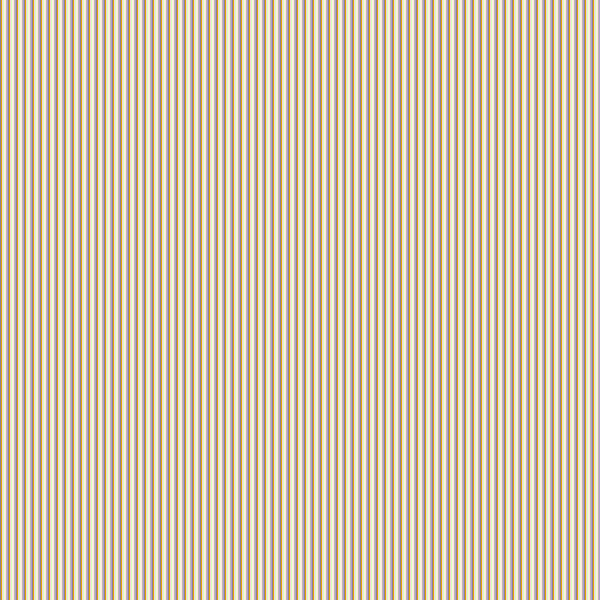

In [ ]:
def donesound():
    hz = np.linspace(200,1000,2000)
    wave = np.sin(2*np.pi*hz*np.arange(10000*.2)/10000)

    return Audio(wave, rate=10000, autoplay=True)

try:
    plt.close(fig)
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(np.arange(1,10,1))
except:
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(np.arange(1,10,1))

In [ ]:
donesound()

In [ ]:
def cartosph(cart):
    sph = []

    for i in cart:
        r = np.sqrt(i[0]**2 + i[1]**2 + i[2]**2)
        theta = np.degrees(np.arccos(i[2]/r))
        phi = np.degrees(np.arctan(i[1]/i[0]))
        if i[0] < 0: phi += 180

        sph.append([phi,theta,r])

    return sph

def cartosphrot(cart):
    sph = []

    for i in cart:
        r = np.sqrt(i[0]**2 + i[1]**2 + i[2]**2)
        theta = -np.degrees(np.arccos(i[2]/r)) + 90
        phi = np.degrees(np.arctan(i[1]/i[0]))
        if i[0] < 0: phi += 180
        phi += tiltaz #rotate phi back

        if phi > 360: phi -= 360
        elif phi < 0: phi += 360

        sph.append([phi,theta,r])

    return sph

def sphtocar(sph):
    cart = []

    for i in sph:
        x = i[2]*np.cos(np.radians(i[0]))*np.sin(np.radians(-(i[1]-90)))
        y = i[2]*np.sin(np.radians(i[0]))*np.sin(np.radians(-(i[1]-90)))
        z = i[2]*np.cos(np.radians(-(i[1]-90)))

        cart.append([x,y,z])

    return cart

<IPython.core.display.Javascript object>


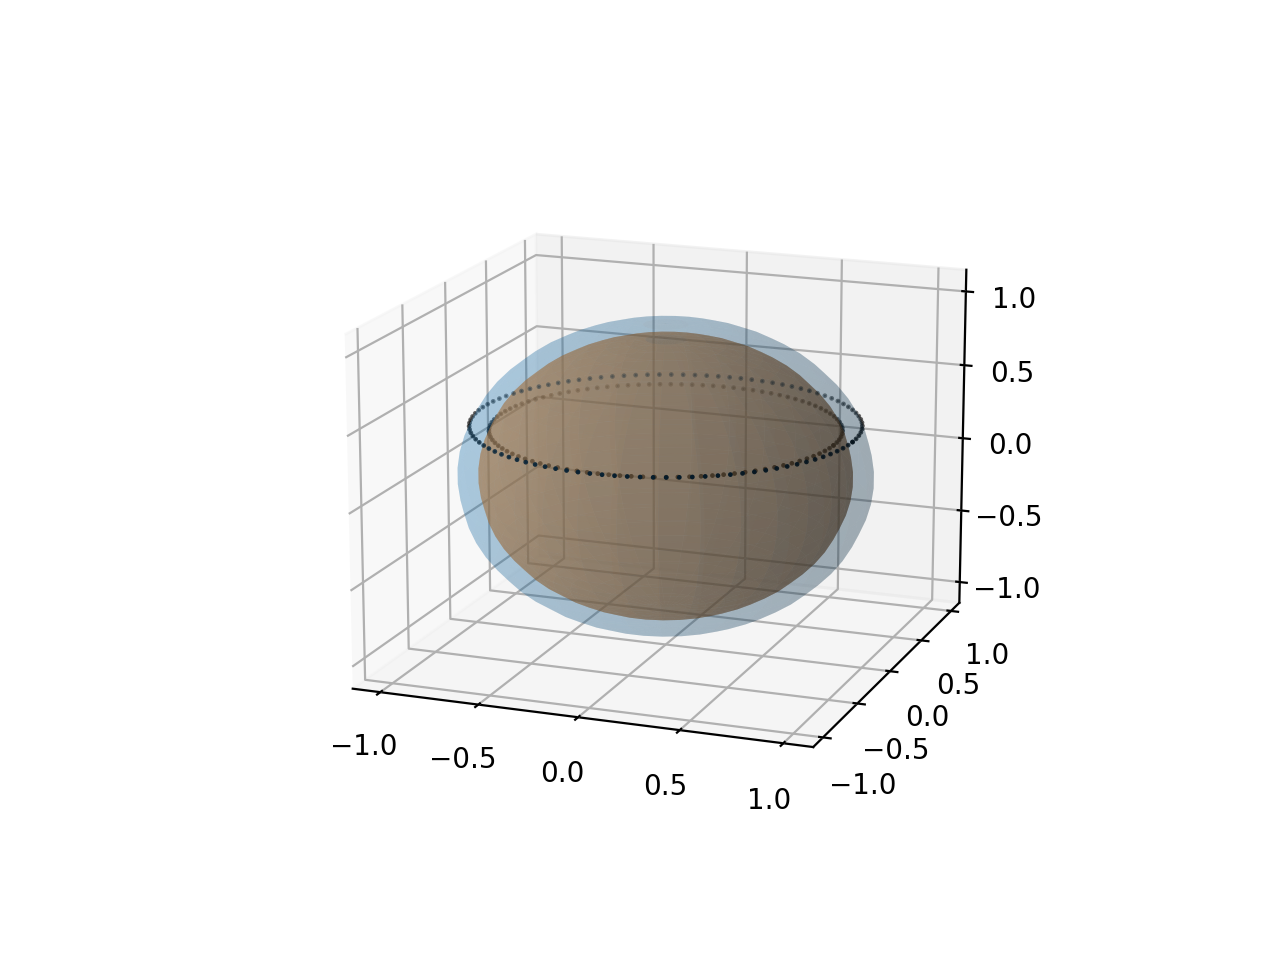

(<Figure size 640x480 with 1 Axes>, <Axes3DSubplot:>)

In [ ]:
bigR = 1
lilR = 0.9

azx = np.linspace(0,360,100)
azy = np.full(np.shape(azx),20)

sph_az = [[j,azy[i],bigR] for i,j in enumerate(azx)]

car_az = sphtocar(sph_az)

azx2 = np.linspace(0,360,100)
azy2 = np.full(np.shape(azx2),20)

sph_az2 = [[j,azy2[i],lilR] for i,j in enumerate(azx2)]

car_az2 = sphtocar(sph_az2)

# points = Points(carnpcoords)
az = Points(car_az)
az2 = Points(car_az2)
# pole = Points([[0,0,1]])
# rotated = Points(caragain[50:])
# rotated2 = Points(caragain[:50])

sphere = Sphere([0,0,0],bigR)
sphere2 = Sphere([0,0,0],lilR)

plot_3d(
#     points.plotter(c='k', s=5, depthshade=True),
    az.plotter(c='k', s=.5, depthshade=True),
    az2.plotter(c='k', s=.5, depthshade=True),
#     pole.plotter(c='b', s=5, depthshade=True),
#     rotated.plotter(c='c', s=5, depthshade=True),
#     rotated2.plotter(c='k', s=5, depthshade=True),
# #     plane.plotter(alpha=0.2, lims_x=(-2500, 3500), lims_y=(-6500, 1600)),
    sphere.plotter(alpha=.2),
    sphere2.plotter(alpha=.4)
)

In [ ]:
directorystr = "RomanFiles0308"
filename = "N1477225220_2"

filelabel = directorystr + "/" + filename + ".LBL"
filepath = filelabel[:-4]

Input a directory containing all downloaded files from PDS ring node. It sorts through, finds all .LBL files, and maps them to an equirectangular map

Note: mapping still needs adjusted radius for atmosphere height and ellipsoidal shape

In [ ]:
directorystr = "MT3more/testfolder"
filename = "W1646520713_1"

filelabel = directorystr + "/" + filename + ".LBL"
filepath = filelabel[:-4] + "r140"
print(filename)


try: ciss2isis(from_=filelabel, to=filepath + ".cub")
except ProcessError as e:
    print("STDOUT:", e.stdout)
    print("STDERR:", e.stderr)


#spiceinit(from_=filepath + ".cub", cksmithed=True, spksmithed=False, ck = "$cassini/kernels/ck/04275_04305ca_ISS.bc", pck="anaconda3/envs/isis/data/cassini/kernels/pck/cpck15Dec2017TitanEdit.tpc")

spiceinit(from_=filepath + ".cub", cksmithed="TRUE", spksmithed="TRUE", pck="anaconda3/envs/isis/data/cassini/kernels/pck/cpck15Dec2017TitanEdit140.tpc")
#spiceinit(from_=filepath + ".cub", cksmithed=True, spksmithed=True)

caminfo(from_=filepath + ".cub", to=filepath + "_INFO.pvl")

label = pvl.load(filepath + "_INFO.pvl")
subCraftLat = label['Caminfo']['Geometry']['SubSpacecraftLatitude']
subCraftLon = label['Caminfo']['Geometry']['SubSpacecraftLongitude']

print("done")

N1477225220_2
done


In [ ]:
subCraftLon

250.04505006737

In [ ]:
a_file = open(directorystr + "/Pointing/CenterPointing.txt", "r")
list_of_lists = [(line.strip()).split() for line in a_file]
a_file.close()
thing = list_of_lists[2:]
thingy = np.asarray(thing)

label1 = np.copy(thingy[:,0])
line = np.copy(thingy[:,1]).astype(np.float)
sample = np.copy(thingy[:,2]).astype(np.float)
rad = np.copy(thingy[:,3]).astype(np.float)

row = np.where(label1 == filename)[0][0]
line[row], sample[row], rad[row]

(518.0, 514.0, 266.93414681024257)

In [ ]:
deltack(from_=filepath + ".cub", method="DIRECT", line1=line[row], samp1=sample[row], lat1=subCraftLat, lon1=subCraftLon)

b'Group = DeltackResults\n  Method         = direct\n  Lat1           = -12.398198408761 <degrees>\n  Lon1           = 250.04505006737 <degrees>\n  Lat1Lon1Sample = 514.51004249827\n  Lat1Lon1Line   = 506.8513566261\n  Samp1          = 514.0\n  Line1          = 518.0\n  Samp1Line1Lat  = -12.497755104395 <degrees>\n  Samp1Line1Lon  = 252.62759609001 <degrees>\n  AdjustedAngle  = 0.0038311324870799 <degrees>\n  RecordsUpdated = 1\n  Status         = "Camera pointing updated"\nEnd_Group\n'

In [ ]:
cisscal(from_=filepath + ".cub", to=filepath + "_calnoisy.cub", units="I/F")

noisefilter(from_=filepath + "_calnoisy.cub", to=filepath + "_cal.cub", toldef="stddev", tolmin=1, tolmax=1, samples=7, lines=7)

#get subspacecraft lat and lon
# caminfo(from_=filepath + ".cub", to=filepath + "_INFO.pvl")

# label2 = pvl.load(filepath + "_INFO.pvl")
# subCraftLat = label2['Caminfo']['Geometry']['SubSpacecraftLatitude']
# subCraftLon = label2['Caminfo']['Geometry']['SubSpacecraftLongitude']

#find desired planet center from pointing file
# row = np.where(label1 == filename)[0][0]

#correct pointing
# try: deltack(from_=filepath + "_cal.cub", method="DIRECT", line1=line[row], samp1=sample[row], lat1=subCraftLat, lon1=subCraftLon)
# except ProcessError as e:
#     print("STDOUT:", e.stdout)
#     print("STDERR:", e.stderr)

# #create incidence and emission angle cubes for original image (not projected) -might need later
phocube(from_=filepath + "_cal.cub", to=filepath + "_incidence.cub", phase='no',
                emission='no', incidence='yes', latitude='no', longitude='no')

phocube(from_=filepath + "_cal.cub", to=filepath + "_emission.cub", phase='no',
                emission='yes', incidence='no', latitude='no', longitude='no')

phocube(from_=filepath + "_cal.cub", to=filepath + "_phase.cub", phase='yes',
                emission='no', incidence='no', latitude='no', longitude='no')

#output lat and lon files for original image (not projected)
phocube(from_=filepath + "_cal.cub", to=filepath + "_cal_lat.cub", phase='no',
                emission='no', incidence='no', latitude='yes', longitude='no')

isis2ascii(from_=filepath + "_cal_lat.cub", to=filepath + "_cal_lat.txt")

phocube(from_=filepath + "_cal.cub", to=filepath + "_cal_lon.cub", phase='no',
                emission='no', incidence='no', latitude='no', longitude='yes')

isis2ascii(from_=filepath + "_cal_lon.cub", to=filepath + "_cal_lon.txt")

# try: photomet(from_=filepath + "_cal.cub", to=filepath + "_photomet.cub", phtname='minnaert', k=0.4, maxemission=66,
#               normname='albedo', incref=0, thresh=100, albedo=.22)
# except ProcessError as e:
#     print("STDOUT:", e.stdout)
#     print("STDERR:", e.stderr)

#map image and lat/lon files to equirectangular projection
cam2map(from_=filepath + "_cal.cub", to=filepath + "_level2.cub", map="equirectangularTitan.map",defaultrange="map")
#cam2map(from_=filepath + "_cal_lat.cub", to=filepath + "_level2_lat.cub", map="equirectangularTitan.map",defaultrange="map")
#cam2map(from_=filepath + "_cal_lon.cub", to=filepath + "_level2_lon.cub", map="equirectangularTitan.map",defaultrange="map")


phocube(from_=filepath + "_level2.cub", to=filepath + "_cubelon.cub", phase='no',
                emission='no', incidence='no', latitude='no', longitude='yes')

isis2ascii(from_=filepath + "_cubelon.cub", to=filepath + "_cubelon.txt")

phocube(from_=filepath + "_level2.cub", to=filepath + "_cubelat.cub", phase='no',
                emission='no', incidence='no', latitude='yes', longitude='no')

isis2ascii(from_=filepath + "_cubelat.cub", to=filepath + "_cubelat.txt")

phocube(from_=filepath + "_level2.cub", to=filepath + "_cubeinc.cub", phase='no',
                emission='no', incidence='yes', latitude='no', longitude='no')

isis2ascii(from_=filepath + "_cubeinc.cub", to=filepath + "_cubeinc.txt")

phocube(from_=filepath + "_level2.cub", to=filepath + "_cubeemis.cub", phase='no',
                emission='yes', incidence='no', latitude='no', longitude='no')

isis2ascii(from_=filepath + "_cubeemis.cub", to=filepath + "_cubeemis.txt")

phocube(from_=filepath + "_level2.cub", to=filepath + "_cubephase.cub", phase='yes',
                emission='no', incidence='no', latitude='no', longitude='no')

isis2ascii(from_=filepath + "_cubephase.cub", to=filepath + "_cubephase.txt")

# #trim map and lat/lon files to lat -28 to 18 and lon 0 to 360
# maptrim(from_=filepath + "_level2_trim.cub", to=filepath + "_crop.cub", mode="crop",
#              minlat=-28, maxlat=18, minlon=0, maxlon=360)
# maptrim(from_=filepath + "_level2_lat.cub", to=filepath + "_crop_lat.cub", mode="crop",
#              minlat=-28, maxlat=18, minlon=0, maxlon=360)
# maptrim(from_=filepath + "_level2_lon.cub", to=filepath + "_crop_lon.cub", mode="crop",
#              minlat=-28, maxlat=18, minlon=0, maxlon=360)

# isis2ascii(from_=filepath + "_crop.cub", to=filepath + "_crop.txt")

# isis2ascii(from_=filepath + "_crop_lat.cub", to=filepath + "_crop_lat.txt")

# isis2ascii(from_=filepath + "_crop_lon.cub", to=filepath + "_crop_lon.txt")

isis2ascii(from_=filepath + "_level2.cub", to=filepath + "_crop.txt")

#isis2ascii(from_=filepath + "_level2_lat.cub", to=filepath + "_crop_lat.txt")

#isis2ascii(from_=filepath + "_level2_lon.cub", to=filepath + "_crop_lon.txt")

print("done")

done


In [ ]:
# directorystr = "0401MT3"
# filename = "N1477225220_2"

# filelabel = directorystr + "/" + filename + ".LBL"
# filepath = filelabel[:-4] + "big"

isis2ascii(from_=filepath + "_cal.cub", to=filepath + "_PREMAP.txt")
isis2ascii(from_=filepath + "_incidence.cub", to=filepath + "_incidence.txt")
isis2ascii(from_=filepath + "_emission.cub", to=filepath + "_emission.txt")
isis2ascii(from_=filepath + "_phase.cub", to=filepath + "_phase.txt")

b''

In [ ]:
a_file = open(filepath + "_crop.txt", "r")
list_of_lists = [(line.strip()).split() for line in a_file]
a_file.close()
mapArray = np.asarray(list_of_lists[4:])
nanMapArray = np.where(np.logical_or(mapArray == 'NULL', mapArray == 'HRS'), np.nan, mapArray)
mapArray = nanMapArray.astype(np.float)

imageshift = int(len(mapArray)/46 * 3 // 2 * 2) #~3 deg latitude in pixels, forced to be even integer
imageshift2 = int(imageshift * 2) #arrays must shift double to shift both images opposite directions

#read in lat and lon maps
b_file = open(filepath + "_crop_lat.txt", "r")
list_of_lists = [(line.strip()).split() for line in b_file]
b_file.close()

templat = list_of_lists[4:]
floattemplat = [[np.nan if i == 'NULL' or i == 'HRS' else float(i) for i in j] for j in templat]
mapArraylattoobig = np.asarray(floattemplat)
mapArraylat = np.copy(mapArraylattoobig[imageshift:-imageshift])

c_file = open(filepath + "_crop_lon.txt", "r")
list_of_lists = [(line.strip()).split() for line in c_file]
c_file.close()

templon = list_of_lists[4:]
floattemplon = [[np.nan if i == 'NULL' or i == 'HRS' else float(i) for i in j] for j in templon]
mapArraylontoobig = np.asarray(floattemplon)
mapArraylon = np.copy(mapArraylontoobig[imageshift:-imageshift])

#determine if planet crosses longitude seam, split down middle and reattach so planet is whole
if len(np.where(np.isfinite(mapArray[:,0]))[0])>0 and len(np.where(np.isfinite(mapArray[:,-1]))[0])>0:
    if len(mapArray[0]) != len(mapArraylat[0]) or len(mapArray[0]) != len(mapArraylon[0]):
        print("*******")

    middle = int(len(mapArray[0])/2)
    lefthalf = mapArray[:,:middle]
    righthalf = mapArray[:,middle:]
    mapArray = np.concatenate((righthalf,lefthalf),axis=1)

    middle = int(len(mapArraylat[0])/2)
    lefthalf = mapArraylat[:,:middle]
    righthalf = mapArraylat[:,middle:]
    mapArraylat = np.concatenate((righthalf,lefthalf),axis=1)

    middle = int(len(mapArraylon[0])/2)
    lefthalf = mapArraylon[:,:middle]
    righthalf = mapArraylon[:,middle:]
    mapArraylon = np.concatenate((righthalf,lefthalf),axis=1)

# determine where innermost nans are for lon limits
left = []
right = []

for i in mapArray:
    left.append(np.where(np.isfinite(i))[0][0])
    right.append(np.where(np.isfinite(i))[0][-1])

lonleft = np.max(left)
lonright = np.min(right)

short = np.copy(mapArray[:,lonleft:lonright+1])
mask = np.isnan(short)
short[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask),short[~mask])

#mapArray = filters.gaussian(mapArray, sigma=3)
trimmed = short[imageshift2:] - short[:-imageshift2]

trimmedlat = np.copy(mapArraylat[:,lonleft:lonright+1])
trimmedlon = np.copy(mapArraylon[:,lonleft:lonright+1])

#imshow(mapArray,cmap="gray")
#imsave(filepath[:-4] + "_trim.jpg",trimmed,cmap="gray")

#bin width ~2 deg longitude in pixels, forced to be odd integer so bin represented by center pixel
binwidth = int((2*(lonright-lonleft)/abs(trimmedlon[0,-1]-trimmedlon[0,0])) // 2 * 2 + 1)

extra = int((lonright+1 - lonleft)%binwidth) #trim off remainder at edge of image

if extra == 0:
    binned = trimmed.reshape(len(trimmed), -1, binwidth).mean(2)
    binnedlat = trimmedlat.reshape(len(trimmedlat), -1, binwidth).mean(2)
    binnedlon = trimmedlon.reshape(len(trimmedlon), -1, binwidth).mean(2)

else:
    binned = trimmed[:,:-extra].reshape(len(trimmed[:,:-extra]), -1, binwidth).mean(2)
    binnedlat = trimmedlat[:,:-extra].reshape(len(trimmedlat[:,:-extra]), -1, binwidth).mean(2)
    binnedlon = trimmedlon[:,:-extra].reshape(len(trimmedlon[:,:-extra]), -1, binwidth).mean(2)


lats = len(binned)

y = list(range(lats))
lonbintemp = list(range(len(binned[0])))
lonbin = []
mins = []
polydeg = 2 #change below too!
halfwidthBand = int(lats/3 // 2)

def poly2(x, a, b, c):
    return a*x*x + b*x + c
def poly3(x, a, b, c, d):
    return a*x*x*x + b*x*x + c*x + d
def poly4(x, a, b, c, d, f):
    return a*x*x*x*x + b*x*x*x + c*x*x + d*x + f

for i in lonbintemp:
    actualmin = np.nanargmin(binned[:,i])
    top = actualmin-halfwidthBand
    if top < 0: top = 0
    bottom = actualmin+halfwidthBand
    if bottom >= len(binned): bottom = len(binned) - 1

    x = list(range(top, bottom+1))
    y = binned[top:bottom+1,i]

    z = np.polyfit(x,y, polydeg)
    p = np.poly1d(z)
    xp = np.linspace(top, bottom, halfwidthBand*2+1)
    #popt, pcov = curve_fit(poly2, x, y) #Change poly here
    #xp = np.linspace(top, bottom, halfwidthBand*2+1)
    #p = poly2(xp, *popt) #And here

    #sometimes min falls at ends, thus not valid
    if np.argmin(p(xp)) != 0 and np.argmin(p(xp)) != len(p(xp))-1: #***********
        mins.append(int(xp[np.argmin(p(xp))])) #*********************
        lonbin.append(i)



x = binnedlon[0,lonbin[:-1]]
x = [360 - a for a in x]
y = []
for i in mins[:-1]:
    if np.isnan(i): y.append(np.nan)
    else: y.append(binnedlat[i, 0])




freq = np.float64(2*np.pi/360)

def func(x, a, b, c):
    return a*np.sin(freq*(x+b))+c #x+b or x-b???

popt, pcov = curve_fit(func, x, y, bounds=([0,0,-25], [90, 360., 15]))

allx = np.arange(0,360,0.1)
allx = [360 - a for a in allx]
plt.plot(x, y, 'b-', label='data')
plt.plot(allx, func(allx, *popt), 'r-', label='fit: Tilt Amp=%5.3f, Tilt Az=%5.3f, Mean Lat=%5.3f' % tuple([popt[0],270-popt[1],popt[2]]))
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([360, 0])
plt.ylim([-15, 0])
plt.legend()

#plt.savefig(directorystr + "/Plots/Poly2_" + filename + "_fitplot.png")
plt.close()

lonpix=[x*binwidth + (binwidth//2 + 1) for x in lonbin]


copy1 = np.copy(trimmed)
copy1[mins,lonpix] = 255

#imsave(directorystr + "/Pics/Poly2_" + filename + "_minima.jpg", copy1, cmap='gray', vmin=np.nanmin(trimmed), vmax=np.nanmax(trimmed))

azimuth = 270 - popt[1]
if azimuth < 0: azimuth += 360

label = pvl.load(directorystr + '/' + filename + "_INFO.pvl")
SSL = 360 - label['Caminfo']['Geometry']['SubSolarLongitude']
offset = azimuth - SSL
time = label['Caminfo']['Geometry']['EndTime']

print("{0} {1} {2} {3} {4} {5}".format(filename, popt[0], azimuth, popt[2], SSL, offset))

N1477221680_2 3.7202592472301252 141.25246845617588 -7.5552734908962345 87.71275655877997 53.539711897395904


<IPython.core.display.Javascript object>


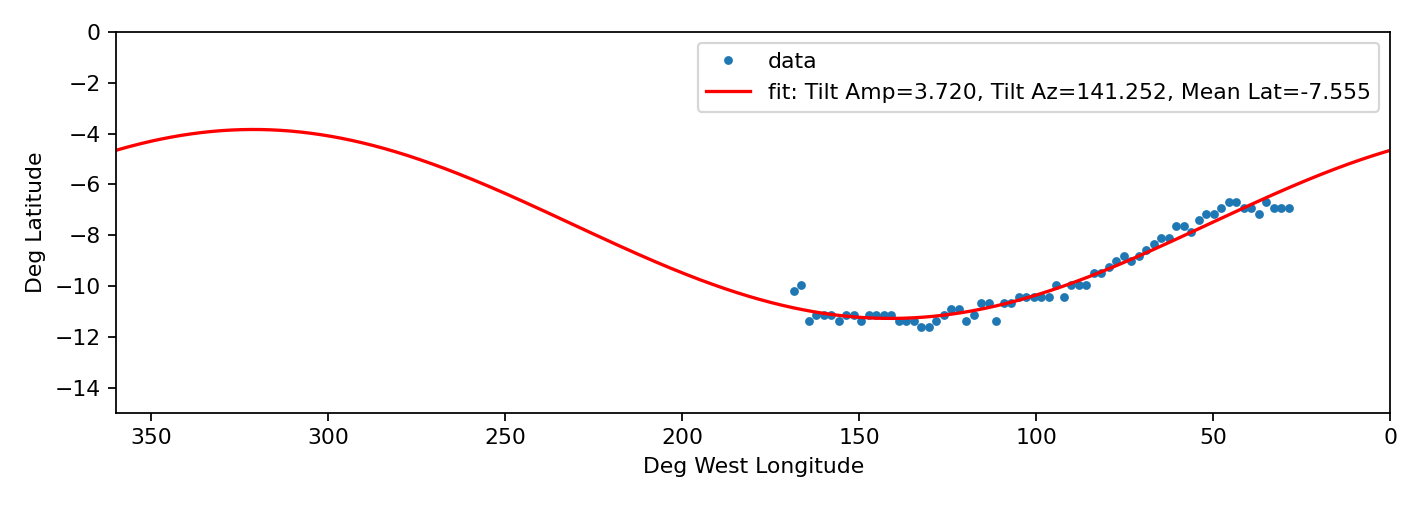

In [ ]:
copy2 = np.copy(short[imageshift:-imageshift])
copy2[mins,lonpix] = 255


plt.close(fig)
fig, ax = plt.subplots(figsize=(9,3.2))

allx = np.arange(0,360,0.1)
allx = [360 - a for a in allx]
ax.plot(x, y, '.',label='data')
ax.plot(allx, func(allx, *popt), 'r-', label='fit: Tilt Amp=%5.3f, Tilt Az=%5.3f, Mean Lat=%5.3f' % tuple([popt[0],270-popt[1],popt[2]]))
ax.set_xlabel('Deg West Longitude')
ax.set_ylabel('Deg Latitude')
ax.set_xlim([360, 0])
ax.set_ylim([-15, 0])
ax.legend()
fig.tight_layout()
# ax.imshow(copy1,cmap="gray",vmin=-.01,vmax=np.nanmax(trimmed))
# ax.set_xlim(0,600)

In [ ]:
trimmed.min(),trimmed.max()

(-0.008480810000000005, 0.004926349999999996)

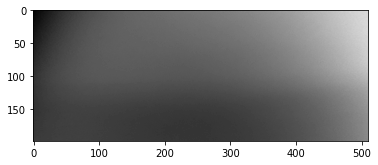

In [ ]:
imshow(short,cmap="gray",vmin=np.nanmin(short), vmax=0.1)

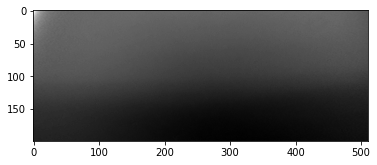

In [ ]:
imshow(short,cmap="gray",vmin=np.nanmin(short), vmax=0.1)

In [ ]:
len(mapArray), len(mapArraylat), len(mapArraylon)

(250, 218, 218)

In [ ]:
len(binned[0]), len(trimmed), len(binnedlat), binwidth, extra, lonleft, lonright, imageshift2, bottom, top, halfwidthBand

(134, 218, 218, 5, 0, 512, 1181, 32, 209, 137, 36)

In [ ]:
np.argmin(p(xp)) + actualmin-halfwidthBand

162

In [ ]:
xp[np.argmin(p(xp))]

162.0

In [ ]:
np.where(np.isfinite(mapArraylat))

(array([  0,   0,   0, ..., 174, 174, 174]),
 array([ 705,  706,  707, ..., 1488, 1489, 1490]))

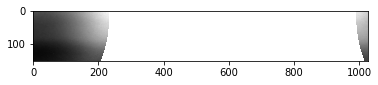

In [ ]:
filepath="0311MT3/N1750038546_1"
a_file = open(filepath + "_crop.txt", "r")
list_of_lists = [(line.strip()).split() for line in a_file]
a_file.close()
thing = list_of_lists[4:]
floatthing = [[np.nan if i == 'NULL' or i == 'HRS' else float(i) for i in j] for j in thing]
thingy = np.asarray(floatthing)

imshow(thingy,cmap="gray")

from pysis.exceptions import ProcessError

try:
    ciss2isis(from_="N1481459297_1.LBL", to="N1481459297_1.cub")
except ProcessError as e:
    print("STDOUT:", e.stdout)
    print("STDERR:", e.stderr)



In [ ]:
#change nulls to nans, shift and subtract map
directorystr = "0312MT3/"
filename = "N1744553285_1"
filepath = directorystr + filename

a_file = open(filepath + "_crop.txt", "r")
list_of_lists = [(line.strip()).split() for line in a_file]
a_file.close()
thing = list_of_lists[4:]
floatthing = [[np.nan if i == 'NULL' or i == 'HRS' else float(i) for i in j] for j in thing]
thingy = np.asarray(floatthing)

imageshift = int(len(thingy)/46 * 3 // 2 * 2) #~3 deg latitude in pixels, forced to be even integer
imageshift2 = int(imageshift * 2) #arrays must shift double to shift both images opposite directions

thingysub = thingy[imageshift2:] - thingy[:-imageshift2]
imsave(directorystr + "Pics/" + filename + "_cropShifted.png", thingysub, cmap="gray",
       vmin=np.nanmin(thingysub), vmax=np.nanmax(thingysub))


#read in lat and lon maps
b_file = open(filepath + "_crop_lat.txt", "r")
list_of_lists = [(line.strip()).split() for line in b_file]
b_file.close()

thinglat = list_of_lists[4:]
floatthinglat = [[np.nan if i == 'NULL' or i == 'HRS' else float(i) for i in j] for j in thinglat]
thingylat = np.asarray(floatthinglat)


c_file = open(filepath + "_crop_lon.txt", "r")
list_of_lists = [(line.strip()).split() for line in c_file]
c_file.close()

thinglon = list_of_lists[4:]
floatthinglon = [[np.nan if i == 'NULL' or i == 'HRS' else float(i) for i in j] for j in thinglon]
thingylon = np.asarray(floatthinglon)

left = []
right = []

# determine where innermost nans are for lon limits
for i in thingysub:
    left.append(np.where(np.isfinite(i))[0][0])
    right.append(np.where(np.isfinite(i))[0][-1])

lonleft = np.max(left)
lonright = np.min(right)


copy = thingysub[:,lonleft:lonright+1]
imsave(directorystr + "Pics/" + filename + "_trim.png", copy, cmap="gray",
       vmin=np.nanmin(copy), vmax=np.nanmax(copy))

#bin width ~2 deg longitude in pixels, forced to be odd integer so bin represented by center pixel
binwidth = int((2*(lonright-lonleft)/abs(thingylon[0,lonright]-thingylon[0,lonleft])) // 2 * 2 + 1)

extra = (lonright+1 - lonleft)%binwidth #trim off remainder at edge of image

newlonright = int(lonright - extra)

binned = thingysub[:,lonleft:newlonright+1].reshape(len(thingysub[:,lonleft:newlonright+1]), -1, binwidth).mean(2)
lats = len(binned)

binnedlat = thingylat[:,lonleft:newlonright+1].reshape(len(thingylat[:,lonleft:newlonright+1]), -1, binwidth).mean(2)
binnedlon = thingylon[:,lonleft:newlonright+1].reshape(len(thingylon[:,lonleft:newlonright+1]), -1, binwidth).mean(2)

In [ ]:
np.shape(thingylon)

(197, 1492)

In [ ]:
np.shape(thingy)

(197, 1492)

In [ ]:
y = list(range(lats))
lonbintemp = list(range(len(binned[0])))
lonbin = []
mins = []
polydeg = 2 #seems to change results drastically
halfwidthBand = int(lats/3 // 2)

for i in lonbintemp:
    actualmin = np.argmin(binned[:,i])
    top = actualmin-halfwidthBand
    if top < 0: top = 0
    bottom = actualmin+halfwidthBand
    if bottom >= len(binned): bottom = len(binned) - 1

    z = np.polyfit(list(range(top, bottom+1)), binned[top:bottom+1,i], polydeg)
    p = np.poly1d(z)
    xp = np.linspace(top, bottom, halfwidthBand*2+1)

    #sometimes min falls at ends, thus not valid
    if np.argmin(p(xp)) != 0 and np.argmin(p(xp)) != len(p(xp)):
        mins.append(np.argmin(p(xp)) + actualmin-halfwidthBand)
        lonbin.append(i)

plt.plot(lonbin, mins)
plt.xlabel('longitude (bin number)')
plt.ylabel('latitude of minimum (pixel number)')
plt.savefig(directorystr + "/Plots/" + filename + ".png")
plt.close()



x = binnedlon[0,lonbin]
x = [360 - a for a in x]
y = []
for i in mins:
    if np.isnan(i): y.append(np.nan)
    else: y.append(binnedlat[i + imageshift, 0])

plt.plot(x, y, '.')
plt.xlim([360, 0])
plt.ylim([-15, 0])
plt.yticks(np.arange(-15, 1, 5))
plt.xticks(np.arange(0, 360, 100))

plt.xlabel('longitude')
plt.ylabel('latitude')

plt.savefig(directorystr + "/Plots/" + filename + "_dots.png")
plt.close()





freq = np.float64(2*np.pi/360)

def func(x, a, b, c):
    return a*np.sin(freq*(x+b))+c #x+b or x-b???

popt, pcov = curve_fit(func, x, y, bounds=([0,0,-25], [90, 360., 15]))

allx = np.arange(0,360,0.1)
allx = np.asarray([360 - a for a in allx])
plt.plot(x, y, 'b-', label='data')
plt.plot(allx, func(allx, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([360, 0])
plt.ylim([-15, 0])
plt.legend()

plt.savefig(directorystr + "/Plots/" + filename + "_fitplot.png")
plt.close()

azimuth = 270 - popt[1]
if azimuth < 0: azimuth += 360

print("Tilt Amplitude = " + str(popt[0]) + " degrees latitude")
print("Tilt Azimuth = " + str(azimuth) + " degrees west longitude")
print("NSA Boundary Mean Latitude = " + str(popt[2]) + " degrees")
label = pvl.load(filepath + "_INFO.pvl")

print(label['Caminfo']['Geometry']['SubSolarLongitude'])

<IPython.core.display.Javascript object>

IndexError: index 207 is out of bounds for axis 0 with size 197

In [ ]:
x = np.asarray(list(range(top, bottom+1)))
y = binned[top-1:bottom,i]

In [ ]:
len(mins),len(binnedlat)

(32, 197)

In [ ]:
mask = np.where(np.isfinite(y))[0].astype(np.int)

In [ ]:

type(d), len(y), top, bottom

(numpy.ndarray, 18, 64, 81)

In [ ]:
directorystr = "0401MT3/"
filename = "N1477221680_2"
filepath = directorystr + filename

a_file = open(filepath + "_crop.txt", "r")
list_of_lists = [(line.strip()).split() for line in a_file]
a_file.close()
mapArray = np.asarray(list_of_lists[4:])
nanMapArray = np.where(np.logical_or(mapArray == 'NULL', mapArray == 'HRS'), np.nan, mapArray)
mapArray = nanMapArray.astype(np.float)

imageshift = int(len(mapArray)/46 * 3 // 2 * 2) #~3 deg latitude in pixels, forced to be even integer
imageshift2 = int(imageshift * 2) #arrays must shift double to shift both images opposite directions

mapArraysub = mapArray[imageshift2:] - mapArray[:-imageshift2]


#read in lat and lon maps
b_file = open(filepath + "_crop_lat.txt", "r")
list_of_lists = [(line.strip()).split() for line in b_file]
b_file.close()

templat = list_of_lists[4:]
floattemplat = [[np.nan if i == 'NULL' or i == 'HRS' else float(i) for i in j] for j in templat]
mapArraylattoobig = np.asarray(floattemplat)
mapArraylat = np.copy(mapArraylattoobig[imageshift:-imageshift])

c_file = open(filepath + "_crop_lon.txt", "r")
list_of_lists = [(line.strip()).split() for line in c_file]
c_file.close()

templon = list_of_lists[4:]
floattemplon = [[np.nan if i == 'NULL' or i == 'HRS' else float(i) for i in j] for j in templon]
mapArraylontoobig = np.asarray(floattemplon)
mapArraylon = np.copy(mapArraylontoobig[imageshift:-imageshift])

# determine where innermost nans are for lon limits
left = []
right = []

for i in mapArray:
    left.append(np.where(np.isfinite(i))[0][0])
    right.append(np.where(np.isfinite(i))[0][-1])

lonleft = np.max(left)
lonright = np.min(right)


trimmed = np.copy(mapArraysub[:,lonleft:lonright+1])
trimmedlat = np.copy(mapArraylat[:,lonleft:lonright+1])
trimmedlon = np.copy(mapArraylon[:,lonleft:lonright+1])



#bin width ~2 deg longitude in pixels, forced to be odd integer so bin represented by center pixel
binwidth = int((2*(lonright-lonleft)/abs(trimmedlon[0,-1]-trimmedlon[0,0])) // 2 * 2 + 1)

extra = int((lonright+1 - lonleft)%binwidth) #trim off remainder at edge of image

if extra == 0:
    binned = trimmed.reshape(len(trimmed), -1, binwidth).mean(2)
    binnedlat = trimmedlat.reshape(len(trimmedlat), -1, binwidth).mean(2)
    binnedlon = trimmedlon.reshape(len(trimmedlon), -1, binwidth).mean(2)

else:
    binned = trimmed[:,:-extra].reshape(len(trimmed[:,:-extra]), -1, binwidth).mean(2)
    binnedlat = trimmedlat[:,:-extra].reshape(len(trimmedlat[:,:-extra]), -1, binwidth).mean(2)
    binnedlon = trimmedlon[:,:-extra].reshape(len(trimmedlon[:,:-extra]), -1, binwidth).mean(2)


lats = len(binned)

y = list(range(lats))
lonbintemp = list(range(len(binned[0])))
lonbin = []
mins = []
polydeg = 2 #change below too!
halfwidthBand = int(lats/3 // 2)

def poly2(x, a, b, c):
    return a*x*x + b*x + c
def poly3(x, a, b, c, d):
    return a*x*x*x + b*x*x + c*x + d
def poly4(x, a, b, c, d, f):
    return a*x*x*x*x + b*x*x*x + c*x*x + d*x + f

for i in lonbintemp:
    actualmin = np.argmin(binned[:,i])
    top = actualmin-halfwidthBand
    if top < 0: top = 0
    bottom = actualmin+halfwidthBand
    if bottom >= len(binned): bottom = len(binned) - 1

    x = list(range(top, bottom+1)) #lines
    y = binned[top:bottom+1,i]     #brightness along column

    z = np.polyfit(x,y, polydeg)
    p = np.poly1d(z)
    xp = np.linspace(top, bottom, halfwidthBand*2+1)
    #popt, pcov = curve_fit(poly2, x, y) #Change poly here
    #xp = np.linspace(top, bottom, halfwidthBand*2+1)
    #p = poly2(xp, *popt) #And here

    #sometimes min falls at ends, thus not valid
    if np.argmin(p(xp)) != 0 and np.argmin(p(xp)) != len(p(xp)):
        mins.append(np.argmin(p(xp)) + actualmin-halfwidthBand)
        lonbin.append(i)



x = binnedlon[0,lonbin]
x = [360 - a for a in x]
y = []
for i in mins:
    if np.isnan(i): y.append(np.nan)
    else: y.append(binnedlat[i, 0])




freq = np.float64(2*np.pi/360)

def func(x, a, b, c):
    return a*np.sin(freq*(x+b))+c #x+b or x-b???

popt, pcov = curve_fit(func, x, y, bounds=([0,0,-25], [90, 360., 15]))

allx = np.arange(0,360,0.1)
allx = [360 - a for a in allx]
plt.plot(x, y, 'b-', label='data')
plt.plot(allx, func(allx, *popt), 'r-', label='fit: Tilt Amp=%5.3f, Tilt Az=%5.3f, Mean Lat=%5.3f' % tuple([popt[0],270-popt[1],popt[2]]))
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([360, 0])
plt.ylim([-15, 0])
plt.legend()

#plt.savefig(directorystr + "Plots/Poly2_" + filename[:-9] + "_fitplot.png")
plt.close()

lonpix=[x*binwidth + (binwidth//2 + 1) for x in lonbin]


copy1 = np.copy(trimmed)
copy1[mins,lonpix] = 255

#imsave(directorystr + "Pics/Poly2_" + filename[:-9] + "_minima.jpg", copy1, cmap='gray', vmin=np.nanmin(trimmed), vmax=np.nanmax(trimmed))

azimuth = 270 - popt[1]
if azimuth < 0: azimuth += 360

label = pvl.load(filepath + "_INFO.pvl")
SSL = 360 - label['Caminfo']['Geometry']['SubSolarLongitude']
offset = azimuth - SSL
time = label['Caminfo']['Geometry']['EndTime']

print("{0} {1} {2} {3} {4} {5} {6}".format(filename, popt[0], azimuth, popt[2], SSL, offset, time))

N1477221680_2 3.7202592472301252 141.25246845617588 -7.5552734908962345 87.71275655877997 53.539711897395904 2004-10-23 10:55:19.910000


In [ ]:
np.max(mins), len(binnedlat)

(200, 173)

In [ ]:
actualmin

171

In [ ]:
np.argmin(p(xp))

56

In [ ]:
azx - 45

array([-45.        , -34.6969697 , -24.39393939, -14.09090909,
        -3.78787879,   6.51515152,  16.81818182,  27.12121212,
        37.42424242,  47.72727273,  58.03030303,  68.33333333,
        78.63636364,  88.93939394,  99.24242424, 109.54545455,
       119.84848485, 130.15151515, 140.45454545, 150.75757576,
       161.06060606, 171.36363636, 181.66666667, 191.96969697,
       202.27272727, 212.57575758, 222.87878788, 233.18181818,
       243.48484848, 253.78787879, 264.09090909, 274.39393939,
       284.6969697 , 295.        ])

In [ ]:
def cartosph(cart):
    sph = []

    for i in cart:
        r = np.sqrt(i[0]**2 + i[1]**2 + i[2]**2)
        theta = np.degrees(np.arccos(i[2]/r))
        phi = np.degrees(np.arctan(i[1]/i[0]))
        if i[0] < 0: phi += 180

        sph.append([phi,theta,r])

    return sph

def cartosphrot(cart):
    sph = []

    for i in cart:
        r = np.sqrt(i[0]**2 + i[1]**2 + i[2]**2)
        theta = -np.degrees(np.arccos(i[2]/r)) + 90
        phi = np.degrees(np.arctan(i[1]/i[0]))
        if i[0] < 0: phi += 180
        phi += tiltaz #rotate phi back

        if phi > 360: phi -= 360
        elif phi < 0: phi += 360

        sph.append([phi,theta,r])

    return sph

def sphtocar(sph):
    cart = []

    for i in sph:
        x = i[2]*np.cos(np.radians(i[0]))*np.sin(np.radians(-(i[1]-90)))
        y = i[2]*np.sin(np.radians(i[0]))*np.sin(np.radians(-(i[1]-90)))
        z = i[2]*np.cos(np.radians(-(i[1]-90)))

        cart.append([x,y,z])

    return cart

In [ ]:
tiltaz = 30
tiltaz += 180
tiltamp = 5
radtiltamp = np.radians(tiltamp)

Ry = [[np.cos(radtiltamp), 0, -np.sin(radtiltamp)],
      [0,                1, 0                ],
      [np.sin(radtiltamp), 0, np.cos(radtiltamp) ]]

x = [0,90,180,270]
y = [20,20,20,20]
azx = np.linspace(0,340,68)
azy = np.full(np.shape(azx),20)
azx[-1] = 0
azy[-1] = 0

azxro = azx - tiltaz

sph_array = SphericalRepresentation(x * u.deg, 0 * u.deg, 1 * u.km)
sph_az = SphericalRepresentation(azx * u.deg, azy * u.deg, 1 * u.km)
sph_azro = SphericalRepresentation(azxro * u.deg, azy * u.deg, 1 * u.km)

car_array = sph_array.represent_as(CartesianRepresentation)
car_az = sph_az.represent_as(CartesianRepresentation)
car_azro = sph_azro.represent_as(CartesianRepresentation)

carnp = []
carnp.append(np.asarray(car_array.x))
carnp.append(np.asarray(car_array.y))
carnp.append(np.asarray(car_array.z))

carnpaz = []
carnpaz.append(np.asarray(car_az.x))
carnpaz.append(np.asarray(car_az.y))
carnpaz.append(np.asarray(car_az.z))

carnpazro = []
carnpazro.append(np.asarray(car_azro.x))
carnpazro.append(np.asarray(car_azro.y))
carnpazro.append(np.asarray(car_azro.z))

carnpcoords = np.asarray(carnp).transpose()
carnpcoordsaz = np.asarray(carnpaz).transpose()
carnpcoordsazro = np.asarray(carnpazro).transpose()

# carnpcoordsaz = np.asarray([carnpcoordsaz]) #for testing single point

carnpcoordsazro2 = [np.matmul(Ry, x2) for x2 in carnpcoordsazro]

sphaz = cartosphrot(carnpcoordsazro2)

caragain = sphtocar(sphaz)

# carnpcoordsazro2,sphaz,caragain

In [ ]:
azx,azy

(array([  0.        ,   5.07462687,  10.14925373,  15.2238806 ,
         20.29850746,  25.37313433,  30.44776119,  35.52238806,
         40.59701493,  45.67164179,  50.74626866,  55.82089552,
         60.89552239,  65.97014925,  71.04477612,  76.11940299,
         81.19402985,  86.26865672,  91.34328358,  96.41791045,
        101.49253731, 106.56716418, 111.64179104, 116.71641791,
        121.79104478, 126.86567164, 131.94029851, 137.01492537,
        142.08955224, 147.1641791 , 152.23880597, 157.31343284,
        162.3880597 , 167.46268657, 172.53731343, 177.6119403 ,
        182.68656716, 187.76119403, 192.8358209 , 197.91044776,
        202.98507463, 208.05970149, 213.13432836, 218.20895522,
        223.28358209, 228.35820896, 233.43283582, 238.50746269,
        243.58208955, 248.65671642, 253.73134328, 258.80597015,
        263.88059701, 268.95522388, 274.02985075, 279.10447761,
        284.17910448, 289.25373134, 294.32835821, 299.40298507,
        304.47761194, 309.55223881, 314.

<IPython.core.display.Javascript object>


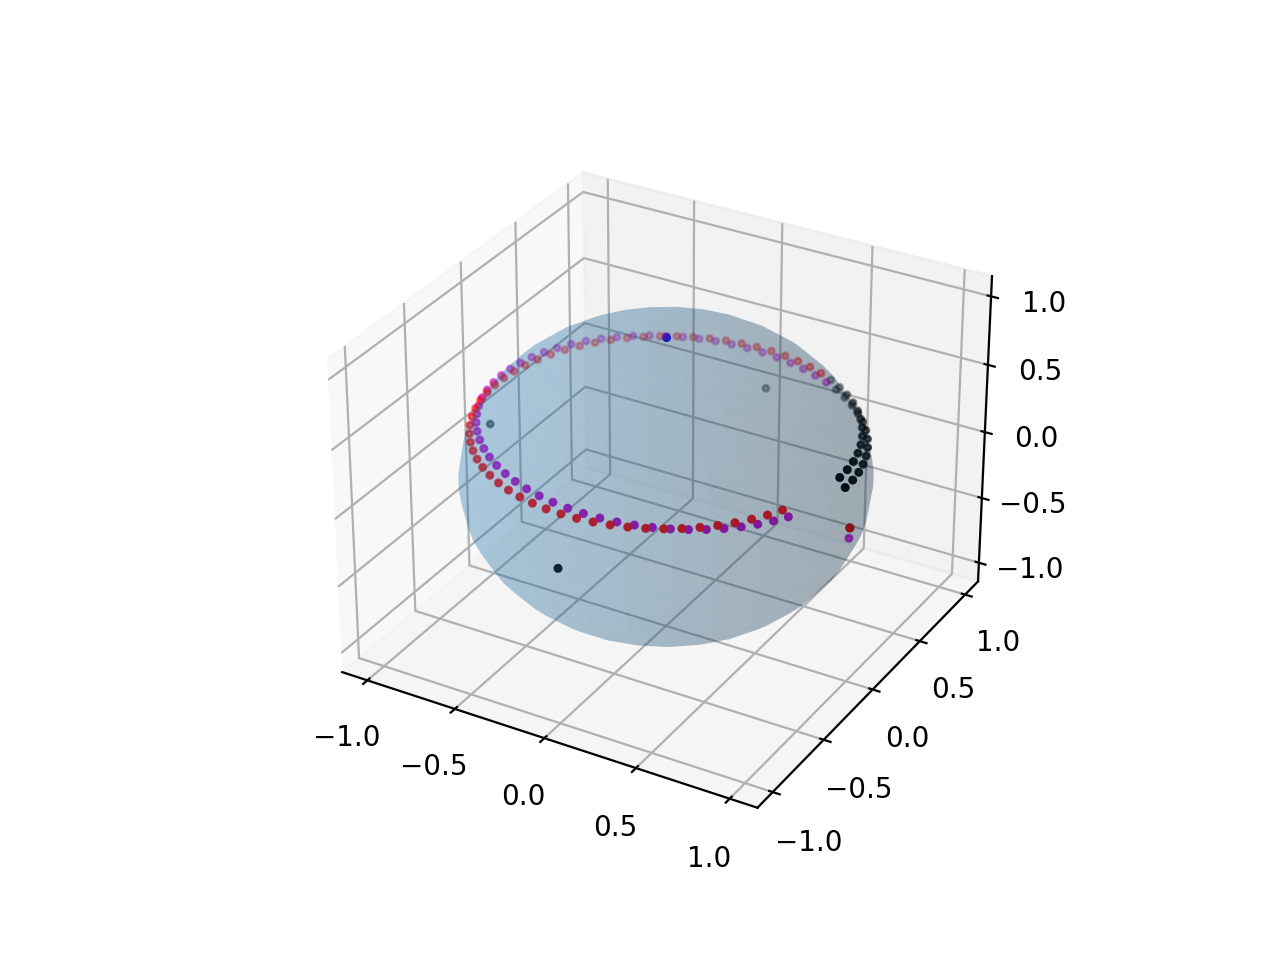

(<Figure size 640x480 with 1 Axes>, <Axes3DSubplot:>)

In [ ]:
from skspatial.objects import Points, Plane, Sphere
from skspatial.plotting import plot_3d
%matplotlib notebook

points = Points(carnpcoords)
az = Points(carnpcoordsaz[13:])
az2 = Points(carnpcoordsaz[:13])
pole = Points([[0,0,1]])
rotated = Points(caragain[13:])
rotated2 = Points(caragain[:13])

# plane = Plane.best_fit(points)

sphere = Sphere([0,0,0],1)



plot_3d(
    points.plotter(c='k', s=5, depthshade=True),
    az.plotter(c='r', s=5, depthshade=True),
    az2.plotter(c='k', s=5, depthshade=True),
    pole.plotter(c='b', s=5, depthshade=True),
    rotated.plotter(c='m', s=5, depthshade=True),
    rotated2.plotter(c='k', s=5, depthshade=True),
#     plane.plotter(alpha=0.2, lims_x=(-2500, 3500), lims_y=(-6500, 1600)),
    sphere.plotter(alpha=.2)
)

In [ ]:
directorystr = "MT3more/"
# fname = 'N1466071301_1'
fname = 'N1477225220_2'

filepath = directorystr + fname

a_file = open(filepath + "_incidence.txt", "r")
list_of_lists = [(line.strip()).split() for line in a_file]
a_file.close()
incArray = np.asarray(list_of_lists[4:])
nanIncArray = np.where(np.logical_or(incArray == 'NULL', incArray == 'HRS'), np.nan, incArray)
OGincArray =nanIncArray.astype(np.float)

a_file = open(filepath + "_emission.txt", "r")
list_of_lists = [(line.strip()).split() for line in a_file]
a_file.close()
emisArray = np.asarray(list_of_lists[4:])
nanEmisArray = np.where(np.logical_or(emisArray == 'NULL', emisArray == 'HRS'), np.nan, emisArray)
OGemisArray = nanEmisArray.astype(np.float)

a_file = open(filepath + "_cal_lat.txt", "r")
list_of_lists = [(line.strip()).split() for line in a_file]
a_file.close()
latArray = np.asarray(list_of_lists[4:])
nanLatArray = np.where(np.logical_or(latArray == 'NULL', latArray == 'HRS'), np.nan, latArray)
OGlatArray = nanLatArray.astype(np.float)

a_file = open(filepath + "_cal_lon.txt", "r")
list_of_lists = [(line.strip()).split() for line in a_file]
a_file.close()
lonArray = np.asarray(list_of_lists[4:])
nanLonArray = np.where(np.logical_or(lonArray == 'NULL', lonArray == 'HRS'), np.nan, lonArray)
OGlonArray = nanLonArray.astype(np.float)

# a_file = open(filepath + "_PREMAP.txt", "r")
a_file = open(directorystr + "Limb/" + fname + "_limbavg.txt", "r")
list_of_lists = [(line.strip()).split() for line in a_file]
a_file.close()
# mapArray = np.asarray(list_of_lists[4:])
mapArray = np.asarray(list_of_lists)

mapArray = np.where(np.logical_or(mapArray == 'NULL', mapArray == 'HRS'), np.nan, mapArray)
im = mapArray.astype(np.float)
# nansinimage = np.logical_and(np.isfinite(OGlatArray),~np.isfinite(im))
nansinimage = np.logical_and(OGincArray<89,~np.isfinite(im))

if len(np.where(nansinimage)[0]) > 0:
    im[nansinimage] = np.interp(np.flatnonzero(nansinimage), np.flatnonzero(~nansinimage),im[~nansinimage])
#     im[nansinimage] = np.nanmean(im)
    print("Bad pixels in image: {0}".format(len(np.where(nansinimage)[0])))

label = pvl.load(filepath + "_INFO.pvl")
try:
    pixres = label['Caminfo']['Geometry']['PixelResolution']
    crad = label['Caminfo']['Geometry']['CenterRadius']
    numring = int(np.round(2*np.pi*crad/pixres))
except:
    numring = len(im)

Bad pixels in image: 3


In [ ]:
meanlat = -10
tiltaz = 200
tiltaz += 180
tiltamp = 3
radtiltamp = np.radians(tiltamp)

Ry = [[np.cos(radtiltamp), 0, -np.sin(radtiltamp)],
      [0,                1, 0                ],
      [np.sin(radtiltamp), 0, np.cos(radtiltamp) ]]

x = [0,90,180,270]
# y = [20,20,20,20]
azx = np.linspace(0,360,numring)
azy = np.full(np.shape(azx),meanlat)
# azx[-1] = 0
# azy[-1] = 90

azxro = azx - tiltaz

sph_array = SphericalRepresentation(x * u.deg, 0 * u.deg, 1 * u.km)
sph_az = SphericalRepresentation(azx * u.deg, azy * u.deg, 1 * u.km)
sph_azro = SphericalRepresentation(azxro * u.deg, azy * u.deg, 1 * u.km)

car_array = sph_array.represent_as(CartesianRepresentation)
car_az = sph_az.represent_as(CartesianRepresentation)
car_azro = sph_azro.represent_as(CartesianRepresentation)

carnp = []
carnp.append(np.asarray(car_array.x))
carnp.append(np.asarray(car_array.y))
carnp.append(np.asarray(car_array.z))

carnpaz = []
carnpaz.append(np.asarray(car_az.x))
carnpaz.append(np.asarray(car_az.y))
carnpaz.append(np.asarray(car_az.z))

carnpazro = []
carnpazro.append(np.asarray(car_azro.x))
carnpazro.append(np.asarray(car_azro.y))
carnpazro.append(np.asarray(car_azro.z))

carnpcoords = np.asarray(carnp).transpose()
carnpcoordsaz = np.asarray(carnpaz).transpose()
carnpcoordsazro = np.asarray(carnpazro).transpose()

carnpcoordsazro2 = [np.matmul(Ry, x2) for x2 in carnpcoordsazro]

sphaz = cartosphrot(carnpcoordsazro2)

caragain = sphtocar(sphaz)


points = Points(carnpcoords)
az = Points(carnpcoordsaz[50:])
az2 = Points(carnpcoordsaz[:50])
pole = Points([[0,0,1]])
rotated = Points(caragain[50:])
rotated2 = Points(caragain[:50])

sphere = Sphere([0,0,0],1)

plot_3d(
    points.plotter(c='k', s=5, depthshade=True),
    az.plotter(c='r', s=5, depthshade=True),
    az2.plotter(c='k', s=5, depthshade=True),
    pole.plotter(c='b', s=5, depthshade=True),
    rotated.plotter(c='c', s=5, depthshade=True),
    rotated2.plotter(c='k', s=5, depthshade=True),
#     plane.plotter(alpha=0.2, lims_x=(-2500, 3500), lims_y=(-6500, 1600)),
    sphere.plotter(alpha=.2)
)

TypeError: cartosphrot() missing 1 required positional argument: 'tiltaz'

In [ ]:
latbound = np.asarray(sphaz)[:,1]
lonbound = np.asarray(sphaz)[:,0]

In [ ]:
def find_nearest(array, value):
    return (np.abs(array - value)).argmin()

minlat = np.nanmin(latbound)
maxlat = np.nanmax(latbound)

match = np.where(OGlatArray<minlat,0.046,0.06)
match = np.where(np.isfinite(OGlatArray),match,np.nan)

for i,j in enumerate(OGlatArray):
    for n,m in enumerate(j):
        if np.isfinite(m):
            if m < maxlat and m > minlat:
                if m < latbound[find_nearest(lonbound,OGlonArray[i,n])]:
                    match[i,n] = 0.046

In [ ]:
imhigh = highmean
imlow = lowmean

# imlow = np.nanmean(np.where(OGlatArray<0,im,np.nan))
# imhigh = np.nanmean(np.where(OGlatArray>0,im,np.nan))

def find_nearest(array, value):
    return (np.abs(array - value)).argmin()

def cartosph(cart):
    sph = []

    for i in cart:
        r = np.sqrt(i[0]**2 + i[1]**2 + i[2]**2)
        theta = -np.degrees(np.arccos(i[2]/r)) + 90
        phi = np.degrees(np.arctan(i[1]/i[0]))
        if i[0] < 0: phi += 180

        sph.append([phi,theta,r])

    return sph

def cartosphrot(cart, tiltaz):
    sph = []

    for i in cart:
        r = np.sqrt(i[0]**2 + i[1]**2 + i[2]**2)
        theta = -np.degrees(np.arccos(i[2]/r)) + 90
        phi = np.degrees(np.arctan(i[1]/i[0]))
        if i[0] < 0: phi += 180
        phi += tiltaz #rotate phi back

        if phi > 360: phi -= 360
        elif phi < 0: phi += 360

        sph.append([phi,theta,r])

    return sph

def sphtocar(sph):
    cart = []

    for i in sph:
        x = i[2]*np.cos(np.radians(i[0]))*np.sin(np.radians(-(i[1]-90)))
        y = i[2]*np.sin(np.radians(i[0]))*np.sin(np.radians(-(i[1]-90)))
        z = i[2]*np.cos(np.radians(-(i[1]-90)))

        cart.append([x,y,z])

    return cart


def hemispheresim2d(latlon, meanlat,tiltaz,tiltamp):

    tiltaz += 180
    radtiltamp = np.radians(tiltamp)

    Ry = [[np.cos(radtiltamp), 0, -np.sin(radtiltamp)],
          [0,                  1, 0                  ],
          [np.sin(radtiltamp), 0, np.cos(radtiltamp) ]]

    azx = np.linspace(0,360,numring)
    azy = np.full(np.shape(azx),meanlat)

    azxro = azx - tiltaz

    sph_azro = [[j,azy[i],1] for i,j in enumerate(azxro)]

    car_azro = sphtocar(sph_azro)

    carnpcoordsazro2 = [np.matmul(Ry, x2) for x2 in car_azro]

    sphaz = cartosphrot(carnpcoordsazro2,tiltaz)

    latbound = np.asarray(sphaz)[:,1]
    lonbound = np.asarray(sphaz)[:,0]

    minlat = np.nanmin(latbound)
    maxlat = np.nanmax(latbound)

    latarr,lonarr = latlon

#     match = np.where(latarr<minlat,0.046,0.06)
    match = np.where(latarr<minlat,imlow,imhigh)

    match = np.where(np.isfinite(latarr),match,np.nan)

    for i,j in enumerate(latarr):
        for n,m in enumerate(j):
            if np.isfinite(m):
                if m < maxlat and m > minlat:
                    if m < latbound[find_nearest(lonbound,lonarr[i,n])]:
#                         match[i,n] = 0.046
                        match[i,n] = imlow


    return match


def hemispheresim1d(latlon, meanlat,tiltaz,tiltamp):

    tiltaz += 180
    radtiltamp = np.radians(tiltamp)

    Ry = [[np.cos(radtiltamp), 0, -np.sin(radtiltamp)],
          [0,                  1, 0                  ],
          [np.sin(radtiltamp), 0, np.cos(radtiltamp) ]]

    azx = np.linspace(0,360,numring)
    azy = np.full(np.shape(azx),meanlat)

    azxro = azx - tiltaz

    sph_azro = [[j,azy[i],1] for i,j in enumerate(azxro)]

    car_azro = sphtocar(sph_azro)

    carnpcoordsazro2 = [np.matmul(Ry, x2) for x2 in car_azro]

    sphaz = cartosphrot(carnpcoordsazro2,tiltaz)

    latbound = np.asarray(sphaz)[:,1]
    lonbound = np.asarray(sphaz)[:,0]

    minlat = np.nanmin(latbound)
    maxlat = np.nanmax(latbound)

    latarr,lonarr = latlon

#     match = np.where(latarr<minlat,0.046,0.06)
    match = np.where(latarr<minlat,imlow,imhigh)

    match = np.where(np.isfinite(latarr),match,np.nan)

    for i,j in enumerate(latarr):
        if np.isfinite(j):
            if j < maxlat and j > minlat:
                if j < latbound[find_nearest(lonbound,lonarr[i])]:
#                     match[i] = 0.046
                    match[i] = imlow


    return match


def hemispheresimls(things):

    meanlat,tiltaz,tiltamp = things
    tiltaz += 180
    radtiltamp = np.radians(tiltamp)

    Ry = [[np.cos(radtiltamp), 0, -np.sin(radtiltamp)],
          [0,                  1, 0                  ],
          [np.sin(radtiltamp), 0, np.cos(radtiltamp) ]]

    azx = np.linspace(0,360,numring)
    azy = np.full(np.shape(azx),meanlat)

    azxro = azx - tiltaz

    sph_azro = [[j,azy[i],1] for i,j in enumerate(azxro)]

    car_azro = sphtocar(sph_azro)

    carnpcoordsazro2 = [np.matmul(Ry, x2) for x2 in car_azro]

    sphaz = cartosphrot(carnpcoordsazro2,tiltaz)

    latbound = np.asarray(sphaz)[:,1]
    lonbound = np.asarray(sphaz)[:,0]

    minlat = np.nanmin(latbound)
    maxlat = np.nanmax(latbound)

    latarr,lonarr = (OGlatArray[nanmask],OGlonArray[nanmask])

#     match = np.where(latarr<minlat,0.046,0.06)
    match = np.where(latarr<minlat,imlow,imhigh)

    match = np.where(np.isfinite(latarr),match,np.nan)

    for i,j in enumerate(latarr):
        if np.isfinite(j):
            if j < maxlat and j > minlat:
                if j < latbound[find_nearest(lonbound,lonarr[i])]:
#                     match[i] = 0.046
                    match[i] = imlow

#     return match-im[nanmask]
    return np.where(OGemisArray[nanmask]>60,0,match-im[nanmask])

#     return (match-im[nanmask])*np.cos(np.radians(OGemisArray))[nanmask]
#     return np.abs(37 - meanlat) + np.abs(144-tiltaz) + np.abs(4.2 - tiltamp)

def hemispheresimls2(things):

    meanlat,tiltaz,tiltamp,iml,imh = things
    tiltaz += 180
    radtiltamp = np.radians(tiltamp)

    Ry = [[np.cos(radtiltamp), 0, -np.sin(radtiltamp)],
          [0,                  1, 0                  ],
          [np.sin(radtiltamp), 0, np.cos(radtiltamp) ]]

    azx = np.linspace(0,360,numring)
    azy = np.full(np.shape(azx),meanlat)

    azxro = azx - tiltaz

    sph_azro = [[j,azy[i],1] for i,j in enumerate(azxro)]

    car_azro = sphtocar(sph_azro)

    carnpcoordsazro2 = [np.matmul(Ry, x2) for x2 in car_azro]

    sphaz = cartosphrot(carnpcoordsazro2,tiltaz)

    latbound = np.asarray(sphaz)[:,1]
    lonbound = np.asarray(sphaz)[:,0]

    minlat = np.nanmin(latbound)
    maxlat = np.nanmax(latbound)

    latarr,lonarr = (OGlatArray[nanmask],OGlonArray[nanmask])

#     match = np.where(latarr<minlat,0.046,0.06)
    match = np.where(latarr<minlat,iml,imh)

    match = np.where(np.isfinite(latarr),match,np.nan)

    for i,j in enumerate(latarr):
        if np.isfinite(j):
            if j < maxlat and j > minlat:
                if j < latbound[find_nearest(lonbound,lonarr[i])]:
#                     match[i] = 0.046
                    match[i] = iml


    return match-im[nanmask]


In [ ]:
# nanmask = np.where(np.isfinite(OGlatArray))
nanmask = np.where(np.isfinite(im))
# popt2,pcov2 = curve_fit(hemispheresim1d,(OGlatArray[nanmask],OGlonArray[nanmask]),im[nanmask], bounds=([-30,0,0], [30,360,10]))

# mlatazampest = -8.,210.,5.
mlatazampest = 1.,180.,5.

simfit = optimize.least_squares(hemispheresimls, mlatazampest, diff_step=1000, x_scale=[1,36,1],
                               bounds=([-10,0,0],[10,360,10]))
# simfit = optimize.leastsq(hemispheresimls, mlatazampest, full_output=1,epsfcn=1)

# mlatazampest = -8.,210.,5.,13,16
# simfit = optimize.least_squares(hemispheresimls2, mlatazampest)

In [ ]:
simfit

 active_mask: array([0, 0, 0])
        cost: 64209.61284356808
         fun: array([0., 0., 0., ..., 0., 0., 0.])
        grad: array([-4448.26656825,   275.24639128,  6108.54944578])
         jac: array([[ 0., -0., -0.],
       [ 0., -0., -0.],
       [ 0., -0., -0.],
       ...,
       [ 0., -0., -0.],
       [ 0., -0., -0.],
       [ 0., -0., -0.]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 15
        njev: 2
  optimality: 59507.249693233316
      status: 3
     success: True
           x: array([ -3.37762672, 214.70873467,   5.86561135])

In [ ]:
simfit.x,simfit.cost,simfit.status

(array([ -9.63572434, 198.79863941,   7.15359236]), 298587.13466953475, 3)

In [ ]:
simfit[0]

array([ -6.34158653, 259.04904718,   6.25513671])

In [ ]:
popt2

<IPython.core.display.Javascript object>


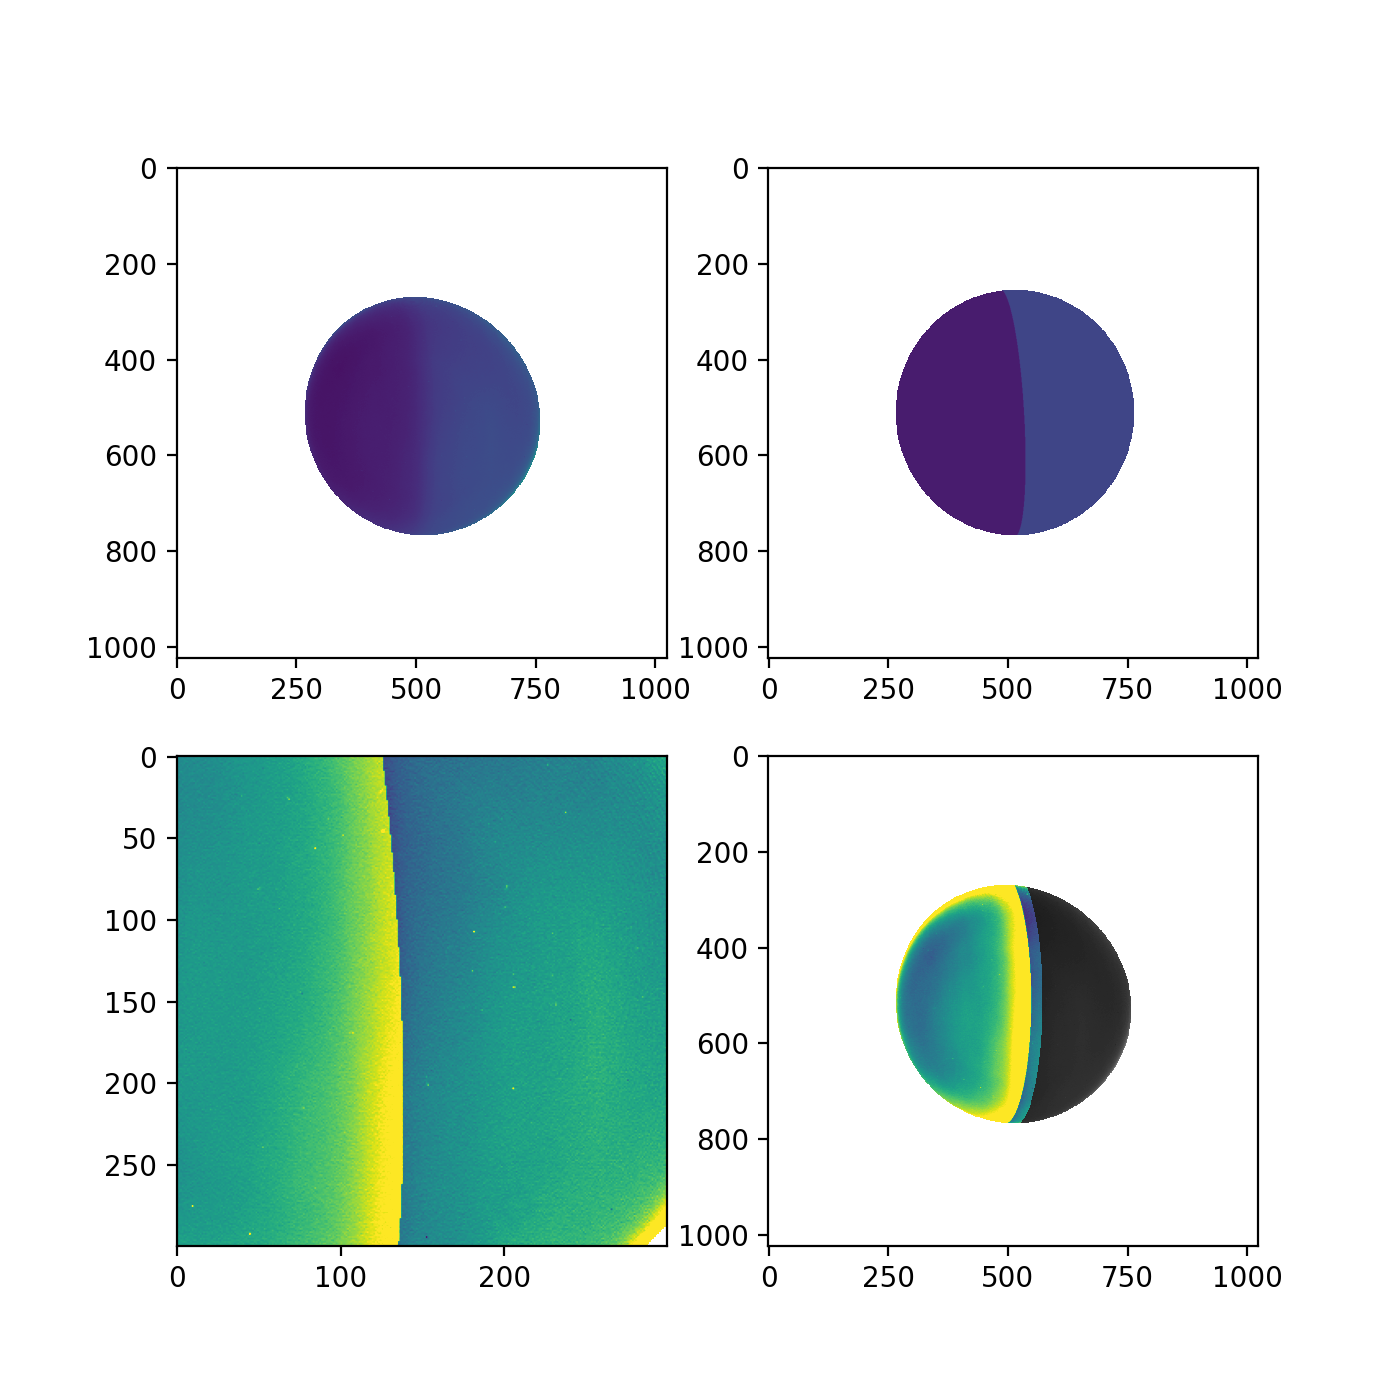

In [ ]:

a=-.5
b=1
c=1
d=-1
e=2
f=1
g=1

# cropim = np.where(np.isfinite(match),im,np.nan)
# part1 = (a+b*np.sin(np.radians(OGemisArray))**c)
# part1 = (a+b*(1-np.cos(np.radians(OGemisArray)))**c)
# part1 = (a+b*(np.sqrt(c**2 - np.sin(np.radians(OGemisArray))**2) - np.cos(np.radians(OGemisArray))))
# part1 = np.exp((np.sqrt(c**2 - np.sin(np.radians(OGemisArray))**2) - np.cos(np.radians(OGemisArray)))/e)
# part3 = (a+b*np.sin(np.radians(OGemisArray))**c)
# part4 = (a+b*(1-np.cos(np.radians(OGemisArray)))**c)

# part2 = (d+e*np.cos(np.radians(f*OGincArray))**g)

part1 = .4-np.cos(np.radians(1.*OGemisArray))**.5
part2 = np.cos(np.radians(1.2*OGincArray))
# part1 = 101.-100*np.exp(.01*np.cos(np.radians(1*OGemisArray)))
# part2 = np.full(np.shape(im),1)

# fit = match*part1*part2 + .04

# matchfunc = hemispheresim2d((OGlatArray,OGlonArray),*simfit[0])
matchfunc = hemispheresim2d((OGlatArray,OGlonArray),*simfit.x)

guessim = hemispheresim2d((OGlatArray,OGlonArray),*mlatazampest)

# testim = hemispheresim2d((OGlatArray,OGlonArray),-4.92021946158,360 - 119.37694175148422,6.993645303525426)
# testim = hemispheresim2d((OGlatArray,OGlonArray),-4.92021946158,258,6.993645303525426)
testim = hemispheresim2d((OGlatArray,OGlonArray),-4.92021946158,258,0)

# matchfit = hemispheresim2d((OGlatArray,OGlonArray),*popt2)

# matchfit2 = hemispheresim2d((OGlatArray,OGlonArray),*simfit.x)

plt.close(fig)
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(7,7))

# ax1.imshow(cropim)
ax2.imshow(matchfunc,vmin=np.nanmin(im),vmax=np.nanmax(im))
# ax2.imshow(match,vmin=np.nanmin(im),vmax=np.nanmax(im))
# ax2.imshow(matchfit2,vmin=np.nanmin(im),vmax=np.nanmax(im))
# ax3.imshow(matchfit,vmin=np.nanmin(im),vmax=np.nanmax(im))
ax1.imshow(im)
ax3.imshow((im-matchfunc)[400:700,400:700],vmin=-3,vmax=3)
# ax4.imshow(im-guessim,vmin=-2,vmax=2)
ax4.imshow(im-testim,vmin=-2,vmax=2)
ax4.imshow(np.where(OGlatArray>0,im,np.nan),cmap='gray')
# ax4.imshow(im/testim,vmin=0.9,vmax=1.1)

# ax4.imshow(cropim,vmin=np.nanmin(im),vmax=np.nanmax(im))
# ax2.imshow(fit,vmin=np.nanmin(cropim),vmax=np.nanmax(cropim))
# ax3.plot(cropim[:,450])
# ax3.plot(cropim[:,550])
# ax3.plot(fit[:,450])
# ax3.plot(fit[:,560])
# ax4.plot(part1[:,560])
# ax4.plot(part2[:,560])
# ax4.plot(part3[:,560])
# ax4.plot(part4[:,560])
# ax4.plot(part4[:,560]+part2[:,560])

In [ ]:
costlat = []

for i in range(-20,20):

    costlat.append(np.sum(hemispheresimls((i,180,0))**2)/2)

In [ ]:
mincostlat = np.argmin(costlat) - 20

In [ ]:
mincostlat,costlat

(-20,
 [243159.4587625665,
  247822.92914031632,
  253344.61893622184,
  259577.4991801096,
  267050.84663331433,
  275591.7940825715,
  285825.5736226745,
  297221.6849818838,
  310502.63584404724,
  325059.614183284,
  341826.770607113,
  359666.94502357685,
  379753.32053723384,
  401170.5625058364,
  424263.1614432049,
  447910.1464311789,
  473036.20311136555,
  498153.77458781085,
  524349.1092402209,
  550441.4160931786,
  577131.1617570736,
  603921.4396988113,
  630557.6680693541,
  658294.2214526174,
  685556.6140540021,
  712927.815094053,
  740944.5585508796,
  768599.2654277508,
  795982.7513650914,
  823372.7579862099,
  851051.9291090107,
  878176.8885145837,
  904985.5800952065,
  931483.3654355243,
  957635.0478041722,
  983357.5411058394,
  1008736.2634315783,
  1033732.6362060413,
  1058288.1676292575,
  1081894.9058891363])

In [ ]:
ssclon = label['Caminfo']['Geometry']['SubSpacecraftLongitude']
mlatshift = 90.*np.sin(np.radians(5.))/2.


In [ ]:
ssclon,mlatshift

(250.04505006737, 3.9220084236446175)

In [ ]:
costaz = []

for i in range(36):
    templat = mincostlat + mlatshift*np.cos(np.radians(ssclon-i*10))
    print(templat)
    costaz.append(np.sum(hemispheresimls((templat,i*10,5))**2)/2)

-21.338507677221937
-21.958332986732813
-22.51865533940612
-23.00244962409267
-23.39501599626398
-23.6844265253498
-23.861887618872643
-23.92200721130547
-23.862958599254192
-23.686535944915942
-23.39809976136862
-23.006414036093563
-22.523379941650706
-21.963674224572657
-21.344303259848072
-20.684086320823273
-20.00308376510464
-19.321987510743764
-18.661492322778063
-18.041667013267187
-17.48134466059388
-16.99755037590733
-16.60498400373602
-16.3155734746502
-16.138112381127357
-16.07799278869453
-16.137041400745808
-16.313464055084058
-16.60190023863138
-16.993585963906437
-17.476620058349294
-18.036325775427343
-18.655696740151928
-19.315913679176727
-19.99691623489536
-20.678012489256236


In [ ]:
costaz

[242894.10115769075,
 242975.8146549088,
 243110.5625276376,
 243226.05411775946,
 243436.28798119255,
 243699.85180071,
 244043.62336740928,
 244476.96198707583,
 244961.85606746646,
 245468.96767438928,
 246012.02590086873,
 246538.69997985408,
 246993.58774835692,
 247378.40794095673,
 247617.25334329385,
 247662.87614066375,
 247520.76796469424,
 247197.5196914816,
 246800.0147807366,
 246157.5525238232,
 245526.773715328,
 244835.7291305711,
 243995.4660451565,
 243295.54930293676,
 242650.51720929216,
 242137.83420160098,
 241807.88267448015,
 241547.0055005722,
 241507.1801749133,
 241572.56298755578,
 241691.23940991014,
 241974.68659466432,
 242199.92604800814,
 242430.08520781927,
 242569.98336825846,
 242771.27531457855]

In [ ]:
np.nanmean(np.where(np.logical_and(OGlatArray<0,OGlatArray>-30),im,np.nan)),np.nanmean(np.where(np.logical_and(OGlatArray>0,OGlatArray<30),im,np.nan))

(12.607126981866966, 14.846504252450305)

In [ ]:
len(np.where(im>12)[0])

191258

In [ ]:
bins = np.linspace(np.nanmin(im),np.nanmax(im),100)
brighthist = []

for i,j in enumerate(bins):

    brighthist.append(len(np.where(np.logical_and(im>j,im<bins[i+1]))[0]))

    if i == len(bins)-2:
        brighthist.append(0)
        break

np.nanmin(im),np.nanmax(im),bins,brighthist

(10.348304525198346,
 41.164981709911814,
 array([10.34830453, 10.65958409, 10.97086366, 11.28214323, 11.5934228 ,
        11.90470236, 12.21598193, 12.5272615 , 12.83854107, 13.14982063,
        13.4611002 , 13.77237977, 14.08365934, 14.3949389 , 14.70621847,
        15.01749804, 15.32877761, 15.64005717, 15.95133674, 16.26261631,
        16.57389588, 16.88517544, 17.19645501, 17.50773458, 17.81901415,
        18.13029371, 18.44157328, 18.75285285, 19.06413242, 19.37541198,
        19.68669155, 19.99797112, 20.30925069, 20.62053025, 20.93180982,
        21.24308939, 21.55436896, 21.86564852, 22.17692809, 22.48820766,
        22.79948723, 23.11076679, 23.42204636, 23.73332593, 24.0446055 ,
        24.35588506, 24.66716463, 24.9784442 , 25.28972377, 25.60100333,
        25.9122829 , 26.22356247, 26.53484204, 26.8461216 , 27.15740117,
        27.46868074, 27.77996031, 28.09123987, 28.40251944, 28.71379901,
        29.02507858, 29.33635814, 29.64763771, 29.95891728, 30.27019685,
        3

In [ ]:
intinc = np.round(OGincArray)
intemis = np.round(OGemisArray)


<IPython.core.display.Javascript object>


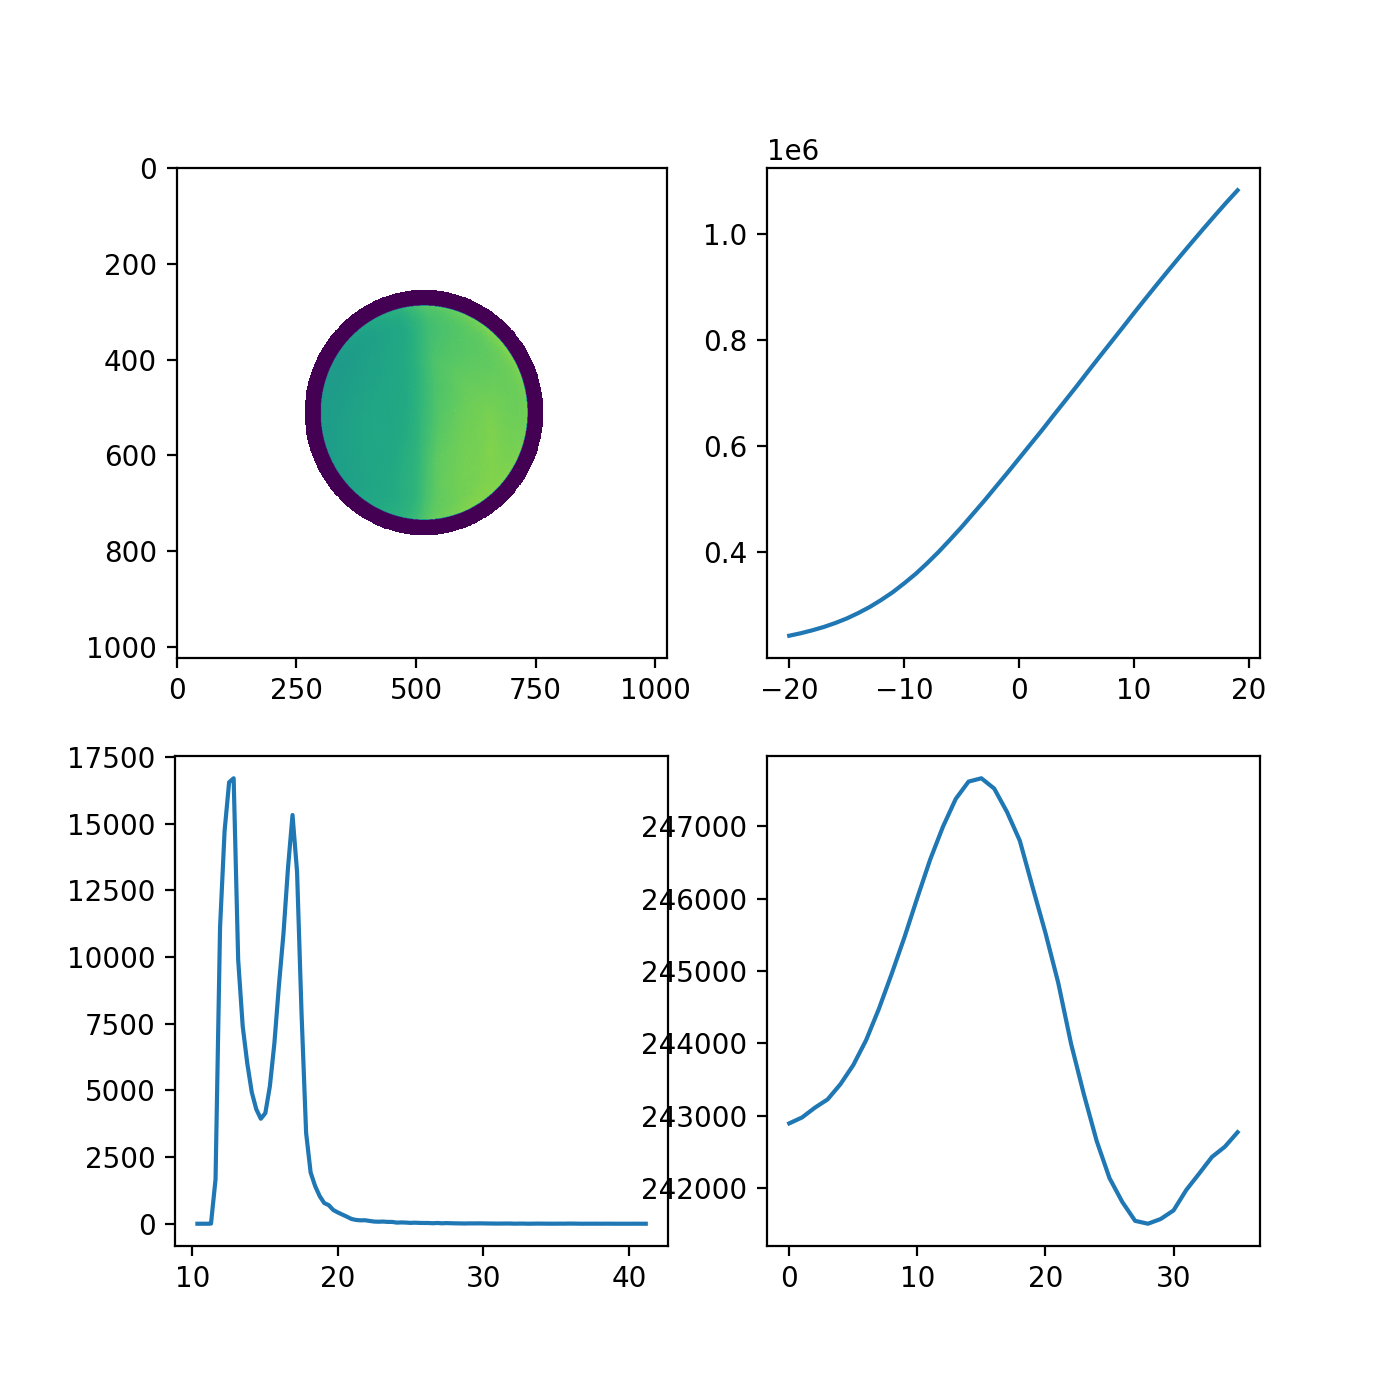

In [ ]:
plt.close(fig)
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(7,7))

ax1.imshow(np.where(OGemisArray>60,0,im))
ax2.plot(range(-20,20),costlat)
ax3.plot(bins,brighthist)
ax4.plot(range(36),costaz)
# ax4.imshow(np.where(np.isfinite(im),np.cos(np.radians(OGemisArray)),np.nan))
# ax4.plot(np.cos(np.radians(OGemisArray))[nanmask])

<IPython.core.display.Javascript object>


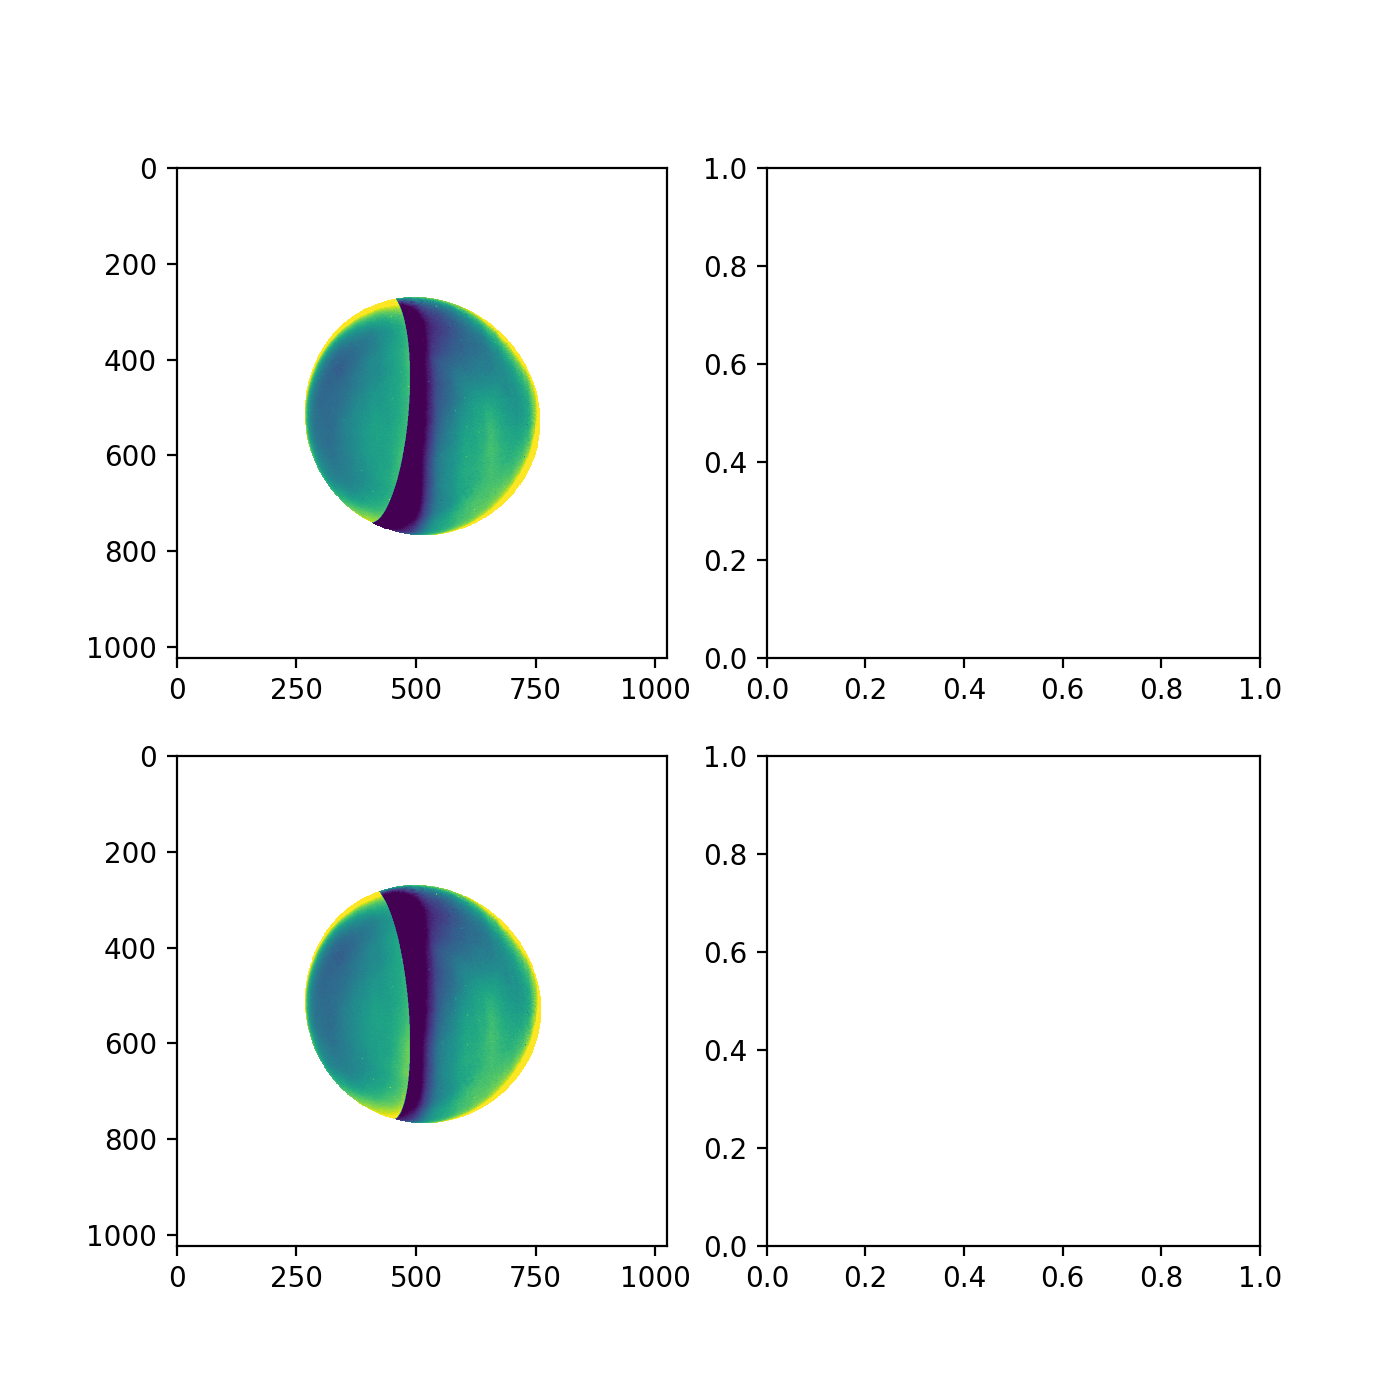

In [ ]:
plt.close(fig)
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(7,7))

ax1.imshow(im-hemispheresim2d((OGlatArray,OGlonArray),mincostlat + mlatshift*np.cos(np.radians(ssclon-10)),10,5),vmin=-2,vmax=2)
# ax2.imshow(im-hemispheresim2d((OGlatArray,OGlonArray),mincostlat + mlatshift*np.cos(np.radians(ssclon-270)),270,5),vmin=-2,vmax=2)
ax3.imshow(im-hemispheresim2d((OGlatArray,OGlonArray),mincostlat + mlatshift*np.cos(np.radians(ssclon-155)),155,5),vmin=-2,vmax=2)
# ax4.imshow(im-hemispheresim2d((OGlatArray,OGlonArray),mincostlat + mlatshift*np.cos(np.radians(ssclon-350)),350,5),vmin=-2,vmax=2)

In [ ]:
mincostaz = np.nanargmin(costaz) * 10



guesslat = mincostlat + mlatshift*np.cos(np.radians(ssclon-mincostaz))

mlatazampest = guesslat,mincostaz,5.

simfit2 = optimize.least_squares(hemispheresimls, mlatazampest, diff_step=1000)
# simfit = optimize.least_squares(hemispheresimls, mlatazampest, diff_step=1000, x_scale=[1,36,1],
#                                bounds=([-10,0,0],[10,360,10]))

In [ ]:
simfit2

 active_mask: array([0., 0., 0.])
        cost: 2612.682321385228
         fun: array([-1.58054921, -1.92571888, -1.31030093, ...,  0.        ,
        0.        ,  0.        ])
        grad: array([ 0.33333928, -0.18867493, -0.48022041])
         jac: array([[-0.00023277,  0.00036437,  0.        ],
       [-0.00023277,  0.00036437,  0.        ],
       [-0.00023277,  0.00036437,  0.        ],
       ...,
       [-0.        ,  0.        ,  0.        ],
       [-0.        ,  0.        ,  0.        ],
       [-0.        ,  0.        ,  0.        ]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 19
        njev: 3
  optimality: 0.4802204133185678
      status: 3
     success: True
           x: array([-16.99725492,  10.85818102,   9.55425663])

In [ ]:
simfit2.x, mlatazampest

(array([-16.99725492,  10.85818102,   9.55425663]),
 (-14.725637527874246, 10, 5.0))

In [ ]:
brighthist = np.asarray(brighthist)
peaks = find_peaks(brighthist,height=200)
lows = find_peaks(-1*brighthist,height=(-20000,-100))
peaks,lows

((array([ 8, 21]), {'peak_heights': array([16696., 15319.])}),
 (array([14, 36]), {'peak_heights': array([-3934.,  -127.])}))

In [ ]:
biim = np.copy(im)

for i,j in enumerate(im):
    for n,m in enumerate(j):
        if np.isfinite(m):
            if m>

array([], dtype=float64)

In [ ]:
window = 2
weights = brighthist[peaks[0][0]-window:peaks[0][0]+window]
weights2 = brighthist[peaks[0][1]-window:peaks[0][1]+window]

# weights -= np.min(weights)
lowmean = np.sum(bins[peaks[0][0]-window:peaks[0][0]+window]*weights) / np.sum(weights)
highmean = np.sum(bins[peaks[0][1]-window:peaks[0][1]+window]*weights2) / np.sum(weights2)

lowmean,highmean

(12.644324221194681, 16.755990791375883)

<IPython.core.display.Javascript object>


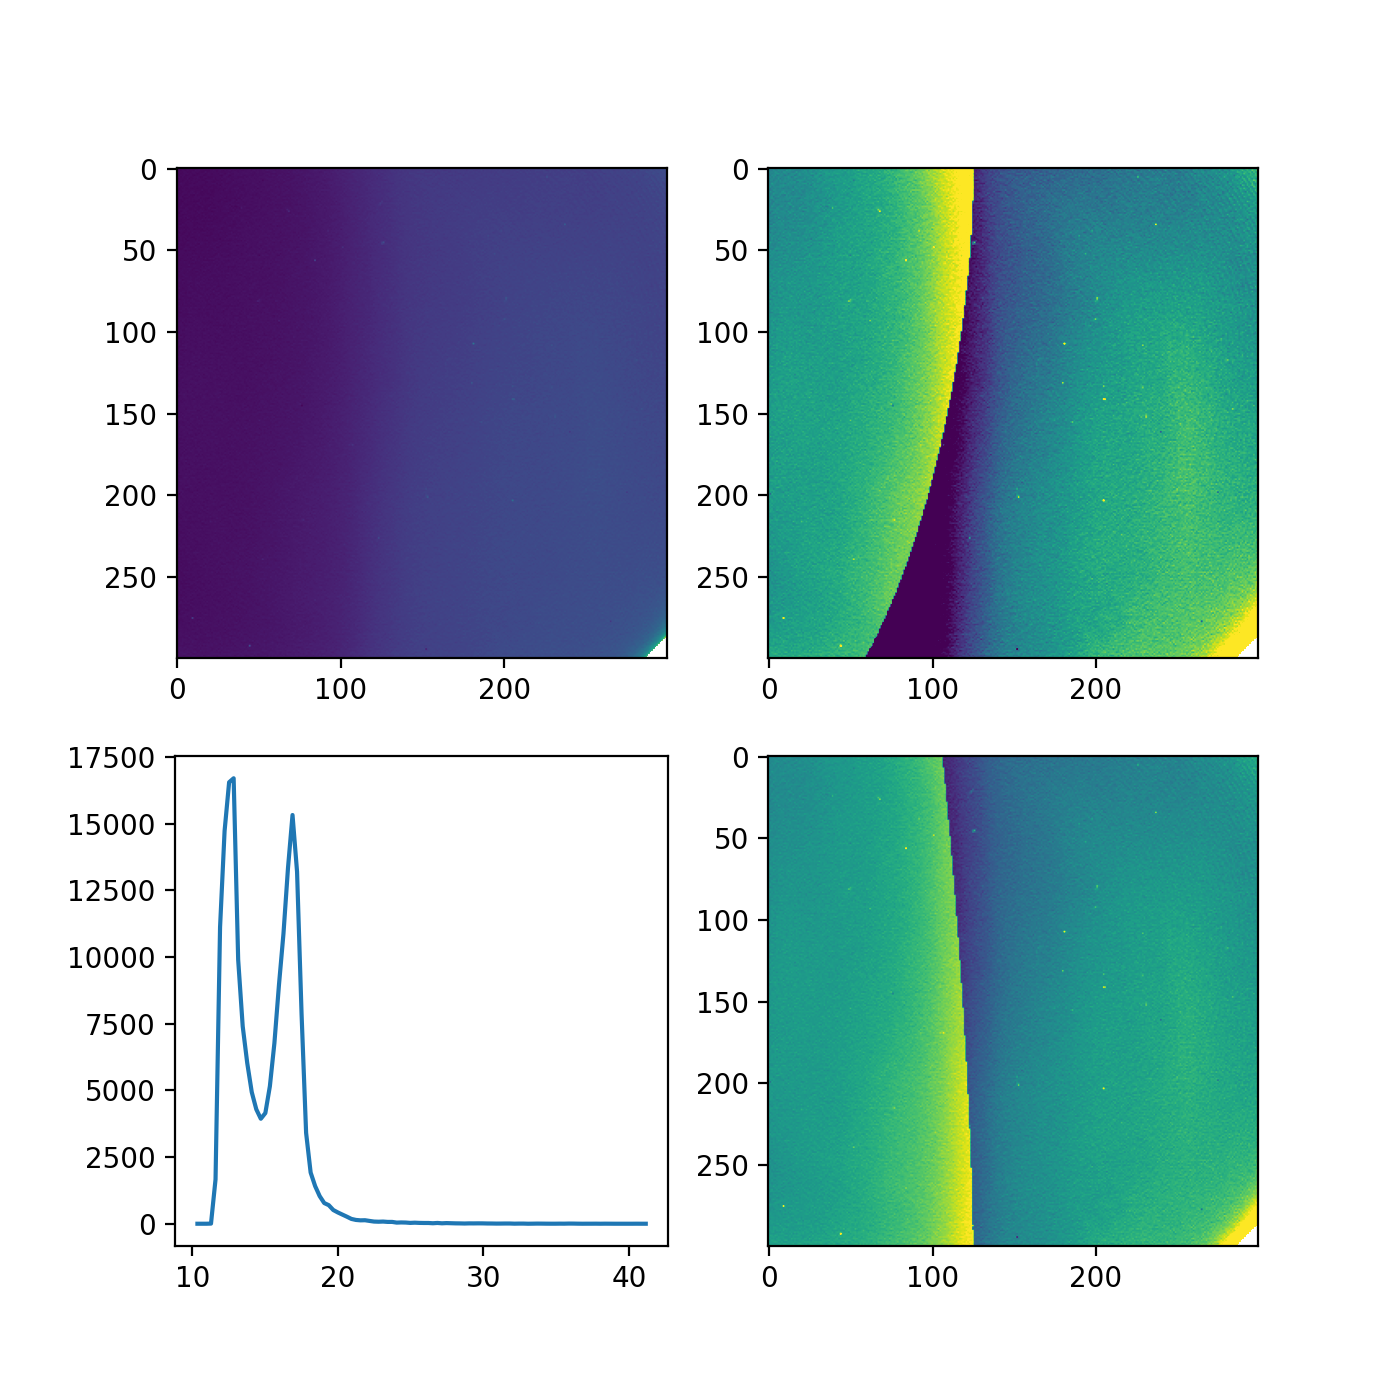

In [ ]:
plt.close(fig)
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(7,7))

# ax1.imshow(np.where(np.logical_and(im>bins[lows[0][0]-1],im<bins[lows[0][0]+2]),im,np.nan))
ax1.imshow(im[400:700,400:700])
ax2.imshow((im-hemispheresim2d((OGlatArray,OGlonArray),*simfit2.x))[400:700,400:700],vmin=-2,vmax=2)
ax3.plot(bins,brighthist)
ax4.imshow((im-hemispheresim2d((OGlatArray,OGlonArray),-3.28733099, 224.3792085 ,   10))[400:700,400:700],vmin=-3,vmax=3)

# ax4.imshow(np.where(np.isfinite(im),np.cos(np.radians(OGemisArray)),np.nan))
# ax4.plot(np.cos(np.radians(OGemisArray))[nanmask])

In [ ]:
bins[lows[0][0]],bins[lows[0][0]+1]

(14.706218470511363, 15.01749803803372)

In [ ]:
#mlat,az,amp
testvals = [-5,88,7]

# imsim = hemispheresim2d((OGlatArray,OGlonArray),*simfit.x)
imsim = hemispheresim2d((OGlatArray,OGlonArray),*testvals)

In [ ]:
#mlat,az,amp
testvals = [-5,240,25]

# imsim = hemispheresim2d((OGlatArray,OGlonArray),*simfit.x)
imsim = hemispheresim2d((OGlatArray,OGlonArray),*testvals)

imsimblur = np.where(np.isfinite(imsim),imsim,np.nanmean(imsim))
# avgblur = np.ones((49,49))
# imsimblur = signal.convolve2d(imsimblur, avgblur, boundary='symm', mode='same')
imsimblur = filters.gaussian(imsimblur, sigma=27)
imsimblur = np.where(np.isfinite(imsim),imsimblur,np.nan)


<IPython.core.display.Javascript object>


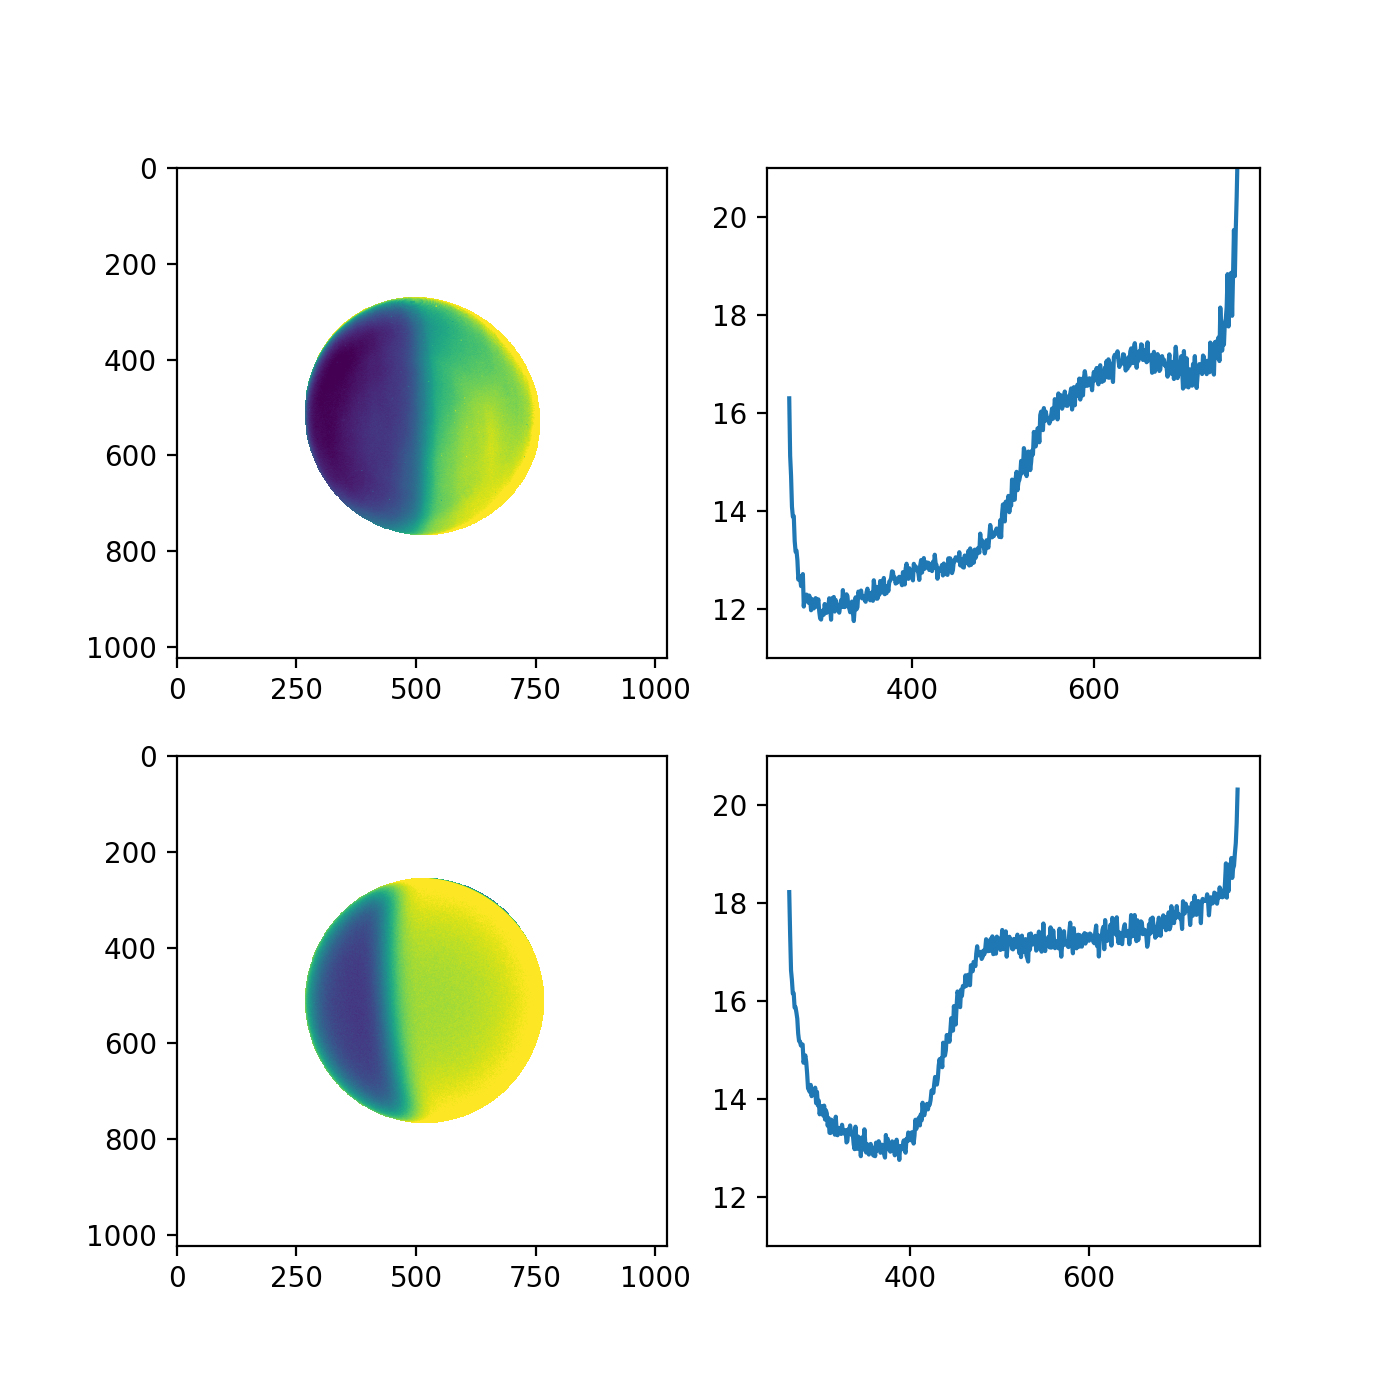

(11.0, 21.0)

In [ ]:
# stdev = np.nanstd(im[400:600,350:450])
noise = np.random.normal(0, .15, imsim.shape)

incdrop = np.where(OGincArray>100,(OGincArray-120)*(-1/20),1)
incdrop = np.where(OGincArray<100,1,incdrop)
incdrop = np.where(OGincArray>120,0,incdrop)
incdrop = np.where(np.isfinite(OGincArray),incdrop,np.nan)

emisrise = np.cos(np.radians(OGemisArray))**.08

multfact = incdrop/emisrise

totimsim = multfact*imsimblur + noise

plt.close(fig)
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(7,7))

# ax1.imshow(np.where(np.logical_and(im>bins[lows[0][0]-1],im<bins[lows[0][0]+2]),im,np.nan))

# ax3.imshow(imsimnoise)


# ax3.plot(imsimblur[500])
# ax3.plot(imsimblur[500]/np.cos(np.radians(OGemisArray[500]))**.08)
# ax3.set_ylim(10,20)
# ax4.imshow(imsimblur/np.cos(np.radians(OGemisArray))**2)
# ax4.plot(np.cos(np.radians(OGemisArray[500]))**.08)
# ax4.plot(np.cos(np.radians(OGincArray[500]))**.1)
# ax4.plot(OGincArray[500])
# ax4.plot(np.cos(np.radians(OGincArray[500]))**.1/np.cos(np.radians(OGemisArray[500]))**.3)


ax1.imshow(mapArray.astype(np.float),vmin=12,vmax=18)
ax2.plot(mapArray.astype(np.float)[500])
# ax3.imshow(totimsim,vmin=np.nanmin(im),vmax=np.nanmax(im))
ax3.imshow(totimsim,vmin=12,vmax=18)
ax4.plot(totimsim[500])

ax2.set_ylim(11,21)
ax4.set_ylim(11,21)

In [ ]:
# np.savetxt(directorystr + 'imsim-10_75_10.txt', totimsim)

In [ ]:
directorystr = "MT3more/"
# fname = 'N1466071301_1'
# fname = 'N1477225220_2'
fname = 'N1842357655_1'

filepath = directorystr + fname

a_file = open(filepath + "_incidence.txt", "r")
list_of_lists = [(line.strip()).split() for line in a_file]
a_file.close()
incArray = np.asarray(list_of_lists[4:])
nanIncArray = np.where(np.logical_or(incArray == 'NULL', incArray == 'HRS'), np.nan, incArray)
OGincArray =nanIncArray.astype(np.float)

a_file = open(filepath + "_emission.txt", "r")
list_of_lists = [(line.strip()).split() for line in a_file]
a_file.close()
emisArray = np.asarray(list_of_lists[4:])
nanEmisArray = np.where(np.logical_or(emisArray == 'NULL', emisArray == 'HRS'), np.nan, emisArray)
OGemisArray = nanEmisArray.astype(np.float)

a_file = open(filepath + "_cal_lat.txt", "r")
list_of_lists = [(line.strip()).split() for line in a_file]
a_file.close()
latArray = np.asarray(list_of_lists[4:])
nanLatArray = np.where(np.logical_or(latArray == 'NULL', latArray == 'HRS'), np.nan, latArray)
OGlatArray = nanLatArray.astype(np.float)

a_file = open(filepath + "_cal_lon.txt", "r")
list_of_lists = [(line.strip()).split() for line in a_file]
a_file.close()
lonArray = np.asarray(list_of_lists[4:])
nanLonArray = np.where(np.logical_or(lonArray == 'NULL', lonArray == 'HRS'), np.nan, lonArray)
OGlonArray = nanLonArray.astype(np.float)

# a_file = open(filepath + "_PREMAP.txt", "r")
# a_file = open(directorystr + "Limb/" + fname + "_limbavg.txt", "r")
a_file = open(directorystr + "Limb/" + fname + "_custom4.txt", "r")

list_of_lists = [(line.strip()).split() for line in a_file]
a_file.close()
# mapArray = np.asarray(list_of_lists[4:])
mapArray = np.asarray(list_of_lists)
mapArray = np.where(np.logical_or(mapArray == 'NULL', mapArray == 'HRS'), np.nan, mapArray)
OGim = mapArray.astype(np.float)

nansinimage = np.logical_and(OGincArray<89,~np.isfinite(OGim))

if len(np.where(nansinimage)[0]) > 0:
    OGim[nansinimage] = np.interp(np.flatnonzero(nansinimage), np.flatnonzero(~nansinimage),OGim[~nansinimage])
#     OGim[nansinimage] = np.nanmean(im)
    print("Bad pixels in image: {0}".format(len(np.where(nansinimage)[0])))

label = pvl.load(filepath + "_INFO.pvl")
try:
    pixres = label['Caminfo']['Geometry']['PixelResolution']
    crad = label['Caminfo']['Geometry']['CenterRadius']
    numring = int(np.round(2*np.pi*crad/pixres))
    SSL = 360 - label['Caminfo']['Geometry']['SubSolarLongitude']
except:
    numring = len(OGim)


# label = pvl.load(directorystr + fname + "_INFO.pvl")
# try:
#     SSL = 360 - label['Caminfo']['Geometry']['SubSolarLongitude']
#     offset2 = azimuth2 - SSL
# #     stdoffset2 = stdazimuth2 - SSL
# except:
#     SSL = -1
#     offset2 = -1
# #     stdoffset2 = -1

time = label['Caminfo']['Geometry']['EndTime']

# try:
#     pixres = label['Caminfo']['Geometry']['PixelResolution']
#     crad = label['Caminfo']['Geometry']['CenterRadius']
#     numring = int(np.round(2*np.pi*crad/pixres))
# except:
#     numring = len(OGim)


bins = np.linspace(np.nanmin(OGim),np.nanmax(OGim),100)
brighthist = []

for i,j in enumerate(bins):

    brighthist.append(len(np.where(np.logical_and(OGim>j,OGim<bins[i+1]))[0]))

    if i == len(bins)-2:
        brighthist.append(0)
        break

brighthist = np.asarray(brighthist)
peaks = find_peaks(brighthist,height=5000)
lows = find_peaks(-1*brighthist,height=(-20000,-1000))
print("Peaks: {0}, Lows: {1}".format(peaks,lows))

window = 2
weights = brighthist[peaks[0][0]-window:peaks[0][0]+window]
weights2 = brighthist[peaks[0][1]-window:peaks[0][1]+window]

# weights -= np.min(weights)
lowmean = np.sum(bins[peaks[0][0]-window:peaks[0][0]+window]*weights) / np.sum(weights)
highmean = np.sum(bins[peaks[0][1]-window:peaks[0][1]+window]*weights2) / np.sum(weights2)

print("Lowmean: {0}, Highmean: {1}".format(lowmean,highmean))

Bad pixels in image: 1
Peaks: (array([], dtype=int64), {'peak_heights': array([], dtype=float64)}), Lows: (array([26, 29]), {'peak_heights': array([-1482., -1593.])})


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
label['Caminfo']['Geometry']['SubSpacecraftLongitude'],label['Caminfo']['Geometry']['SubSolarLongitude']

(332.24118991671, 37.69139390892)

In [ ]:

def tosphcoordarray(lons,lats,semimaj,semimin):
    r = (semimaj*semimin)/np.sqrt((semimin*np.cos(np.radians(lats)))**2 + (semimaj*np.sin(np.radians(lats)))**2)
    sphcoords = []
    for i,j in enumerate(lons):
        sphcoords.append([j,lats[i],r[i]])

    return sphcoords


def planefit(abcd):
    a,b,c,d = abcd
    return (a*cartcoords[:,0] + b*cartcoords[:,1] + c*cartcoords[:,2] + d)/np.sqrt(a*a + b*b + c*c)

def planefit2(abd):
    a,b,d = abd
    c = np.sqrt(1 - a*a - b*b)
    return (a*cartcoords[:,0] + b*cartcoords[:,1] + c*cartcoords[:,2] + d)


def find_nearest(array, value):
    return (np.abs(array - value)).argmin()

def cartosph(cart):
    sph = []

    for i in cart:
        r = np.sqrt(i[0]**2 + i[1]**2 + i[2]**2)
        theta = -np.degrees(np.arccos(i[2]/r)) + 90
        phi = np.degrees(np.arctan(i[1]/i[0]))
        if i[0] < 0: phi += 180

        sph.append([phi,theta,r])

    return sph

def cartosphrot(cart, tiltaz):
    sph = []

    for i in cart:
        r = np.sqrt(i[0]**2 + i[1]**2 + i[2]**2)
        theta = -np.degrees(np.arccos(i[2]/r)) + 90
        phi = np.degrees(np.arctan(i[1]/i[0]))
        if i[0] < 0: phi += 180
        phi += tiltaz #rotate phi back

        if phi > 360: phi -= 360
        elif phi < 0: phi += 360

        sph.append([phi,theta,r])

    return sph

def sphtocar(sph):
    cart = []

    for i in sph:
        x = i[2]*np.cos(np.radians(i[0]))*np.sin(np.radians(-(i[1]-90)))
        y = i[2]*np.sin(np.radians(i[0]))*np.sin(np.radians(-(i[1]-90)))
        z = i[2]*np.cos(np.radians(-(i[1]-90)))

        cart.append([x,y,z])

    return cart


def hemispheresim2d2(latlon, tiltamp,tiltaz,meanlat,dark,bright):

    tiltaz = 360 - tiltaz + 180
    radtiltamp = np.radians(tiltamp)

    Ry = [[np.cos(radtiltamp), 0, -np.sin(radtiltamp)],
          [0,                  1, 0                  ],
          [np.sin(radtiltamp), 0, np.cos(radtiltamp) ]]

    azx = np.linspace(0,360,numring)
    azy = np.full(np.shape(azx),meanlat)

    azxro = azx - tiltaz

    sph_azro = [[j,azy[i],1] for i,j in enumerate(azxro)]

    car_azro = sphtocar(sph_azro)

    carnpcoordsazro2 = [np.matmul(Ry, x2) for x2 in car_azro]

    sphaz = cartosphrot(carnpcoordsazro2,tiltaz)

    latbound = np.asarray(sphaz)[:,1]
    lonbound = np.asarray(sphaz)[:,0]

    minlat = np.nanmin(latbound)
    maxlat = np.nanmax(latbound)

    latarr,lonarr = latlon

#     match = np.where(latarr<minlat,0.046,0.06)
    match = np.where(latarr<minlat,dark,bright)

    match = np.where(np.isfinite(latarr),match,np.nan)

    for i,j in enumerate(latarr):
        for n,m in enumerate(j):
            if np.isfinite(m):
                if m < maxlat and m > minlat:
                    if m < latbound[find_nearest(lonbound,lonarr[i,n])]:
                        match[i,n] = dark


    return match

def hemispheresim2d2switch(latlon, tiltamp,tiltaz,meanlat,bright,dark):

    tiltaz = 360 - tiltaz + 180
    radtiltamp = np.radians(tiltamp)

    Ry = [[np.cos(radtiltamp), 0, -np.sin(radtiltamp)],
          [0,                  1, 0                  ],
          [np.sin(radtiltamp), 0, np.cos(radtiltamp) ]]

    azx = np.linspace(0,360,numring)
    azy = np.full(np.shape(azx),meanlat)

    azxro = azx - tiltaz

    sph_azro = [[j,azy[i],1] for i,j in enumerate(azxro)]

    car_azro = sphtocar(sph_azro)

    carnpcoordsazro2 = [np.matmul(Ry, x2) for x2 in car_azro]

    sphaz = cartosphrot(carnpcoordsazro2,tiltaz)

    latbound = np.asarray(sphaz)[:,1]
    lonbound = np.asarray(sphaz)[:,0]

    minlat = np.nanmin(latbound)
    maxlat = np.nanmax(latbound)

    latarr,lonarr = latlon

#     match = np.where(latarr<minlat,0.046,0.06)
    match = np.where(latarr<minlat,dark,bright)

    match = np.where(np.isfinite(latarr),match,np.nan)

    for i,j in enumerate(latarr):
        for n,m in enumerate(j):
            if np.isfinite(m):
                if m < maxlat and m > minlat:
                    if m < latbound[find_nearest(lonbound,lonarr[i,n])]:
                        match[i,n] = dark


    return match

def hemispheresim2d2grad(latlon, tiltamp,tiltaz,meanlat,dark,bright):

    tiltaz = 360 - tiltaz + 180
    while tiltaz >= 360: tiltaz -= 360
    while tiltaz < 0: tiltaz += 360

    radtiltamp = np.radians(tiltamp)

    Ry = [[np.cos(radtiltamp), 0, -np.sin(radtiltamp)],
          [0,                  1, 0                  ],
          [np.sin(radtiltamp), 0, np.cos(radtiltamp) ]]

    azx = np.linspace(0,360,numring)
    azy = np.full(np.shape(azx),meanlat)

    azxro = azx - tiltaz

    sph_azro = [[j,azy[i],1] for i,j in enumerate(azxro)]

    car_azro = sphtocar(sph_azro)

    carnpcoordsazro2 = [np.matmul(Ry, x2) for x2 in car_azro]

    sphaz = cartosphrot(carnpcoordsazro2,tiltaz)

    latbound = np.asarray(sphaz)[:,1]
    lonbound = np.asarray(sphaz)[:,0]

    minlat = np.nanmin(latbound)
    maxlat = np.nanmax(latbound)

    latarr,lonarr = latlon

#     match = np.where(latarr<minlat,0.046,0.06)
    match = np.empty(np.shape(latarr))

    translat = 12.

#     difffrac = (bright - dark)/2./translat
    diff2 = (bright-dark)/2.
    meanval = (bright+dark)/2.
    angfac = np.pi/2./translat

    for i,j in enumerate(latarr):
        for n,m in enumerate(j):
            if np.isfinite(m):
                templat = latbound[find_nearest(lonbound,lonarr[i,n])]
                if m < templat-translat:
                    match[i,n] = dark
                elif m > templat+translat:
                    match[i,n] = bright
                else:
#                     match[i,n] = meanval + (m-templat)*difffrac
                    match[i,n] = meanval + diff2*np.sin((m-templat)*angfac)


    match = np.where(np.logical_or(match<dark,match>bright),np.nan,match)

    return match

def hemispheresim2d2switchgrad(latlon, tiltamp,tiltaz,meanlat,bright,dark):

    tiltaz = 360 - tiltaz + 180
    while tiltaz >= 360: tiltaz -= 360
    while tiltaz < 0: tiltaz += 360

    radtiltamp = np.radians(tiltamp)

    Ry = [[np.cos(radtiltamp), 0, -np.sin(radtiltamp)],
          [0,                  1, 0                  ],
          [np.sin(radtiltamp), 0, np.cos(radtiltamp) ]]

    azx = np.linspace(0,360,numring)
    azy = np.full(np.shape(azx),meanlat)

    azxro = azx - tiltaz

    sph_azro = [[j,azy[i],1] for i,j in enumerate(azxro)]

    car_azro = sphtocar(sph_azro)

    carnpcoordsazro2 = [np.matmul(Ry, x2) for x2 in car_azro]

    sphaz = cartosphrot(carnpcoordsazro2,tiltaz)

    latbound = np.asarray(sphaz)[:,1]
    lonbound = np.asarray(sphaz)[:,0]

    minlat = np.nanmin(latbound)
    maxlat = np.nanmax(latbound)

    latarr,lonarr = latlon

#     match = np.where(latarr<minlat,0.046,0.06)
    match = np.empty(np.shape(latarr))

    translat = 12.

#     difffrac = (bright - dark)/2./translat
    diff2 = (bright-dark)/2.
    meanval = (bright+dark)/2.
    angfac = np.pi/2./translat

    for i,j in enumerate(latarr):
        for n,m in enumerate(j):
            if np.isfinite(m):
                templat = latbound[find_nearest(lonbound,lonarr[i,n])]
                if m < templat-translat:
                    match[i,n] = dark
                elif m > templat+translat:
                    match[i,n] = bright
                else:
#                     match[i,n] = meanval + (m-templat)*difffrac
                    match[i,n] = meanval + diff2*np.sin((m-templat)*angfac)

    match = np.where(np.logical_or(match>dark,match<bright),np.nan,match)

    return match


def boundaryring(latlon, tiltamp,tiltaz,meanlat):

    tiltaz = 360 - tiltaz + 180
    while tiltaz >= 360: tiltaz -= 360
    while tiltaz < 0: tiltaz += 360

    radtiltamp = np.radians(tiltamp)

    Ry = [[np.cos(radtiltamp), 0, -np.sin(radtiltamp)],
          [0,                  1, 0                  ],
          [np.sin(radtiltamp), 0, np.cos(radtiltamp) ]]

    azx = np.linspace(0,360,numring)
    azy = np.full(np.shape(azx),meanlat)

    azxro = azx - tiltaz

    sph_azro = [[j,azy[i],1] for i,j in enumerate(azxro)]

    car_azro = sphtocar(sph_azro)

    carnpcoordsazro2 = [np.matmul(Ry, x2) for x2 in car_azro]

    sphaz = cartosphrot(carnpcoordsazro2,tiltaz)

    latbound = np.asarray(sphaz)[:,1]
    lonbound = np.asarray(sphaz)[:,0]

    minlat = np.nanmin(latbound)
    maxlat = np.nanmax(latbound)

    latarr,lonarr = latlon

    match = np.full(np.shape(latarr),False)

    for i,j in enumerate(latbound):
        match = np.where(np.logical_and(np.abs(latarr-latbound[i])<.5,np.abs(lonarr-lonbound[i])<.5),True,match)


    return match


def tiltlonlat(latlon, tiltamp,tiltaz):

    latarr,lonarr = latlon

    flatarr = np.ravel(latarr)
    flonarr = np.ravel(lonarr)

    nanmask = np.isnan(flatarr)
    flatarr[nanmask] = 1
    flonarr[nanmask] = 1

    tiltaz = 360 - tiltaz + 180
    while tiltaz >= 360: tiltaz -= 360
    while tiltaz < 0: tiltaz += 360

    radtiltamp = np.radians(tiltamp)

    Ry = [[np.cos(radtiltamp), 0, -np.sin(radtiltamp)],
          [0,                  1, 0                  ],
          [np.sin(radtiltamp), 0, np.cos(radtiltamp) ]]

    azxro = flonarr - tiltaz

    sph_azro = [[j,flatarr[i],1] for i,j in enumerate(azxro)]

    car_azro = sphtocar(sph_azro)

    carnpcoordsazro2 = [np.matmul(Ry, x2) for x2 in car_azro]

    sphaz = cartosphrot(carnpcoordsazro2,tiltaz)

    outflat = np.asarray(sphaz)[:,1]
    outflon = np.asarray(sphaz)[:,0]

    outflat[nanmask] = np.nan
    outflon[nanmask] = np.nan

    outlat = np.copy(latarr)
    outlon = np.copy(lonarr)
    h = len(latarr)
    for i,j in enumerate(outflat):
        if np.isfinite(j):
            outlat[i//h,i%h] = j
            outlon[i//h,i%h] = outflon[i]

    return outlat,outlon

<IPython.core.display.Javascript object>


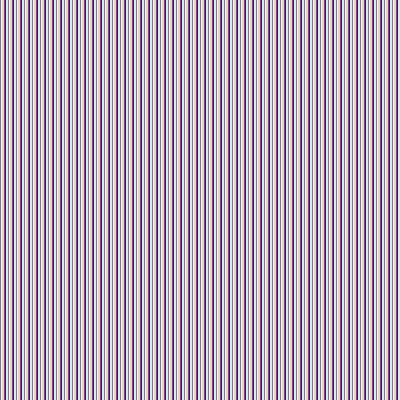

In [ ]:
plt.close(fig)
fig, ax = plt.subplots(figsize=(4,4))

ax.plot(bins,brighthist)

In [ ]:
lowmean = .0505
highmean = .06

In [ ]:
import numpy as np
import scipy as sp
import scipy.ndimage

sigma=3.0                 # standard deviation for Gaussian kernel
truncate=4.0               # truncate filter at this many sigmas

# U=sp.randn(10,10)          # random array...
# U[U>2]=np.nan              # ...with NaNs for testing

testvals = [5,300,5]
U = hemispheresim2d2switchgrad((OGlatArray,OGlonArray),*testvals,lowmean,highmean)
# U = np.where(Z>highmean,np.nan,Z)

V=U.copy()
V[np.isnan(U)]=0
VV=sp.ndimage.gaussian_filter(V,sigma=sigma,truncate=truncate)

W=0*U.copy()+1
W[np.isnan(U)]=0
WW=sp.ndimage.gaussian_filter(W,sigma=sigma,truncate=truncate)

Z=VV/WW



/home/csnell/anaconda3/envs/isis/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


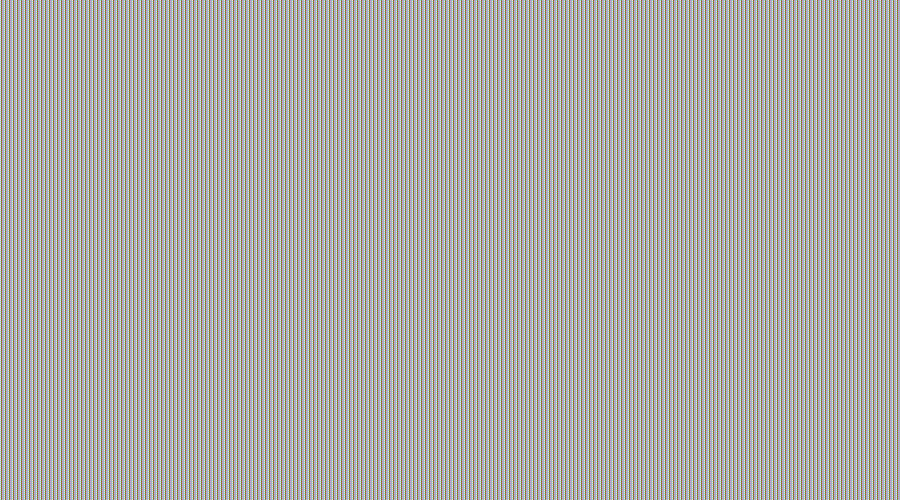

In [ ]:
plt.close(fig)
fig, (ax,ax2) = plt.subplots(1,2,figsize=(9,5))

ax.imshow(U)
# ax2.imshow(Z)
ax2.imshow(np.where(np.isfinite(U),Z,np.nan))

In [ ]:
# testvals = [8,400,23]
# testvals = [7,120,-5]
# testvals = [12,360,12]
# testvals = [10,90,12] #sus on later image
# testvals = [10,270,12] #also sus

#sim images use west longitude for az

testvals = [3,160,30]
# testvals = [3,340,30]




imsim = hemispheresim2d2switchgrad((OGlatArray,OGlonArray),*testvals,lowmean,highmean)


# imsimblur = np.where(np.isfinite(imsim),imsim,np.nanmean(imsim))
# # avgblur = np.ones((49,49))
# # imsimblur = signal.convolve2d(imsimblur, avgblur, boundary='symm', mode='same')
# imsimblur = filters.gaussian(imsimblur, sigma=27)
# imsimblur = np.where(np.isfinite(imsim),imsimblur,np.nan)

noise = np.random.normal(0, .01*np.nanmean(OGim), imsim.shape)

incdrop = np.where(OGincArray>100,(OGincArray-120)*(-1/20),1)
incdrop = np.where(OGincArray<100,1,incdrop)
incdrop = np.where(OGincArray>120,0,incdrop)
incdrop = np.where(np.isfinite(OGincArray),incdrop,np.nan)

emisrise = np.cos(np.radians(OGemisArray))**.08

multfact = incdrop/emisrise

imsimnoise = imsim + noise
totimsim = multfact*imsim + noise



In [ ]:
ring = boundaryring((OGlatArray,OGlonArray),*testvals)

<IPython.core.display.Javascript object>


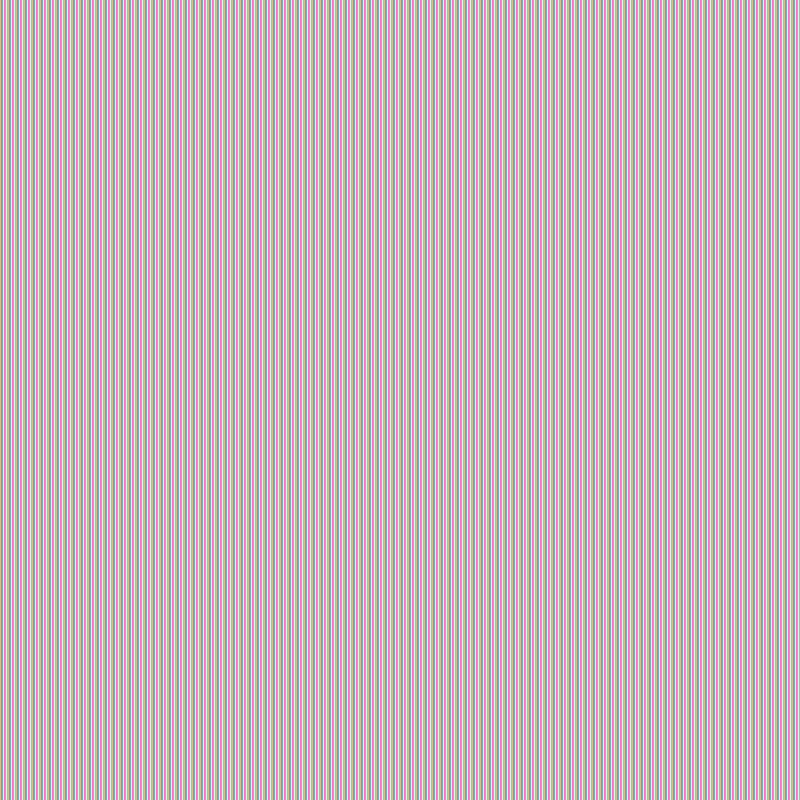

In [ ]:
# transmatch = np.where(np.isfinite(OGim),(imsimnoise/6*(5+np.cos(np.radians(OGincArray)))),np.nan)
# transmatch = np.where(np.isfinite(OGim),imsimnoise,np.nan)
transmatch = np.where(np.isfinite(OGlatArray),imsimnoise,np.nan)


plt.close(fig)
fig, ((ax,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))

s = 200
e = 800
d = .04
b = .07
ax.imshow(OGim[s:e,s:e],vmin=d,vmax=b)
# ax.imshow(np.where(OGlatArray > 80,np.nan,OGim)[300:700,300:700],vmin=d,vmax=b)

# ax2.imshow(imsimnoise)
# ax2.imshow(imsim[s:e,s:e],vmin=d,vmax=b)

zerons = np.where(np.abs(OGlatArray)<1,np.nan,transmatch)
zerons = np.where(np.abs(OGlatArray-20)<1,np.nanmax(transmatch),zerons)
zerons = np.where(np.abs(OGlatArray+20)<1,np.nanmin(transmatch),zerons)
zerons = np.where(ring,np.nan,zerons)

ax2.imshow(zerons[s:e,s:e],vmin=d,vmax=b)
# ax2.imshow(OGlatArray[s:e,s:e],vmin=d,vmax=b)

# ax2.imshow(imsimnoise[s:e,s:e],vmin=d,vmax=b)

# ax3.imshow(totimsim,vmin=np.nanmin(OGim),vmax=np.nanmax(OGim))
# ax3.imshow(ring)
ax3.imshow(np.where(ring,np.nan,OGim)[s:e,s:e],vmin=d,vmax=b)

# ax4.imshow(totimsim-OGim,vmin=-3,vmax=3)

# ax4.imshow((OGim-transmatch)[s:e,s:e])

SSL2 = label['Caminfo']['Geometry']['SubSolarLongitude']
SCL = label['Caminfo']['Geometry']['SubSpacecraftLongitude']

lonsanity = np.where(np.abs(OGlonArray[s:e,s:e]-SCL)<2,np.nanmin(OGim[s:e,s:e]),OGim[s:e,s:e])
lonsanity = np.where(np.abs(OGlonArray[s:e,s:e]-SSL2)<2,np.nanmax(OGim[s:e,s:e]),lonsanity)

ax4.imshow(lonsanity,vmin=d,vmax=b)

# ax4.imshow(multfact)

line = 220

# ax4.plot(totimsim[line])
# ax4.plot(OGim[line],'k')
# ax4.plot(imsimnoise[line])

# ax4.plot(totimsim[:,line])
# ax4.plot((totimsim/5*(5+np.cos(np.radians(OGincArray))))[:,line])
# ax4.plot((imsimnoise/6*(5+np.cos(np.radians(OGincArray))))[:,line])


# ax4.plot(OGim[:,line],'k')
# ax4.plot((5*OGim/(5+np.cos(np.radians(OGincArray))))[:,line])

# ax2.imshow(np.where(np.isfinite(OGim),np.cos(np.radians(OGincArray)),np.nan))
# ax2.imshow(5*OGim/(5+np.cos(np.radians(OGincArray))))

In [ ]:
OGlonArray[s:e,s:e][300,200],OGlatArray[s:e,s:e][250,300],OGlatArray[s:e,s:e][350,300]

(34.55515, -2.610475, 51.10502)

In [ ]:
SSL

322.30860609108

In [ ]:
print("SubSpacecraft Lon: {} \nSubSolar Lon: {}".format(label['Caminfo']['Geometry']['SubSpacecraftLongitude'],label['Caminfo']['Geometry']['SubSolarLongitude']))

SubSpacecraft Lon: 332.24118991671 
SubSolar Lon: 37.69139390892


In [ ]:
np.nansum(OGim-transmatch)

-65.55737530520813

In [ ]:
# testvals = [8,400,23]
testvals = [7,160,5]
# testvals = [12,360,12]



imsim = hemispheresim2d2switchgrad((OGlatArray,OGlonArray),*testvals,lowmean,highmean)


# imsimblur = np.where(np.isfinite(imsim),imsim,np.nanmean(imsim))
# # avgblur = np.ones((49,49))
# # imsimblur = signal.convolve2d(imsimblur, avgblur, boundary='symm', mode='same')
# imsimblur = filters.gaussian(imsimblur, sigma=27)
# imsimblur = np.where(np.isfinite(imsim),imsimblur,np.nan)

noise = np.random.normal(0, .01*np.nanmean(OGim), imsim.shape)

incdrop = np.where(OGincArray>100,(OGincArray-120)*(-1/20),1)
incdrop = np.where(OGincArray<100,1,incdrop)
incdrop = np.where(OGincArray>120,0,incdrop)
incdrop = np.where(np.isfinite(OGincArray),incdrop,np.nan)

emisrise = np.cos(np.radians(OGemisArray))**.08

multfact = incdrop/emisrise

imsimnoise = imsim + noise
totimsim = multfact*imsim + noise


In [ ]:
medim = signal.medfilt2d(OGim,3)

In [ ]:
latr = np.round(OGlatArray)
lonr = np.round(OGlonArray)

if np.abs(np.nanmin(OGlatArray))<np.abs(np.nanmax(OGlatArray)):
    normlon = np.round(OGlonArray[np.where(OGlatArray==np.nanmin(OGlatArray))][0])
else:
    normlon = np.round(OGlonArray[np.where(OGlatArray==np.nanmax(OGlatArray))][0])

normlon=355
vertstrip = np.abs(lonr-normlon)<5

normim = np.copy(medim)/np.nanmean(medim)
divim = np.copy(medim)/np.nanmean(medim)

for i in range(-90,91):
    samp = normim[np.logical_and(latr==i,np.abs(lonr-normlon)<5)]
    if len(samp) > 0:
        div = np.nanmean(samp)
        normim = np.where(latr==i,normim/div,normim)
        divim = np.where(latr==i,div,divim)

    else:
        normim = np.where(latr==i,np.nan,normim)
        divim = np.where(latr==i,np.nan,divim)

normim = np.where(np.isfinite(OGim),normim,np.nan)
divim = np.where(np.isfinite(OGim),divim,np.nan)

/home/csnell/anaconda3/envs/isis/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


In [ ]:
uni = np.unique(lonr,return_counts=True)
mode = np.argmax(uni[1])


normlon,uni,mode,uni[0][mode]

(355,
 (array([ 0.,  1.,  2., ..., nan, nan, nan]),
  array([131, 269, 266, ...,   1,   1,   1])),
 335,
 336.0)

In [ ]:
tilted = tiltlonlat((OGlatArray,OGlonArray),testvals[0],testvals[1])

<IPython.core.display.Javascript object>


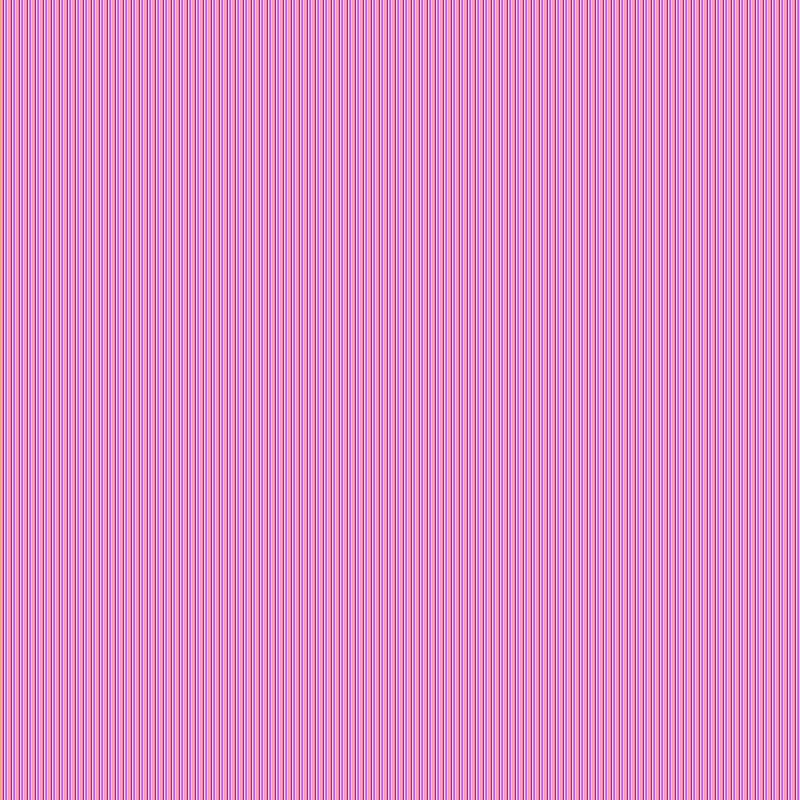

In [ ]:
transmatch = np.where(np.isfinite(OGim),imsimnoise,np.nan)


plt.close(fig)
fig, ((ax,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))

s = 300
e = 700
d = .04
b = .07
# ax.imshow(OGim[s:e,s:e],vmin=d,vmax=b)
ax.imshow(medim[s:e,s:e],vmin=d,vmax=b)

# ax.imshow(np.where(OGlatArray > 80,np.nan,OGim)[300:700,300:700],vmin=d,vmax=b)

# ax2.imshow(imsimnoise)
# ax2.imshow(imsim[s:e,s:e],vmin=d,vmax=b)

# ax2.imshow(transmatch[s:e,s:e],vmin=d,vmax=b)
# ax3.imshow(totimsim,vmin=np.nanmin(OGim),vmax=np.nanmax(OGim))
# ax3.imshow(ring)
# ax3.imshow(np.where(ring,np.nan,OGim)[s:e,s:e],vmin=d,vmax=b)

# ax3.imshow(normim[s:e,s:e],vmin=.9,vmax=1.1)
ax3.imshow(divim[s:e,s:e])

# ax3.imshow(np.where(lonr==357,1,np.nan)[s:e,s:e])


# ax4.imshow(totimsim-OGim,vmin=-3,vmax=3)

# ax4.imshow((OGim-transmatch)[s:e,s:e])

ax2.imshow(OGlatArray)
ax4.imshow(np.where(np.abs(lonr-340)<3,-5,(OGlatArray-tilted[0])))

# ax2.imshow(OGlonArray)
# ax4.imshow(OGlonArray-tilted[1])

<IPython.core.display.Javascript object>


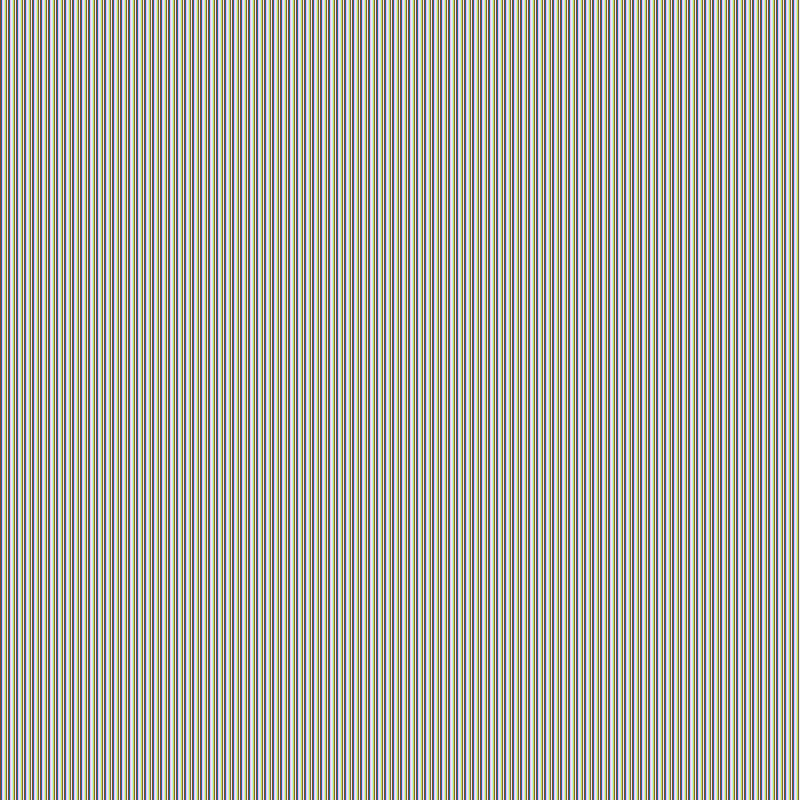

In [ ]:
plt.close(fig)
fig, ((ax,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))

lonplot = np.arange(360)

latcheck = 30

ax.plot(OGlonArray[latr==latcheck],(OGlatArray-tilted[0])[latr==latcheck],'.')
ax.plot(lonplot,7*np.sin(np.radians(lonplot-120)))

ax2.plot(OGlonArray[latr==latcheck],tilted[0][latr==latcheck],'.')
ax2.plot(lonplot,latcheck - 7*np.sin(np.radians(lonplot-(110-90+90*np.sin(np.radians(latcheck*90/(90-3.5)))))))
ax2.plot(lonplot,latcheck - 7*np.sin(np.radians(lonplot-(110-90+latcheck*90/(90-3.5)))))
ax2.plot(lonplot,latcheck - 7*np.sin(np.radians(lonplot-110)))



<IPython.core.display.Javascript object>


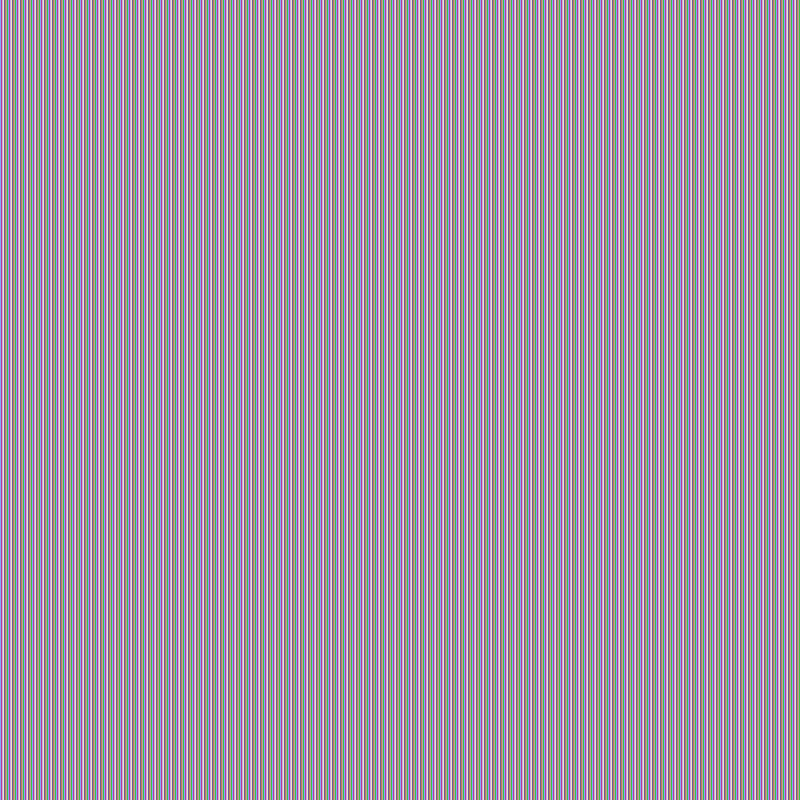

In [ ]:
plt.close(fig)
fig, ((ax,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))

testx = np.linspace(0,10,21)
testx2 = np.linspace(0,10,101)

tempy = np.asarray([1,1,1,1,1,1,1.01,1.05,1.15,1.3,1.5,1.7,1.85,1.95,1.99,2,2,2,2,2,2])
testy = interp1d(testx,tempy, kind='cubic')(testx2)
tempy2 = np.asarray([1.1,1.18,1.245,1.293,1.329,1.356,1.377,1.392,1.404,1.411,1.414,1.411,1.404,1.392,1.377,1.356,1.329,1.293,1.245,1.18,1.1])
testy2 = interp1d(testx,tempy2, kind='cubic')(testx2)

# im1 = np.asarray([testy,testy,testy,testy,testy,testy,testy,testy,testy,testy,testy])
# im2 = np.asarray([testy2,testy2,testy2,testy2,testy2,testy2,testy2,testy2,testy2,testy2,testy2])
im1 = np.full((101,101),testy)
im2 = np.full(101,testy2)

ax.plot(testx2,testy)
ax.plot(testx2,testy2)
ax.plot(testx2,np.gradient(im1)[1][0]*10+1)


ax2.plot(testx2,testy/(testy2-1.))
ax2.plot(testx2,np.gradient(im1/(testy2-1.))[1][0]*4+6)

# ax3.imshow(im1,cmap = 'gray')
ax3.imshow(np.gradient(im1)[1])
# ax4.imshow(im1/(testy2-1),cmap = 'gray',vmin=2.5,vmax=7.5)
ax4.imshow(np.gradient(im1/(testy2-1.))[1],vmin=-.15,vmax=.15)

# ax.set_ylim(0,4)
# ax2.set_ylim(0,.5)

In [ ]:
np.argmax(np.gradient(im1)[1][0][20:70])+20,np.argmax(np.gradient(im1/(testy2-1.09))[1][0][20:70])+20

(50, 52)

In [ ]:
testvals1 = [3,120,25]
imsim = hemispheresim2d2grad((OGlatArray,OGlonArray),*testvals1,lowmean,highmean)
noise = np.random.normal(0, .01*np.nanmean(OGim), imsim.shape)
imsimnoise = imsim + noise

testvals2 = [3,120,5]
imsim2 = hemispheresim2d2grad((OGlatArray,OGlonArray),*testvals2,lowmean,highmean)
noise2 = np.random.normal(0, .01*np.nanmean(OGim), imsim2.shape)
imsimnoise2 = imsim2 + noise2

<IPython.core.display.Javascript object>


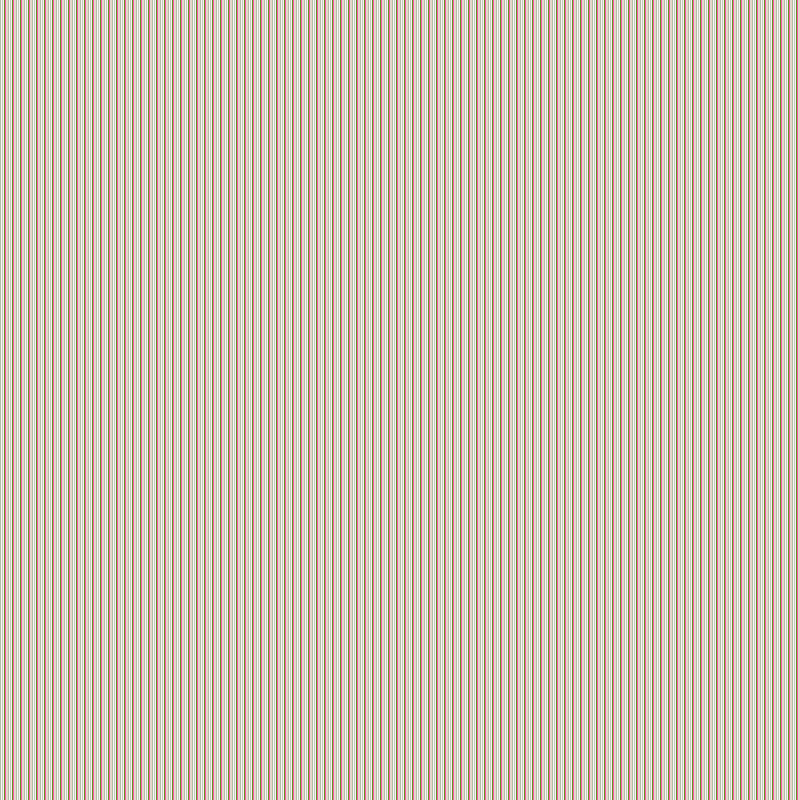

In [ ]:
totimsim1 = np.where(np.isfinite(OGim),(imsimnoise*6/(5+np.cos(np.radians(OGemisArray)))),np.nan)
totimsim2 = np.where(np.isfinite(OGim),(imsimnoise/6*(5+np.cos(np.radians(OGemisArray)))),np.nan)
totimsim3 = np.where(np.isfinite(OGim),(imsimnoise2*6/(5+np.cos(np.radians(OGemisArray)))),np.nan)
totimsim4 = np.where(np.isfinite(OGim),(imsimnoise2/6*(5+np.cos(np.radians(OGemisArray)))),np.nan)

plt.close(fig)
fig, ((ax,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))

low = .04
high = .08

ax.imshow(totimsim1,vmin=low,vmax=high)
ax2.imshow(totimsim2,vmin=low,vmax=high)
ax3.imshow(totimsim3,vmin=low,vmax=high)
ax4.imshow(totimsim4,vmin=low,vmax=high)

N1842357655_1 [490, 489, 487, 486, 484, 482, 481, 481, 477, 476, 476, 475, 475, 474, 473, 472, 470, 470, 467, 466, 465, 465, 464, 463, 462, 461, 460, 460, 460, 460, 460, 459, 458, 456, 456, 455, 456, 457, 458, 457, 456, 455, 455, 454, 454, 454, 454, 454, 453, 453, 453, 453, 452, 451, 451, 451, 451, 451, 451, 449, 448, 448, 449, 449, 449, 449, 449, 449, 449, 450, 450, 450, 450, 450, 450, 450, 450, 451, 451, 452, 452, 453, 453, 453, 453, 453, 452, 452, 453, 453, 454, 455, 455, 456, 456, 456, 458, 458, 460, 463] [598, 596, 594, 593, 591, 588, 586, 585, 582, 580, 579, 577, 575, 573, 571, 569, 567, 565, 563, 561, 559, 557, 555, 553, 551, 549, 546, 545, 543, 541, 539, 537, 535, 533, 531, 529, 527, 525, 523, 521, 519, 517, 515, 513, 510, 509, 507, 505, 503, 501, 499, 497, 495, 493, 491, 489, 487, 485, 483, 481, 479, 478, 475, 473, 471, 470, 468, 465, 463, 461, 459, 457, 455, 453, 452, 450, 448, 446, 443, 442, 439, 437, 435, 434, 432, 430, 428, 426, 424, 422, 420, 418, 416, 414, 412, 411, 408,

<IPython.core.display.Javascript object>


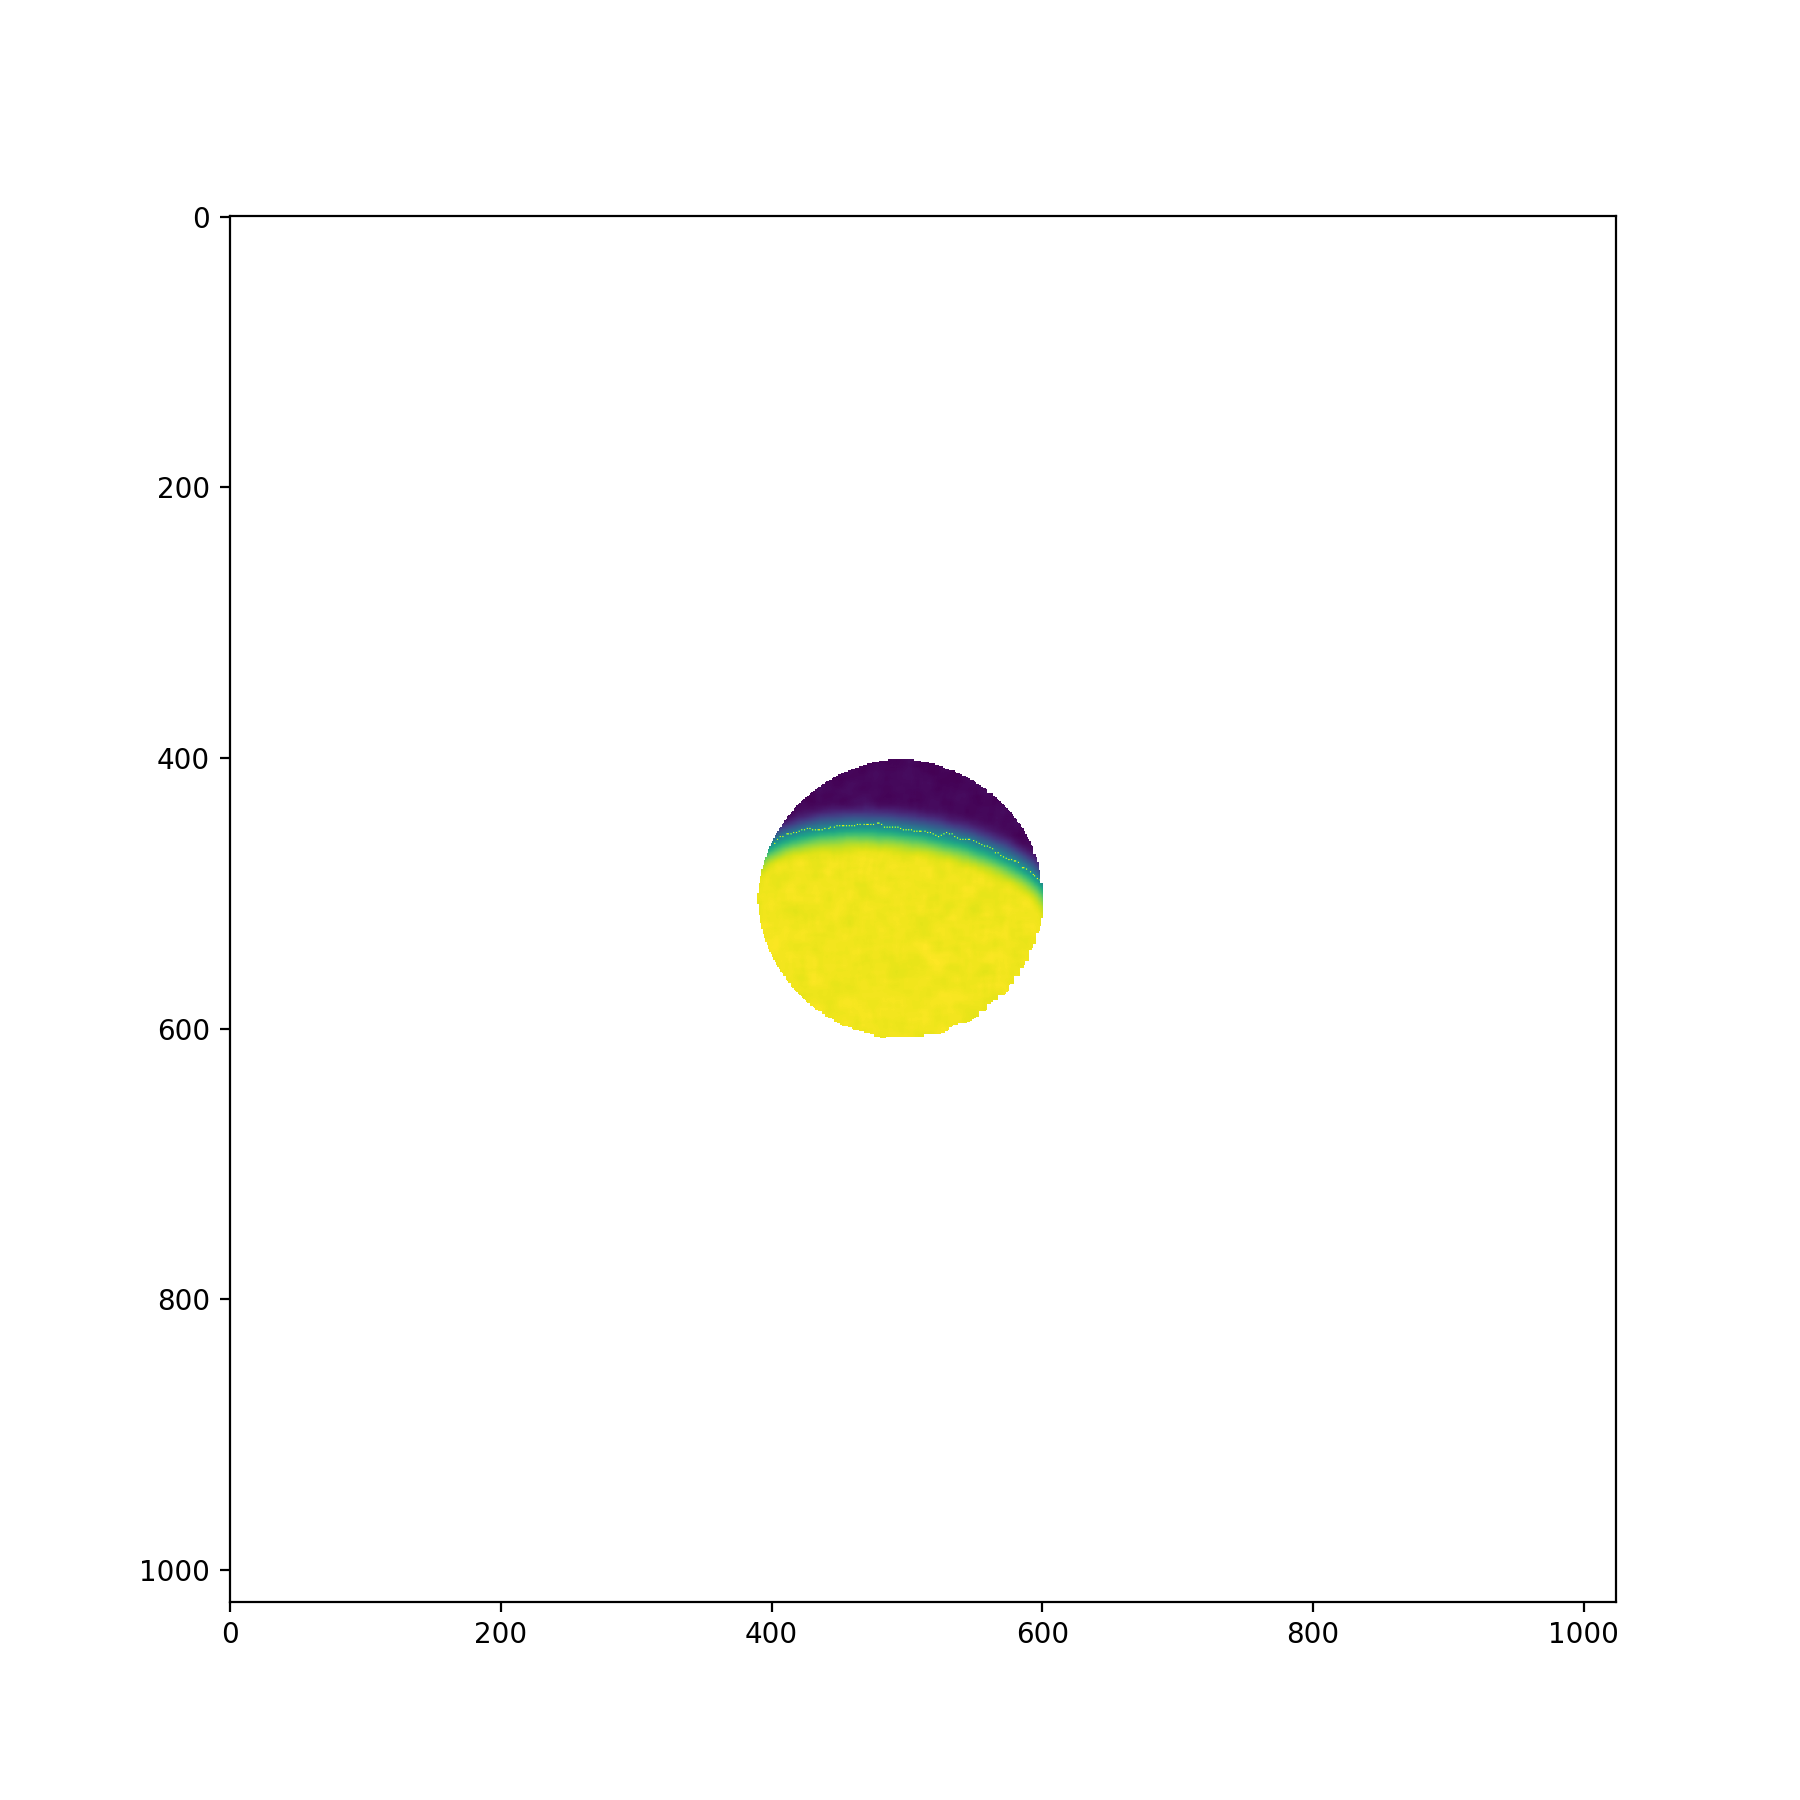

In [ ]:
#amp,az,mlat
blat = -5
testvals = [5,240,blat]
# blat = 32
# testvals = [18,0,blat]


#original
# imsim = hemispheresim2d2((OGlatArray,OGlonArray),*testvals,lowmean,highmean)
# imsim = hemispheresim2d2switch((OGlatArray,OGlonArray),*testvals,lowmean,highmean)

# imsimblur = np.where(np.isfinite(imsim),imsim,np.nanmean(imsim))
# # avgblur = np.ones((49,49))
# # imsimblur = signal.convolve2d(imsimblur, avgblur, boundary='symm', mode='same')
# imsimblur = filters.gaussian(imsimblur, sigma=27)
# imsimblur = np.where(np.isfinite(imsim),imsimblur,np.nan)

# noise = np.random.normal(0, .15, imsim.shape)

# # incdrop = np.where(OGincArray>100,(OGincArray-120)*(-1/20),1)
# # incdrop = np.where(OGincArray<100,1,incdrop)
# # incdrop = np.where(OGincArray>120,0,incdrop)
# # incdrop = np.where(np.isfinite(OGincArray),incdrop,np.nan)

# # emisrise = np.cos(np.radians(OGemisArray))**.08

# # multfact = incdrop/emisrise

# multfact = 1.

# totimsim = multfact*imsimblur + noise


#with new grad match
# imsim = hemispheresim2d2switchgrad((OGlatArray,OGlonArray),*testvals,lowmean,highmean)

# # imsimblur = np.where(np.isfinite(imsim),imsim,np.nanmean(imsim))
# # # avgblur = np.ones((49,49))
# # # imsimblur = signal.convolve2d(imsimblur, avgblur, boundary='symm', mode='same')
# # imsimblur = filters.gaussian(imsimblur, sigma=27)
# # imsimblur = np.where(np.isfinite(imsim),imsimblur,np.nan)

# noise = np.random.normal(0, .15, imsim.shape)

# incdrop = np.where(OGincArray>100,(OGincArray-120)*(-1/20),1)
# incdrop = np.where(OGincArray<100,1,incdrop)
# incdrop = np.where(OGincArray>120,0,incdrop)
# incdrop = np.where(np.isfinite(OGincArray),incdrop,np.nan)

# emisrise = np.cos(np.radians(OGemisArray))**.08

# multfact = incdrop/emisrise
# # multfact = 1.

# totimsim = multfact*imsim + noise


imsim = hemispheresim2d2grad((OGlatArray,OGlonArray),*testvals,lowmean,highmean)

# imsimblur = np.where(np.isfinite(imsim),imsim,np.nanmean(imsim))
# # avgblur = np.ones((49,49))
# # imsimblur = signal.convolve2d(imsimblur, avgblur, boundary='symm', mode='same')
# imsimblur = filters.gaussian(imsimblur, sigma=27)
# imsimblur = np.where(np.isfinite(imsim),imsimblur,np.nan)

noise = np.random.normal(0, .01*np.nanmean(OGim), imsim.shape)

imsimnoise = imsim + noise

strength = 1

# totimsim = np.where(np.isfinite(OGim),(imsimnoise/6*(5+np.cos(np.radians(OGincArray)))),np.nan)
# totimsim = np.where(np.isfinite(OGim),(imsimnoise*6/(5+np.cos(np.radians(OGemisArray)))),np.nan)
# totimsim = np.where(np.isfinite(OGim),(imsimnoise/6*(5+np.cos(np.radians(OGemisArray)))),np.nan)
# totimsim = np.where(np.isfinite(OGim),(imsimnoise/(strength+np.cos(np.radians(OGemisArray)))/(strength+np.cos(np.radians(OGincArray)))),np.nan)#recreates!
# totimsim = np.where(np.isfinite(OGim),(imsimnoise*(strength+np.cos(np.radians(OGemisArray)))*(strength+np.cos(np.radians(OGincArray)))),np.nan)#recreates!


im = np.copy(imsimnoise)
# im = np.copy(totimsim)

nansinimage = np.logical_and(OGincArray<89,~np.isfinite(im))

if len(np.where(nansinimage)[0]) > 0:
    im[nansinimage] = np.interp(np.flatnonzero(nansinimage), np.flatnonzero(~nansinimage),im[~nansinimage])
#     im[nansinimage] = np.nanmean(im)
    print("Bad pixels in image: {0}".format(len(np.where(nansinimage)[0])))

imint = signal.medfilt2d(im,3)

avgblur = np.ones((9,9))

imin = signal.convolve2d(imint, avgblur, boundary='symm', mode='same')

kx = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
ky = np.array([[-1,-1,-1] ,[0,0,0], [1,1,1]])

xlattest = np.where(np.isfinite(imin),np.nan,np.nan)
ylattest = np.where(np.isfinite(imin),np.nan,np.nan)
xgradtest = np.where(np.isfinite(imin),np.nan,np.nan)
ygradtest = np.where(np.isfinite(imin),np.nan,np.nan)

for i,j in enumerate(imin):
    if i>0 and i<len(imin)-2:
        for n,m in enumerate(j):
            if np.isfinite(m) and n>0 and n<len(j)-2:
                imbox = np.array([[imin[i-1,n-1],imin[i-1,n],imin[i-1,n+1]],
                                  [imin[i,n-1],imin[i,n],imin[i,n+1]],
                                  [imin[i+1,n-1],imin[i+1,n],imin[i+1,n+1]]])
                if len(np.where(np.isfinite(imbox))[0])<9: continue
                else:
                    ylat = OGlatArray[i,n] - OGlatArray[i-1,n]
                    xlat = OGlatArray[i,n] - OGlatArray[i,n-1]

                    tot = np.sqrt(xlat**2 + ylat**2)
                    xlat = xlat/tot
                    ylat = ylat/tot

                    xlattest[i,n] = xlat
                    ylattest[i,n] = ylat

                    xgradtest[i,n] = np.sum(kx*imbox)
                    ygradtest[i,n] = np.sum(ky*imbox)


slope = np.where(np.isfinite(ylattest/xlattest),(ylattest/xlattest),np.nan)

xfact = np.where(np.isfinite(slope),1,np.nan)
xfact = np.where(xlattest<0,-1,xfact)
xfact = np.where(slope>100,0,xfact)
yfact = slope
yfact = np.where(xlattest<0,-slope,yfact)

normfact = np.abs(xfact) + np.abs(yfact)

xfact /= normfact
yfact /= normfact



slopegrad = xfact*xgradtest + yfact*ygradtest
slopegrad2 = np.abs(yfact*xgradtest + (-1*xfact)*ygradtest)

hemisphereSwitch = np.nanmean(np.where(OGlatArray>0,im,np.nan)) < np.nanmean(np.where(OGlatArray<0,im,np.nan))

if hemisphereSwitch:
    slopegrad *= -1

cropadgrad = np.where(np.logical_and(OGlatArray<blat+15,OGlatArray>blat-15),slopegrad,np.nan)
# cropadgrad = np.where(np.logical_and(OGlatArray<blat+10,OGlatArray>blat-10),slopegrad,np.nan)


# if hemisphereSwitch:
#     cropadgrad = np.where(np.logical_and(OGlatArray<23,OGlatArray>-7),slopegrad,np.nan)
# else:
#     cropadgrad = np.where(np.logical_and(OGlatArray<7,OGlatArray>-23),slopegrad,np.nan)

# denom = 4
# if fname == "N1845483375_1":
#     cropadgrad = np.where(np.logical_and(OGlatArray<15,OGlatArray>-5),slopegrad,np.nan)
#     denom = 7



# if fname.startswith("N18382") or fname.startswith("N1839"):
#     cropadgrad = np.where(np.logical_and(OGlatArray<20,OGlatArray>5),slopegrad,np.nan)
#     denom = 7
#     if fname == 'N1839513938_1':
#         slopegrad2 *= -100


cropadgradthresh = np.zeros(np.shape(cropadgrad))

croplat = np.where(np.isfinite(cropadgrad),OGlatArray,np.nan)
croplon = np.where(np.isfinite(cropadgrad),OGlonArray,np.nan)

latnum = len(np.where(np.isfinite(cropadgrad))[0])
latslicenum = 2500
latslices = latnum//latslicenum
if latnum%latslicenum > 0.5*latslicenum:
    latslices += 1

ind = croplat.argsort(axis=None)
xloc = ind//len(im)
yloc = ind%len(im[0])
flatlon = croplon.flatten()
if 360-np.nanmax(flatlon) < 10 and np.nanmin(flatlon) < 10:
    flatlon = np.where(flatlon>180,flatlon-360,flatlon)
lonslices = 100

slicearray = np.full(np.shape(im),np.nan)

for i in range(latslices):
    if i == latslices-1:
        latend = latnum
    else:
        latend = latslicenum*(i+1)

    ind2 = flatlon[ind[latslicenum*i:latend]].argsort(axis=None)
    lonnum = len(ind2)
    lonslicenum = lonnum//lonslices

    for j in range(lonslices):
        if j == lonslices-1:
            lonend = lonnum
        else:
            lonend = lonslicenum*(j+1)

        xtemp = xloc[latslicenum*i:latend][ind2[lonslicenum*j:lonend]]
        ytemp = yloc[latslicenum*i:latend][ind2[lonslicenum*j:lonend]]
        slicearray[xtemp,ytemp] = j


imlen = len(im)
imind = np.empty((2,imlen,imlen),dtype=int)

for i in range(imlen):
    for j in range(imlen):
        imind[0:2,i,j] = (i,j)


for i in range(lonslices):
    lonmask = slicearray == i

    num = len(cropadgrad[lonmask])//denom #larger denominator seems better for later images with weaker boundaries

    ind = np.argpartition(cropadgrad[lonmask], -num)[-num:] #locates num brightest pixels

    cropadgradthresh[imind[0][lonmask][ind],imind[1][lonmask][ind]] = 1

edge = np.where(np.isfinite(cropadgrad),cropadgradthresh,np.nan)
sobelthresh = np.copy(edge)

meanx = []
meany = []

for i in range(lonslices):

    lonmask = slicearray == i

    tempmean = np.nanmean(sobelthresh[lonmask])

    if tempmean > 0:
        lonslice = np.where(lonmask,sobelthresh,np.nan)
        points = np.where(lonslice==1)

        weights = cropadgrad[points]
        weights -= np.min(weights)
        meanx.append(np.sum(points[0] * weights) / np.sum(weights))
        meany.append(np.sum(points[1] * weights) / np.sum(weights))
    else:
        meanx.append(np.nan)
        meany.append(np.nan)


meanx = np.asarray(meanx,dtype=float)
meany = np.asarray(meany,dtype=float)

nonanx = []
nonany = []

for i,j in enumerate(meanx):
    if np.isfinite(meanx[i]):
        nonanx.append(int(np.round(meanx[i])))
        nonany.append(int(np.round(meany[i])))

print("{0} {1} {2}".format(fname, nonanx, nonany))

imb = np.copy(imin)
imb[nonanx,nonany] = np.nanmax(imin)

plt.close(fig)
fig, ax = plt.subplots(figsize=(9,9))

ax.imshow(imb)

In [ ]:
lons = OGlonArray[nonanx,nonany]
lats = OGlatArray[nonanx,nonany]

Q1 = np.percentile(lats, 25, interpolation = 'midpoint')
Q3 = np.percentile(lats, 75, interpolation = 'midpoint')
IQR = Q3 - Q1

fac = 1.5

upperorlower = np.logical_or(lats>=(Q3+fac*IQR), lats<=(Q1-fac*IQR))

oldlen = len(lats)

lats = lats[~upperorlower][7:]

lons = lons[~upperorlower][7:]

print("lat/lon arrays trimmed from {0} to {1}\n".format(oldlen,len(lats)))

semimaj = 2771.0
semimin = 2691.2
sphcoords = tosphcoordarray(lons,lats,semimaj,semimin)

cartcoords = sphtocar(sphcoords)
cartcoords = np.asarray(cartcoords)

print("a,b,c,d")
# abcdest = 0,0,1,np.nanmean(lats)*-100
# plane = optimize.least_squares(planefit, abcdest)  #,bounds=([0,0,1,0.975*bguess], [h,w,1.05,1.025*bguess])
# # plane = optimize.least_squares(planefit, abcdest ,bounds=([-1.,-1.,-1.,-2000], [1,1,1,2000])) #([-1,-1,1,-1000], [1.1,1.1,1.1,1001])

# a,b,c,d = plane.x


# norm = np.sqrt(a*a + b*b + c*c)
# a,b,c,d = (a,b,c,d)/norm


abdest = 0,0,np.nanmean(lats)*-100
plane = optimize.least_squares(planefit2, abdest)  #,bounds=([0,0,1,0.975*bguess], [h,w,1.05,1.025*bguess])

a,b,d = plane.x

c = np.sqrt(1 - a*a - b*b)

print(a,b,c,d)


z1 = -d/c
meanlat = np.degrees(np.arctan(z1/(semimaj*np.sqrt(1-(z1/semimin)**2))))
if z1*meanlat<0: meanlat *= -1
nvecsph = cartosph([[a,b,c]])
azimuth2, amp = 360 - nvecsph[0][0], 90 - nvecsph[0][1]
if azimuth2 > 360: azimuth2 -= 360



print("\nimageID   amp   az      mlat   SSL    offset  time")
print("Observed: {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}  {}".format(amp,azimuth2,meanlat,SSL,azimuth2-SSL,time))
print("Actual:   {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}".format(testvals[0],testvals[1],testvals[2],SSL,testvals[1]-SSL))


lat/lon arrays trimmed from 100 to 92

a,b,c,d
-0.03808935121185038 0.07439431125556457 0.9965012231688782 263.0234524395444

imageID   amp   az      mlat   SSL    offset  time
Observed: 4.79  242.89  -5.47  322.31  -79.42  2016-05-19 12:55:02.839000
Actual:   5.00  240.00  -5.00  322.31  -82.31


In [ ]:
lat/lon arrays trimmed from 100 to 89

a,b,c,d
0.020005371157947455 -0.00015705590871572682 0.9997998602011676 -965.2740537656723

imageID   amp   az      mlat   SSL    offset  time
Observed: 1.15  0.45  20.47  322.31  -321.86  2016-05-19 12:55:02.839000
Actual:   7.00  120.00  -5.00  322.31  -202.3

lat/lon arrays trimmed from 100 to 89

a,b,c,d
0.02000537347051241 -0.00015705633815654263 0.9997998601548271 -965.2740593022974

imageID   amp   az      mlat   SSL    offset  time
Observed: 1.15  0.45  20.47  322.31  -321.86  2016-05-19 12:55:02.839000
Actual:   7.00  120.00  -5.00  322.31  -202.31



SyntaxError: invalid syntax (<ipython-input-642-3a7da420fc78>, line 1)

<IPython.core.display.Javascript object>


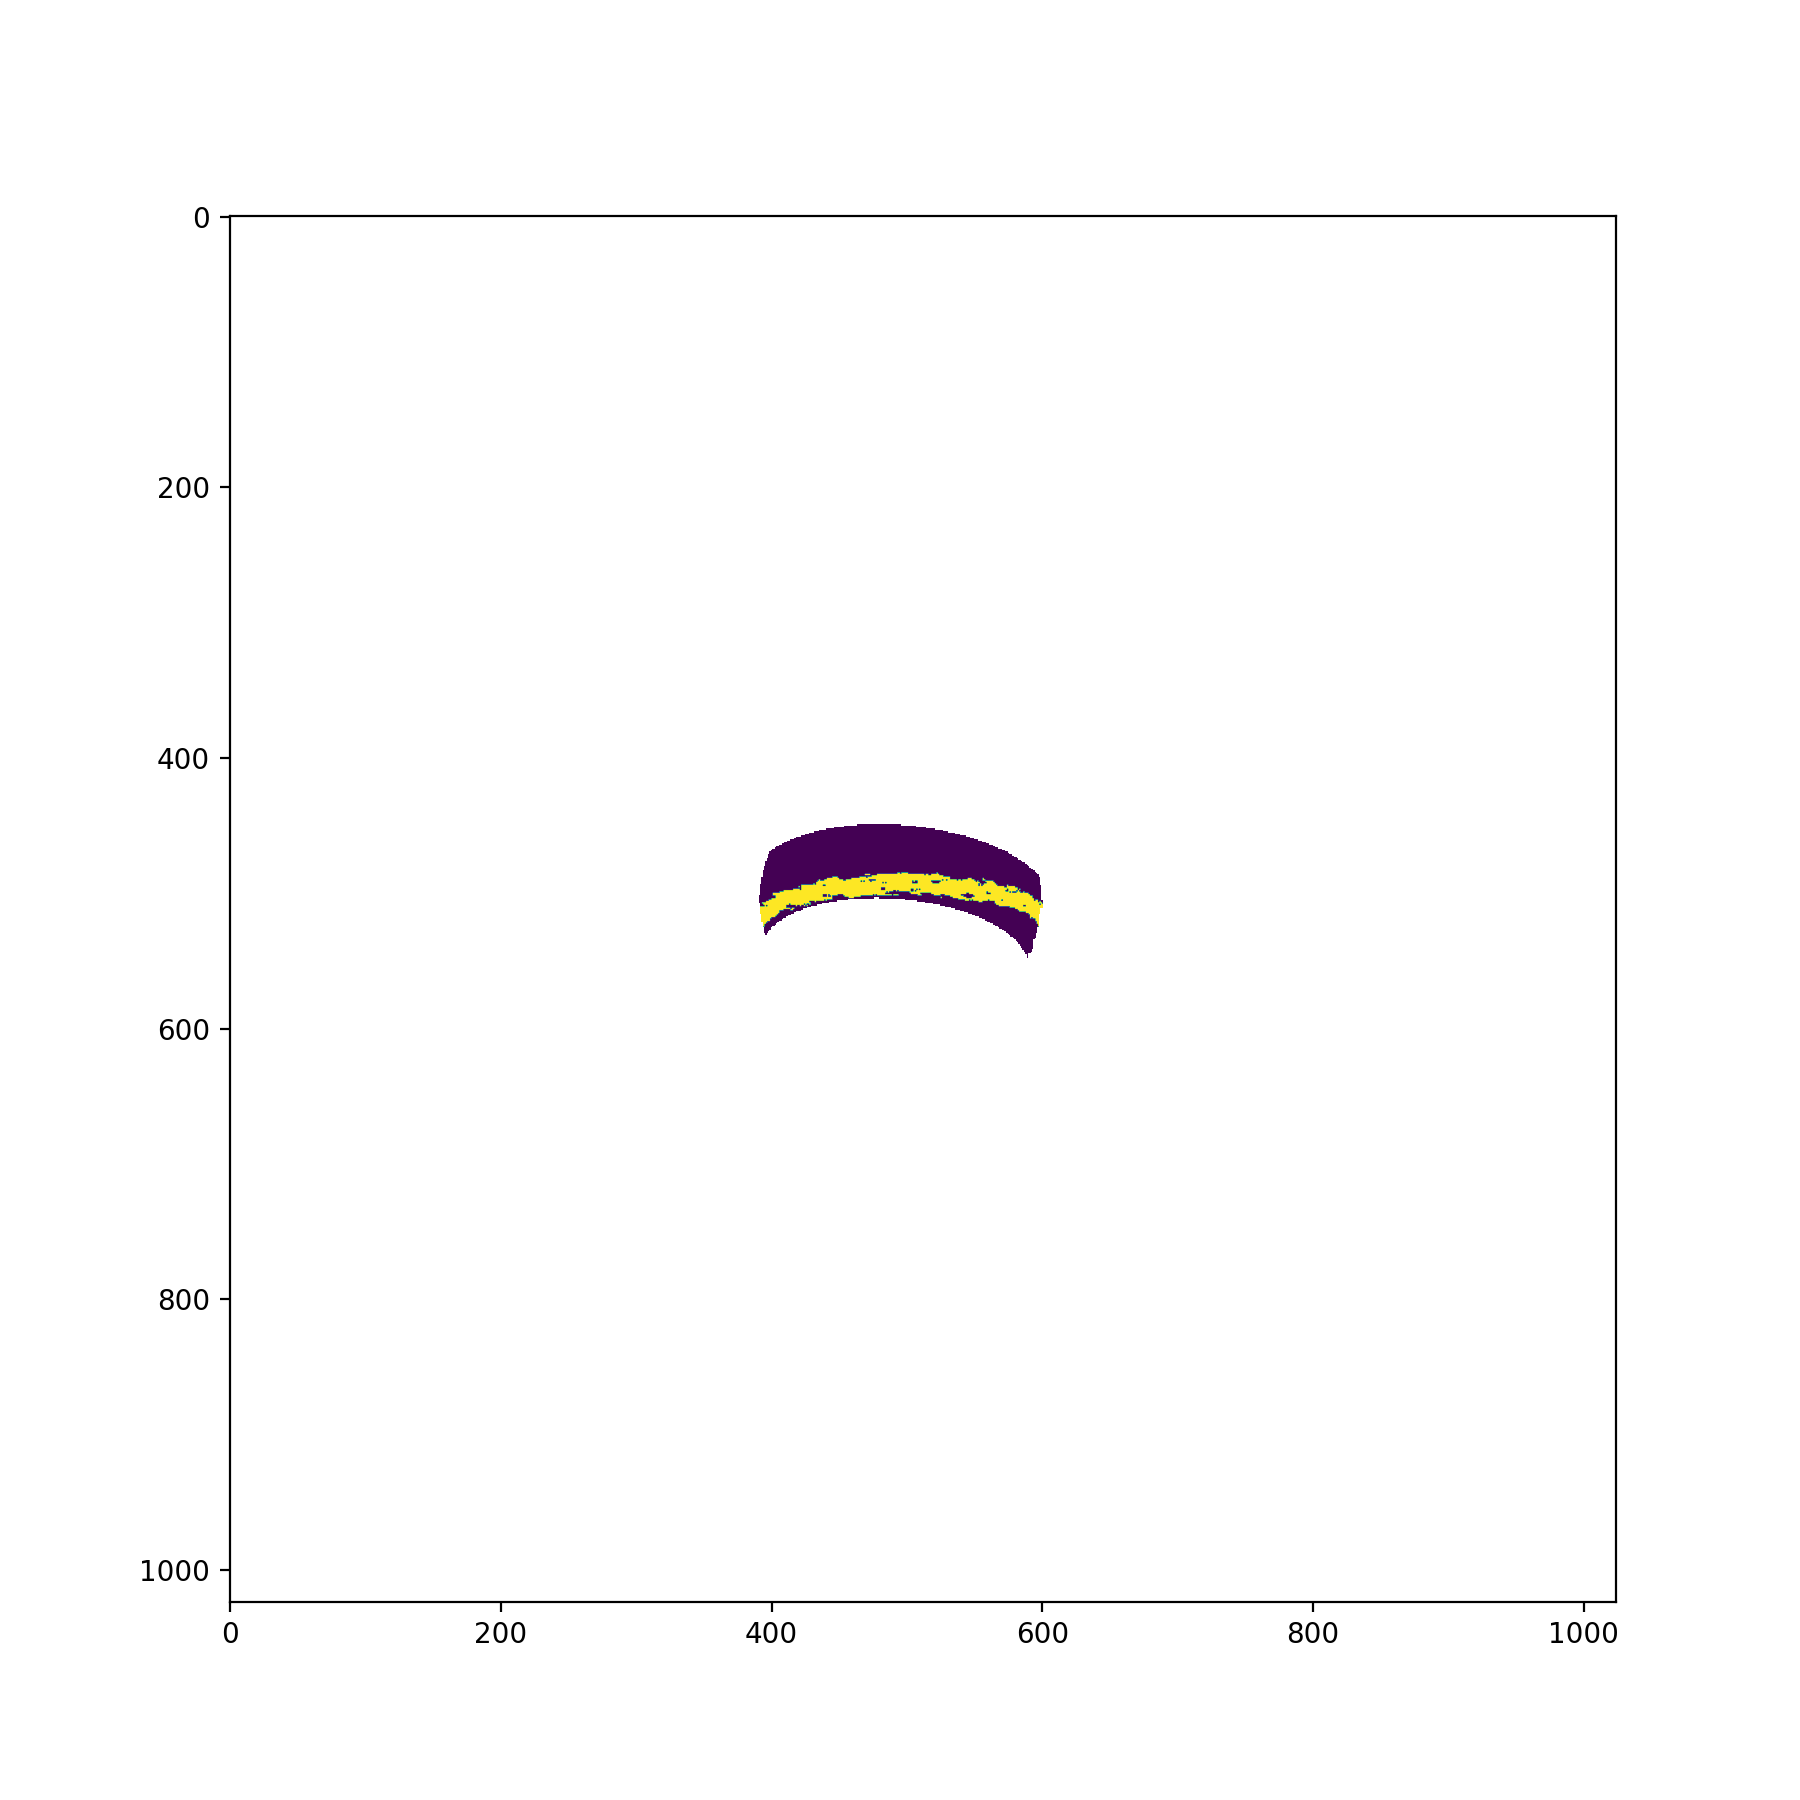

In [ ]:
plt.close(fig)
fig, ax = plt.subplots(figsize=(9,9))

ax.imshow(edge)

In [ ]:
hemisphereSwitch

True

Bad pixels in image: 3
N1789532757_1 [190, 191, 194, 196, 197, 199, 201, 203, 205, 207, 209, 211, 213, 215, 216, 218, 220, 222, 223, 225, 227, 229, 231, 233, 235, 238, 240, 242, 244, 246, 248, 251, 253, 255, 256, 258, 260, 262, 264, 266, 268, 269, 272, 274, 276, 278, 281, 283, 285, 287, 289, 291, 292, 294, 296, 298, 300, 302, 304, 307, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 337, 339, 341, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 387, 388] [237, 236, 236, 236, 236, 237, 237, 238, 238, 238, 237, 237, 237, 238, 238, 239, 240, 240, 240, 240, 241, 240, 240, 241, 241, 240, 240, 239, 239, 239, 239, 239, 239, 241, 242, 243, 242, 242, 241, 241, 242, 244, 243, 243, 243, 243, 242, 241, 240, 241, 244, 245, 245, 246, 247, 247, 247, 247, 247, 245, 243, 242, 241, 242, 243, 245, 246, 246, 245, 246, 247, 247, 248, 251, 251, 252, 252, 252, 251, 250, 251, 251, 252, 253, 252, 253, 253, 253, 253, 254, 253, 254, 2

<IPython.core.display.Javascript object>


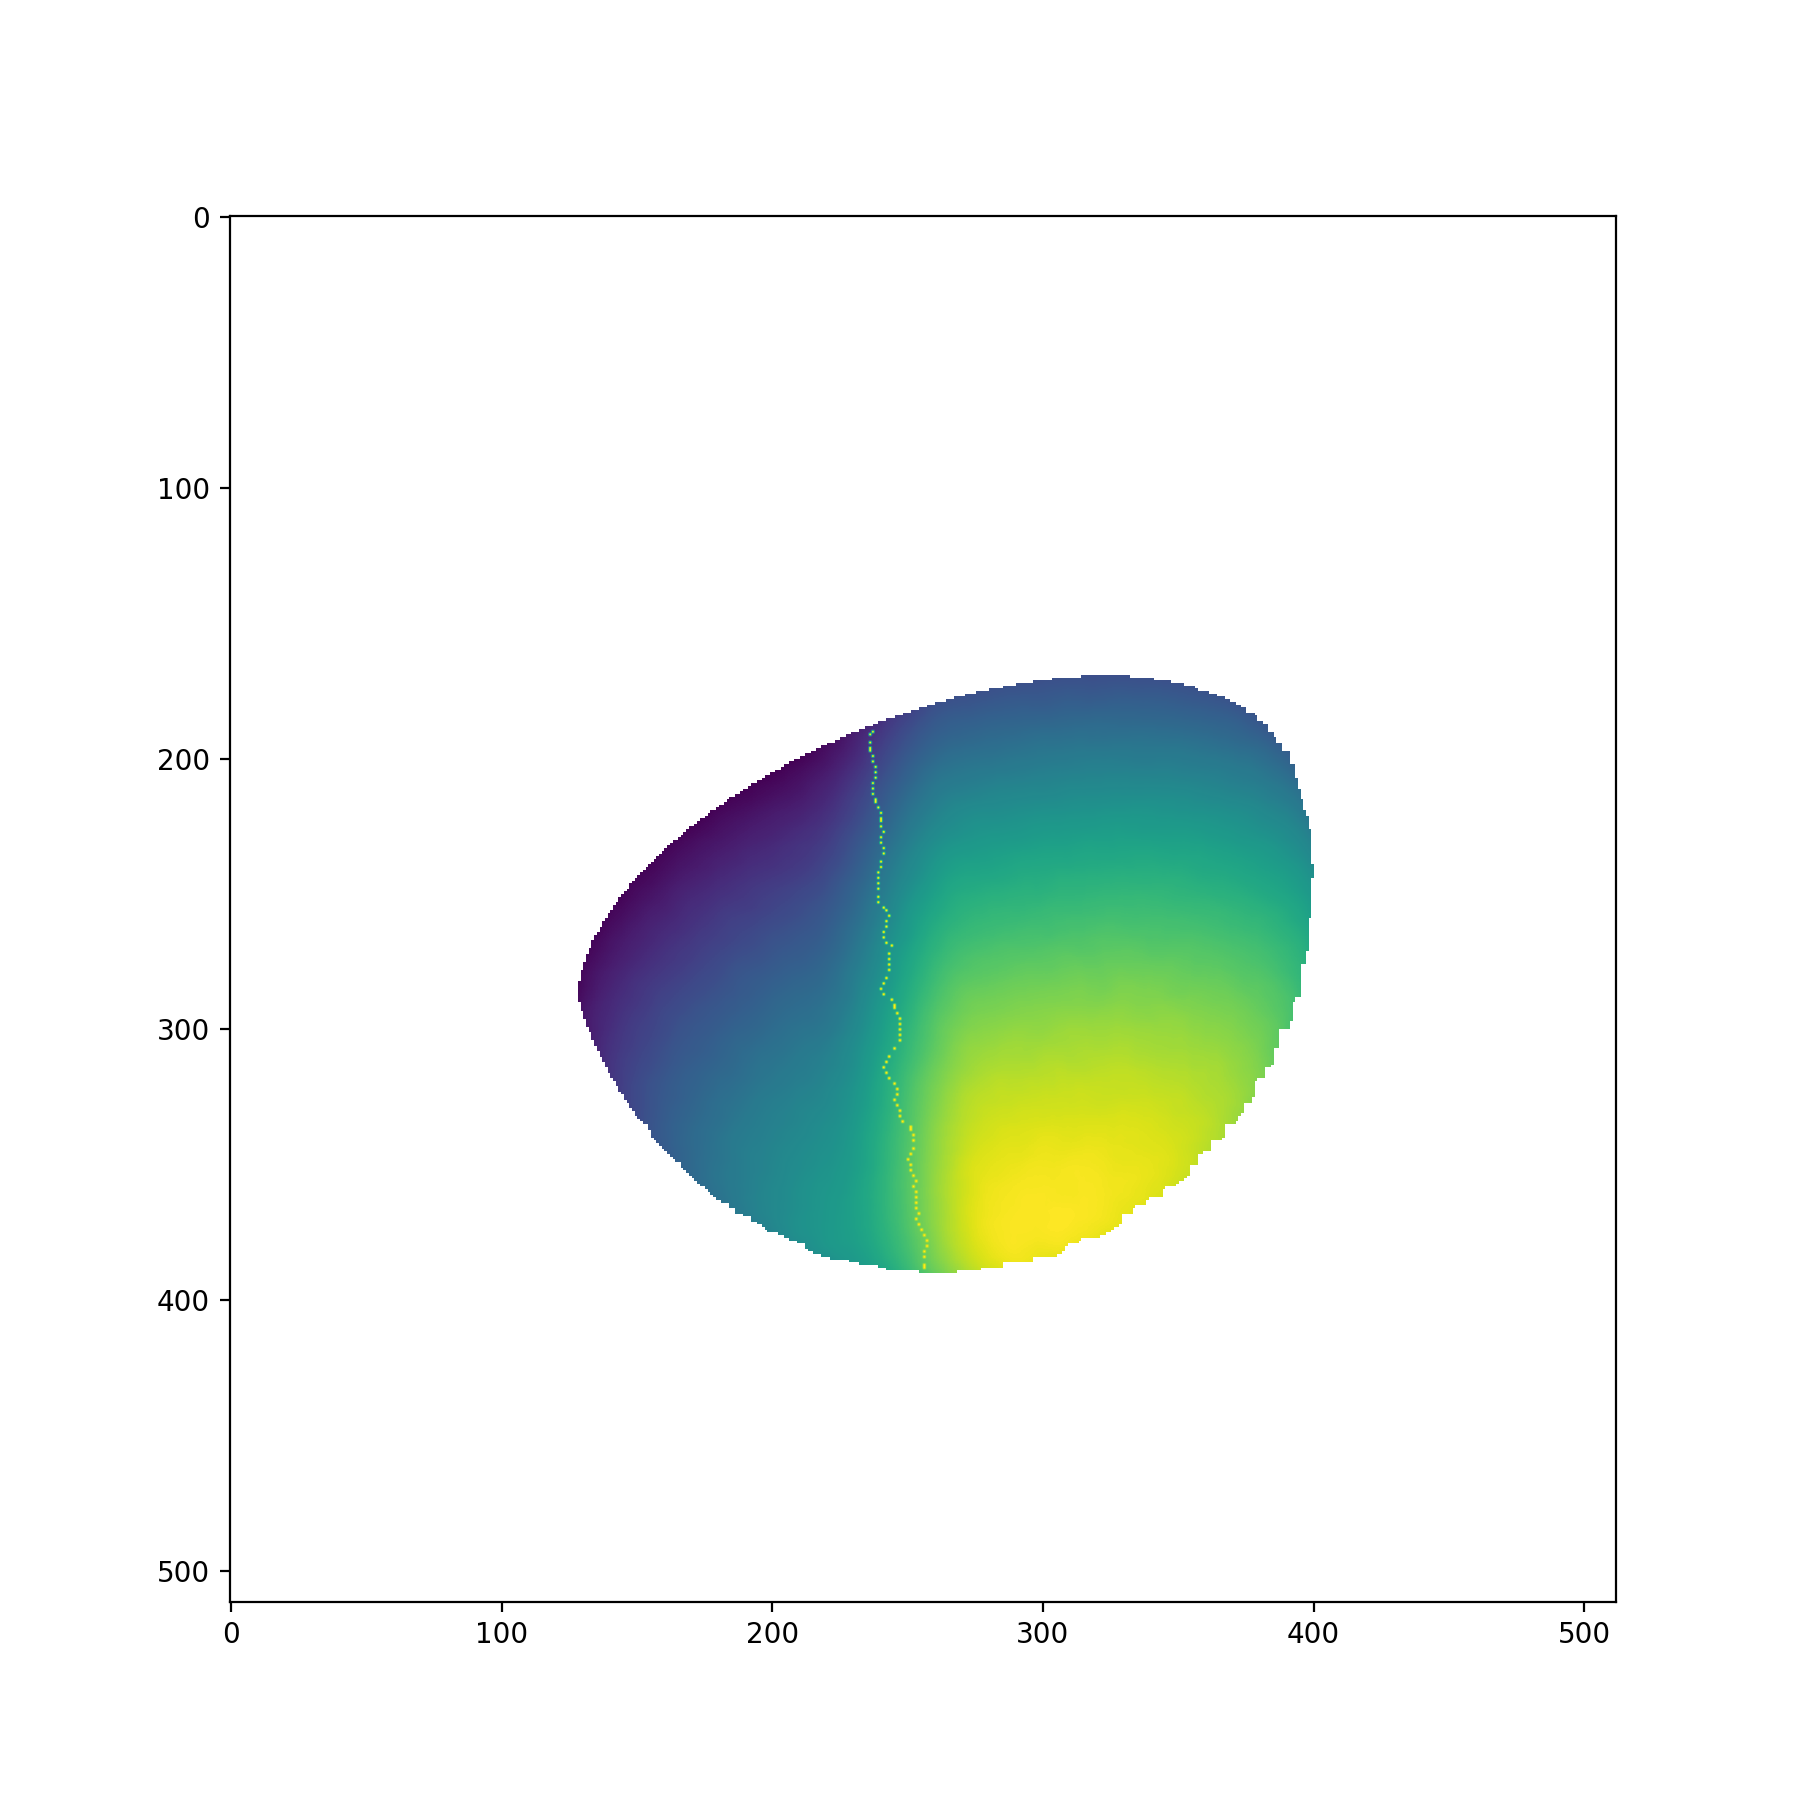

In [ ]:
#amp,az,mlat

blat = 11
testvals = [1,40,blat]

# imsim = hemispheresim2d2((OGlatArray,OGlonArray),*testvals,lowmean,highmean)
# # imsim = hemispheresim2d2switch((OGlatArray,OGlonArray),*testvals,lowmean,highmean)


# imsimblur = np.where(np.isfinite(imsim),imsim,np.nanmean(imsim))
# # avgblur = np.ones((49,49))
# # imsimblur = signal.convolve2d(imsimblur, avgblur, boundary='symm', mode='same')
# imsimblur = filters.gaussian(imsimblur, sigma=27)
# imsimblur = np.where(np.isfinite(imsim),imsimblur,np.nan)

# noise = np.random.normal(0, .15, imsim.shape)

# # incdrop = np.where(OGincArray>100,(OGincArray-120)*(-1/20),1)
# # incdrop = np.where(OGincArray<100,1,incdrop)
# # incdrop = np.where(OGincArray>120,0,incdrop)
# # incdrop = np.where(np.isfinite(OGincArray),incdrop,np.nan)

# # emisrise = np.cos(np.radians(OGemisArray))**.08

# # multfact = incdrop/emisrise

# multfact = 1.

# totimsim = multfact*imsimblur + noise


# imsim = hemispheresim2d2switchgrad((OGlatArray,OGlonArray),*testvals,lowmean,highmean)

# # imsimblur = np.where(np.isfinite(imsim),imsim,np.nanmean(imsim))
# # # avgblur = np.ones((49,49))
# # # imsimblur = signal.convolve2d(imsimblur, avgblur, boundary='symm', mode='same')
# # imsimblur = filters.gaussian(imsimblur, sigma=27)
# # imsimblur = np.where(np.isfinite(imsim),imsimblur,np.nan)

# noise = np.random.normal(0, .15, imsim.shape)

# incdrop = np.where(OGincArray>100,(OGincArray-120)*(-1/20),1)
# incdrop = np.where(OGincArray<100,1,incdrop)
# incdrop = np.where(OGincArray>120,0,incdrop)
# incdrop = np.where(np.isfinite(OGincArray),incdrop,np.nan)

# emisrise = np.cos(np.radians(OGemisArray))**.08

# multfact = incdrop/emisrise

# # multfact = 1.

# totimsim = multfact*multfact*imsim + noise


imsim = hemispheresim2d2grad((OGlatArray,OGlonArray),*testvals,lowmean,highmean)

# imsimblur = np.where(np.isfinite(imsim),imsim,np.nanmean(imsim))
# # avgblur = np.ones((49,49))
# # imsimblur = signal.convolve2d(imsimblur, avgblur, boundary='symm', mode='same')
# imsimblur = filters.gaussian(imsimblur, sigma=27)
# imsimblur = np.where(np.isfinite(imsim),imsimblur,np.nan)

noise = np.random.normal(0, .15, imsim.shape)

imsimnoise = imsim + noise
# totimsim = np.where(np.isfinite(OGim),(imsimnoise/6*(5+np.cos(np.radians(OGincArray)))),np.nan)

totimsim = np.where(np.isfinite(OGim),(imsimnoise*(2+np.cos(np.radians(OGincArray)))),np.nan)

# totimsim = np.where(np.isfinite(OGim),imsimnoise,np.nan)




im = np.copy(totimsim)

nansinimage = np.logical_and(OGincArray<89,~np.isfinite(im))

if len(np.where(nansinimage)[0]) > 0:
    im[nansinimage] = np.interp(np.flatnonzero(nansinimage), np.flatnonzero(~nansinimage),im[~nansinimage])
#     im[nansinimage] = np.nanmean(im)
    print("Bad pixels in image: {0}".format(len(np.where(nansinimage)[0])))

imint = signal.medfilt2d(im,3)

avgblur = np.ones((9,9))

imin = signal.convolve2d(imint, avgblur, boundary='symm', mode='same')

kx = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
ky = np.array([[-1,-1,-1] ,[0,0,0], [1,1,1]])

xlattest = np.where(np.isfinite(imin),np.nan,np.nan)
ylattest = np.where(np.isfinite(imin),np.nan,np.nan)
xgradtest = np.where(np.isfinite(imin),np.nan,np.nan)
ygradtest = np.where(np.isfinite(imin),np.nan,np.nan)

for i,j in enumerate(imin):
    if i>0 and i<len(imin)-2:
        for n,m in enumerate(j):
            if np.isfinite(m) and n>0 and n<len(j)-2:
                imbox = np.array([[imin[i-1,n-1],imin[i-1,n],imin[i-1,n+1]],
                                  [imin[i,n-1],imin[i,n],imin[i,n+1]],
                                  [imin[i+1,n-1],imin[i+1,n],imin[i+1,n+1]]])
                if len(np.where(np.isfinite(imbox))[0])<9: continue
                else:
                    ylat = OGlatArray[i,n] - OGlatArray[i-1,n]
                    xlat = OGlatArray[i,n] - OGlatArray[i,n-1]

                    tot = np.sqrt(xlat**2 + ylat**2)
                    xlat = xlat/tot
                    ylat = ylat/tot

                    xlattest[i,n] = xlat
                    ylattest[i,n] = ylat

                    xgradtest[i,n] = np.sum(kx*imbox)
                    ygradtest[i,n] = np.sum(ky*imbox)


slope = np.where(np.isfinite(ylattest/xlattest),(ylattest/xlattest),np.nan)

xfact = np.where(np.isfinite(slope),1,np.nan)
xfact = np.where(xlattest<0,-1,xfact)
xfact = np.where(slope>100,0,xfact)
yfact = slope
yfact = np.where(xlattest<0,-slope,yfact)

normfact = np.abs(xfact) + np.abs(yfact)

xfact /= normfact
yfact /= normfact



slopeswitch = xfact*xgradtest + yfact*ygradtest
slopeswitch2 = np.abs(yfact*xgradtest + (-1*xfact)*ygradtest)

hemisphereSwitch = np.nanmean(np.where(OGlatArray>0,im,np.nan)) < np.nanmean(np.where(OGlatArray<0,im,np.nan))

if hemisphereSwitch:
    slopeswitch *= -1

cropadgrad2 = np.where(np.logical_and(OGlatArray<blat+15,OGlatArray>blat-15),slopeswitch,np.nan)

# if hemisphereSwitch:
#     cropadgrad2 = np.where(np.logical_and(OGlatArray<7,OGlatArray>-23),slopeswitch,np.nan)
# #     cropadgrad2 = np.where(np.logical_and(OGlatArray<23,OGlatArray>-7),slopeswitch,np.nan)
# else:
#     cropadgrad2 = np.where(np.logical_and(OGlatArray<7,OGlatArray>-23),slopeswitch,np.nan)
# #     cropadgrad2 = np.where(np.logical_and(OGlatArray<23,OGlatArray>-7),slopeswitch,np.nan)


# denom = 4
# if fname == "N1845483375_1":
#     cropadgrad2 = np.where(np.logical_and(OGlatArray<15,OGlatArray>-5),slopeswitch,np.nan)
#     denom = 7



# if fname.startswith("N18382") or fname.startswith("N1839"):
#     cropadgrad2 = np.where(np.logical_and(OGlatArray<20,OGlatArray>5),slopeswitch,np.nan)
#     denom = 7
#     if fname == 'N1839513938_1':
#         slopeswitch2 *= -100


cropadgrad2thresh = np.zeros(np.shape(cropadgrad2))

croplat = np.where(np.isfinite(cropadgrad2),OGlatArray,np.nan)
croplon = np.where(np.isfinite(cropadgrad2),OGlonArray,np.nan)

latnum = len(np.where(np.isfinite(cropadgrad2))[0])
latslicenum = 2500
latslices = latnum//latslicenum
if latnum%latslicenum > 0.5*latslicenum:
    latslices += 1

ind = croplat.argsort(axis=None)
xloc = ind//len(im)
yloc = ind%len(im[0])
flatlon = croplon.flatten()
if 360-np.nanmax(flatlon) < 10 and np.nanmin(flatlon) < 10:
    flatlon = np.where(flatlon>180,flatlon-360,flatlon)
lonslices = 100

slicearray = np.full(np.shape(im),np.nan)

for i in range(latslices):
    if i == latslices-1:
        latend = latnum
    else:
        latend = latslicenum*(i+1)

    ind2 = flatlon[ind[latslicenum*i:latend]].argsort(axis=None)
    lonnum = len(ind2)
    lonslicenum = lonnum//lonslices

    for j in range(lonslices):
        if j == lonslices-1:
            lonend = lonnum
        else:
            lonend = lonslicenum*(j+1)

        xtemp = xloc[latslicenum*i:latend][ind2[lonslicenum*j:lonend]]
        ytemp = yloc[latslicenum*i:latend][ind2[lonslicenum*j:lonend]]
        slicearray[xtemp,ytemp] = j


imlen = len(im)
imind = np.empty((2,imlen,imlen),dtype=int)

for i in range(imlen):
    for j in range(imlen):
        imind[0:2,i,j] = (i,j)


for i in range(lonslices):
    lonmask = slicearray == i

    num = len(cropadgrad2[lonmask])//denom #larger denominator seems better for later images with weaker boundaries

    ind = np.argpartition(cropadgrad2[lonmask], -num)[-num:] #locates num brightest pixels

    cropadgrad2thresh[imind[0][lonmask][ind],imind[1][lonmask][ind]] = 1

edge = np.where(np.isfinite(cropadgrad2),cropadgrad2thresh,np.nan)
sobelthresh = np.copy(edge)

meanx = []
meany = []

for i in range(lonslices):

    lonmask = slicearray == i

    tempmean = np.nanmean(sobelthresh[lonmask])

    if tempmean > 0:
        lonslice = np.where(lonmask,sobelthresh,np.nan)
        points = np.where(lonslice==1)

        weights = cropadgrad2[points]
        weights -= np.min(weights)
        meanx.append(np.sum(points[0] * weights) / np.sum(weights))
        meany.append(np.sum(points[1] * weights) / np.sum(weights))
    else:
        meanx.append(np.nan)
        meany.append(np.nan)


meanx = np.asarray(meanx,dtype=float)
meany = np.asarray(meany,dtype=float)

nonanx = []
nonany = []

for i,j in enumerate(meanx):
    if np.isfinite(meanx[i]):
        nonanx.append(int(np.round(meanx[i])))
        nonany.append(int(np.round(meany[i])))

print("{0} {1} {2}".format(fname, nonanx, nonany))

imb2 = np.copy(imin)
imb2[nonanx,nonany] = np.nanmax(imin)

plt.close(fig)
fig, ax = plt.subplots(figsize=(9,9))

ax.imshow(imb2)

In [ ]:
hemisphereSwitch

False

In [ ]:


lons = OGlonArray[nonanx,nonany]
lats = OGlatArray[nonanx,nonany]

Q1 = np.percentile(lats, 25, interpolation = 'midpoint')
Q3 = np.percentile(lats, 75, interpolation = 'midpoint')
IQR = Q3 - Q1

fac = 1.5

upperorlower = np.logical_or(lats>=(Q3+fac*IQR), lats<=(Q1-fac*IQR))

oldlen = len(lats)

lats = lats[~upperorlower][7:]

lons = lons[~upperorlower][7:]

print("lat/lon arrays trimmed from {0} to {1}\n".format(oldlen,len(lats)))

semimaj = 2771.0
semimin = 2691.2
sphcoords = tosphcoordarray(lons,lats,semimaj,semimin)

cartcoords = sphtocar(sphcoords)
cartcoords = np.asarray(cartcoords)

print("a,b,c,d")
abcdest = 0,0,1,np.nanmean(lats)*-100
# plane = optimize.least_squares(planefit, abcdest)  #,bounds=([0,0,1,0.975*bguess], [h,w,1.05,1.025*bguess])
# plane = optimize.least_squares(planefit, abcdest ,bounds=([-1.,-1.,-1.,-2000], [1,1,1,2000])) #([-1,-1,1,-1000], [1.1,1.1,1.1,1001])
plane = optimize.least_squares(planefit, abcdest) #([-1,-1,1,-1000], [1.1,1.1,1.1,1001])



a,b,c,d = plane.x


norm = np.sqrt(a*a + b*b + c*c)
a,b,c,d = (a,b,c,d)/norm

print(a,b,c,d)


z1 = -d/c
meanlat = np.degrees(np.arctan(z1/(semimaj*np.sqrt(1-(z1/semimin)**2))))
if z1*meanlat<0: meanlat *= -1
nvecsph = cartosph([[a,b,c]])
azimuth2, amp = 360 - nvecsph[0][0], 90 - nvecsph[0][1]
if azimuth2 > 360: azimuth2 -= 360



print("\nimageID   amp   az      mlat   SSL    offset  time")
print("Observed: {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}  {}".format(amp,azimuth2,meanlat,SSL,azimuth2-SSL,time))
print("Actual:   {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}".format(testvals[0],testvals[1],testvals[2],SSL,testvals[1]-SSL))


lat/lon arrays trimmed from 100 to 92

a,b,c,d
0.02596507972381278 -0.16211702835867542 0.9864298676292647 127.13464064333812

imageID   amp   az      mlat   SSL    offset  time
Observed: 9.45  80.90  -2.67  219.10  -138.20  2014-09-16 03:25:53.746000
Actual:   10.00  80.00  -3.00  219.10  -139.10


<IPython.core.display.Javascript object>


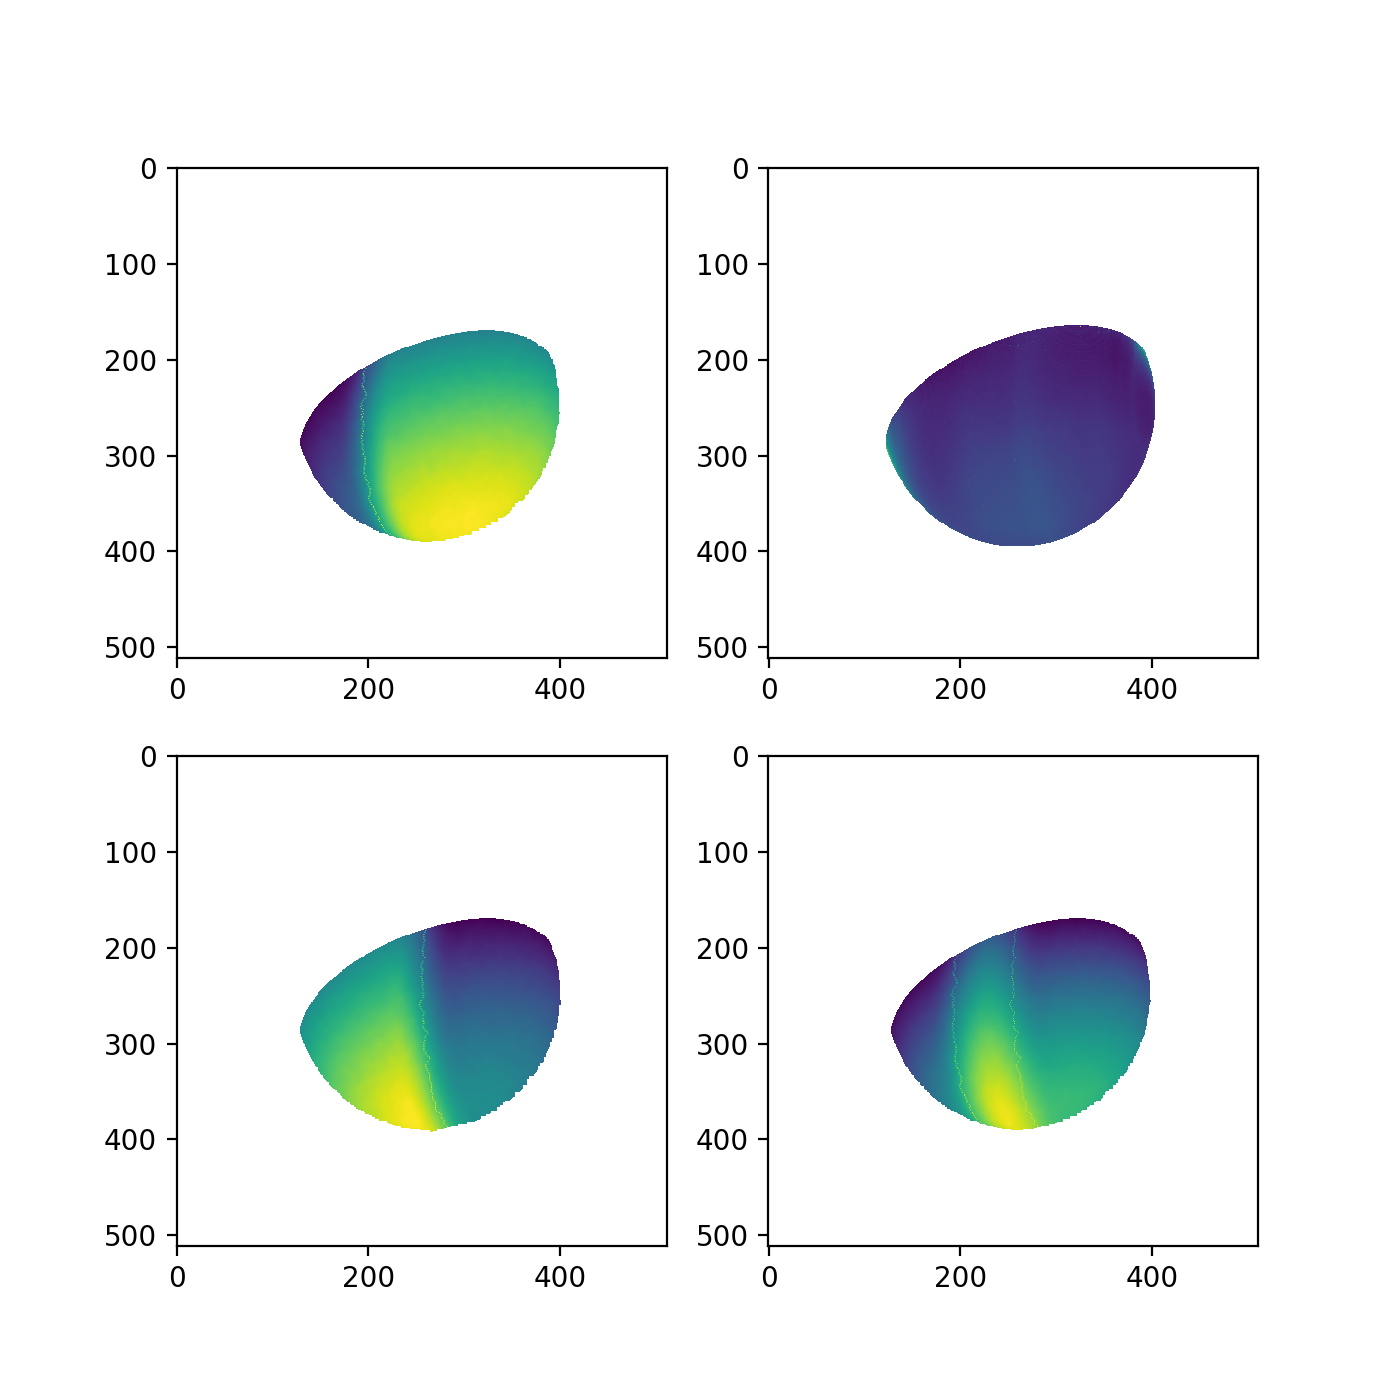

In [ ]:
plt.close(fig)
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(7,7))

# ax1.imshow(np.where(np.logical_and(im>bins[lows[0][0]-1],im<bins[lows[0][0]+2]),im,np.nan))
ax1.imshow(imb)
# ax2.imshow(slopegrad)
ax2.imshow(OGim)
# ax2.imshow(cropadgrad)
# ax2.imshow(cropadgradthresh)


ax3.imshow(imb2)
# ax4.imshow(slopeswitch)
# ax4.imshow(multfact**2)

ax4.imshow(imb+imb2,vmin=np.nanmin(OGim),vmax=np.nanmax(OGim))


# ax4.plot(imb[501])
# ax4.plot(imb2[501])

# ax4.imshow(cropadgrad2)
# ax4.imshow(cropadgrad2thresh)



In [ ]:
np.nanmean(imb2)

1158.4647396321177

<IPython.core.display.Javascript object>


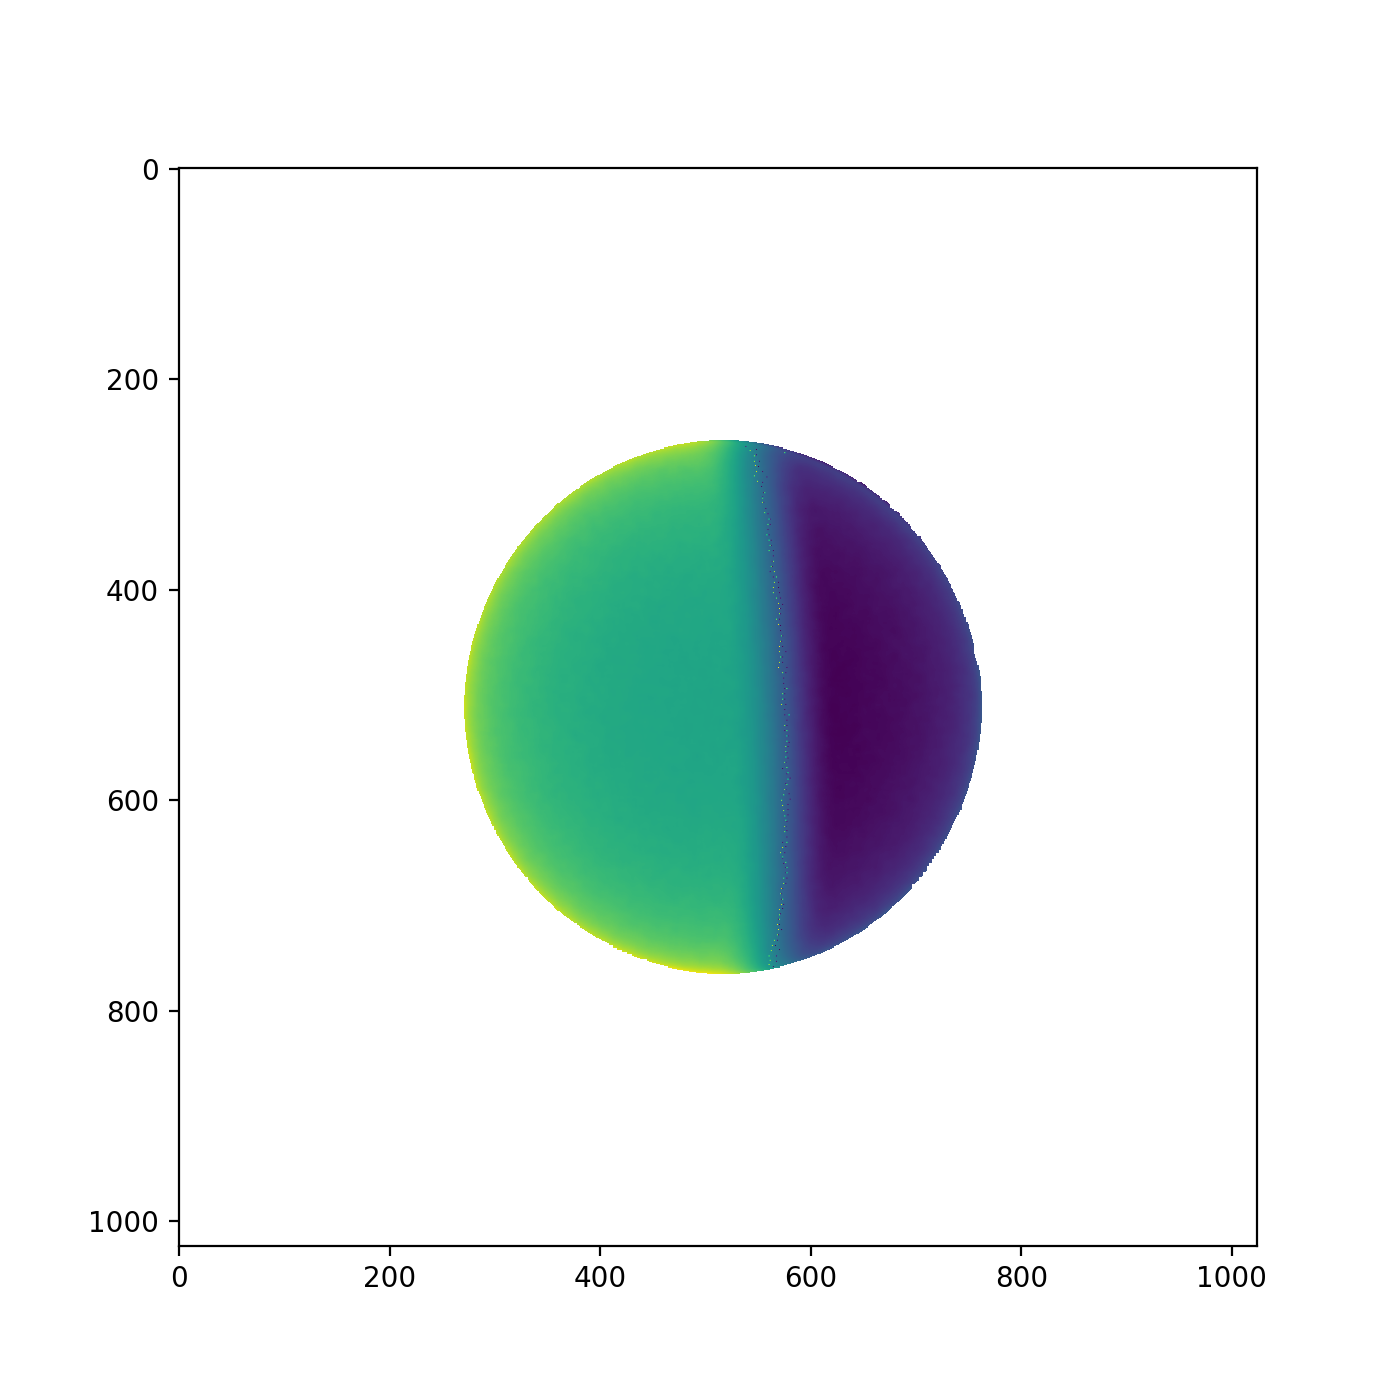

In [ ]:
plt.close(fig)
fig, ax = plt.subplots(figsize=(7,7))

# ax.imshow(imb-imb2)
# ax.imshow(np.where(np.logical_or(imb>1500,imb2>1400),1,0))
ax.imshow(np.where(imb2>np.nanmax(imb2)-1,np.nanmin(imb),imb))




In [ ]:
indata = []
outdata = []

print("imageID   amp   az      mlat   SSL    offset")

for i in range(12):

    #amp,az,mlat
    testvals = [6,i*30,-5]

    imsim = hemispheresim2d2grad((OGlatArray,OGlonArray),*testvals,lowmean,highmean)

#     imsimblur = np.where(np.isfinite(imsim),imsim,np.nanmean(imsim))
#     imsimblur = filters.gaussian(imsimblur, sigma=27)
#     imsimblur = np.where(np.isfinite(imsim),imsimblur,np.nan)

    noise = np.random.normal(0, .15, imsim.shape)

    incdrop = np.where(OGincArray>100,(OGincArray-120)*(-1/20),1)
    incdrop = np.where(OGincArray<100,1,incdrop)
    incdrop = np.where(OGincArray>120,0,incdrop)
    incdrop = np.where(np.isfinite(OGincArray),incdrop,np.nan)

    emisrise = np.cos(np.radians(OGemisArray))**.08
    multfact = incdrop/emisrise
#     totimsim = multfact*imsimblur + noise
    totimsim = multfact*imsim + noise


    im = np.copy(totimsim)

    nansinimage = np.logical_and(OGincArray<89,~np.isfinite(im))

    if len(np.where(nansinimage)[0]) > 0:
        im[nansinimage] = np.interp(np.flatnonzero(nansinimage), np.flatnonzero(~nansinimage),im[~nansinimage])
    #     im[nansinimage] = np.nanmean(im)
        print("Bad pixels in image: {0}".format(len(np.where(nansinimage)[0])))



    imint = signal.medfilt2d(im,3)

    avgblur = np.ones((9,9))

    imin = signal.convolve2d(imint, avgblur, boundary='symm', mode='same')

    kx = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
    ky = np.array([[-1,-1,-1] ,[0,0,0], [1,1,1]])

    xlattest = np.where(np.isfinite(imin),np.nan,np.nan)
    ylattest = np.where(np.isfinite(imin),np.nan,np.nan)
    xgradtest = np.where(np.isfinite(imin),np.nan,np.nan)
    ygradtest = np.where(np.isfinite(imin),np.nan,np.nan)

    for i,j in enumerate(imin):
        if i>0 and i<len(imin)-2:
            for n,m in enumerate(j):
                if np.isfinite(m) and n>0 and n<len(j)-2:
                    imbox = np.array([[imin[i-1,n-1],imin[i-1,n],imin[i-1,n+1]],
                                      [imin[i,n-1],imin[i,n],imin[i,n+1]],
                                      [imin[i+1,n-1],imin[i+1,n],imin[i+1,n+1]]])
                    if len(np.where(np.isfinite(imbox))[0])<9: continue
                    else:
                        ylat = OGlatArray[i,n] - OGlatArray[i-1,n]
                        xlat = OGlatArray[i,n] - OGlatArray[i,n-1]

                        tot = np.sqrt(xlat**2 + ylat**2)
                        xlat = xlat/tot
                        ylat = ylat/tot

                        xlattest[i,n] = xlat
                        ylattest[i,n] = ylat

                        xgradtest[i,n] = np.sum(kx*imbox)
                        ygradtest[i,n] = np.sum(ky*imbox)


    slope = np.where(np.isfinite(ylattest/xlattest),(ylattest/xlattest),np.nan)

    xfact = np.where(np.isfinite(slope),1,np.nan)
    xfact = np.where(xlattest<0,-1,xfact)
    xfact = np.where(slope>100,0,xfact)
    yfact = slope
    yfact = np.where(xlattest<0,-slope,yfact)

    normfact = np.abs(xfact) + np.abs(yfact)

    xfact /= normfact
    yfact /= normfact



    slopegrad = xfact*xgradtest + yfact*ygradtest
    slopegrad2 = np.abs(yfact*xgradtest + (-1*xfact)*ygradtest)

    hemisphereSwitch = np.nanmean(np.where(OGlatArray>0,im,np.nan)) < np.nanmean(np.where(OGlatArray<0,im,np.nan))

    if hemisphereSwitch:
        slopegrad *= -1


    if hemisphereSwitch:
        cropadgrad = np.where(np.logical_and(OGlatArray<23,OGlatArray>-7),slopegrad,np.nan)
    else:
        cropadgrad = np.where(np.logical_and(OGlatArray<7,OGlatArray>-23),slopegrad,np.nan)

#     denom = 4
#     if fname == "N1845483375_1":
#         cropadgrad = np.where(np.logical_and(OGlatArray<15,OGlatArray>-5),slopegrad,np.nan)
#         denom = 7



#     if fname.startswith("N18382") or fname.startswith("N1839"):
#         cropadgrad = np.where(np.logical_and(OGlatArray<20,OGlatArray>5),slopegrad,np.nan)
#         denom = 7
#         if fname == 'N1839513938_1':
#             slopegrad2 *= -100


    cropadgradthresh = np.zeros(np.shape(cropadgrad))

    croplat = np.where(np.isfinite(cropadgrad),OGlatArray,np.nan)
    croplon = np.where(np.isfinite(cropadgrad),OGlonArray,np.nan)

    latnum = len(np.where(np.isfinite(cropadgrad))[0])
    latslicenum = 2500
    latslices = latnum//latslicenum
    if latnum%latslicenum > 0.5*latslicenum:
        latslices += 1

    ind = croplat.argsort(axis=None)
    xloc = ind//len(im)
    yloc = ind%len(im[0])
    flatlon = croplon.flatten()
    if 360-np.nanmax(flatlon) < 10 and np.nanmin(flatlon) < 10:
        flatlon = np.where(flatlon>180,flatlon-360,flatlon)
    lonslices = 100

    slicearray = np.full(np.shape(im),np.nan)

    for i in range(latslices):
        if i == latslices-1:
            latend = latnum
        else:
            latend = latslicenum*(i+1)

        ind2 = flatlon[ind[latslicenum*i:latend]].argsort(axis=None)
        lonnum = len(ind2)
        lonslicenum = lonnum//lonslices

        for j in range(lonslices):
            if j == lonslices-1:
                lonend = lonnum
            else:
                lonend = lonslicenum*(j+1)

            xtemp = xloc[latslicenum*i:latend][ind2[lonslicenum*j:lonend]]
            ytemp = yloc[latslicenum*i:latend][ind2[lonslicenum*j:lonend]]
            slicearray[xtemp,ytemp] = j


    imlen = len(im)
    imind = np.empty((2,imlen,imlen),dtype=int)

    for i in range(imlen):
        for j in range(imlen):
            imind[0:2,i,j] = (i,j)


    for i in range(lonslices):
        lonmask = slicearray == i

        num = len(cropadgrad[lonmask])//denom #larger denominator seems better for later images with weaker boundaries

        ind = np.argpartition(cropadgrad[lonmask], -num)[-num:] #locates num brightest pixels

        cropadgradthresh[imind[0][lonmask][ind],imind[1][lonmask][ind]] = 1

    edge = np.where(np.isfinite(cropadgrad),cropadgradthresh,np.nan)
    sobelthresh = np.copy(edge)

    meanx = []
    meany = []

    for i in range(lonslices):

        lonmask = slicearray == i

        tempmean = np.nanmean(sobelthresh[lonmask])

        if tempmean > 0:
            lonslice = np.where(lonmask,sobelthresh,np.nan)
            points = np.where(lonslice==1)

            weights = cropadgrad[points]
            weights -= np.min(weights)
            meanx.append(np.sum(points[0] * weights) / np.sum(weights))
            meany.append(np.sum(points[1] * weights) / np.sum(weights))
        else:
            meanx.append(np.nan)
            meany.append(np.nan)


    meanx = np.asarray(meanx,dtype=float)
    meany = np.asarray(meany,dtype=float)

    nonanx = []
    nonany = []

    for i,j in enumerate(meanx):
        if np.isfinite(meanx[i]):
            nonanx.append(int(np.round(meanx[i])))
            nonany.append(int(np.round(meany[i])))

#     print("{0} {1} {2}".format(fname, nonanx, nonany))

    imb = np.copy(imin)
    imb[nonanx,nonany] = np.nanmax(imin)



    lons = OGlonArray[nonanx,nonany]
    lats = OGlatArray[nonanx,nonany]

    Q1 = np.percentile(lats, 25, interpolation = 'midpoint')
    Q3 = np.percentile(lats, 75, interpolation = 'midpoint')
    IQR = Q3 - Q1

    fac = 1.5

    upperorlower = np.logical_or(lats>=(Q3+fac*IQR), lats<=(Q1-fac*IQR))

    oldlen = len(lats)

    lats = lats[~upperorlower][7:]

    lons = lons[~upperorlower][7:]

    print("lat/lon arrays trimmed from {0} to {1}\n".format(oldlen,len(lats)))

    semimaj = 2771.0
    semimin = 2691.2
    sphcoords = tosphcoordarray(lons,lats,semimaj,semimin)

    cartcoords = sphtocar(sphcoords)
    cartcoords = np.asarray(cartcoords)

    print("a,b,c,d")
    abcdest = 0,0,1,np.nanmean(lats)*-100
    # plane = optimize.least_squares(planefit, abcdest)  #,bounds=([0,0,1,0.975*bguess], [h,w,1.05,1.025*bguess])
    plane = optimize.least_squares(planefit, abcdest ,bounds=([-1.,-1.,-1.,-2000], [1,1,1,2000])) #([-1,-1,1,-1000], [1.1,1.1,1.1,1001])


    a,b,c,d = plane.x


    norm = np.sqrt(a*a + b*b + c*c)
    a,b,c,d = (a,b,c,d)/norm

#     print(a,b,c,d)


    z1 = -d/c
    meanlat = np.degrees(np.arctan(z1/(semimaj*np.sqrt(1-(z1/semimin)**2))))
    if z1*meanlat<0: meanlat *= -1
    nvecsph = cartosph([[a,b,c]])
    azimuth2, amp = 360 - nvecsph[0][0], 90 - nvecsph[0][1]
    if azimuth2 > 360: azimuth2 -= 360

    outdata.append([amp,azimuth2,meanlat,azimuth2-SSL])
    indata.append([testvals[0],testvals[1],testvals[2],testvals[1]-SSL])

    print("Actual:   {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}".format(testvals[0],testvals[1],testvals[2],SSL,testvals[1]-SSL))
    print("Observed: {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}".format(amp,azimuth2,meanlat,SSL,azimuth2-SSL))


imageID   amp   az      mlat   SSL    offset


/home/csnell/anaconda3/envs/isis/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


lat/lon arrays trimmed from 100 to 93

a,b,c,d
Actual:   6.00  0.00  -5.00  88.64  -88.64
Observed: 5.71  17.96  -3.11  88.64  -70.67
lat/lon arrays trimmed from 100 to 93

a,b,c,d
Actual:   6.00  30.00  -5.00  88.64  -58.64
Observed: 6.45  44.46  -3.29  88.64  -44.18
lat/lon arrays trimmed from 100 to 93

a,b,c,d
Actual:   6.00  60.00  -5.00  88.64  -28.64
Observed: 6.84  69.61  -3.54  88.64  -19.03
lat/lon arrays trimmed from 100 to 87

a,b,c,d
Actual:   6.00  90.00  -5.00  88.64  1.36
Observed: 6.92  93.87  -3.86  88.64  5.23
lat/lon arrays trimmed from 100 to 87

a,b,c,d
Actual:   6.00  120.00  -5.00  88.64  31.36
Observed: 6.29  119.58  -4.61  88.64  30.95
lat/lon arrays trimmed from 100 to 90

a,b,c,d
Actual:   6.00  150.00  -5.00  88.64  61.36
Observed: 6.63  145.94  -4.12  88.64  57.31
lat/lon arrays trimmed from 100 to 93

a,b,c,d
Actual:   6.00  180.00  -5.00  88.64  91.36
Observed: 6.54  166.37  -3.41  88.64  77.74
lat/lon arrays trimmed from 100 to 93

a,b,c,d
Actual:   6.0

In [ ]:
#north boundary, same bright hem

indata15 = []
outdata15 = []

print("imageID   amp   az      mlat   SSL    offset")

for i in range(12):

    #amp,az,mlat
    testvals = [6,i*30,5]

    imsim = hemispheresim2d2grad((OGlatArray,OGlonArray),*testvals,lowmean,highmean)

#     imsimblur = np.where(np.isfinite(imsim),imsim,np.nanmean(imsim))
#     imsimblur = filters.gaussian(imsimblur, sigma=27)
#     imsimblur = np.where(np.isfinite(imsim),imsimblur,np.nan)

    noise = np.random.normal(0, .15, imsim.shape)

    incdrop = np.where(OGincArray>100,(OGincArray-120)*(-1/20),1)
    incdrop = np.where(OGincArray<100,1,incdrop)
    incdrop = np.where(OGincArray>120,0,incdrop)
    incdrop = np.where(np.isfinite(OGincArray),incdrop,np.nan)

    emisrise = np.cos(np.radians(OGemisArray))**.08
    multfact = incdrop/emisrise
#     totimsim = multfact*imsimblur + noise
    totimsim = multfact*imsim + noise


    im = np.copy(totimsim)

    nansinimage = np.logical_and(OGincArray<89,~np.isfinite(im))

    if len(np.where(nansinimage)[0]) > 0:
        im[nansinimage] = np.interp(np.flatnonzero(nansinimage), np.flatnonzero(~nansinimage),im[~nansinimage])
    #     im[nansinimage] = np.nanmean(im)
        print("Bad pixels in image: {0}".format(len(np.where(nansinimage)[0])))



    imint = signal.medfilt2d(im,3)

    avgblur = np.ones((9,9))

    imin = signal.convolve2d(imint, avgblur, boundary='symm', mode='same')

    kx = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
    ky = np.array([[-1,-1,-1] ,[0,0,0], [1,1,1]])

    xlattest = np.where(np.isfinite(imin),np.nan,np.nan)
    ylattest = np.where(np.isfinite(imin),np.nan,np.nan)
    xgradtest = np.where(np.isfinite(imin),np.nan,np.nan)
    ygradtest = np.where(np.isfinite(imin),np.nan,np.nan)

    for i,j in enumerate(imin):
        if i>0 and i<len(imin)-2:
            for n,m in enumerate(j):
                if np.isfinite(m) and n>0 and n<len(j)-2:
                    imbox = np.array([[imin[i-1,n-1],imin[i-1,n],imin[i-1,n+1]],
                                      [imin[i,n-1],imin[i,n],imin[i,n+1]],
                                      [imin[i+1,n-1],imin[i+1,n],imin[i+1,n+1]]])
                    if len(np.where(np.isfinite(imbox))[0])<9: continue
                    else:
                        ylat = OGlatArray[i,n] - OGlatArray[i-1,n]
                        xlat = OGlatArray[i,n] - OGlatArray[i,n-1]

                        tot = np.sqrt(xlat**2 + ylat**2)
                        xlat = xlat/tot
                        ylat = ylat/tot

                        xlattest[i,n] = xlat
                        ylattest[i,n] = ylat

                        xgradtest[i,n] = np.sum(kx*imbox)
                        ygradtest[i,n] = np.sum(ky*imbox)


    slope = np.where(np.isfinite(ylattest/xlattest),(ylattest/xlattest),np.nan)

    xfact = np.where(np.isfinite(slope),1,np.nan)
    xfact = np.where(xlattest<0,-1,xfact)
    xfact = np.where(slope>100,0,xfact)
    yfact = slope
    yfact = np.where(xlattest<0,-slope,yfact)

    normfact = np.abs(xfact) + np.abs(yfact)

    xfact /= normfact
    yfact /= normfact



    slopegrad = xfact*xgradtest + yfact*ygradtest
    slopegrad2 = np.abs(yfact*xgradtest + (-1*xfact)*ygradtest)

    hemisphereSwitch = np.nanmean(np.where(OGlatArray>0,im,np.nan)) < np.nanmean(np.where(OGlatArray<0,im,np.nan))

    if hemisphereSwitch:
        slopegrad *= -1


    if hemisphereSwitch:
        cropadgrad = np.where(np.logical_and(OGlatArray<23,OGlatArray>-7),slopegrad,np.nan)
    else:
#         cropadgrad = np.where(np.logical_and(OGlatArray<7,OGlatArray>-23),slopegrad,np.nan)
        cropadgrad = np.where(np.logical_and(OGlatArray<23,OGlatArray>-7),slopegrad,np.nan)


#     denom = 4
#     if fname == "N1845483375_1":
#         cropadgrad = np.where(np.logical_and(OGlatArray<15,OGlatArray>-5),slopegrad,np.nan)
#         denom = 7



#     if fname.startswith("N18382") or fname.startswith("N1839"):
#         cropadgrad = np.where(np.logical_and(OGlatArray<20,OGlatArray>5),slopegrad,np.nan)
#         denom = 7
#         if fname == 'N1839513938_1':
#             slopegrad2 *= -100


    cropadgradthresh = np.zeros(np.shape(cropadgrad))

    croplat = np.where(np.isfinite(cropadgrad),OGlatArray,np.nan)
    croplon = np.where(np.isfinite(cropadgrad),OGlonArray,np.nan)

    latnum = len(np.where(np.isfinite(cropadgrad))[0])
    latslicenum = 2500
    latslices = latnum//latslicenum
    if latnum%latslicenum > 0.5*latslicenum:
        latslices += 1

    ind = croplat.argsort(axis=None)
    xloc = ind//len(im)
    yloc = ind%len(im[0])
    flatlon = croplon.flatten()
    if 360-np.nanmax(flatlon) < 10 and np.nanmin(flatlon) < 10:
        flatlon = np.where(flatlon>180,flatlon-360,flatlon)
    lonslices = 100

    slicearray = np.full(np.shape(im),np.nan)

    for i in range(latslices):
        if i == latslices-1:
            latend = latnum
        else:
            latend = latslicenum*(i+1)

        ind2 = flatlon[ind[latslicenum*i:latend]].argsort(axis=None)
        lonnum = len(ind2)
        lonslicenum = lonnum//lonslices

        for j in range(lonslices):
            if j == lonslices-1:
                lonend = lonnum
            else:
                lonend = lonslicenum*(j+1)

            xtemp = xloc[latslicenum*i:latend][ind2[lonslicenum*j:lonend]]
            ytemp = yloc[latslicenum*i:latend][ind2[lonslicenum*j:lonend]]
            slicearray[xtemp,ytemp] = j


    imlen = len(im)
    imind = np.empty((2,imlen,imlen),dtype=int)

    for i in range(imlen):
        for j in range(imlen):
            imind[0:2,i,j] = (i,j)


    for i in range(lonslices):
        lonmask = slicearray == i

        num = len(cropadgrad[lonmask])//denom #larger denominator seems better for later images with weaker boundaries

        ind = np.argpartition(cropadgrad[lonmask], -num)[-num:] #locates num brightest pixels

        cropadgradthresh[imind[0][lonmask][ind],imind[1][lonmask][ind]] = 1

    edge = np.where(np.isfinite(cropadgrad),cropadgradthresh,np.nan)
    sobelthresh = np.copy(edge)

    meanx = []
    meany = []

    for i in range(lonslices):

        lonmask = slicearray == i

        tempmean = np.nanmean(sobelthresh[lonmask])

        if tempmean > 0:
            lonslice = np.where(lonmask,sobelthresh,np.nan)
            points = np.where(lonslice==1)

            weights = cropadgrad[points]
            weights -= np.min(weights)
            meanx.append(np.sum(points[0] * weights) / np.sum(weights))
            meany.append(np.sum(points[1] * weights) / np.sum(weights))
        else:
            meanx.append(np.nan)
            meany.append(np.nan)


    meanx = np.asarray(meanx,dtype=float)
    meany = np.asarray(meany,dtype=float)

    nonanx = []
    nonany = []

    for i,j in enumerate(meanx):
        if np.isfinite(meanx[i]):
            nonanx.append(int(np.round(meanx[i])))
            nonany.append(int(np.round(meany[i])))

#     print("{0} {1} {2}".format(fname, nonanx, nonany))

    imb = np.copy(imin)
    imb[nonanx,nonany] = np.nanmax(imin)



    lons = OGlonArray[nonanx,nonany]
    lats = OGlatArray[nonanx,nonany]

    Q1 = np.percentile(lats, 25, interpolation = 'midpoint')
    Q3 = np.percentile(lats, 75, interpolation = 'midpoint')
    IQR = Q3 - Q1

    fac = 1.5

    upperorlower = np.logical_or(lats>=(Q3+fac*IQR), lats<=(Q1-fac*IQR))

    oldlen = len(lats)

    lats = lats[~upperorlower][7:]

    lons = lons[~upperorlower][7:]

    print("lat/lon arrays trimmed from {0} to {1}\n".format(oldlen,len(lats)))

    semimaj = 2771.0
    semimin = 2691.2
    sphcoords = tosphcoordarray(lons,lats,semimaj,semimin)

    cartcoords = sphtocar(sphcoords)
    cartcoords = np.asarray(cartcoords)

    print("a,b,c,d")
    abcdest = 0,0,1,np.nanmean(lats)*-100
    # plane = optimize.least_squares(planefit, abcdest)  #,bounds=([0,0,1,0.975*bguess], [h,w,1.05,1.025*bguess])
    plane = optimize.least_squares(planefit, abcdest ,bounds=([-1.,-1.,-1.,-2000], [1,1,1,2000])) #([-1,-1,1,-1000], [1.1,1.1,1.1,1001])


    a,b,c,d = plane.x


    norm = np.sqrt(a*a + b*b + c*c)
    a,b,c,d = (a,b,c,d)/norm

#     print(a,b,c,d)


    z1 = -d/c
    meanlat = np.degrees(np.arctan(z1/(semimaj*np.sqrt(1-(z1/semimin)**2))))
    if z1*meanlat<0: meanlat *= -1
    nvecsph = cartosph([[a,b,c]])
    azimuth2, amp = 360 - nvecsph[0][0], 90 - nvecsph[0][1]
    if azimuth2 > 360: azimuth2 -= 360

    outdata15.append([amp,azimuth2,meanlat,azimuth2-SSL])
    indata15.append([testvals[0],testvals[1],testvals[2],testvals[1]-SSL])

    print("Actual:   {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}".format(testvals[0],testvals[1],testvals[2],SSL,testvals[1]-SSL))
    print("Observed: {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}".format(amp,azimuth2,meanlat,SSL,azimuth2-SSL))


imageID   amp   az      mlat   SSL    offset
lat/lon arrays trimmed from 100 to 93

a,b,c,d
Actual:   6.00  0.00  5.00  88.64  -88.64
Observed: 5.71  13.45  6.86  88.64  -75.19
lat/lon arrays trimmed from 100 to 93

a,b,c,d
Actual:   6.00  30.00  5.00  88.64  -58.64
Observed: 6.43  43.88  6.90  88.64  -44.76
lat/lon arrays trimmed from 100 to 93

a,b,c,d
Actual:   6.00  60.00  5.00  88.64  -28.64
Observed: 6.74  68.81  6.68  88.64  -19.83
lat/lon arrays trimmed from 100 to 91

a,b,c,d
Actual:   6.00  90.00  5.00  88.64  1.36
Observed: 7.57  94.38  6.86  88.64  5.74
lat/lon arrays trimmed from 100 to 88

a,b,c,d
Actual:   6.00  120.00  5.00  88.64  31.36
Observed: 7.03  118.79  6.34  88.64  30.16
lat/lon arrays trimmed from 100 to 91

a,b,c,d
Actual:   6.00  150.00  5.00  88.64  61.36
Observed: 7.05  145.52  6.42  88.64  56.89
lat/lon arrays trimmed from 100 to 93

a,b,c,d
Actual:   6.00  180.00  5.00  88.64  91.36
Observed: 6.35  175.16  6.14  88.64  86.52
lat/lon arrays trimmed from 1

In [ ]:
#north boundary, flipped bright hem

indata10 = []
outdata10 = []

print("imageID   amp   az      mlat   SSL    offset")

for i in range(12):

    #amp,az,mlat
    testvals = [6,i*30,5]

    imsim = hemispheresim2d2switchgrad((OGlatArray,OGlonArray),*testvals,lowmean,highmean)

#     imsimblur = np.where(np.isfinite(imsim),imsim,np.nanmean(imsim))
#     imsimblur = filters.gaussian(imsimblur, sigma=27)
#     imsimblur = np.where(np.isfinite(imsim),imsimblur,np.nan)

    noise = np.random.normal(0, .15, imsim.shape)

    incdrop = np.where(OGincArray>100,(OGincArray-120)*(-1/20),1)
    incdrop = np.where(OGincArray<100,1,incdrop)
    incdrop = np.where(OGincArray>120,0,incdrop)
    incdrop = np.where(np.isfinite(OGincArray),incdrop,np.nan)

    emisrise = np.cos(np.radians(OGemisArray))**.08
    multfact = incdrop/emisrise
#     totimsim = multfact*imsimblur + noise
    totimsim = multfact*imsim + noise


    im = np.copy(totimsim)

    nansinimage = np.logical_and(OGincArray<89,~np.isfinite(im))

    if len(np.where(nansinimage)[0]) > 0:
        im[nansinimage] = np.interp(np.flatnonzero(nansinimage), np.flatnonzero(~nansinimage),im[~nansinimage])
    #     im[nansinimage] = np.nanmean(im)
        print("Bad pixels in image: {0}".format(len(np.where(nansinimage)[0])))



    imint = signal.medfilt2d(im,3)

    avgblur = np.ones((9,9))

    imin = signal.convolve2d(imint, avgblur, boundary='symm', mode='same')

    kx = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
    ky = np.array([[-1,-1,-1] ,[0,0,0], [1,1,1]])

    xlattest = np.where(np.isfinite(imin),np.nan,np.nan)
    ylattest = np.where(np.isfinite(imin),np.nan,np.nan)
    xgradtest = np.where(np.isfinite(imin),np.nan,np.nan)
    ygradtest = np.where(np.isfinite(imin),np.nan,np.nan)

    for i,j in enumerate(imin):
        if i>0 and i<len(imin)-2:
            for n,m in enumerate(j):
                if np.isfinite(m) and n>0 and n<len(j)-2:
                    imbox = np.array([[imin[i-1,n-1],imin[i-1,n],imin[i-1,n+1]],
                                      [imin[i,n-1],imin[i,n],imin[i,n+1]],
                                      [imin[i+1,n-1],imin[i+1,n],imin[i+1,n+1]]])
                    if len(np.where(np.isfinite(imbox))[0])<9: continue
                    else:
                        ylat = OGlatArray[i,n] - OGlatArray[i-1,n]
                        xlat = OGlatArray[i,n] - OGlatArray[i,n-1]

                        tot = np.sqrt(xlat**2 + ylat**2)
                        xlat = xlat/tot
                        ylat = ylat/tot

                        xlattest[i,n] = xlat
                        ylattest[i,n] = ylat

                        xgradtest[i,n] = np.sum(kx*imbox)
                        ygradtest[i,n] = np.sum(ky*imbox)


    slope = np.where(np.isfinite(ylattest/xlattest),(ylattest/xlattest),np.nan)

    xfact = np.where(np.isfinite(slope),1,np.nan)
    xfact = np.where(xlattest<0,-1,xfact)
    xfact = np.where(slope>100,0,xfact)
    yfact = slope
    yfact = np.where(xlattest<0,-slope,yfact)

    normfact = np.abs(xfact) + np.abs(yfact)

    xfact /= normfact
    yfact /= normfact



    slopegrad = xfact*xgradtest + yfact*ygradtest
    slopegrad2 = np.abs(yfact*xgradtest + (-1*xfact)*ygradtest)

    hemisphereSwitch = np.nanmean(np.where(OGlatArray>0,im,np.nan)) < np.nanmean(np.where(OGlatArray<0,im,np.nan))

    if hemisphereSwitch:
        slopegrad *= -1


    if hemisphereSwitch:
        cropadgrad = np.where(np.logical_and(OGlatArray<23,OGlatArray>-7),slopegrad,np.nan)
    else:
        cropadgrad = np.where(np.logical_and(OGlatArray<7,OGlatArray>-23),slopegrad,np.nan)

#     denom = 4
#     if fname == "N1845483375_1":
#         cropadgrad = np.where(np.logical_and(OGlatArray<15,OGlatArray>-5),slopegrad,np.nan)
#         denom = 7



#     if fname.startswith("N18382") or fname.startswith("N1839"):
#         cropadgrad = np.where(np.logical_and(OGlatArray<20,OGlatArray>5),slopegrad,np.nan)
#         denom = 7
#         if fname == 'N1839513938_1':
#             slopegrad2 *= -100


    cropadgradthresh = np.zeros(np.shape(cropadgrad))

    croplat = np.where(np.isfinite(cropadgrad),OGlatArray,np.nan)
    croplon = np.where(np.isfinite(cropadgrad),OGlonArray,np.nan)

    latnum = len(np.where(np.isfinite(cropadgrad))[0])
    latslicenum = 2500
    latslices = latnum//latslicenum
    if latnum%latslicenum > 0.5*latslicenum:
        latslices += 1

    ind = croplat.argsort(axis=None)
    xloc = ind//len(im)
    yloc = ind%len(im[0])
    flatlon = croplon.flatten()
    if 360-np.nanmax(flatlon) < 10 and np.nanmin(flatlon) < 10:
        flatlon = np.where(flatlon>180,flatlon-360,flatlon)
    lonslices = 100

    slicearray = np.full(np.shape(im),np.nan)

    for i in range(latslices):
        if i == latslices-1:
            latend = latnum
        else:
            latend = latslicenum*(i+1)

        ind2 = flatlon[ind[latslicenum*i:latend]].argsort(axis=None)
        lonnum = len(ind2)
        lonslicenum = lonnum//lonslices

        for j in range(lonslices):
            if j == lonslices-1:
                lonend = lonnum
            else:
                lonend = lonslicenum*(j+1)

            xtemp = xloc[latslicenum*i:latend][ind2[lonslicenum*j:lonend]]
            ytemp = yloc[latslicenum*i:latend][ind2[lonslicenum*j:lonend]]
            slicearray[xtemp,ytemp] = j


    imlen = len(im)
    imind = np.empty((2,imlen,imlen),dtype=int)

    for i in range(imlen):
        for j in range(imlen):
            imind[0:2,i,j] = (i,j)


    for i in range(lonslices):
        lonmask = slicearray == i

        num = len(cropadgrad[lonmask])//denom #larger denominator seems better for later images with weaker boundaries

        ind = np.argpartition(cropadgrad[lonmask], -num)[-num:] #locates num brightest pixels

        cropadgradthresh[imind[0][lonmask][ind],imind[1][lonmask][ind]] = 1

    edge = np.where(np.isfinite(cropadgrad),cropadgradthresh,np.nan)
    sobelthresh = np.copy(edge)

    meanx = []
    meany = []

    for i in range(lonslices):

        lonmask = slicearray == i

        tempmean = np.nanmean(sobelthresh[lonmask])

        if tempmean > 0:
            lonslice = np.where(lonmask,sobelthresh,np.nan)
            points = np.where(lonslice==1)

            weights = cropadgrad[points]
            weights -= np.min(weights)
            meanx.append(np.sum(points[0] * weights) / np.sum(weights))
            meany.append(np.sum(points[1] * weights) / np.sum(weights))
        else:
            meanx.append(np.nan)
            meany.append(np.nan)


    meanx = np.asarray(meanx,dtype=float)
    meany = np.asarray(meany,dtype=float)

    nonanx = []
    nonany = []

    for i,j in enumerate(meanx):
        if np.isfinite(meanx[i]):
            nonanx.append(int(np.round(meanx[i])))
            nonany.append(int(np.round(meany[i])))

#     print("{0} {1} {2}".format(fname, nonanx, nonany))

    imb = np.copy(imin)
    imb[nonanx,nonany] = np.nanmax(imin)



    lons = OGlonArray[nonanx,nonany]
    lats = OGlatArray[nonanx,nonany]

    Q1 = np.percentile(lats, 25, interpolation = 'midpoint')
    Q3 = np.percentile(lats, 75, interpolation = 'midpoint')
    IQR = Q3 - Q1

    fac = 1.5

    upperorlower = np.logical_or(lats>=(Q3+fac*IQR), lats<=(Q1-fac*IQR))

    oldlen = len(lats)

    lats = lats[~upperorlower][7:]

    lons = lons[~upperorlower][7:]

    print("lat/lon arrays trimmed from {0} to {1}\n".format(oldlen,len(lats)))

    semimaj = 2771.0
    semimin = 2691.2
    sphcoords = tosphcoordarray(lons,lats,semimaj,semimin)

    cartcoords = sphtocar(sphcoords)
    cartcoords = np.asarray(cartcoords)

    print("a,b,c,d")
    abcdest = 0,0,.01,np.nanmean(lats)*-100
    # plane = optimize.least_squares(planefit, abcdest)  #,bounds=([0,0,1,0.975*bguess], [h,w,1.05,1.025*bguess])
    plane = optimize.least_squares(planefit, abcdest ,bounds=([-1.,-1.,-1.,-2000], [1,1,1,2000])) #([-1,-1,1,-1000], [1.1,1.1,1.1,1001])


    a,b,c,d = plane.x


    norm = np.sqrt(a*a + b*b + c*c)
    a,b,c,d = (a,b,c,d)/norm

#     print(a,b,c,d)


    z1 = -d/c
    meanlat = np.degrees(np.arctan(z1/(semimaj*np.sqrt(1-(z1/semimin)**2))))
    if z1*meanlat<0: meanlat *= -1
    nvecsph = cartosph([[a,b,c]])
    azimuth2, amp = 360 - nvecsph[0][0], 90 - nvecsph[0][1]
    if azimuth2 > 360: azimuth2 -= 360

    outdata10.append([amp,azimuth2,meanlat,azimuth2-SSL])
    indata10.append([testvals[0],testvals[1],testvals[2],testvals[1]-SSL])

    print("Actual:   {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}".format(testvals[0],testvals[1],testvals[2],SSL,testvals[1]-SSL))
    print("Observed: {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}".format(amp,azimuth2,meanlat,SSL,azimuth2-SSL))


imageID   amp   az      mlat   SSL    offset
lat/lon arrays trimmed from 100 to 93

a,b,c,d
Actual:   6.00  0.00  5.00  88.64  -88.64
Observed: 5.84  4.00  5.70  88.64  -84.63
lat/lon arrays trimmed from 100 to 93

a,b,c,d
Actual:   6.00  30.00  5.00  88.64  -58.64
Observed: 6.01  30.17  5.24  88.64  -58.47
lat/lon arrays trimmed from 100 to 92

a,b,c,d
Actual:   6.00  60.00  5.00  88.64  -28.64
Observed: 6.00  60.88  5.22  88.64  -27.76
lat/lon arrays trimmed from 100 to 91

a,b,c,d
Actual:   6.00  90.00  5.00  88.64  1.36
Observed: 6.59  90.05  5.65  88.64  1.41
lat/lon arrays trimmed from 100 to 88

a,b,c,d
Actual:   6.00  120.00  5.00  88.64  31.36
Observed: 6.25  119.08  5.40  88.64  30.44
lat/lon arrays trimmed from 100 to 92

a,b,c,d
Actual:   6.00  150.00  5.00  88.64  61.36
Observed: 6.06  146.94  5.48  88.64  58.30
lat/lon arrays trimmed from 100 to 93

a,b,c,d
Actual:   6.00  180.00  5.00  88.64  91.36
Observed: 5.83  186.71  4.65  88.64  98.08
lat/lon arrays trimmed from 10

In [ ]:
#south boundary, flipped bright hem

indatash = []
outdatash = []

print("imageID   amp   az      mlat   SSL    offset")

for i in range(12):

    #amp,az,mlat
    testvals = [6,i*30,-5]

    imsim = hemispheresim2d2switchgrad((OGlatArray,OGlonArray),*testvals,lowmean,highmean)

#     imsimblur = np.where(np.isfinite(imsim),imsim,np.nanmean(imsim))
#     imsimblur = filters.gaussian(imsimblur, sigma=27)
#     imsimblur = np.where(np.isfinite(imsim),imsimblur,np.nan)

    noise = np.random.normal(0, .15, imsim.shape)

    incdrop = np.where(OGincArray>100,(OGincArray-120)*(-1/20),1)
    incdrop = np.where(OGincArray<100,1,incdrop)
    incdrop = np.where(OGincArray>120,0,incdrop)
    incdrop = np.where(np.isfinite(OGincArray),incdrop,np.nan)

    emisrise = np.cos(np.radians(OGemisArray))**.08
    multfact = incdrop/emisrise
#     totimsim = multfact*imsimblur + noise
    totimsim = multfact*imsim + noise


    im = np.copy(totimsim)

    nansinimage = np.logical_and(OGincArray<89,~np.isfinite(im))

    if len(np.where(nansinimage)[0]) > 0:
        im[nansinimage] = np.interp(np.flatnonzero(nansinimage), np.flatnonzero(~nansinimage),im[~nansinimage])
    #     im[nansinimage] = np.nanmean(im)
        print("Bad pixels in image: {0}".format(len(np.where(nansinimage)[0])))



    imint = signal.medfilt2d(im,3)

    avgblur = np.ones((9,9))

    imin = signal.convolve2d(imint, avgblur, boundary='symm', mode='same')

    kx = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
    ky = np.array([[-1,-1,-1] ,[0,0,0], [1,1,1]])

    xlattest = np.where(np.isfinite(imin),np.nan,np.nan)
    ylattest = np.where(np.isfinite(imin),np.nan,np.nan)
    xgradtest = np.where(np.isfinite(imin),np.nan,np.nan)
    ygradtest = np.where(np.isfinite(imin),np.nan,np.nan)

    for i,j in enumerate(imin):
        if i>0 and i<len(imin)-2:
            for n,m in enumerate(j):
                if np.isfinite(m) and n>0 and n<len(j)-2:
                    imbox = np.array([[imin[i-1,n-1],imin[i-1,n],imin[i-1,n+1]],
                                      [imin[i,n-1],imin[i,n],imin[i,n+1]],
                                      [imin[i+1,n-1],imin[i+1,n],imin[i+1,n+1]]])
                    if len(np.where(np.isfinite(imbox))[0])<9: continue
                    else:
                        ylat = OGlatArray[i,n] - OGlatArray[i-1,n]
                        xlat = OGlatArray[i,n] - OGlatArray[i,n-1]

                        tot = np.sqrt(xlat**2 + ylat**2)
                        xlat = xlat/tot
                        ylat = ylat/tot

                        xlattest[i,n] = xlat
                        ylattest[i,n] = ylat

                        xgradtest[i,n] = np.sum(kx*imbox)
                        ygradtest[i,n] = np.sum(ky*imbox)


    slope = np.where(np.isfinite(ylattest/xlattest),(ylattest/xlattest),np.nan)

    xfact = np.where(np.isfinite(slope),1,np.nan)
    xfact = np.where(xlattest<0,-1,xfact)
    xfact = np.where(slope>100,0,xfact)
    yfact = slope
    yfact = np.where(xlattest<0,-slope,yfact)

    normfact = np.abs(xfact) + np.abs(yfact)

    xfact /= normfact
    yfact /= normfact



    slopegrad = xfact*xgradtest + yfact*ygradtest
    slopegrad2 = np.abs(yfact*xgradtest + (-1*xfact)*ygradtest)

    hemisphereSwitch = np.nanmean(np.where(OGlatArray>0,im,np.nan)) < np.nanmean(np.where(OGlatArray<0,im,np.nan))

    if hemisphereSwitch:
        slopegrad *= -1


    if hemisphereSwitch:
        cropadgrad = np.where(np.logical_and(OGlatArray<7,OGlatArray>-23),slopegrad,np.nan)
    else:
        cropadgrad = np.where(np.logical_and(OGlatArray<7,OGlatArray>-23),slopegrad,np.nan)

#     denom = 4
#     if fname == "N1845483375_1":
#         cropadgrad = np.where(np.logical_and(OGlatArray<15,OGlatArray>-5),slopegrad,np.nan)
#         denom = 7



#     if fname.startswith("N18382") or fname.startswith("N1839"):
#         cropadgrad = np.where(np.logical_and(OGlatArray<20,OGlatArray>5),slopegrad,np.nan)
#         denom = 7
#         if fname == 'N1839513938_1':
#             slopegrad2 *= -100


    cropadgradthresh = np.zeros(np.shape(cropadgrad))

    croplat = np.where(np.isfinite(cropadgrad),OGlatArray,np.nan)
    croplon = np.where(np.isfinite(cropadgrad),OGlonArray,np.nan)

    latnum = len(np.where(np.isfinite(cropadgrad))[0])
    latslicenum = 2500
    latslices = latnum//latslicenum
    if latnum%latslicenum > 0.5*latslicenum:
        latslices += 1

    ind = croplat.argsort(axis=None)
    xloc = ind//len(im)
    yloc = ind%len(im[0])
    flatlon = croplon.flatten()
    if 360-np.nanmax(flatlon) < 10 and np.nanmin(flatlon) < 10:
        flatlon = np.where(flatlon>180,flatlon-360,flatlon)
    lonslices = 100

    slicearray = np.full(np.shape(im),np.nan)

    for i in range(latslices):
        if i == latslices-1:
            latend = latnum
        else:
            latend = latslicenum*(i+1)

        ind2 = flatlon[ind[latslicenum*i:latend]].argsort(axis=None)
        lonnum = len(ind2)
        lonslicenum = lonnum//lonslices

        for j in range(lonslices):
            if j == lonslices-1:
                lonend = lonnum
            else:
                lonend = lonslicenum*(j+1)

            xtemp = xloc[latslicenum*i:latend][ind2[lonslicenum*j:lonend]]
            ytemp = yloc[latslicenum*i:latend][ind2[lonslicenum*j:lonend]]
            slicearray[xtemp,ytemp] = j


    imlen = len(im)
    imind = np.empty((2,imlen,imlen),dtype=int)

    for i in range(imlen):
        for j in range(imlen):
            imind[0:2,i,j] = (i,j)


    for i in range(lonslices):
        lonmask = slicearray == i

        num = len(cropadgrad[lonmask])//denom #larger denominator seems better for later images with weaker boundaries

        ind = np.argpartition(cropadgrad[lonmask], -num)[-num:] #locates num brightest pixels

        cropadgradthresh[imind[0][lonmask][ind],imind[1][lonmask][ind]] = 1

    edge = np.where(np.isfinite(cropadgrad),cropadgradthresh,np.nan)
    sobelthresh = np.copy(edge)

    meanx = []
    meany = []

    for i in range(lonslices):

        lonmask = slicearray == i

        tempmean = np.nanmean(sobelthresh[lonmask])

        if tempmean > 0:
            lonslice = np.where(lonmask,sobelthresh,np.nan)
            points = np.where(lonslice==1)

            weights = cropadgrad[points]
            weights -= np.min(weights)
            meanx.append(np.sum(points[0] * weights) / np.sum(weights))
            meany.append(np.sum(points[1] * weights) / np.sum(weights))
        else:
            meanx.append(np.nan)
            meany.append(np.nan)


    meanx = np.asarray(meanx,dtype=float)
    meany = np.asarray(meany,dtype=float)

    nonanx = []
    nonany = []

    for i,j in enumerate(meanx):
        if np.isfinite(meanx[i]):
            nonanx.append(int(np.round(meanx[i])))
            nonany.append(int(np.round(meany[i])))

#     print("{0} {1} {2}".format(fname, nonanx, nonany))

    imb = np.copy(imin)
    imb[nonanx,nonany] = np.nanmax(imin)



    lons = OGlonArray[nonanx,nonany]
    lats = OGlatArray[nonanx,nonany]

    Q1 = np.percentile(lats, 25, interpolation = 'midpoint')
    Q3 = np.percentile(lats, 75, interpolation = 'midpoint')
    IQR = Q3 - Q1

    fac = 1.5

    upperorlower = np.logical_or(lats>=(Q3+fac*IQR), lats<=(Q1-fac*IQR))

    oldlen = len(lats)

    lats = lats[~upperorlower][7:]

    lons = lons[~upperorlower][7:]

    print("lat/lon arrays trimmed from {0} to {1}\n".format(oldlen,len(lats)))

    semimaj = 2771.0
    semimin = 2691.2
    sphcoords = tosphcoordarray(lons,lats,semimaj,semimin)

    cartcoords = sphtocar(sphcoords)
    cartcoords = np.asarray(cartcoords)

    print("a,b,c,d")
    abcdest = 0,0,.01,np.nanmean(lats)*-100
    # plane = optimize.least_squares(planefit, abcdest)  #,bounds=([0,0,1,0.975*bguess], [h,w,1.05,1.025*bguess])
    plane = optimize.least_squares(planefit, abcdest ,bounds=([-1.,-1.,-1.,-2000], [1,1,1,2000])) #([-1,-1,1,-1000], [1.1,1.1,1.1,1001])


    a,b,c,d = plane.x


    norm = np.sqrt(a*a + b*b + c*c)
    a,b,c,d = (a,b,c,d)/norm

#     print(a,b,c,d)


    z1 = -d/c
    meanlat = np.degrees(np.arctan(z1/(semimaj*np.sqrt(1-(z1/semimin)**2))))
    if z1*meanlat<0: meanlat *= -1
    nvecsph = cartosph([[a,b,c]])
    azimuth2, amp = 360 - nvecsph[0][0], 90 - nvecsph[0][1]
    if azimuth2 > 360: azimuth2 -= 360

    outdatash.append([amp,azimuth2,meanlat,azimuth2-SSL])
    indatash.append([testvals[0],testvals[1],testvals[2],testvals[1]-SSL])

    print("Actual:   {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}".format(testvals[0],testvals[1],testvals[2],SSL,testvals[1]-SSL))
    print("Observed: {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}".format(amp,azimuth2,meanlat,SSL,azimuth2-SSL))


In [ ]:
hemisphereSwitch

In [ ]:
indataarr = np.asarray(indata)
outdataarr = np.asarray(outdata)
indata15arr = np.asarray(indata15)
outdata15arr = np.asarray(outdata15)
indata10arr = np.asarray(indata10)
outdata10arr = np.asarray(outdata10)
indatasharr = np.asarray(indatash)
outdatasharr = np.asarray(outdatash)

In [ ]:
indataarr[:,1]

array([  0.,  30.,  60.,  90., 120., 150., 180., 210., 240., 270., 300.,
       330.])

In [ ]:
testvals = [6,i*30,5]

imsim = hemispheresim2d2grad((OGlatArray,OGlonArray),*testvals,lowmean,highmean)

imsimblur = np.where(np.isfinite(imsim),imsim,np.nanmean(imsim))
imsimblur = filters.gaussian(imsimblur, sigma=27)
imsimblur = np.where(np.isfinite(imsim),imsimblur,np.nan)

noise = np.random.normal(0, .15, imsim.shape)

incdrop = np.where(OGincArray>100,(OGincArray-120)*(-1/20),1)
incdrop = np.where(OGincArray<100,1,incdrop)
incdrop = np.where(OGincArray>120,0,incdrop)
incdrop = np.where(np.isfinite(OGincArray),incdrop,np.nan)

emisrise = np.cos(np.radians(OGemisArray))**.08
multfact = incdrop/emisrise
totimsim = multfact*imsimblur + noise

im = np.copy(totimsim)

nansinimage = np.logical_and(OGincArray<89,~np.isfinite(im))

if len(np.where(nansinimage)[0]) > 0:
    im[nansinimage] = np.interp(np.flatnonzero(nansinimage), np.flatnonzero(~nansinimage),im[~nansinimage])
#     im[nansinimage] = np.nanmean(im)
    print("Bad pixels in image: {0}".format(len(np.where(nansinimage)[0])))



imint = signal.medfilt2d(im,3)

avgblur = np.ones((9,9))

imin = signal.convolve2d(imint, avgblur, boundary='symm', mode='same')

kx = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
ky = np.array([[-1,-1,-1] ,[0,0,0], [1,1,1]])

xlattest = np.where(np.isfinite(imin),np.nan,np.nan)
ylattest = np.where(np.isfinite(imin),np.nan,np.nan)
xgradtest = np.where(np.isfinite(imin),np.nan,np.nan)
ygradtest = np.where(np.isfinite(imin),np.nan,np.nan)

for i,j in enumerate(imin):
    if i>0 and i<len(imin)-2:
        for n,m in enumerate(j):
            if np.isfinite(m) and n>0 and n<len(j)-2:
                imbox = np.array([[imin[i-1,n-1],imin[i-1,n],imin[i-1,n+1]],
                                  [imin[i,n-1],imin[i,n],imin[i,n+1]],
                                  [imin[i+1,n-1],imin[i+1,n],imin[i+1,n+1]]])
                if len(np.where(np.isfinite(imbox))[0])<9: continue
                else:
                    ylat = OGlatArray[i,n] - OGlatArray[i-1,n]
                    xlat = OGlatArray[i,n] - OGlatArray[i,n-1]

                    tot = np.sqrt(xlat**2 + ylat**2)
                    xlat = xlat/tot
                    ylat = ylat/tot

                    xlattest[i,n] = xlat
                    ylattest[i,n] = ylat

                    xgradtest[i,n] = np.sum(kx*imbox)
                    ygradtest[i,n] = np.sum(ky*imbox)


slope = np.where(np.isfinite(ylattest/xlattest),(ylattest/xlattest),np.nan)

xfact = np.where(np.isfinite(slope),1,np.nan)
xfact = np.where(xlattest<0,-1,xfact)
xfact = np.where(slope>100,0,xfact)
yfact = slope
yfact = np.where(xlattest<0,-slope,yfact)

normfact = np.abs(xfact) + np.abs(yfact)

xfact /= normfact
yfact /= normfact



slopegrad = xfact*xgradtest + yfact*ygradtest
slopegrad2 = np.abs(yfact*xgradtest + (-1*xfact)*ygradtest)

hemisphereSwitch = np.nanmean(np.where(OGlatArray>0,im,np.nan)) < np.nanmean(np.where(OGlatArray<0,im,np.nan))

if hemisphereSwitch:
    slopegrad *= -1


if hemisphereSwitch:
    cropadgrad = np.where(np.logical_and(OGlatArray<23,OGlatArray>-7),slopegrad,np.nan)
else:
#         cropadgrad = np.where(np.logical_and(OGlatArray<7,OGlatArray>-23),slopegrad,np.nan)
    cropadgrad = np.where(np.logical_and(OGlatArray<23,OGlatArray>-7),slopegrad,np.nan)

In [ ]:
testvals = [6,i*30,5]

imsim = hemispheresim2d2switchgrad((OGlatArray,OGlonArray),*testvals,lowmean,highmean)

imsimblur = np.where(np.isfinite(imsim),imsim,np.nanmean(imsim))
imsimblur = filters.gaussian(imsimblur, sigma=27)
imsimblur = np.where(np.isfinite(imsim),imsimblur,np.nan)

noise = np.random.normal(0, .15, imsim.shape)

incdrop = np.where(OGincArray>100,(OGincArray-120)*(-1/20),1)
incdrop = np.where(OGincArray<100,1,incdrop)
incdrop = np.where(OGincArray>120,0,incdrop)
incdrop = np.where(np.isfinite(OGincArray),incdrop,np.nan)

emisrise = np.cos(np.radians(OGemisArray))**.08
multfact = incdrop/emisrise
totimsim = multfact*imsimblur + noise

im = np.copy(totimsim)

nansinimage = np.logical_and(OGincArray<89,~np.isfinite(im))

if len(np.where(nansinimage)[0]) > 0:
    im[nansinimage] = np.interp(np.flatnonzero(nansinimage), np.flatnonzero(~nansinimage),im[~nansinimage])
#     im[nansinimage] = np.nanmean(im)
    print("Bad pixels in image: {0}".format(len(np.where(nansinimage)[0])))



imint = signal.medfilt2d(im,3)

avgblur = np.ones((9,9))

imin = signal.convolve2d(imint, avgblur, boundary='symm', mode='same')

kx = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
ky = np.array([[-1,-1,-1] ,[0,0,0], [1,1,1]])

xlattest = np.where(np.isfinite(imin),np.nan,np.nan)
ylattest = np.where(np.isfinite(imin),np.nan,np.nan)
xgradtest = np.where(np.isfinite(imin),np.nan,np.nan)
ygradtest = np.where(np.isfinite(imin),np.nan,np.nan)

for i,j in enumerate(imin):
    if i>0 and i<len(imin)-2:
        for n,m in enumerate(j):
            if np.isfinite(m) and n>0 and n<len(j)-2:
                imbox = np.array([[imin[i-1,n-1],imin[i-1,n],imin[i-1,n+1]],
                                  [imin[i,n-1],imin[i,n],imin[i,n+1]],
                                  [imin[i+1,n-1],imin[i+1,n],imin[i+1,n+1]]])
                if len(np.where(np.isfinite(imbox))[0])<9: continue
                else:
                    ylat = OGlatArray[i,n] - OGlatArray[i-1,n]
                    xlat = OGlatArray[i,n] - OGlatArray[i,n-1]

                    tot = np.sqrt(xlat**2 + ylat**2)
                    xlat = xlat/tot
                    ylat = ylat/tot

                    xlattest[i,n] = xlat
                    ylattest[i,n] = ylat

                    xgradtest[i,n] = np.sum(kx*imbox)
                    ygradtest[i,n] = np.sum(ky*imbox)


slope = np.where(np.isfinite(ylattest/xlattest),(ylattest/xlattest),np.nan)

xfact = np.where(np.isfinite(slope),1,np.nan)
xfact = np.where(xlattest<0,-1,xfact)
xfact = np.where(slope>100,0,xfact)
yfact = slope
yfact = np.where(xlattest<0,-slope,yfact)

normfact = np.abs(xfact) + np.abs(yfact)

xfact /= normfact
yfact /= normfact



slopegrad = xfact*xgradtest + yfact*ygradtest
slopegrad2 = np.abs(yfact*xgradtest + (-1*xfact)*ygradtest)

hemisphereSwitch = np.nanmean(np.where(OGlatArray>0,im,np.nan)) < np.nanmean(np.where(OGlatArray<0,im,np.nan))

if hemisphereSwitch:
    slopegrad *= -1


if hemisphereSwitch:
    cropadgrad2 = np.where(np.logical_and(OGlatArray<23,OGlatArray>-7),slopegrad,np.nan)
else:
#         cropadgrad2 = np.where(np.logical_and(OGlatArray<7,OGlatArray>-23),slopegrad,np.nan)
    cropadgrad2 = np.where(np.logical_and(OGlatArray<23,OGlatArray>-7),slopegrad,np.nan)

<IPython.core.display.Javascript object>


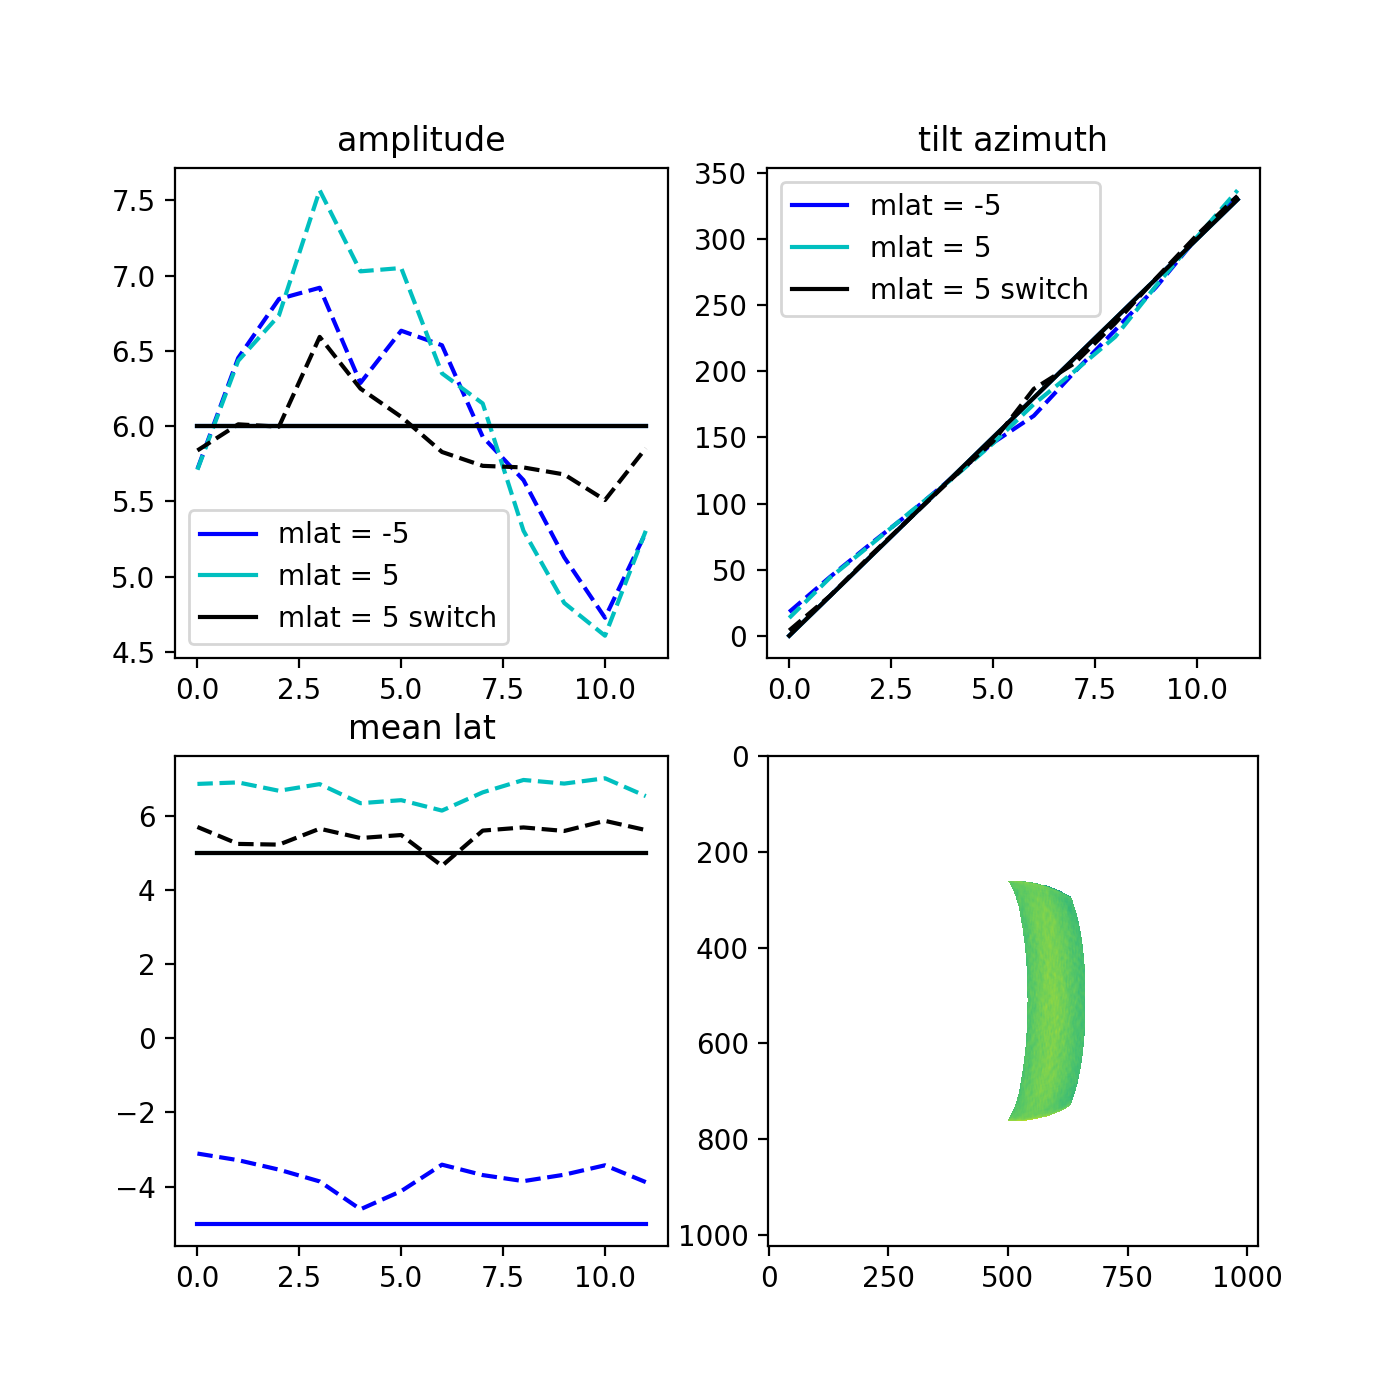

In [ ]:
plt.close(fig)
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(7,7))

# ax1.plot(indataarr[:,0],'b',label="amp = 6")
# ax1.plot(outdataarr[:,0],'b--')
# ax1.plot(indata15arr[:,0],'c',label="amp = 1.5")
# ax1.plot(outdata15arr[:,0],'c--')
# ax1.plot(indata10arr[:,0],'k',label="amp = 10")
# ax1.plot(outdata10arr[:,0],'k--')
# ax1.legend()
# ax1.set_title("amplitude")

# ax2.plot(indataarr[:,1],'b',label="amp = 6")
# ax2.plot(outdataarr[:,1],'b--')
# ax2.plot(indata15arr[:,1],'c',label="amp = 1.5")
# ax2.plot(outdata15arr[:,1],'c--')
# ax2.plot(indata10arr[:,1],'k',label="amp = 10")
# ax2.plot(outdata10arr[:,1],'k--')
# ax2.legend()
# ax2.set_title("tilt azimuth")

# ax3.plot(indataarr[:,2],'b')
# ax3.plot(outdataarr[:,2],'b--')
# ax3.plot(indata15arr[:,2],'c')
# ax3.plot(outdata15arr[:,2],'c--')
# ax3.plot(indata10arr[:,2],'k')
# ax3.plot(outdata10arr[:,2],'k--')
# ax3.set_title("mean lat")


ax1.plot(indataarr[:,0],'b',label="mlat = -5")
ax1.plot(outdataarr[:,0],'b--')
ax1.plot(indata15arr[:,0],'c',label="mlat = 5")
ax1.plot(outdata15arr[:,0],'c--')
ax1.plot(indata10arr[:,0],'k',label="mlat = 5 switch")
ax1.plot(outdata10arr[:,0],'k--')
ax1.legend()
ax1.set_title("amplitude")

ax2.plot(indataarr[:,1],'b',label="mlat = -5")
ax2.plot(outdataarr[:,1],'b--')
ax2.plot(indata15arr[:,1],'c',label="mlat = 5")
ax2.plot(outdata15arr[:,1],'c--')
ax2.plot(indata10arr[:,1],'k',label="mlat = 5 switch")
ax2.plot(outdata10arr[:,1],'k--')
ax2.legend()
ax2.set_title("tilt azimuth")

ax3.plot(indataarr[:,2],'b')
ax3.plot(outdataarr[:,2],'b--')
ax3.plot(indata15arr[:,2],'c')
ax3.plot(outdata15arr[:,2],'c--')
ax3.plot(indata10arr[:,2],'k')
ax3.plot(outdata10arr[:,2],'k--')
ax3.set_title("mean lat")

ax4.imshow(cropadgrad)

<IPython.core.display.Javascript object>


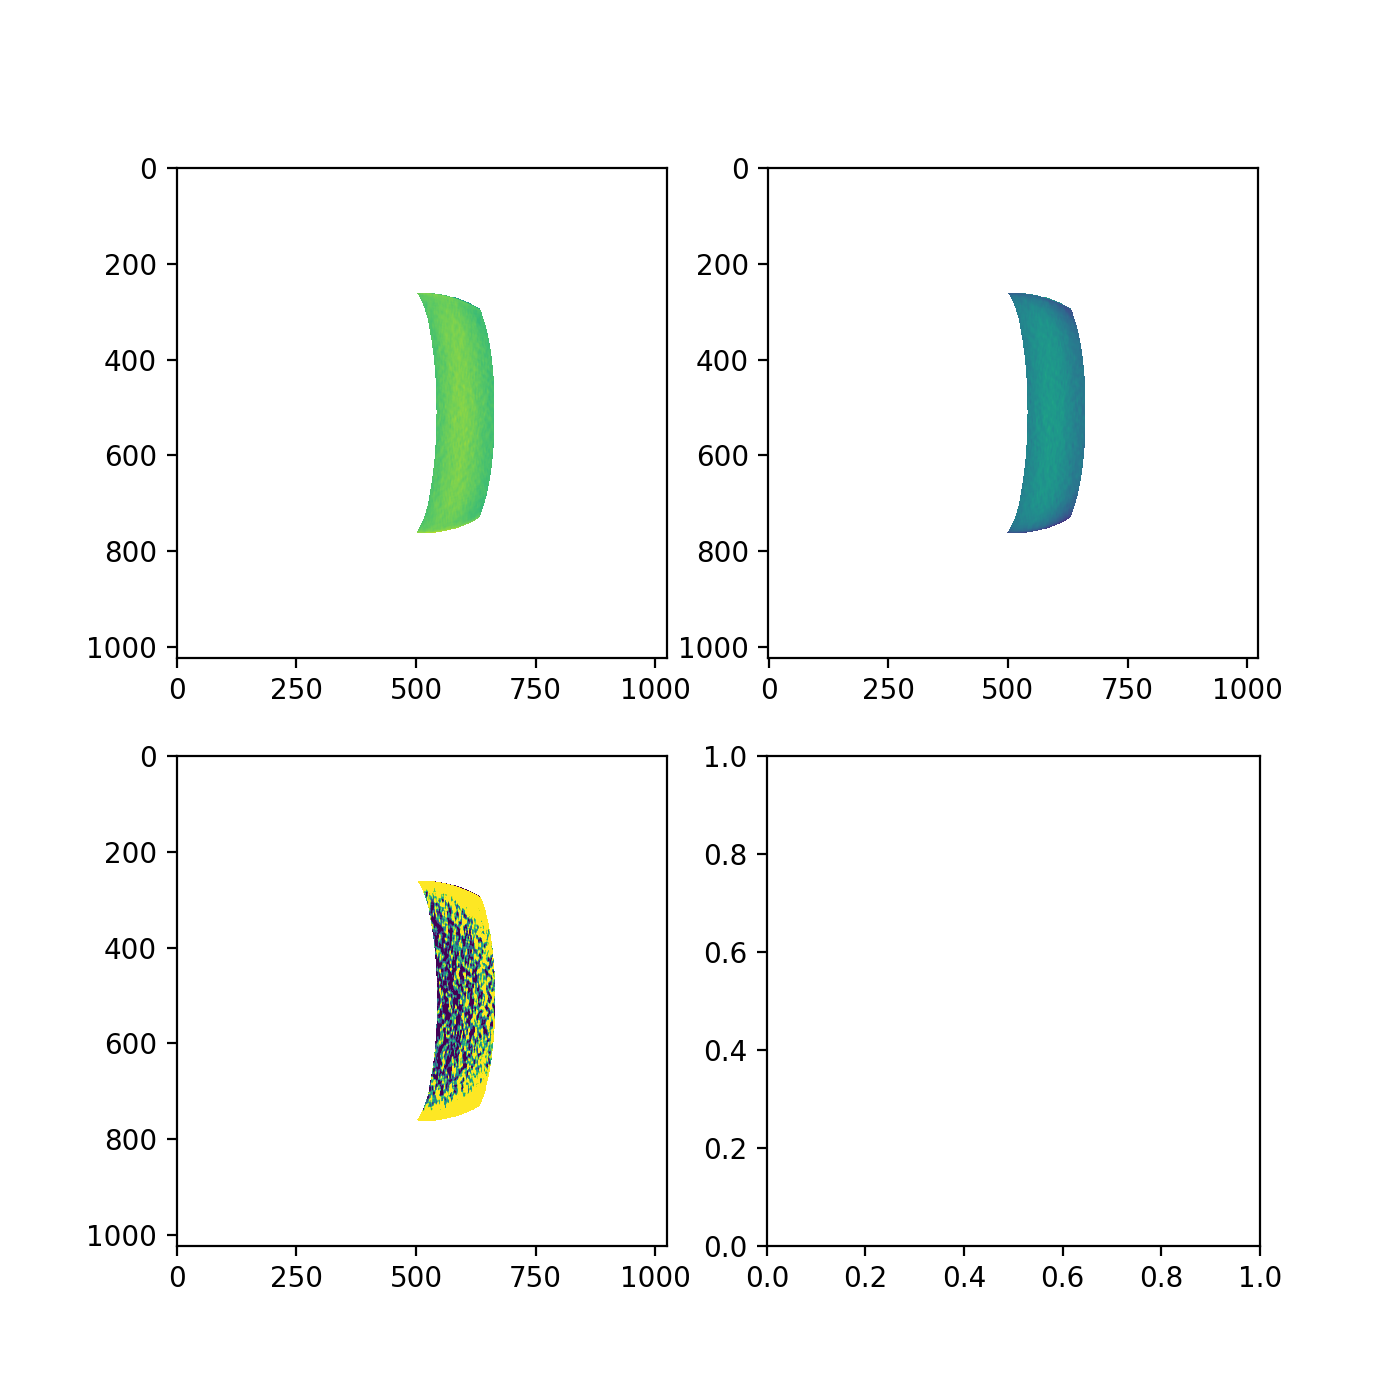

In [ ]:
plt.close(fig)
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(7,7))

ax1.imshow(cropadgrad)
ax2.imshow(cropadgrad2)
ax3.imshow(cropadgrad-cropadgrad2,vmin=0,vmax=5)

<IPython.core.display.Javascript object>


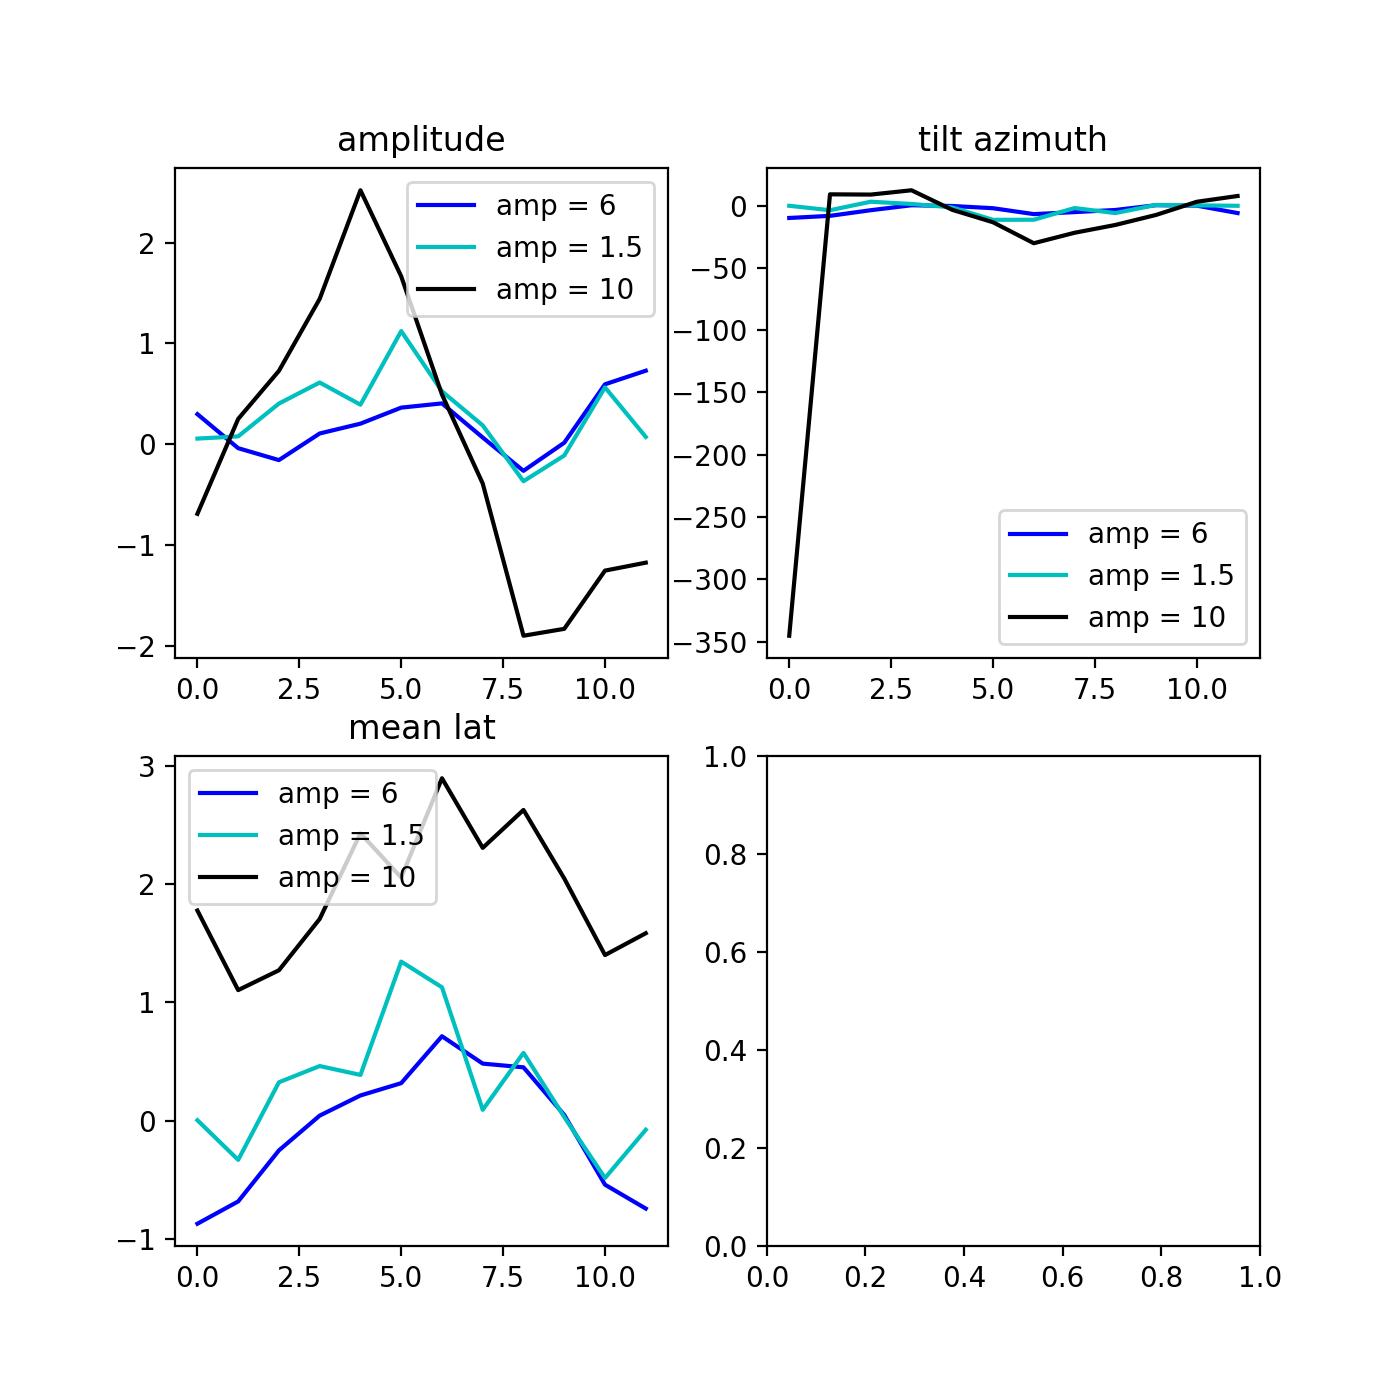

Text(0.5, 1.0, 'mean lat')

In [ ]:
plt.close(fig)
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(7,7))

ax1.plot(indataarr[:,0]-outdataarr[:,0],'b',label="amp = 6")
ax1.plot(indata15arr[:,0]-outdata15arr[:,0],'c',label="amp = 1.5")
ax1.plot(indata10arr[:,0]-outdata10arr[:,0],'k',label="amp = 10")
ax1.legend()
ax1.set_title("amplitude")

ax2.plot(indataarr[:,1]-outdataarr[:,1],'b',label="amp = 6")
ax2.plot(indata15arr[:,1]-outdata15arr[:,1],'c',label="amp = 1.5")
ax2.plot(indata10arr[:,1]-outdata10arr[:,1],'k',label="amp = 10")
ax2.legend()
ax2.set_title("tilt azimuth")


ax3.plot(indataarr[:,2]-outdataarr[:,2],'b',label="amp = 6")
ax3.plot(indata15arr[:,2]-outdata15arr[:,2],'c',label="amp = 1.5")
ax3.plot(indata10arr[:,2]-outdata10arr[:,2],'k',label="amp = 10")
ax3.legend()
ax3.set_title("mean lat")



In [ ]:
"subsclat, subsclon, subsollon ", label['Caminfo']['Geometry']['SubSpacecraftLatitude'], label['Caminfo']['Geometry']['SubSpacecraftLongitude'], label['Caminfo']['Geometry']['SubSolarLongitude']

('subsclat, subsclon, subsollon ',
 -12.398198408761,
 250.04505006737,
 271.3638705317)

In [ ]:
nvecsph[0][0]

-32.02077793902641

In [ ]:
def cosfunc(angles,a,b,c,d,e,f,g,h):
    inc,emis = angles

#     part1 = (a+b*(1-np.cos(np.radians(emis)))**c)
#     part2 = (d+e*np.cos(np.radians(f*inc))**g)
#     part1 = (a+b*np.sin(np.radians(d*emis))**c)
    part2 = (d+e*np.cos(np.radians(.9*inc)))
    part1 = (f*(np.sqrt(a**2 - np.sin(np.radians(emis))**2) - np.cos(np.radians(emis))))

    return b*part1*part2



In [ ]:
col = 450
mask = np.where(np.isfinite(OGincArray[:,col]))

popt,pcov = curve_fit(cosfunc,(OGincArray[:,col][mask],OGemisArray[:,col][mask]),im[:,col][mask])
popt

/home/csnell/anaconda3/envs/isis/lib/python3.6/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


array([1.25122471, 0.49189745, 1.        , 0.2060977 , 0.71032915,
       0.42654532, 1.        , 1.        ])

<IPython.core.display.Javascript object>


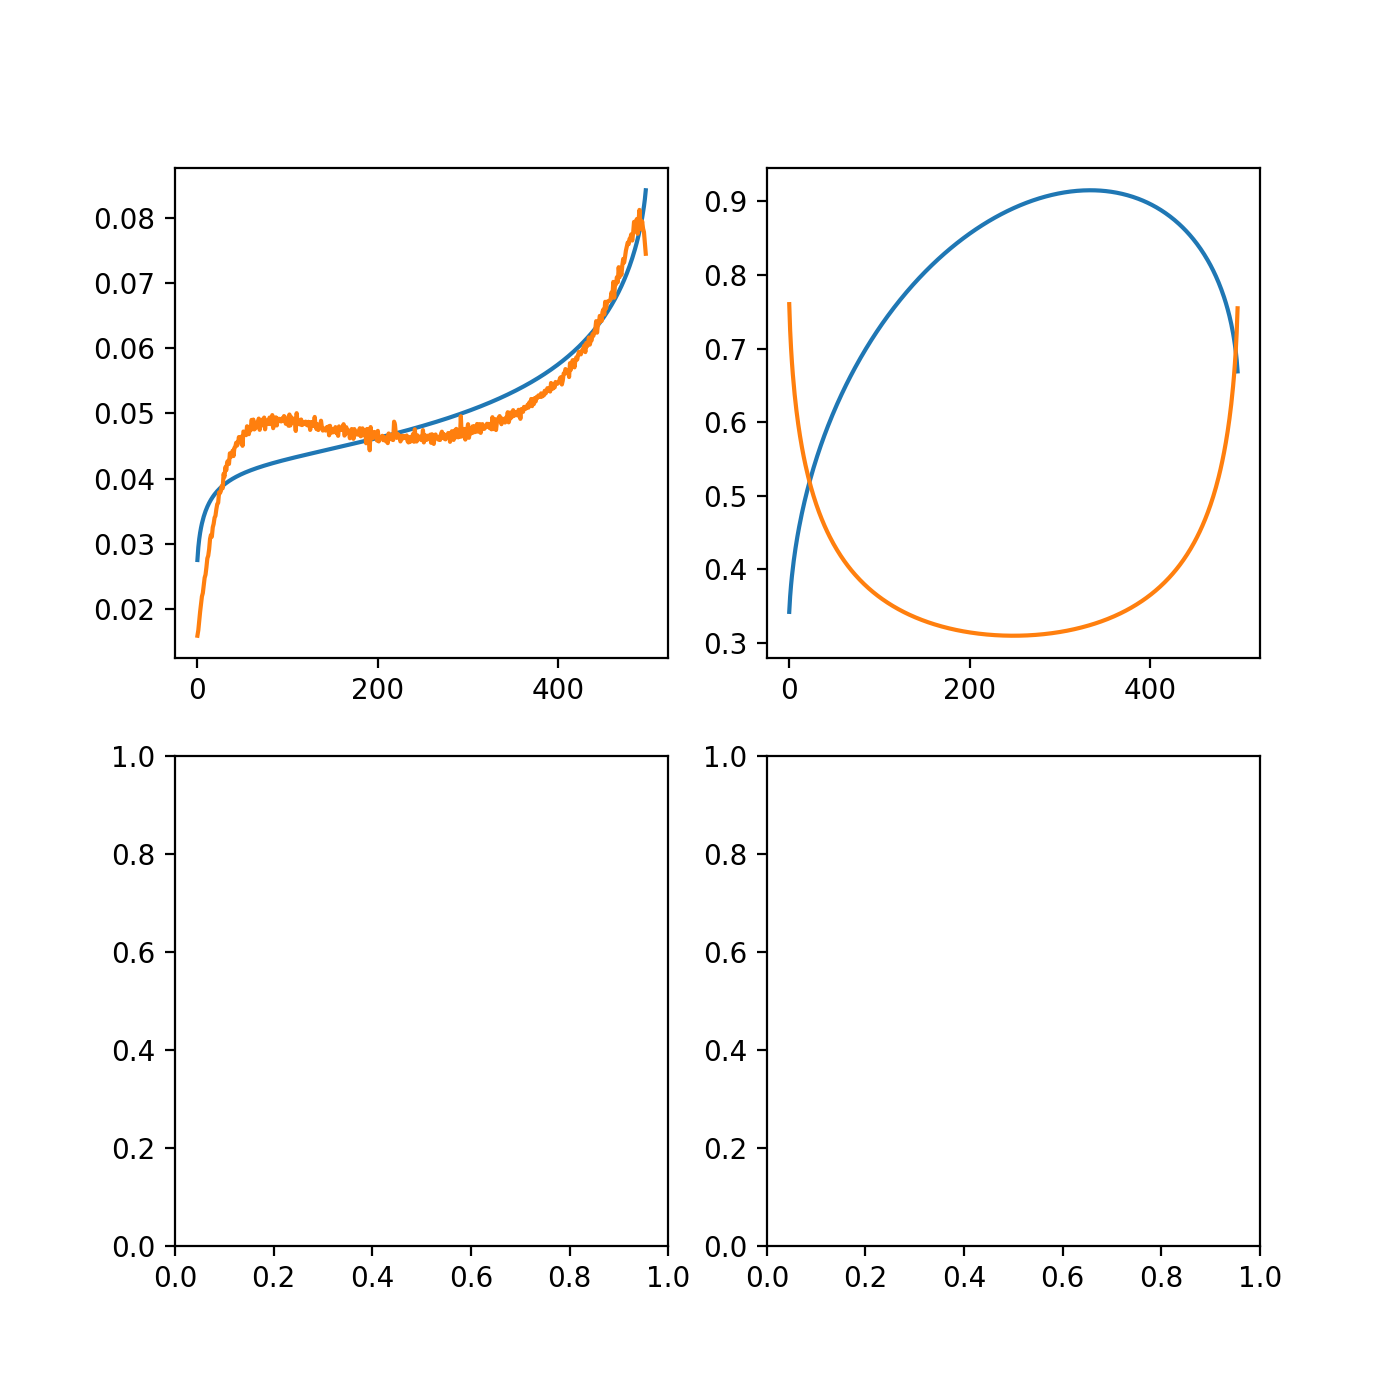

In [ ]:
plt.close(fig)
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(7,7))

ax1.plot(cosfunc((OGincArray[:,col][mask],OGemisArray[:,col][mask]),*popt))
ax1.plot(cropim[:,col][mask])
# ax2.plot(part2[:,col][mask])
ax2.plot((popt[3]+popt[4]*np.cos(np.radians(.78*OGincArray[:,col][mask]))**popt[6]))
# ax2.plot(.01*(popt[0]+popt[1]*np.sin(np.radians(1*OGemisArray[:,col][mask]))**popt[2]))
r = 1.1
ax2.plot(np.sqrt(1.3**2 - np.sin(np.radians(1*OGemisArray[:,col][mask]))**2) - np.cos(np.radians(1*OGemisArray[:,col][mask])))
# ax2.plot(np.sqrt(popt[0]**2 - np.sin(np.radians(popt[1]*OGemisArray[:,col][mask]))**2) - np.cos(np.radians(popt[1]*OGemisArray[:,col][mask])))

<IPython.core.display.Javascript object>


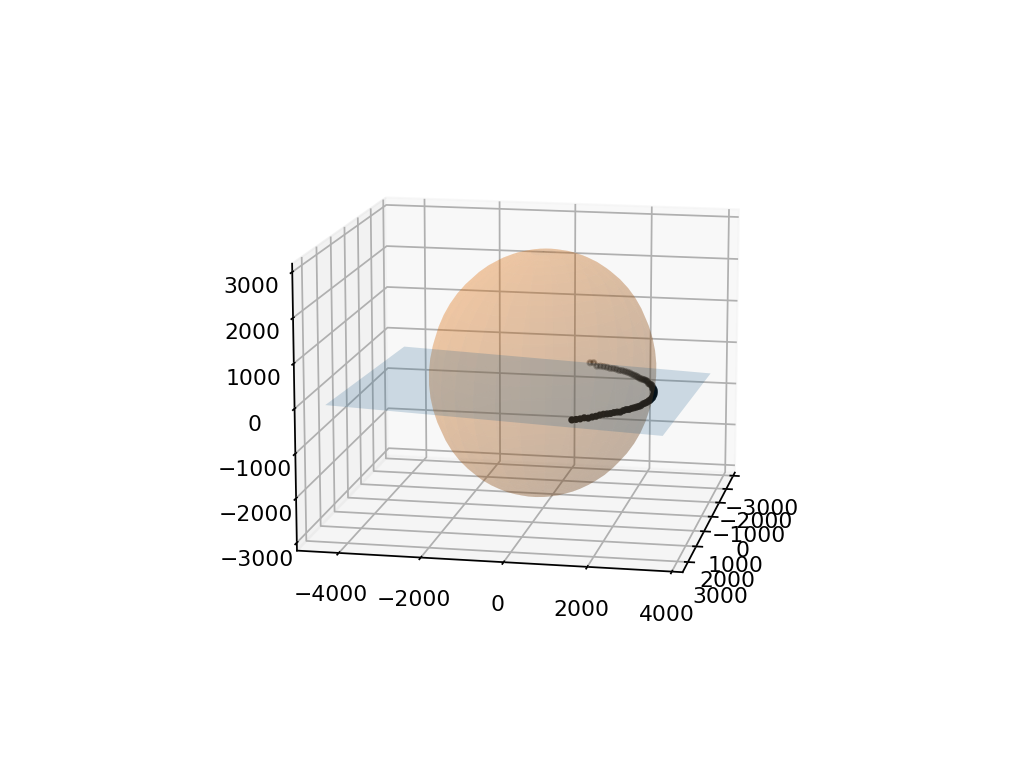

(<Figure size 640x480 with 1 Axes>, <Axes3DSubplot:>)

In [ ]:
from skspatial.objects import Points, Plane, Sphere
from skspatial.plotting import plot_3d
%matplotlib notebook

points = Points(carnpcoords)

plane = Plane.best_fit(points)

sphere = Sphere([0,0,0],2775)

plot_3d(
    points.plotter(c='k', s=5, depthshade=True),
    plane.plotter(alpha=0.2, lims_x=(-2500, 3500), lims_y=(-6500, 1600)),
    sphere.plotter(alpha=.2)
)

In [ ]:
sphere

Sphere(point=Point([0, 0, 0]), radius=2775)

In [ ]:
plane

Plane(point=Point([-305.2441924 , 2063.14114605, -464.66664086]), normal=Vector([-0.05074758,  0.04046185,  0.99789154]))

In [ ]:
plane.cartesian()

(-0.050747581629719346,
 0.04046185362554028,
 0.9978915378736911,
 364.7179892147018)

In [ ]:
normalarr = np.asarray(plane.normal)
eqarr = np.asarray(plane.cartesian())
normalarr,eqarr

(array([-0.05074758,  0.04046185,  0.99789154]),
 array([-5.07475816e-02,  4.04618536e-02,  9.97891538e-01,  3.64717989e+02]))

In [ ]:
#meanlat

z1 = -(eqarr[3]/eqarr[2])
r = 2775 #or whatever, just same as sphere above
meanlat = np.degrees(np.arcsin(z1/r))
meanlat

-7.56827952061025

In [ ]:
normal = CartesianRepresentation(normalarr *u.km)

In [ ]:
normal

<CartesianRepresentation (x, y, z) in km
    (-0.05074758, 0.04046185, 0.99789154)>

In [ ]:
normalsph = SphericalRepresentation.from_cartesian(normal)

In [ ]:
normalsph

<SphericalRepresentation (lon, lat, distance) in (rad, rad, km)
    (2.4684905, 1.50584706, 1.)>

In [ ]:
azimuth, amp, unitvec = normalsph.lon.degree, normalsph.lat.degree, normalsph.distance.km
print("Mean Lat: {0}\nAzimuth: {1}\nAmplitude: {2}\nUnit Vector: {3}".format(meanlat,azimuth,90-amp,unitvec))

Mean Lat: -7.56827952061025
Azimuth: 141.43408759438375
Amplitude: 3.721318737503836
Unit Vector: 1.0


Amplitude=-1.120, phase=-5.068, offset=-8.534, freq.=0.902, ang freq=5.665


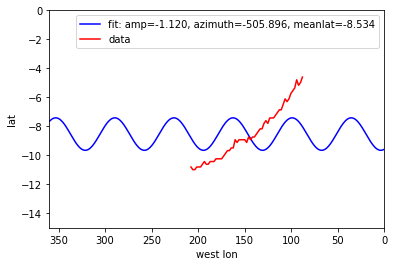

In [ ]:
import scipy.optimize
guess_amp = 0

def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = numpy.array(tt)
    yy = numpy.array(yy)
    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy))
    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_amp = 6
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * numpy.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: A * numpy.sin(w*t + p) + c
    return [A, w, p, c, f, 1./f, fitfunc, numpy.max(pcov), (guess,popt,pcov)]


import pylab

xrad = np.copy(x)
res = fit_sin(np.deg2rad(xrad), y)
print( "Amplitude=%5.3f, phase=%5.3f, offset=%5.3f, freq.=%5.3f, ang freq=%5.3f" % tuple([res[0],(res[2]),res[3],res[4],res[1]]))


allxrad = np.arange(0,360,0.1)
allxrad = np.asarray([360 - a for a in allxrad])

plt.plot(allx, res[6](np.deg2rad(allxrad)), 'b-', label='fit: amp=%5.3f, azimuth=%5.3f, meanlat=%5.3f' % tuple([res[0],(res[2]/res[1])*(360/2*np.pi),res[3]]))
plt.plot(x,y, 'r-', label='data')
plt.xlabel('west lon')
plt.ylabel('lat')
plt.xlim([360, 0])
plt.ylim([-15, 0])
plt.legend()



In [ ]:
ff = numpy.fft.fftfreq(len(x), (x[1]-x[0]))   # assume uniform spacing
Fyy = abs(numpy.fft.fft(y))
guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])
guess_freq

0.008200493416233903

In [ ]:
pylab.plot(allx, res[6](np.deg2rad(allx)), "-k", label="fit", linewidth=2)
pylab.plot(x, y, "ok", label="data")
pylab.legend(loc="best")
pylab.show()

In [ ]:
# allx = np.arange(0,360,0.1)
allx = np.asarray([360 - a for a in allx])
type(allx)

In [ ]:
numpy.std(y) * 2.**0.5

2.595457203110652

In [ ]:
x

[207.72654545454546,
 205.65970000000002,
 203.5928181818182,
 201.526,
 199.45911818181818,
 197.3923,
 195.32541818181818,
 193.2586,
 191.19172727272726,
 189.12490000000003,
 187.05802727272726,
 184.99119999999996,
 182.92430000000002,
 180.8575,
 178.7906090909091,
 176.7238,
 174.65690909090907,
 172.5901,
 170.52321818181818,
 168.4564,
 166.38949999999997,
 164.32269999999997,
 162.25580000000002,
 160.1889909090909,
 158.12210000000002,
 156.0553,
 153.98840909090907,
 151.9216,
 149.85469999999998,
 147.7879,
 145.721,
 143.65417272727274,
 141.58730000000003,
 139.52048181818182,
 137.45359999999994,
 135.3867909090909,
 133.3199,
 131.2531,
 129.1862,
 127.11937272727272,
 125.05249999999998,
 122.98567272727277,
 120.91879999999995,
 118.85197272727271,
 116.78510000000003,
 114.71828181818182,
 112.6514,
 110.58457272727276,
 108.51769999999996,
 106.45085454545458,
 104.38400000000001,
 102.31717272727269,
 100.25030000000004,
 98.1834454545455,
 96.11660000000006,
 94.

In [ ]:
min = np.nanmin(thingysub[:,lonleft:lonright])
max = np.nanmax(thingysub[:,lonleft:lonright])

In [ ]:
imshow(thingysub[:,lonleft:lonright], cmap='gray', vmin=min, vmax=max,
      extent=[thingylon[0,lonleft],thingylon[0,lonright],thingylat[-1,lonleft],thingylat[0,lonleft]])

In [ ]:
lonpix=[x*binwidth + (binwidth//2 + 1) + lonleft for x in lonbin]
thingysub[mins,lonpix] = 255

imshow(thingysub[:,lonleft:lonright], cmap='gray', vmin=min, vmax=max,
      extent=[thingylon[0,lonleft],thingylon[0,lonright],thingylat[-imageshift,lonleft],thingylat[imageshift,lonleft]])

In [ ]:
mins + imageshift

In [ ]:
thingysub.shape

In [ ]:
thingysub[mins[0],lonpix[0]]

In [ ]:
mins[0]

In [ ]:
len(thingysub)

In [ ]:
top,bottom

In [ ]:
array = np.asarray([[5,6,7,8,0,1,2,3,4],[5,6,7,8,0,1,2,3,4]])

In [ ]:
array

array([[5, 6, 7, 8, 0, 1, 2, 3, 4],
       [5, 6, 7, 8, 0, 1, 2, 3, 4]])

In [ ]:
middle = int(len(array[0])/2)

In [ ]:
len(array[0])/2

4.5

In [ ]:
lefthalf = array[:,:middle]
righthalf = array[:,middle:]

In [ ]:
lefthalf

array([[5, 6, 7, 8],
       [5, 6, 7, 8]])

In [ ]:
np.concatenate((righthalf,lefthalf),axis=1)

array([[0, 1, 2, 3, 4, 5, 6, 7, 8],
       [0, 1, 2, 3, 4, 5, 6, 7, 8]])

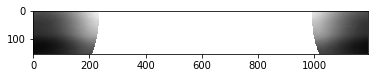

In [ ]:
filepath="0312MT3/N1750038546_1"
a_file = open(filepath + "_crop.txt", "r")
list_of_lists = [(line.strip()).split() for line in a_file]
a_file.close()
thing = list_of_lists[4:]
floatthing = [[np.nan if i == 'NULL' or i == 'HRS' else float(i) for i in j] for j in thing]
thingy = np.asarray(floatthing)

imshow(thingy,cmap="gray")

In [ ]:
#read in lat and lon maps
b_file = open(filepath + "_cubelat.txt", "r")
list_of_lists = [(line.strip()).split() for line in b_file]
b_file.close()

thinglat = list_of_lists[4:]
floatthinglat = [[np.nan if i == 'NULL' or i == 'HRS' else float(i) for i in j] for j in thinglat]
thingylat = np.asarray(floatthinglat)


c_file = open(filepath + "_cubelon.txt", "r")
list_of_lists = [(line.strip()).split() for line in c_file]
c_file.close()

thinglon = list_of_lists[4:]
floatthinglon = [[np.nan if i == 'NULL' or i == 'HRS' else float(i) for i in j] for j in thinglon]
thingylon = np.asarray(floatthinglon)

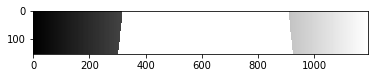

In [ ]:

imshow(thingylon,cmap="gray")

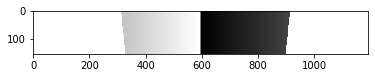

In [ ]:
middle = int(len(thingy[0])/2)
lefthalf = thingy[:,:middle]
righthalf = thingy[:,middle:]
thingynew = np.concatenate((righthalf,lefthalf),axis=1)
middle = int(len(thingylat[0])/2)
lefthalf = thingylat[:,:middle]
righthalf = thingylat[:,middle:]
thingylatnew = np.concatenate((righthalf,lefthalf),axis=1)
middle = int(len(thingylon[0])/2)
lefthalf = thingylon[:,:middle]
righthalf = thingylon[:,middle:]
thingylonnew = np.concatenate((righthalf,lefthalf),axis=1)

imshow(thingylonnew,cmap="gray")

In [ ]:
for i in thingylon[100]: print(i)

0.04363951
0.3458332
0.6480269
0.9502206
1.252414
1.554608
1.856802
2.158996
2.461189
2.763383
3.065577
3.36777
3.669964
3.972158
4.274352
4.576545
4.878739
5.180933
5.483127
5.78532
6.087514
6.389708
6.691901
6.994095
7.296289
7.598483
7.900676
8.20287
8.505064
8.807258
9.109451
9.411645
9.713839
10.01603
10.31823
10.62042
10.92261
11.22481
11.527
11.8292
12.13139
12.43358
12.73578
13.03797
13.34016
13.64236
13.94455
14.24674
14.54894
14.85113
15.15333
15.45552
15.75771
16.05991
16.3621
16.66429
16.96649
17.26868
17.57088
17.87307
18.17526
18.47746
18.77965
19.08184
19.38404
19.68623
19.98842
20.29062
20.59281
20.89501
21.1972
21.49939
21.80159
22.10378
22.40598
22.70817
23.01036
23.31256
23.61475
23.91694
24.21914
24.52133
24.82352
25.12572
25.42791
25.73011
26.0323
26.33449
26.63669
26.93888
27.24107
27.54327
27.84546
28.14766
28.44985
28.75204
29.05424
29.35643
29.65862
29.96082
30.26301
30.5652
30.8674
31.16959
31.47179
31.77398
32.07618
32.37837
32.68056
32.98275
33.28495
33.5871

In [ ]:
### filepath="0311MT3/N1477225220_2"
a_file = open(filepath + "_crop.txt", "r")
list_of_lists = [(line.strip()).split() for line in a_file]
a_file.close()
thing = list_of_lists[4:]
floatthing = [[np.nan if i == 'NULL' or i == 'HRS' else float(i) for i in j] for j in thing]
thingy2 = np.asarray(floatthing)

imshow(thingy2,cmap="gray")

In [ ]:
len(np.where(np.isfinite(thingy[:,0]))[0])

153

In [ ]:

def tosphcoordarray(lons,lats,semimaj,semimin):
    r = (semimaj*semimin)/np.sqrt((semimin*np.cos(np.radians(lats)))**2 + (semimaj*np.sin(np.radians(lats)))**2)
    sphcoords = []
    for i,j in enumerate(lons):
        sphcoords.append([j,lats[i],r[i]])

    return sphcoords


def planefit(abcd):
    a,b,c,d = abcd
    return (a*cartcoords[:,0] + b*cartcoords[:,1] + c*cartcoords[:,2] + d)/np.sqrt(a*a + b*b + c*c)



def find_nearest(array, value):
    return (np.abs(array - value)).argmin()

def cartosph(cart):
    sph = []

    for i in cart:
        r = np.sqrt(i[0]**2 + i[1]**2 + i[2]**2)
        theta = -np.degrees(np.arccos(i[2]/r)) + 90
        phi = np.degrees(np.arctan(i[1]/i[0]))
        if i[0] < 0: phi += 180

        sph.append([phi,theta,r])

    return sph

def cartosphrot(cart, tiltaz):
    sph = []

    for i in cart:
        r = np.sqrt(i[0]**2 + i[1]**2 + i[2]**2)
        theta = -np.degrees(np.arccos(i[2]/r)) + 90
        phi = np.degrees(np.arctan(i[1]/i[0]))
        if i[0] < 0: phi += 180
        phi += tiltaz #rotate phi back

        if phi > 360: phi -= 360
        elif phi < 0: phi += 360

        sph.append([phi,theta,r])

    return sph

def sphtocar(sph):
    cart = []

    for i in sph:
        x = i[2]*np.cos(np.radians(i[0]))*np.sin(np.radians(-(i[1]-90)))
        y = i[2]*np.sin(np.radians(i[0]))*np.sin(np.radians(-(i[1]-90)))
        z = i[2]*np.cos(np.radians(-(i[1]-90)))

        cart.append([x,y,z])

    return cart


def hemispheresim2d2(latlon, tiltamp,tiltaz,meanlat,dark,bright):

    tiltaz = 360 - tiltaz + 180
    radtiltamp = np.radians(tiltamp)

    Ry = [[np.cos(radtiltamp), 0, -np.sin(radtiltamp)],
          [0,                  1, 0                  ],
          [np.sin(radtiltamp), 0, np.cos(radtiltamp) ]]

    azx = np.linspace(0,360,numring)
    azy = np.full(np.shape(azx),meanlat)

    azxro = azx - tiltaz

    sph_azro = [[j,azy[i],1] for i,j in enumerate(azxro)]

    car_azro = sphtocar(sph_azro)

    carnpcoordsazro2 = [np.matmul(Ry, x2) for x2 in car_azro]

    sphaz = cartosphrot(carnpcoordsazro2,tiltaz)

    latbound = np.asarray(sphaz)[:,1]
    lonbound = np.asarray(sphaz)[:,0]

    minlat = np.nanmin(latbound)
    maxlat = np.nanmax(latbound)

    latarr,lonarr = latlon

#     match = np.where(latarr<minlat,0.046,0.06)
    match = np.where(latarr<minlat,dark,bright)

    match = np.where(np.isfinite(latarr),match,np.nan)

    for i,j in enumerate(latarr):
        for n,m in enumerate(j):
            if np.isfinite(m):
                if m < maxlat and m > minlat:
                    if m < latbound[find_nearest(lonbound,lonarr[i,n])]:
                        match[i,n] = dark


    return match

def hemispheresim2d2switch(latlon, tiltamp,tiltaz,meanlat,bright,dark):

    tiltaz = 360 - tiltaz + 180
    radtiltamp = np.radians(tiltamp)

    Ry = [[np.cos(radtiltamp), 0, -np.sin(radtiltamp)],
          [0,                  1, 0                  ],
          [np.sin(radtiltamp), 0, np.cos(radtiltamp) ]]

    azx = np.linspace(0,360,numring)
    azy = np.full(np.shape(azx),meanlat)

    azxro = azx - tiltaz

    sph_azro = [[j,azy[i],1] for i,j in enumerate(azxro)]

    car_azro = sphtocar(sph_azro)

    carnpcoordsazro2 = [np.matmul(Ry, x2) for x2 in car_azro]

    sphaz = cartosphrot(carnpcoordsazro2,tiltaz)

    latbound = np.asarray(sphaz)[:,1]
    lonbound = np.asarray(sphaz)[:,0]

    minlat = np.nanmin(latbound)
    maxlat = np.nanmax(latbound)

    latarr,lonarr = latlon

#     match = np.where(latarr<minlat,0.046,0.06)
    match = np.where(latarr<minlat,dark,bright)

    match = np.where(np.isfinite(latarr),match,np.nan)

    for i,j in enumerate(latarr):
        for n,m in enumerate(j):
            if np.isfinite(m):
                if m < maxlat and m > minlat:
                    if m < latbound[find_nearest(lonbound,lonarr[i,n])]:
                        match[i,n] = dark


    return match

def hemispheresim2d2grad(latlon, tiltamp,tiltaz,meanlat,dark,bright):

    tiltaz = 360 - tiltaz + 180
    radtiltamp = np.radians(tiltamp)

    Ry = [[np.cos(radtiltamp), 0, -np.sin(radtiltamp)],
          [0,                  1, 0                  ],
          [np.sin(radtiltamp), 0, np.cos(radtiltamp) ]]

    azx = np.linspace(0,360,numring)
    azy = np.full(np.shape(azx),meanlat)

    azxro = azx - tiltaz

    sph_azro = [[j,azy[i],1] for i,j in enumerate(azxro)]

    car_azro = sphtocar(sph_azro)

    carnpcoordsazro2 = [np.matmul(Ry, x2) for x2 in car_azro]

    sphaz = cartosphrot(carnpcoordsazro2,tiltaz)

    latbound = np.asarray(sphaz)[:,1]
    lonbound = np.asarray(sphaz)[:,0]

    minlat = np.nanmin(latbound)
    maxlat = np.nanmax(latbound)

    latarr,lonarr = latlon

#     match = np.where(latarr<minlat,0.046,0.06)
    match = np.empty(np.shape(latarr))

    translat = 12.

#     difffrac = (bright - dark)/2./translat
    diff2 = (bright-dark)/2.
    meanval = (bright+dark)/2.
    angfac = np.pi/2./translat

    for i,j in enumerate(latarr):
        for n,m in enumerate(j):
            if np.isfinite(m):
                templat = latbound[find_nearest(lonbound,lonarr[i,n])]
                if m < templat-translat:
                    match[i,n] = dark
                elif m > templat+translat:
                    match[i,n] = bright
                else:
#                     match[i,n] = meanval + (m-templat)*difffrac
                    match[i,n] = meanval + diff2*np.sin((m-templat)*angfac)


    match = np.where(np.logical_or(match<dark,match>bright),np.nan,match)

    return match

def hemispheresim2d2switchgrad(latlon, tiltamp,tiltaz,meanlat,bright,dark):

    tiltaz = 360 - tiltaz + 180
    radtiltamp = np.radians(tiltamp)

    Ry = [[np.cos(radtiltamp), 0, -np.sin(radtiltamp)],
          [0,                  1, 0                  ],
          [np.sin(radtiltamp), 0, np.cos(radtiltamp) ]]

    azx = np.linspace(0,360,numring)
    azy = np.full(np.shape(azx),meanlat)

    azxro = azx - tiltaz

    sph_azro = [[j,azy[i],1] for i,j in enumerate(azxro)]

    car_azro = sphtocar(sph_azro)

    carnpcoordsazro2 = [np.matmul(Ry, x2) for x2 in car_azro]

    sphaz = cartosphrot(carnpcoordsazro2,tiltaz)

    latbound = np.asarray(sphaz)[:,1]
    lonbound = np.asarray(sphaz)[:,0]

    minlat = np.nanmin(latbound)
    maxlat = np.nanmax(latbound)

    latarr,lonarr = latlon

#     match = np.where(latarr<minlat,0.046,0.06)
    match = np.empty(np.shape(latarr))

    translat = 12.

#     difffrac = (bright - dark)/2./translat
    diff2 = (bright-dark)/2.
    meanval = (bright+dark)/2.
    angfac = np.pi/2./translat

    for i,j in enumerate(latarr):
        for n,m in enumerate(j):
            if np.isfinite(m):
                templat = latbound[find_nearest(lonbound,lonarr[i,n])]
                if m < templat-translat:
                    match[i,n] = dark
                elif m > templat+translat:
                    match[i,n] = bright
                else:
#                     match[i,n] = meanval + (m-templat)*difffrac
                    match[i,n] = meanval + diff2*np.sin((m-templat)*angfac)

    match = np.where(np.logical_or(match>dark,match<bright),np.nan,match)

    return match

In [ ]:
directorystr = "MT3more/"
# fname = 'N1466071301_1'
# fname = 'N1477225220_2'
# fname = 'N1857458792_1'
# fname = 'W1539141648_1'
# fname = 'N1843448762_1'
fname = 'N1842357655_1'

filepath = directorystr + fname

a_file = open(filepath + "_incidence.txt", "r")
list_of_lists = [(line.strip()).split() for line in a_file]
a_file.close()
incArray = np.asarray(list_of_lists[4:])
nanIncArray = np.where(np.logical_or(incArray == 'NULL', incArray == 'HRS'), np.nan, incArray)
OGincArray =nanIncArray.astype(np.float)

a_file = open(filepath + "_emission.txt", "r")
list_of_lists = [(line.strip()).split() for line in a_file]
a_file.close()
emisArray = np.asarray(list_of_lists[4:])
nanEmisArray = np.where(np.logical_or(emisArray == 'NULL', emisArray == 'HRS'), np.nan, emisArray)
OGemisArray = nanEmisArray.astype(np.float)

a_file = open(filepath + "_cal_lat.txt", "r")
list_of_lists = [(line.strip()).split() for line in a_file]
a_file.close()
latArray = np.asarray(list_of_lists[4:])
nanLatArray = np.where(np.logical_or(latArray == 'NULL', latArray == 'HRS'), np.nan, latArray)
OGlatArray = nanLatArray.astype(np.float)

a_file = open(filepath + "_cal_lon.txt", "r")
list_of_lists = [(line.strip()).split() for line in a_file]
a_file.close()
lonArray = np.asarray(list_of_lists[4:])
nanLonArray = np.where(np.logical_or(lonArray == 'NULL', lonArray == 'HRS'), np.nan, lonArray)
OGlonArray = nanLonArray.astype(np.float)

a_file = open(filepath + "_PREMAP.txt", "r")
# a_file = open(directorystr + "Limb/" + fname + "_limbavg.txt", "r")
# a_file = open(directorystr + "Limb/" + fname + "_custom4.txt", "r")
list_of_lists = [(line.strip()).split() for line in a_file]
a_file.close()
mapArray = np.asarray(list_of_lists[4:])
# mapArray = np.asarray(list_of_lists) #change this too!!
mapArray = np.where(np.logical_or(mapArray == 'NULL', mapArray == 'HRS'), np.nan, mapArray)
OGim = mapArray.astype(np.float)

nansinimage = np.logical_and(OGincArray<89,~np.isfinite(OGim))

if len(np.where(nansinimage)[0]) > 0:
    OGim[nansinimage] = np.interp(np.flatnonzero(nansinimage), np.flatnonzero(~nansinimage),OGim[~nansinimage])
#     OGim[nansinimage] = np.nanmean(im)
    print("Bad pixels in image: {0}".format(len(np.where(nansinimage)[0])))

label = pvl.load(filepath + "_INFO.pvl")
try:
    pixres = label['Caminfo']['Geometry']['PixelResolution']
    crad = label['Caminfo']['Geometry']['CenterRadius']
    numring = int(np.round(2*np.pi*crad/pixres))
    SSL = 360 - label['Caminfo']['Geometry']['SubSolarLongitude']
except:
    numring = len(OGim)

time = label['Caminfo']['Geometry']['EndTime']

In [ ]:
pixres

24962.040280517

N1842357655_1 [516, 516, 516, 517, 517, 520, 517, 519, 516, 518, 518, 518, 515, 517, 517, 517, 517, 516, 517, 517, 517, 517, 516, 515, 514, 515, 517, 513, 512, 513, 515, 512, 512, 515, 513, 512, 515, 515, 515, 512, 512, 515, 516, 513, 518, 521, 520, 520, 522, 521, 521, 521, 521, 521, 521, 520, 518, 517, 517, 519, 520, 521, 522, 521, 522, 523, 524, 524, 523, 525, 525, 525, 525, 526, 526, 526, 526, 527, 526, 526, 527, 527, 527, 527, 527, 528, 528, 529, 529, 530, 530, 531, 531, 530, 527, 527, 528, 528, 529, 530] [527, 525, 524, 522, 521, 520, 519, 518, 516, 515, 514, 513, 512, 511, 510, 509, 509, 507, 506, 506, 504, 503, 502, 500, 496, 498, 497, 492, 491, 490, 491, 487, 486, 487, 483, 482, 483, 482, 480, 477, 476, 476, 475, 472, 473, 471, 470, 469, 467, 466, 465, 464, 462, 461, 460, 458, 457, 455, 454, 453, 451, 450, 449, 448, 447, 446, 444, 443, 442, 441, 439, 438, 437, 435, 434, 433, 432, 430, 429, 427, 427, 425, 423, 422, 421, 420, 419, 417, 416, 415, 414, 413, 411, 410, 408, 407, 406,

<IPython.core.display.Javascript object>


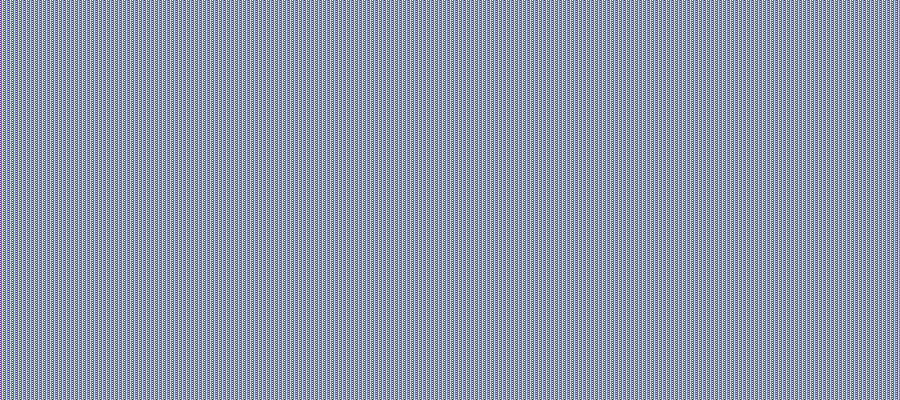

In [ ]:
blat = 37
denom = 4

im = np.copy(OGim)

im = signal.medfilt2d(im,3)

boxsize = 11

avgblur = np.ones((boxsize,boxsize))

imin = signal.convolve2d(im, avgblur, boundary='symm', mode='same')

imin = np.where(np.logical_and(OGincArray<75,OGemisArray<75),imin,np.nan)

kx = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
ky = np.array([[-1,-1,-1] ,[0,0,0], [1,1,1]])

xlattest = np.where(np.isfinite(imin),np.nan,np.nan)
ylattest = np.where(np.isfinite(imin),np.nan,np.nan)
xgradtest = np.where(np.isfinite(imin),np.nan,np.nan)
ygradtest = np.where(np.isfinite(imin),np.nan,np.nan)

for i,j in enumerate(imin):
    if i>0 and i<len(imin)-2:
        for n,m in enumerate(j):
            if np.isfinite(m) and n>0 and n<len(j)-2:
                imbox = np.array([[imin[i-1,n-1],imin[i-1,n],imin[i-1,n+1]],
                                  [imin[i,n-1],imin[i,n],imin[i,n+1]],
                                  [imin[i+1,n-1],imin[i+1,n],imin[i+1,n+1]]])
                if len(np.where(np.isfinite(imbox))[0])<9: continue
                else:
                    ylat = OGlatArray[i,n] - OGlatArray[i-1,n]
                    xlat = OGlatArray[i,n] - OGlatArray[i,n-1]

                    tot = np.sqrt(xlat**2 + ylat**2)
                    xlat = xlat/tot
                    ylat = ylat/tot

                    xlattest[i,n] = xlat
                    ylattest[i,n] = ylat

                    xgradtest[i,n] = np.sum(kx*imbox)
                    ygradtest[i,n] = np.sum(ky*imbox)


slope = np.where(np.isfinite(ylattest/xlattest),(ylattest/xlattest),np.nan)

xfact = np.where(np.isfinite(slope),1,np.nan)
xfact = np.where(xlattest<0,-1,xfact)
xfact = np.where(slope>100,0,xfact)
yfact = slope
yfact = np.where(xlattest<0,-slope,yfact)

normfact = np.abs(xfact) + np.abs(yfact)

xfact /= normfact
yfact /= normfact



slopeswitch = xfact*xgradtest + yfact*ygradtest
slopeswitch2 = np.abs(yfact*xgradtest + (-1*xfact)*ygradtest)

hemisphereSwitch = np.nanmean(np.where(OGlatArray>0,im,np.nan)) < np.nanmean(np.where(OGlatArray<0,im,np.nan))

# hemisphereSwitch = False

if hemisphereSwitch:
    slopeswitch *= -1

cropadgrad2 = np.where(np.logical_and(OGlatArray<blat+15,OGlatArray>blat-15),slopeswitch,np.nan)

# if hemisphereSwitch:
#     cropadgrad2 = np.where(np.logical_and(OGlatArray<7,OGlatArray>-23),slopeswitch,np.nan)
# #     cropadgrad2 = np.where(np.logical_and(OGlatArray<23,OGlatArray>-7),slopeswitch,np.nan)
# else:
#     cropadgrad2 = np.where(np.logical_and(OGlatArray<7,OGlatArray>-23),slopeswitch,np.nan)
# #     cropadgrad2 = np.where(np.logical_and(OGlatArray<23,OGlatArray>-7),slopeswitch,np.nan)


# denom = 4
# if fname == "N1845483375_1":
#     cropadgrad2 = np.where(np.logical_and(OGlatArray<15,OGlatArray>-5),slopeswitch,np.nan)
#     denom = 7



# if fname.startswith("N18382") or fname.startswith("N1839"):
#     cropadgrad2 = np.where(np.logical_and(OGlatArray<20,OGlatArray>5),slopeswitch,np.nan)
#     denom = 7
#     if fname == 'N1839513938_1':
#         slopeswitch2 *= -100


cropadgrad2thresh = np.zeros(np.shape(cropadgrad2))

croplat = np.where(np.isfinite(cropadgrad2),OGlatArray,np.nan)
croplon = np.where(np.isfinite(cropadgrad2),OGlonArray,np.nan)

latnum = len(np.where(np.isfinite(cropadgrad2))[0])
latslicenum = 2500
latslices = latnum//latslicenum
if latnum%latslicenum > 0.5*latslicenum:
    latslices += 1

ind = croplat.argsort(axis=None)
xloc = ind//len(im)
yloc = ind%len(im[0])
flatlon = croplon.flatten()
if 360-np.nanmax(flatlon) < 10 and np.nanmin(flatlon) < 10:
    flatlon = np.where(flatlon>180,flatlon-360,flatlon)
lonslices = 100

slicearray = np.full(np.shape(im),np.nan)

for i in range(latslices):
    if i == latslices-1:
        latend = latnum
    else:
        latend = latslicenum*(i+1)

    ind2 = flatlon[ind[latslicenum*i:latend]].argsort(axis=None)
    lonnum = len(ind2)
    lonslicenum = lonnum//lonslices

    for j in range(lonslices):
        if j == lonslices-1:
            lonend = lonnum
        else:
            lonend = lonslicenum*(j+1)

        xtemp = xloc[latslicenum*i:latend][ind2[lonslicenum*j:lonend]]
        ytemp = yloc[latslicenum*i:latend][ind2[lonslicenum*j:lonend]]
        slicearray[xtemp,ytemp] = j


imlen = len(im)
imind = np.empty((2,imlen,imlen),dtype=int)

for i in range(imlen):
    for j in range(imlen):
        imind[0:2,i,j] = (i,j)


for i in range(lonslices):
    lonmask = slicearray == i

    num = len(cropadgrad2[lonmask])//denom #larger denominator seems better for later images with weaker boundaries

    ind = np.argpartition(cropadgrad2[lonmask], -num)[-num:] #locates num brightest pixels

    cropadgrad2thresh[imind[0][lonmask][ind],imind[1][lonmask][ind]] = 1

edge = np.where(np.isfinite(cropadgrad2),cropadgrad2thresh,np.nan)
sobelthresh = np.copy(edge)

meanx = []
meany = []

for i in range(lonslices):

    lonmask = slicearray == i

    tempmean = np.nanmean(sobelthresh[lonmask])

    if tempmean > 0:
        lonslice = np.where(lonmask,sobelthresh,np.nan)
        points = np.where(lonslice==1)

#         weights = cropadgrad2[points]
#         weights -= np.min(weights)
#         meanx.append(np.sum(points[0] * weights) / np.sum(weights))
#         meany.append(np.sum(points[1] * weights) / np.sum(weights))

        meanx.append(np.nanmedian(points[0]))
        meany.append(np.nanmedian(points[1]))

    else:
        meanx.append(np.nan)
        meany.append(np.nan)


meanx = np.asarray(meanx,dtype=float)
meany = np.asarray(meany,dtype=float)

nonanx = []
nonany = []

for i,j in enumerate(meanx):
    if np.isfinite(meanx[i]):
        nonanx.append(int(np.round(meanx[i])))
        nonany.append(int(np.round(meany[i])))

print("{0} {1} {2}".format(fname, nonanx, nonany))

imb2 = np.copy(imin)
imb2[nonanx,nonany] = np.nanmax(imin)

plt.close(fig)
fig, (ax,ax2) = plt.subplots(1,2,figsize=(9,4))

ax.imshow(imb2)

edgetest = np.copy(edge)
edgetest[nonanx,nonany] = np.nan
ax2.imshow(edgetest)

In [ ]:


lons = OGlonArray[nonanx,nonany]
lats = OGlatArray[nonanx,nonany]

Q1 = np.percentile(lats, 25, interpolation = 'midpoint')
Q3 = np.percentile(lats, 75, interpolation = 'midpoint')
IQR = Q3 - Q1

fac = 1.

upperorlower = np.logical_or(lats>=(Q3+fac*IQR), lats<=(Q1-fac*IQR))

oldlen = len(lats)

trim = 2

# lats = lats[~upperorlower][7:]
# lons = lons[~upperorlower][7:]

lats = lats[~upperorlower]
lons = lons[~upperorlower]

# lats = lats[~upperorlower][trim:-trim]
# lons = lons[~upperorlower][trim:-trim]

# mask = np.full(np.shape(lats),True)
# mask[trim:-trim] = False
# lats = lats[mask]
# lons = lons[mask]

print("lat/lon arrays trimmed from {0} to {1}\n".format(oldlen,len(lats)))

semimaj = 2771.0
semimin = 2691.2
sphcoords = tosphcoordarray(lons,lats,semimaj,semimin)

cartcoords = sphtocar(sphcoords)
cartcoords = np.asarray(cartcoords)

print("a,b,c,d")
abcdest = 0,0,1,np.nanmean(lats)*100
# plane = optimize.least_squares(planefit, abcdest)  #,bounds=([0,0,1,0.975*bguess], [h,w,1.05,1.025*bguess])
# plane = optimize.least_squares(planefit, abcdest ,bounds=([-1.,-1.,-1.,-2000], [1,1,1,2000])) #([-1,-1,1,-1000], [1.1,1.1,1.1,1001])
plane = optimize.least_squares(planefit, abcdest) #([-1,-1,1,-1000], [1.1,1.1,1.1,1001])



a,b,c,d = plane.x


norm = np.sqrt(a*a + b*b + c*c)
a,b,c,d = (a,b,c,d)/norm

print(a,b,c,d)


z1 = -d/c
meanlat = np.degrees(np.arctan(z1/(semimaj*np.sqrt(1-(z1/semimin)**2))))
if z1*meanlat<0: meanlat *= -1
nvecsph = cartosph([[a,b,c]])
azimuth2, amp = 360 - nvecsph[0][0], 90 - nvecsph[0][1]
if azimuth2 > 360: azimuth2 -= 360



print("\nimageID   amp   az      mlat   SSL    offset  time")
print("Observed: {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}  {}".format(amp,azimuth2,meanlat,SSL,azimuth2-SSL,time))
# print("Actual:   {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}".format(testvals[0],testvals[1],testvals[2],SSL,testvals[1]-SSL))


lat/lon arrays trimmed from 100 to 90

a,b,c,d
0.025313653238562155 -0.004503101397321298 0.99966941587583 -2038.1533411379926

imageID   amp   az      mlat   SSL    offset  time
Observed: 1.47  10.09  48.42  322.31  -312.22  2016-05-19 12:55:02.839000


In [ ]:
plane.x, pixres

(array([ 1.92328854e-02,  9.05357983e-02,  7.03002846e-01, -6.72229700e+02]),
 13401.057682475)

<IPython.core.display.Javascript object>


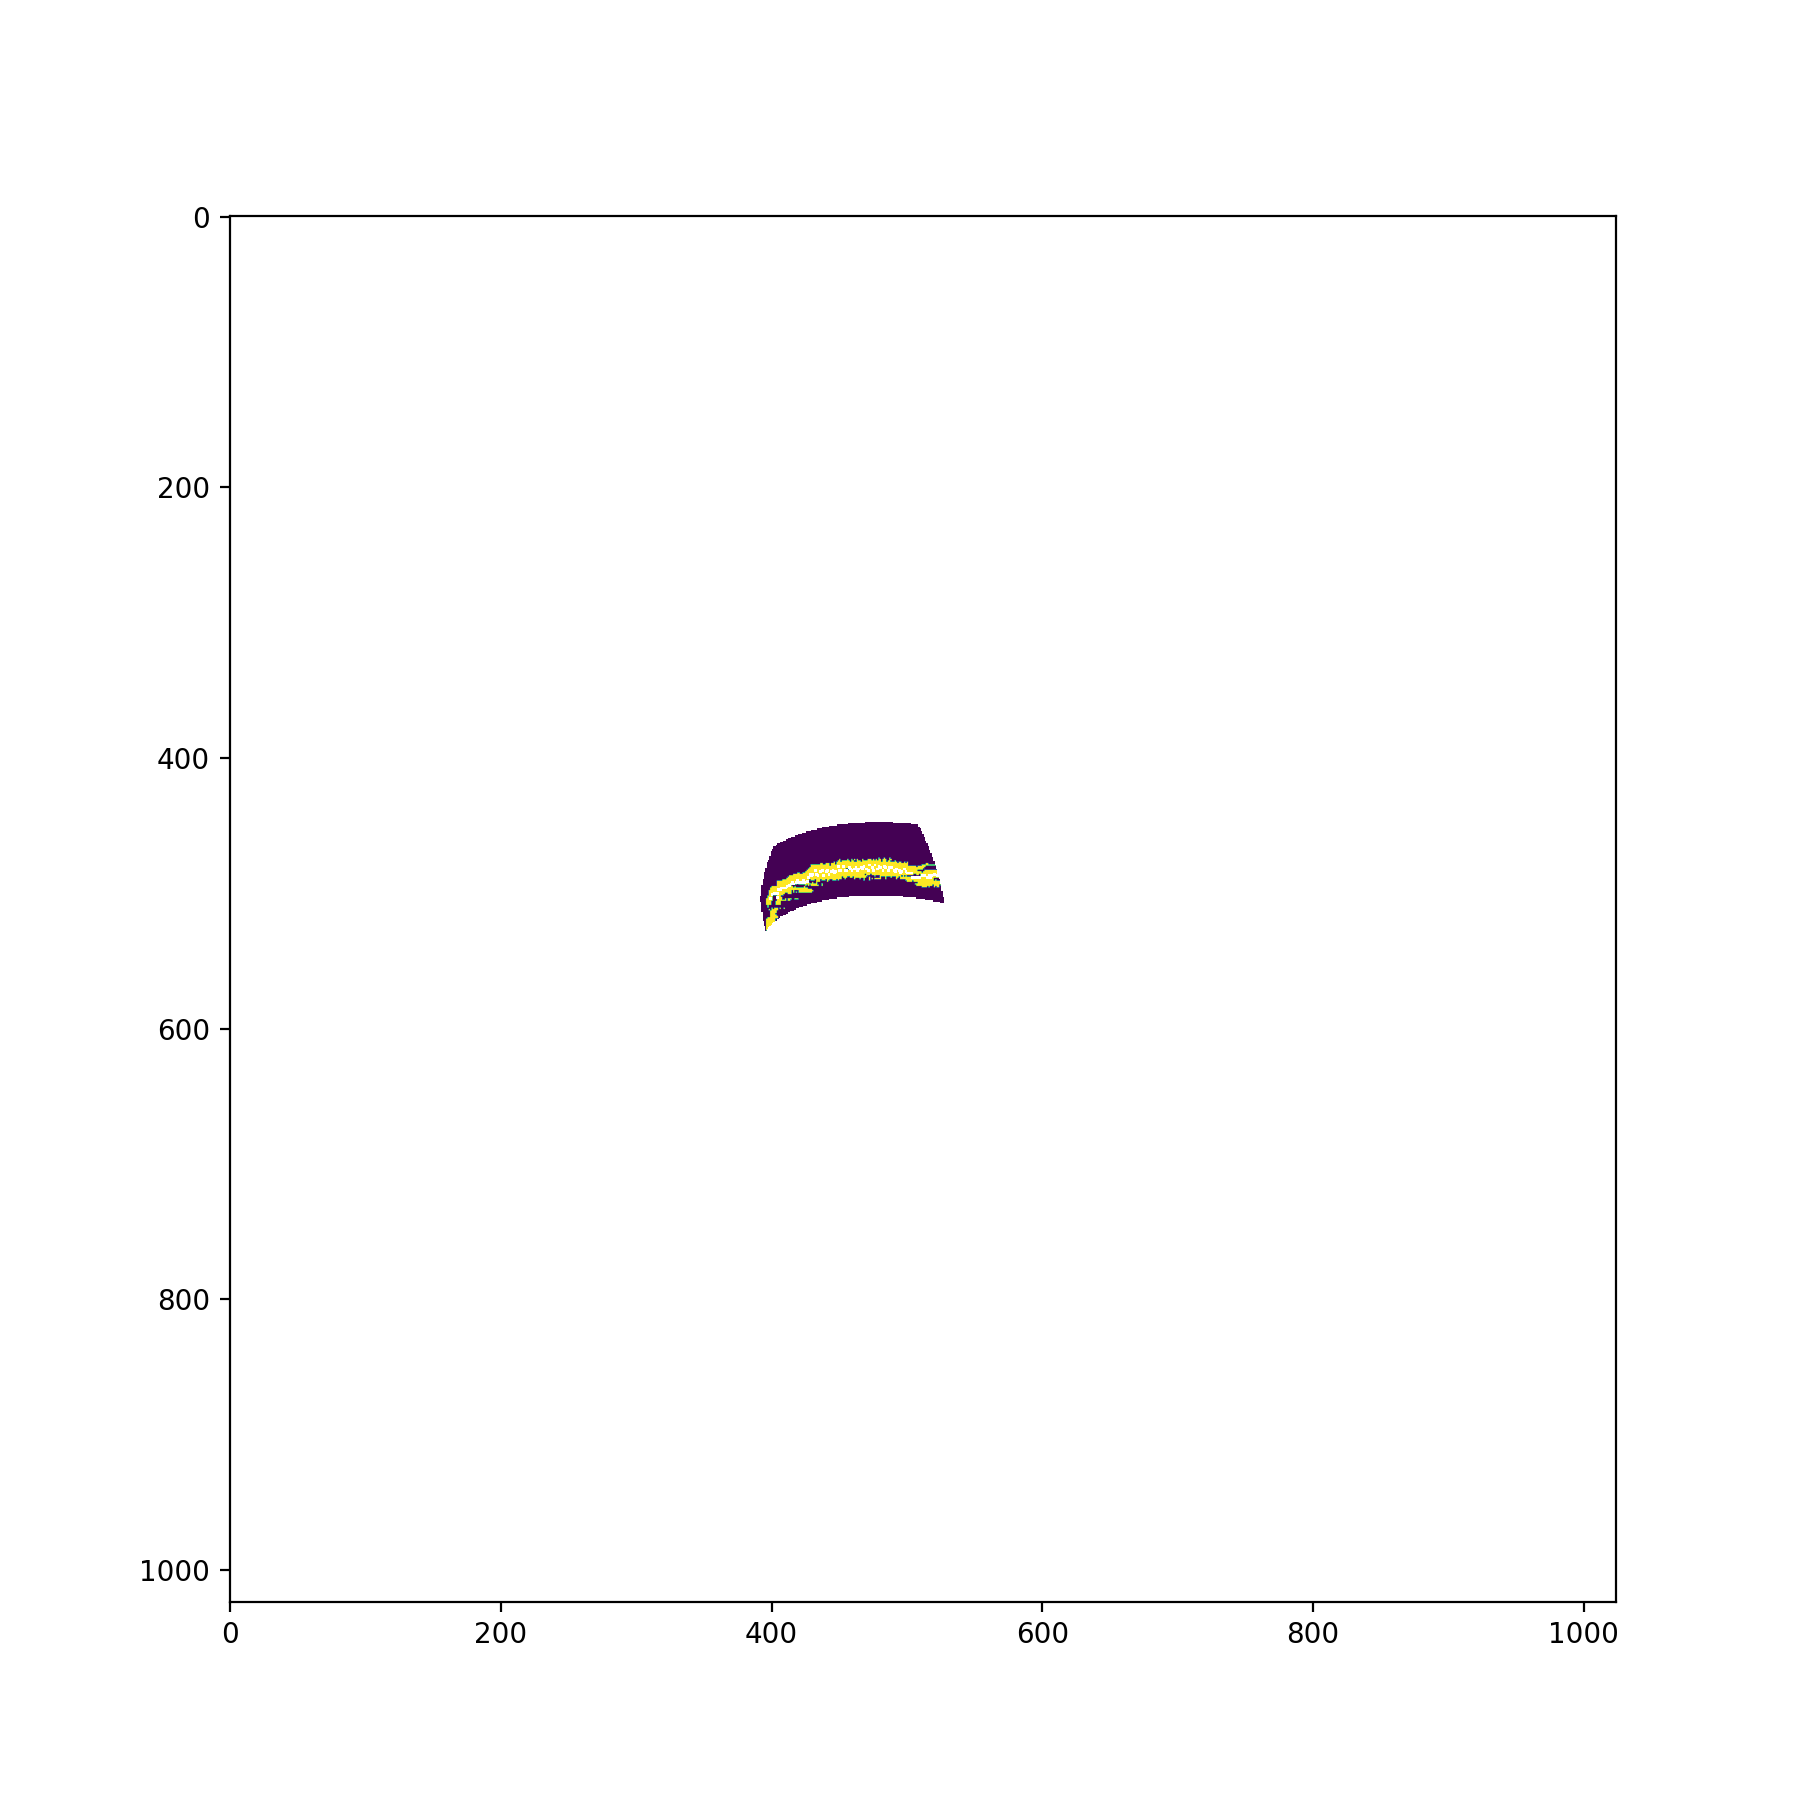

In [ ]:
plt.close(fig)
fig, ax = plt.subplots(figsize=(9,9))

edgetest = np.copy(edge)

arx = np.asarray(nonanx)
ary = np.asarray(nonany)

noxt = arx[~upperorlower]
noyt = ary[~upperorlower]
# noxt = arx[~upperorlower][trim:-trim]
# noyt = ary[~upperorlower][trim:-trim]
# noxt = arx[mask]
# noyt = ary[mask]
edgetest[noxt,noyt] = np.nan
# edgetest[np.where(np.round(OGlatArray)==12)] = .5
# edgetest[nonanx,nonany] = np.nan
ax.imshow(edgetest)

In [ ]:
lat/lon arrays trimmed from 100 to 92

a,b,c,d
-0.0038233961346675295 0.018509006810573207 0.9998213832024615 -572.2672536729541

imageID   amp   az      mlat   SSL    offset  time
Observed: 1.08  258.33  11.94  302.45  -44.13  2016-11-10 07:39:03.198000

SyntaxError: invalid syntax (<ipython-input-134-28ee8ea04b52>, line 1)

In [ ]:
lat/lon arrays trimmed from 100 to 85

a,b,c,d
0.008236308987979401 -0.034656099128119205 0.999365357618262 -475.49962137228704

imageID   amp   az      mlat   SSL    offset  time
Observed: 2.04  76.63  9.90  219.10  -142.47  2014-09-16 03:25:53.746000


lat/lon arrays trimmed from 100 to 87

a,b,c,d
0.004394072498325836 0.12868782811773838 0.9916754181793652 235.79944838288353

imageID   amp   az      mlat   SSL    offset  time
Observed: 7.40  271.96  -4.92  219.10  52.85  2014-09-16 03:25:53.746000


lat/lon arrays trimmed from 100 to 89

a,b,c,d
0.0383444592074567 -0.08768632731929533 0.9954098705806272 -320.19095906035767

imageID   amp   az      mlat   SSL    offset  time
Observed: 5.49  66.38  6.67  219.10  -152.72  2014-09-16 03:25:53.746000


lat/lon arrays trimmed from 100 to 90

a,b,c,d
0.03190153932236238 0.021938237325708987 0.9992502216821892 551.2534977638795

imageID   amp   az      mlat   SSL    offset  time
Observed: 2.22  325.48  -11.50  219.10  106.38  2014-09-16 03:25:53.746000


<IPython.core.display.Javascript object>


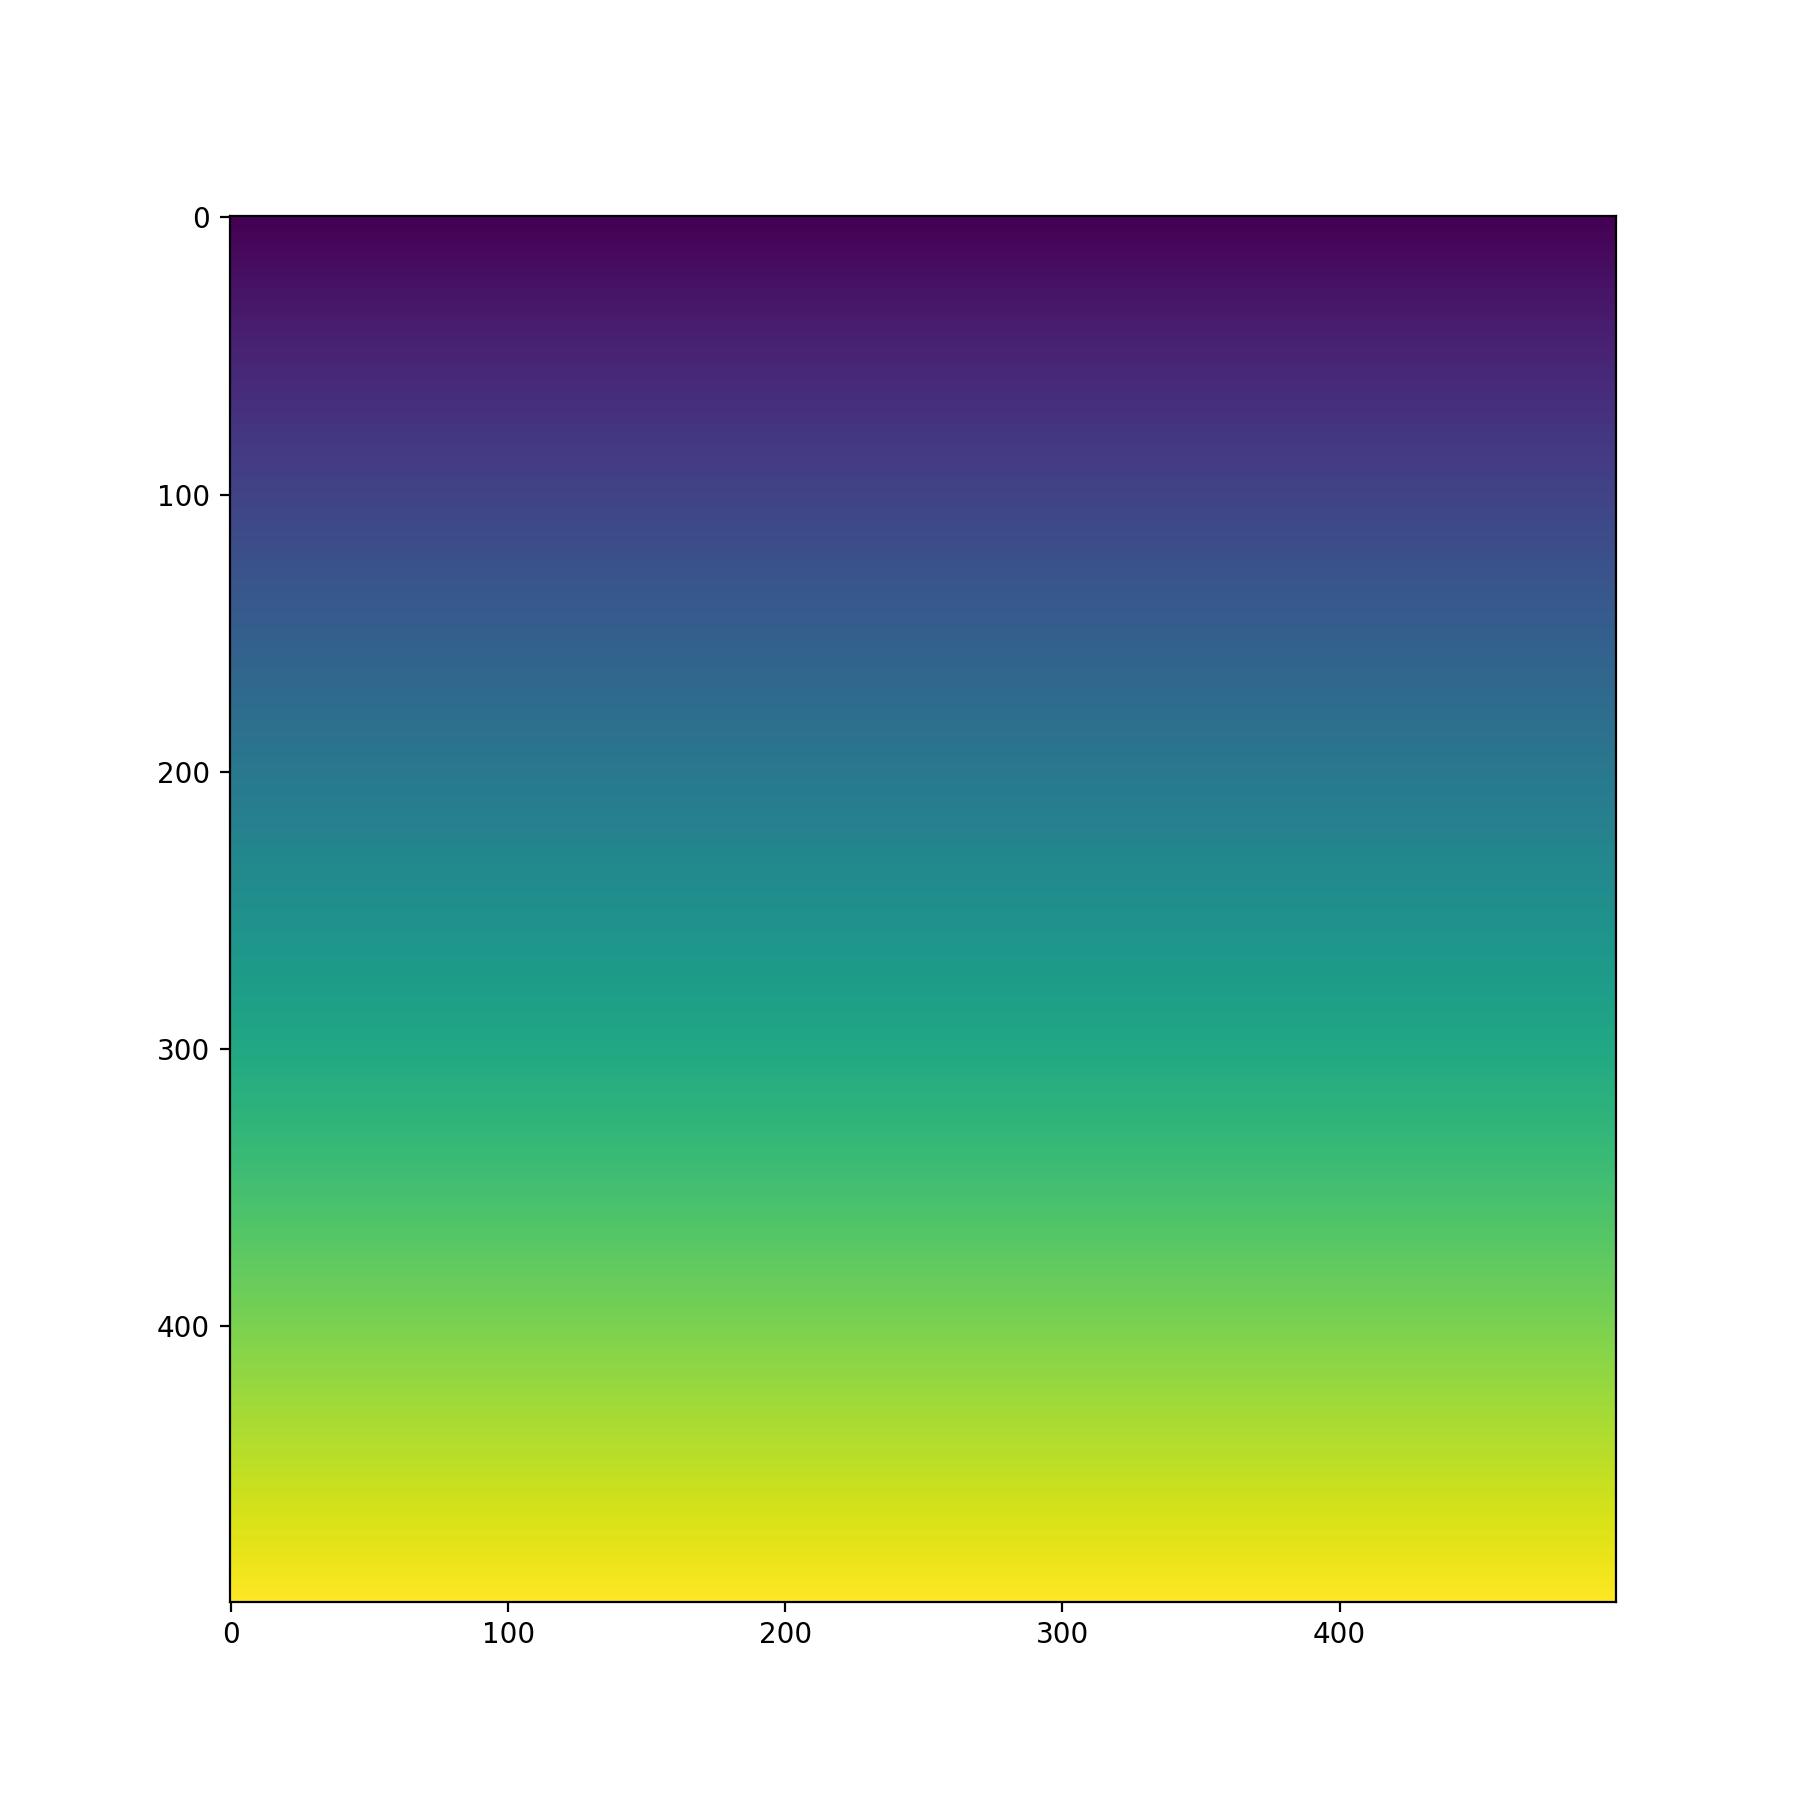

In [ ]:


plt.close(fig)
fig, ax = plt.subplots(figsize=(9,9))

ax.imshow(np.mgrid[:500,:500][0])

In [ ]:
s = 300
e = 700

imtest = np.where(np.logical_and(OGincArray<85,OGemisArray<77),im,np.nan)[s:e,s:e]
latr = np.round(OGlatArray)[s:e,s:e]
lonr = np.round(OGlonArray)[s:e,s:e]

SSL2 = label['Caminfo']['Geometry']['SubSolarLongitude']
SCL = label['Caminfo']['Geometry']['SubSpacecraftLongitude']
SSLat2 = label['Caminfo']['Geometry']['SubSolarLatitude']
SCLat = label['Caminfo']['Geometry']['SubSpacecraftLatitude']

<IPython.core.display.Javascript object>


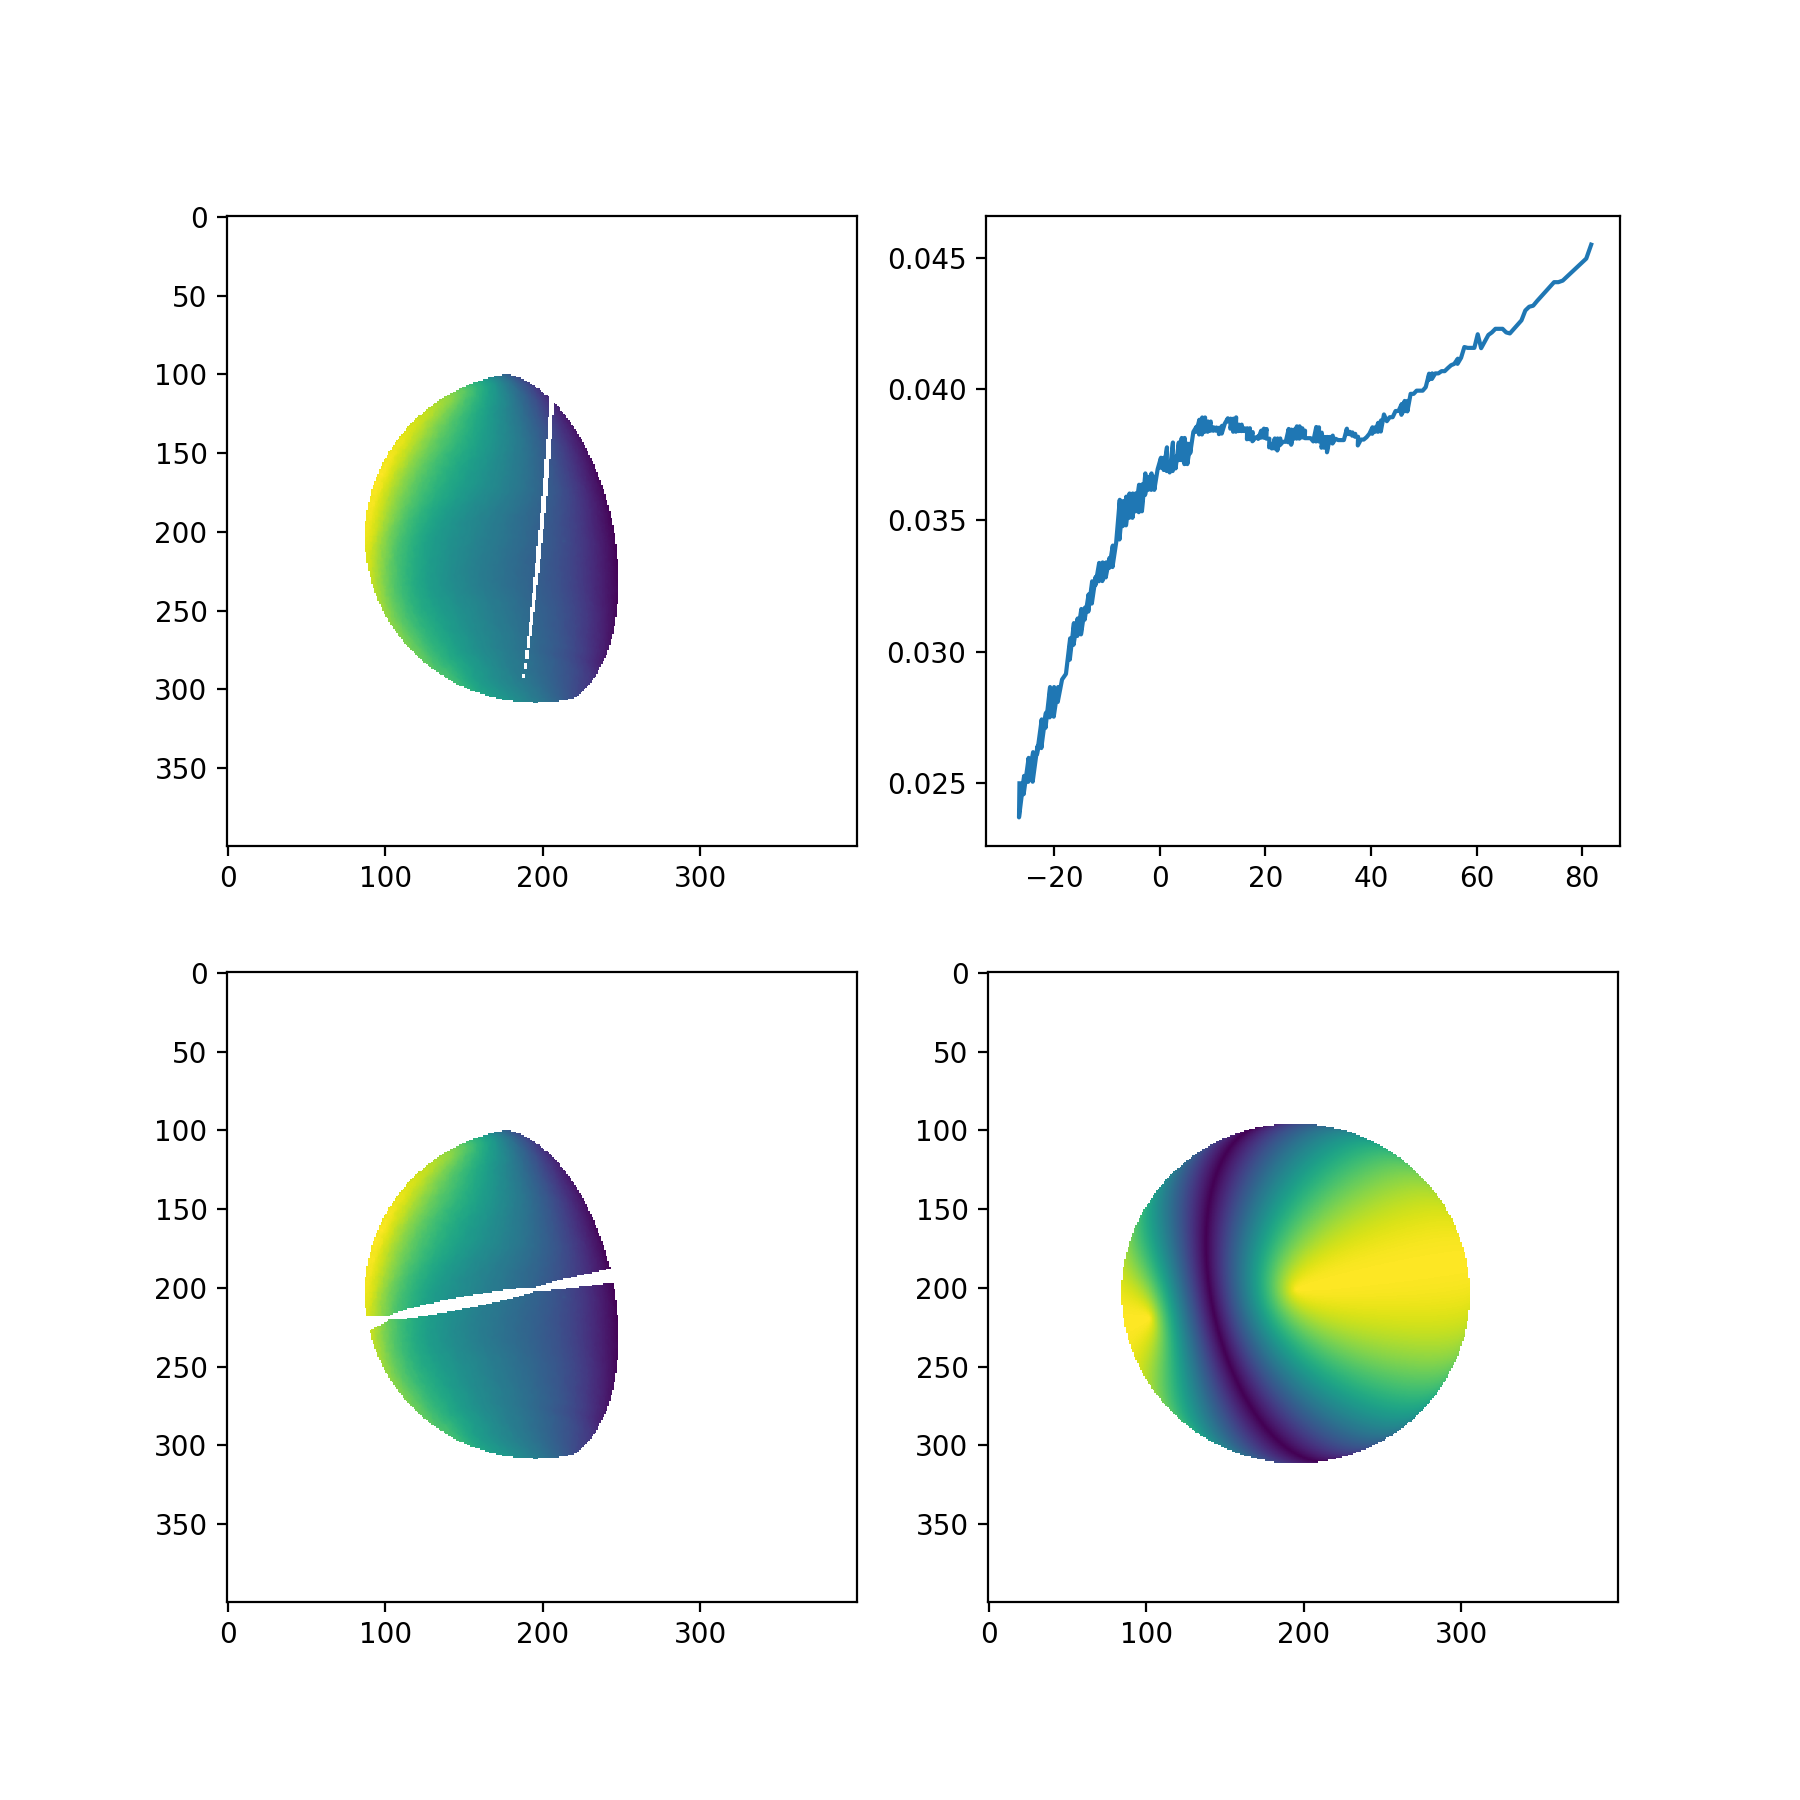

In [ ]:
plt.close(fig)
fig, ((ax,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(9,9))

lontest = 330
ax.imshow(np.where(lonr==lontest,np.nan,imtest))

ax2.plot(OGlatArray[s:e,s:e][lonr==lontest],imtest[lonr==lontest])

phaseact = 360-SSL2-(360-SCL)
phasetest = 58
ax3.imshow(np.where(np.logical_or(np.abs(OGincArray[s:e,s:e]-OGemisArray[s:e,s:e])>phasetest-.1,OGincArray[s:e,s:e]+OGemisArray[s:e,s:e]<phasetest+.1),np.nan,imtest))

# ax4.imshow(OGincArray[s:e,s:e])
# ax4.imshow(OGemisArray[s:e,s:e])
ax4.imshow(np.abs(OGincArray[s:e,s:e]-OGemisArray[s:e,s:e]))
# ax4.imshow(np.abs(OGincArray[s:e,s:e]+OGemisArray[s:e,s:e]))

# ax2.plot(OGlatArray[s:e,s:e][lonr==lontest],imtest[lonr==lontest])

In [ ]:
phaseact,SSL

(294.54979600779, 322.30860609108)

In [ ]:
# + < 59, - > 57


In [ ]:
SSpix = np.nanargmin(np.abs(OGlatArray[s:e,s:e]-SSLat2)+np.abs(OGlonArray[s:e,s:e]-SSL2))
# SSpix = np.nanargmin(OGincArray[s:e,s:e])
SSpixx = SSpix//len(imtest)
SSpixy = SSpix%len(imtest)

SCpix = np.nanargmin(np.abs(OGlatArray[s:e,s:e]-SCLat)+np.abs(OGlonArray[s:e,s:e]-SCL))
# SCpix = np.nanargmin(OGemisArray[s:e,s:e])
SCpixx = SCpix//len(imtest)
SCpixy = SCpix%len(imtest)

SSpixx,SSpixy,SCpixx,SCpixy

(222, 103, 204, 195)

In [ ]:
slopephase = (SCpixy-SSpixy)/(SCpixx-SCpixy)
slopevert = -1./slopephase
slopephase,slopevert

(10.222222222222221, -0.09782608695652174)

In [ ]:
imlen = len(imtest)
imwid = len(imtest[0])
m = 0.5 * slopephase
# m = 2. * slopevert
# m = -.5


if m < -1:
    numyints = int(imwid-1-m*(imlen-1))
    minyint = 0
    print('-1',numyints)

elif m < 0:
    numyints = int(imlen-1-m*(imwid-1))
    minyint = 0
    print('0',numyints)

elif m < 1:
    numyints = (imlen - 1) - int(-m*(imwid-1))
    minyint = -m*(imwid-1)
    print('1',numyints)

else:
    numyints = (imwid - 1) - int(-m*(imlen-1))
    minyint = -m*(imlen-1)
    print('>1',numyints)


# if m < -1:
#     numyints = int(imlen-1+m*(imwid-1))
#     minyint = 0
#     print('-1',numyints)

# elif m < 0:
#     numyints = int(imwid-1+m*(imlen-1))
#     minyint = 0
#     print('0',numyints)

# elif m < 1:
#     numyints = (imlen - 1) - int(-m*(imwid-1))
#     minyint = -m*(imwid-1)
#     print('1',numyints)

# else:
#     numyints = (imwid - 1) - int(-m*(imlen-1))
#     minyint = -m*(imlen-1)
#     print('>1',numyints)


slants = [[] for j in range(numyints+1)]
xs = [[] for j in range(numyints+1)]
ys = [[] for j in range(numyints+1)]
yints = []

for x in range(0,imlen):
    for y in range(0,imwid):
        yint = int(y - m*x - minyint)
        yints.append(yint)
        if yint == 0: print('zero')
        slants[yint].append(imtest[y,x])
        xs[yint].append(y)
        ys[yint].append(x)

>1 2438
zero


In [ ]:
yint,numyints,x,y,minyint

(399, 2438, 399, 399, -2039.3333333333333)

In [ ]:
numyints,np.nanmax(yints)

(2438, 2438)

In [ ]:
int(imwid-1+m*(imlen-1)),int(imlen-1+m*(imwid-1)),(imlen - 1) - int(-m*(imwid-1)),(imwid - 1) - int(-m*(imlen-1))

(6583, 6583, 6583, 6583)

In [ ]:
SSpix2 = np.nanargmin(OGincArray[s:e,s:e])
SSpix2//len(imtest),SSpix2%len(imtest)

(219, 102)

In [ ]:
OGlatArray[s:e,s:e][SSpix//len(imtest),SSpix%len(imtest)],OGlonArray[s:e,s:e][SSpix//len(imtest),SSpix%len(imtest)],OGlatArray[s:e,s:e][SSpix2//len(imtest),SSpix2%len(imtest)],OGlonArray[s:e,s:e][SSpix2//len(imtest),SSpix2%len(imtest)]

(26.49391, 37.68058, 24.82948, 37.56686)

In [ ]:
SSL2 = label['Caminfo']['Geometry']['SubSolarLongitude']
SCL = label['Caminfo']['Geometry']['SubSpacecraftLongitude']
SSLat2 = label['Caminfo']['Geometry']['SubSolarLatitude']
SCLat = label['Caminfo']['Geometry']['SubSpacecraftLatitude']
SSL2,SSLat2,SCL,SCLat

(37.69139390892, 26.193320801125, 332.24118991671, 26.378313212537)

<IPython.core.display.Javascript object>


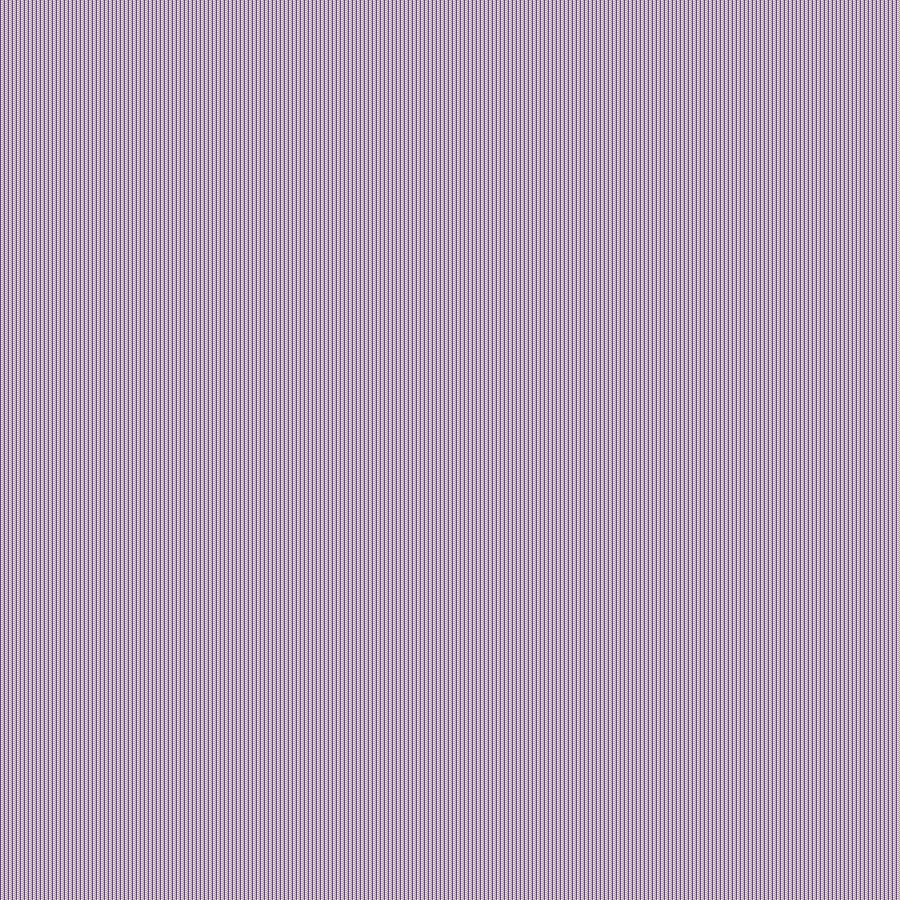

(0.0, 0.1)

In [ ]:
imhoriz = np.where(np.logical_or(np.abs(OGincArray[s:e,s:e]-OGemisArray[s:e,s:e])>phasetest-.1,OGincArray[s:e,s:e]+OGemisArray[s:e,s:e]<phasetest+.1),np.nan,imtest)
imhoriz[SSpixx:SSpixx+2,SSpixy:SSpixy+2] = np.nanmax(imhoriz)
imhoriz[SCpixx:SCpixx+2,SCpixy:SCpixy+2] = np.nanmin(imhoriz)


plt.close(fig)
fig, ((ax,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(9,9))

# slanttest = numyints//2
slanttest = int(numyints//1.7)


xs2 = []
ys2 = []

for i in range(10):
    for j in xs[slanttest+i]:
        xs2.append(j)
    for j in ys[slanttest+i]:
        ys2.append(j)

ax.plot(slants[slanttest],'.')

ax2.plot(imtest[xs2,ys2],'.')

# copytest = np.copy(imtest)
copytest = np.copy(imhoriz)

for i in range(10):
    copytest[xs[slanttest+i],ys[slanttest+i]] = np.nan

ax3.imshow(copytest)

for i in range(10):
#     ax4.plot(latr[xs[slanttest+i],ys[slanttest+i]],imtest[xs[slanttest+i],ys[slanttest+i]],'.')
    ax4.plot(xs[slanttest+i],imtest[xs[slanttest+i],ys[slanttest+i]]/OGincArray[s:e,s:e][xs[slanttest+i],ys[slanttest+i]]*90,'b.')
    ax4.plot(xs[slanttest+i],imtest[xs[slanttest+i],ys[slanttest+i]]/np.sin(np.radians(OGincArray[s:e,s:e][xs[slanttest+i],ys[slanttest+i]])),'r.')
    ax4.plot(xs[slanttest+i],imtest[xs[slanttest+i],ys[slanttest+i]]/np.cos(np.radians(OGincArray[s:e,s:e][xs[slanttest+i],ys[slanttest+i]])),'g.')
    ax4.plot(xs[slanttest+i],imtest[xs[slanttest+i],ys[slanttest+i]]*np.cos(np.radians(OGincArray[s:e,s:e][xs[slanttest+i],ys[slanttest+i]])),'k.')

    ax4.plot(xs[slanttest+i],imtest[xs[slanttest+i],ys[slanttest+i]]/OGemisArray[s:e,s:e][xs[slanttest+i],ys[slanttest+i]]*90,'c.')
    ax4.plot(xs[slanttest+i],imtest[xs[slanttest+i],ys[slanttest+i]]/np.sin(np.radians(OGemisArray[s:e,s:e][xs[slanttest+i],ys[slanttest+i]])),'m.')
    ax4.plot(xs[slanttest+i],imtest[xs[slanttest+i],ys[slanttest+i]]/np.cos(np.radians(OGemisArray[s:e,s:e][xs[slanttest+i],ys[slanttest+i]])),'y.')
    ax4.plot(xs[slanttest+i],imtest[xs[slanttest+i],ys[slanttest+i]]*np.cos(np.radians(OGemisArray[s:e,s:e][xs[slanttest+i],ys[slanttest+i]])),'.',color='.5')

    ax4.plot(xs[slanttest+i],imtest[xs[slanttest+i],ys[slanttest+i]]*np.cos(np.radians(OGemisArray[s:e,s:e][xs[slanttest+i],ys[slanttest+i]]))
             /np.cos(np.radians(OGincArray[s:e,s:e][xs[slanttest+i],ys[slanttest+i]]))/np.cos(np.radians(OGincArray[s:e,s:e][xs[slanttest+i],ys[slanttest+i]])),'.',color='.7')

    ax4.plot(xs[slanttest+i],imtest[xs[slanttest+i],ys[slanttest+i]],'.')

# ax4.plot(xs[slanttest+i],OGincArray[s:e,s:e][xs[slanttest+i],ys[slanttest+i]],'.')
ax4.set_ylim(0,0.1)

<IPython.core.display.Javascript object>


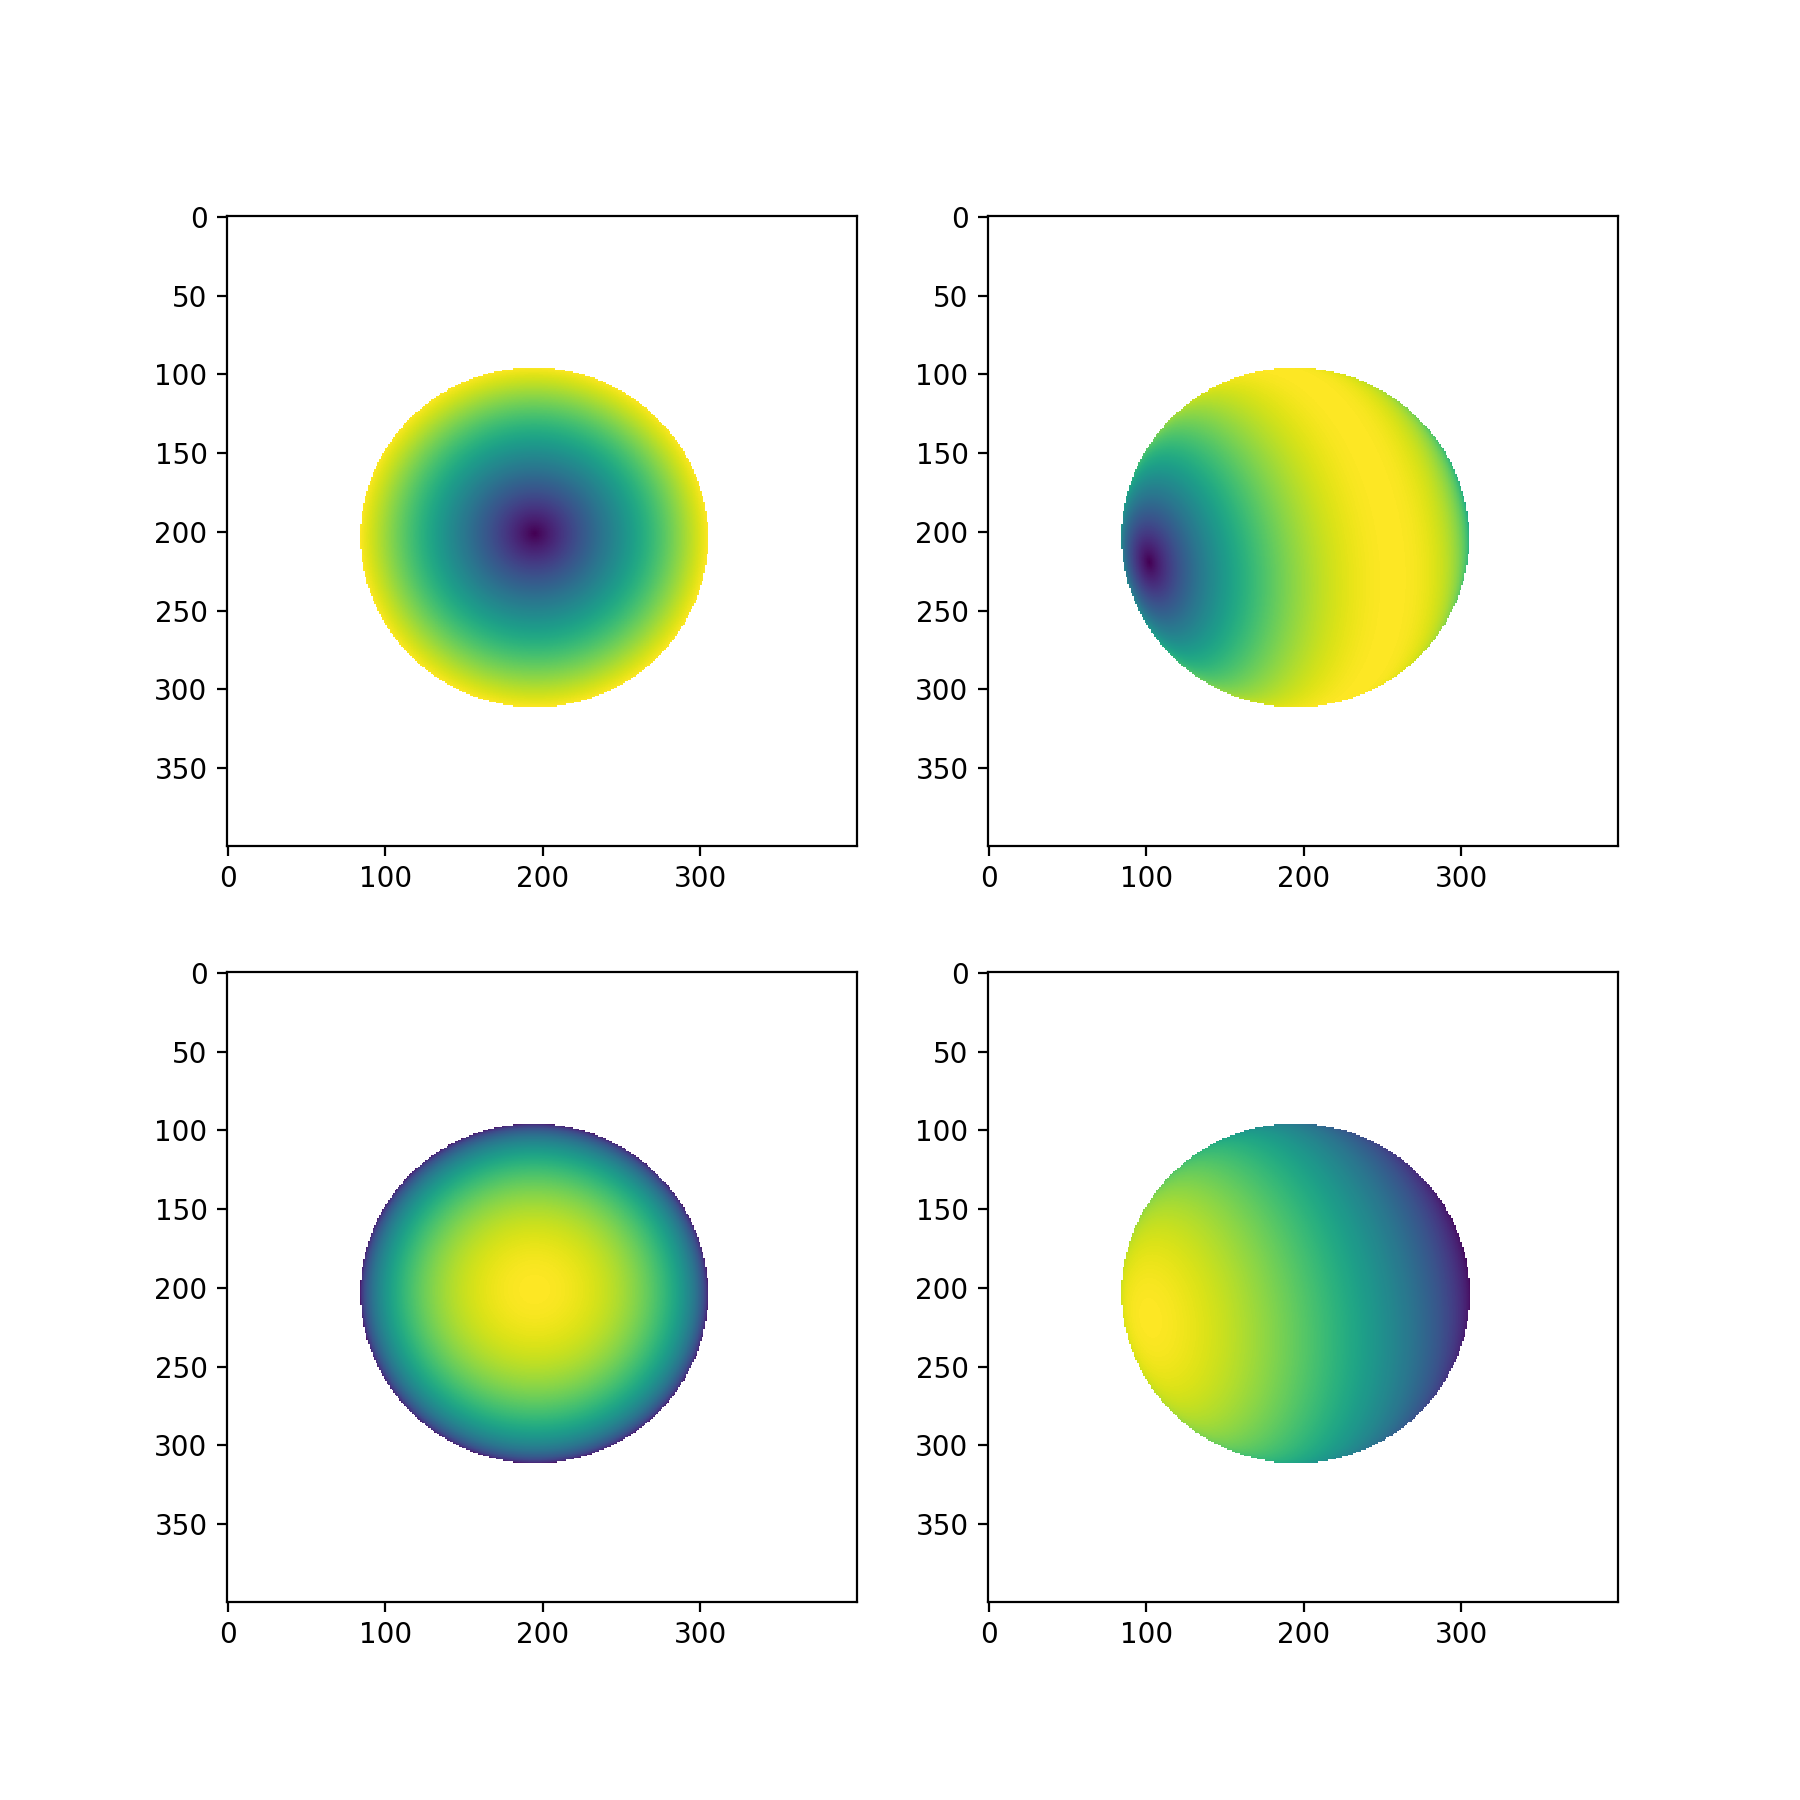

In [ ]:
plt.close(fig)
fig, ((ax,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(9,9))

ax.imshow(np.sin(np.radians(OGemisArray))[s:e,s:e])
ax2.imshow(np.sin(np.radians(OGincArray))[s:e,s:e])
ax3.imshow(np.cos(np.radians(OGemisArray))[s:e,s:e])
ax4.imshow(np.cos(np.radians(OGincArray))[s:e,s:e])


In [ ]:
s = 300
e = 700

imtest = np.where(np.logical_and(OGincArray<85,OGemisArray<77),im,np.nan)[s:e,s:e]
lat = np.copy(OGlatArray)[s:e,s:e]
lon = np.copy(OGlonArray)[s:e,s:e]
latr = np.round(OGlatArray)[s:e,s:e]
lonr = np.round(OGlonArray)[s:e,s:e]

inc = np.copy(OGincArray)[s:e,s:e]
emis = np.copy(OGemisArray)[s:e,s:e]
incr = np.round(OGincArray)[s:e,s:e]
emisr = np.round(OGemisArray)[s:e,s:e]

In [ ]:
SSpix2 = np.nanargmin(inc)
SSpixx = SSpix2//len(imtest)
SSpixy = SSpix2%len(imtest[0])

SCpix2 = np.nanargmin(emis)
SCpixx = SCpix2//len(imtest)
SCpixy = SCpix2%len(imtest[0])

slope = (-SSpixx+SCpixx)/(SSpixy-SCpixy)
x = -m*y + b
b = SSpixx + slope*SSpixy

eimask = np.full(np.shape(imtest),False)
if np.abs(slope) < 1:
    for i in range(len(imtest)):
        for j in range(len(imtest[i])):
            if i > -slope*j + b: eimask[i,j] = True
else:
    for i in range(len(imtest)):
        for j in range(len(imtest[i])):
            if j > (-i + b)/slope: eimask[i,j] = True

slope

0.1935483870967742

<IPython.core.display.Javascript object>


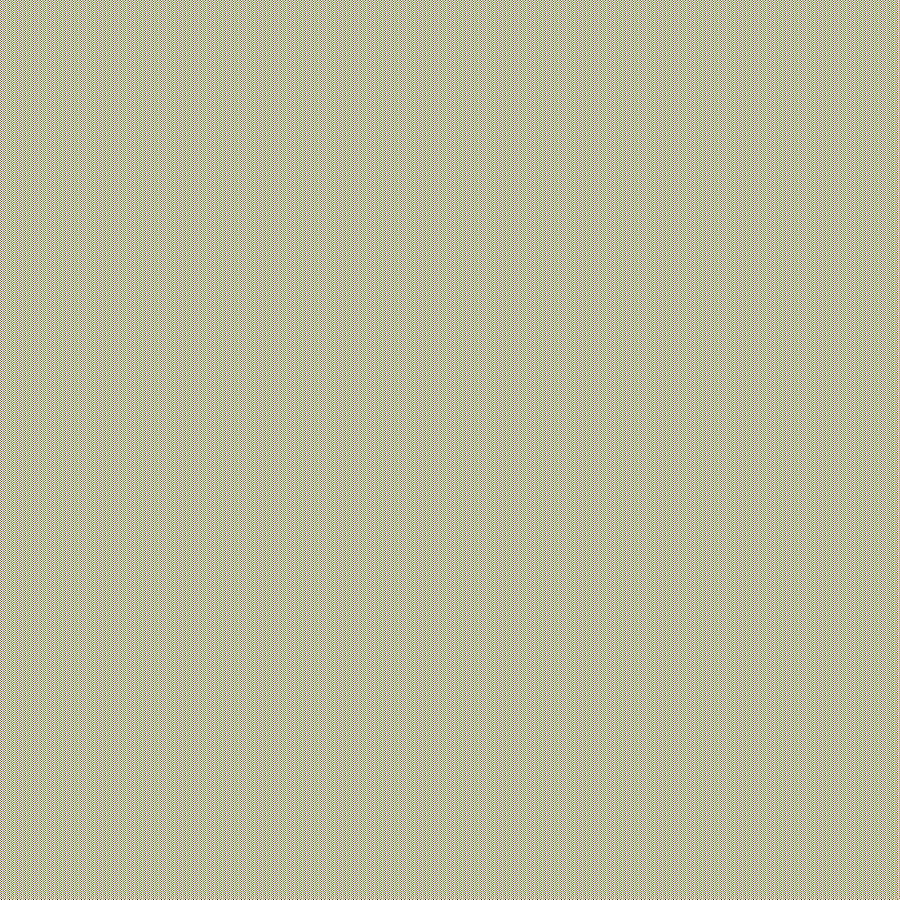

206 180
160 158


In [ ]:
plt.close(fig)
fig, ((ax,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(9,9))

# incmask = np.round(incr)==60
# incmask = np.logical_and(incr == 60, lat < 12)
incmask = np.logical_and(incr == 60, ~eimask)
incmask = np.logical_and(incmask,np.isfinite(imtest))


sorte = np.argsort(emis[incmask])
newsorte = [sorte[0]]
stepcute = np.abs(sorte[-1]-sorte[0])/len(sorte)/10.

for i in range(len(sorte)-1):
    if np.abs(emis[incmask][sorte[i+1]]-emis[incmask][sorte[i]]) > stepcute:
        newsorte.append(sorte[i+1])

print(len(sorte),len(newsorte))

# eimline = filters.gaussian(imtest[incmask][sorte],sigma=5)
# emisline = emis[incmask][sorte]
eimline = filters.gaussian(imtest[incmask][newsorte],sigma=13)
emisline = emis[incmask][newsorte]
# espaced = np.linspace(np.nanmin(emisline),np.nanmax(emisline),len(emisline))
# eimline = interp1d(emis[incmask][sorte],imtest[incmask][sorte],kind='cubic')(espaced)
# ederiv = np.gradient(eimline,espaced)
# ederiv2 = np.gradient(ederiv,espaced)

ederiv = np.gradient(eimline,emisline)
ederiv2 = np.gradient(ederiv,emisline)

enotallowed = np.logical_or(ederiv<0,ederiv2<0)
dmult = 10

# ax.plot(emisline,eimline,'.')
ax.plot(emisline,ederiv*dmult,'.')
ax.plot(emisline,ederiv2*dmult,'.')


# ax.plot(emisline[enotallowed],eimline[enotallowed],'.')
ax.plot(emisline[~enotallowed],ederiv2[~enotallowed]*dmult,'.')
ax.plot(emisline[enotallowed],ederiv2[enotallowed]*dmult,'.')
# # ax.plot(emisline[~enotallowed],eimline[~enotallowed]-.01,'.')
# # ax.plot(emisline[ederiv<0],eimline[ederiv<0])
# ax.plot(emisline[ederiv<0],ederiv[ederiv<0])
# # ax.plot(emisline[ederiv2<0],eimline[ederiv2<0],'.')
# ax.plot(emisline[ederiv2<0],ederiv[ederiv2<0],'.')

# emismask = emisr == 60
# emismask = np.logical_and(emisr == 60, lat < 12)
emismask = np.logical_and(emisr == 60, ~eimask)
emismask = np.logical_and(emismask,np.isfinite(imtest))

sorti = np.argsort(inc[emismask])
newsorti = [sorti[0]]
stepcuti = np.abs(sorti[-1]-sorti[0])/len(sorti)/10.
for i in range(len(sorti)-1):
    if np.abs(inc[emismask][sorti[i+1]]-inc[emismask][sorti[i]]) > stepcuti:
        newsorti.append(sorti[i+1])

print(len(sorti),len(newsorti))

iimline = filters.gaussian(imtest[emismask][newsorti],sigma=3)
incline = inc[emismask][newsorti]

ideriv = np.gradient(iimline,incline)
ideriv2 = np.gradient(ideriv,incline)

inotallowed = np.logical_or(ideriv>0,ideriv2>0)

# ax2.plot(incline,iimline,'.')
ax2.plot(incline,ideriv,'.')
ax2.plot(incline,ideriv2,'.')

# ax2.plot(incline[inotallowed],iimline[inotallowed],'.')
# ax2.plot(incline[inotallowed],ideriv[inotallowed],'.')
ax2.plot(incline[ideriv>0],ideriv[ideriv>0],'.')
ax2.plot(incline[ideriv2>0],ideriv2[ideriv2>0],'.')

# ax2.plot(incline[~inotallowed],iimline[~inotallowed]-.01,'.')


finalmaske = np.full(np.shape(imtest),False)
finalmaske[incmask][newsorte][enotallowed] = True

ax3.imshow(np.where(incmask,np.nan,imtest))
# ax3.imshow(np.where(finalmaske,imtest+.02,imtest))

finalmaski = np.full(np.shape(imtest),False)
finalmaski[emismask][newsorti][~inotallowed] = True

# ax4.imshow(np.where(emismask,np.nan,imtest))
ax4.imshow(np.where(finalmaski,np.nan,imtest))

# ax4.imshow(np.where(eimask,imtest+.02,imtest)*np.sin(np.radians(inc))*np.sin(np.radians(emis)))
# ax4.imshow(np.where(np.logical_and(emismask,eimask),np.nan,imtest))



# ax.set_ylim(-.01,.1)

In [ ]:
# imtest2 = filters.gaussian(imtest,sigma=5)
# imtest2 = signal.medfilt2d(imtest,3)

avgblur = np.ones((5,5))

imtest2 = signal.convolve2d(imtest, avgblur, boundary='symm', mode='same')

# imtest2 = imtest2/np.cos(np.radians(inc))

<IPython.core.display.Javascript object>


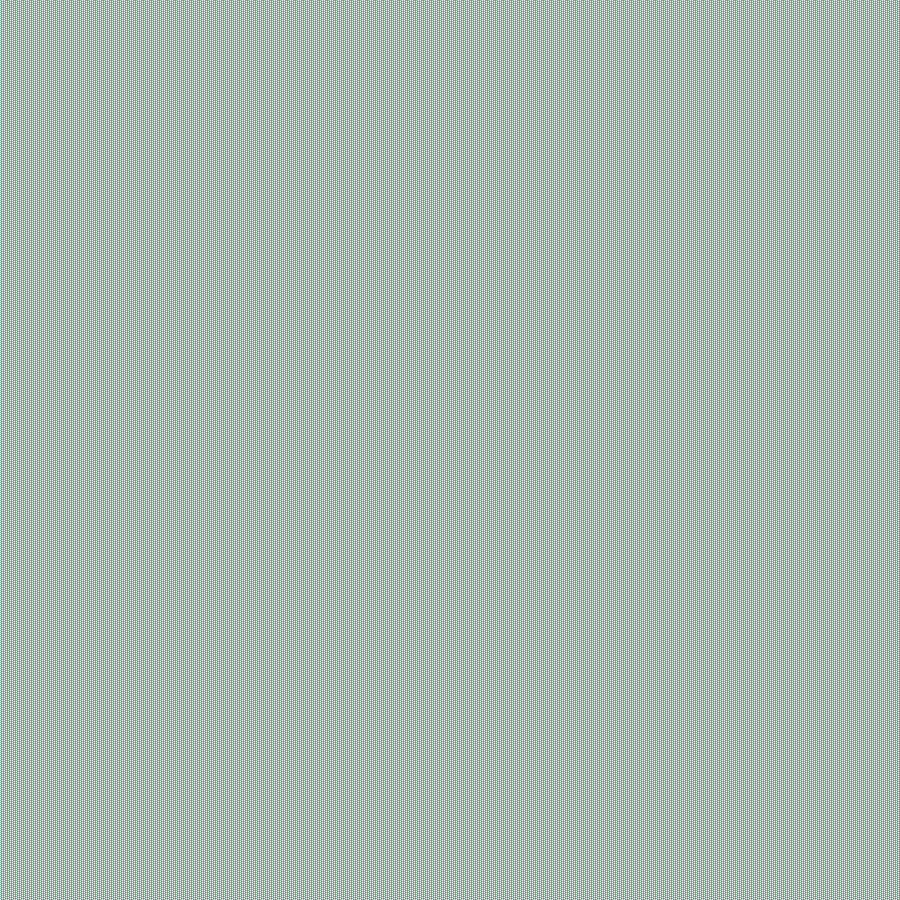

In [ ]:
plt.close(fig)
fig, ((ax,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(9,9))

# incmask = np.round(incr)==60
# incmask = np.logical_and(incr == 60, lat < 12)
incmask = np.logical_and(incr == 60, ~eimask)
incmask = np.logical_and(incmask,np.isfinite(imtest2))

einttemp = np.arange(np.nanmin(emisr[incmask]),np.nanmax(emisr[incmask])+1)
imemean = []
eint = []
for i in einttemp:
    temp = np.nanmean(imtest2[np.logical_and(incmask,emisr==i)])
    if np.isfinite(temp):
        imemean.append(temp)
        eint.append(i)

imemean = filters.gaussian(np.asarray(imemean),sigma=3)

emis2 = emis[incmask][np.logical_and(emis[incmask]>=eint[0],emis[incmask]<=eint[-1])]
eimline2 = interp1d(eint,imemean,kind='cubic')(emis2)

sorte = np.argsort(emis2)
# newsorte = [sorte[0]]
# stepcute = np.abs(sorte[-1]-sorte[0])/len(sorte)/10.

# for i in range(len(sorte)-1):
#     if np.abs(emis[incmask][sorte[i+1]]-emis[incmask][sorte[i]]) > stepcute:
#         newsorte.append(sorte[i+1])

# print(len(sorte),len(newsorte))


# eimline = filters.gaussian(eimline2[sorte],sigma=3)
eimline = np.copy(eimline2)[sorte]
emisline = emis2[sorte]

# eimline = np.copy(imemean)
# emisline = np.asarray(eint)

ederiv = np.gradient(eimline,emisline)
ederiv2 = np.gradient(ederiv,emisline)
ederiv3 = np.gradient(ederiv2,emisline)


enotallowed = np.logical_or(ederiv<0,ederiv2<0)
dmult = 100

Q1 = np.percentile(ederiv2, 25, interpolation = 'midpoint')
Q3 = np.percentile(ederiv2, 75, interpolation = 'midpoint')
IQR = Q3 - Q1

fac = .3

susd2 = np.logical_or(ederiv2>=(Q3+fac*IQR), ederiv2<=(Q1-fac*IQR))
# susd2 = ederiv2 < np.nanmean(ederiv2)
# susd2 = np.abs(np.nanmean(ederiv2) - ederiv2) > .2*np.nanstd(ederiv2)

# susd2 = ederiv2 < np.nanmedian(ederiv2)
# susd2 = ederiv3 > 0

# Q1 = np.percentile(ederiv, 25, interpolation = 'midpoint')
# Q3 = np.percentile(ederiv, 75, interpolation = 'midpoint')
# IQR = Q3 - Q1

# fac = .5

# susd2 = np.logical_or(ederiv>=(Q3+fac*IQR), ederiv<=(Q1-fac*IQR))

# Q1 = np.percentile(ederiv3, 25, interpolation = 'midpoint')
# Q3 = np.percentile(ederiv3, 75, interpolation = 'midpoint')
# IQR = Q3 - Q1

# fac = .5

# susd2 = np.logical_or(ederiv3>=(Q3+fac*IQR), ederiv3<=(Q1-fac*IQR))

ax.plot(emisline,eimline,'.')
ax.plot(emisline[enotallowed],eimline[enotallowed],'.')
ax.plot(emisline[susd2],eimline[susd2],'.')


# ax.plot(emis2,eimline2)

ax.plot(emisline,ederiv*dmult,'.')
ax.plot(emisline[ederiv<0],ederiv[ederiv<0]*dmult,'.')
# ax.plot(emisline[enotallowed],ederiv[enotallowed]*dmult,'.')

ax.plot(emisline,ederiv2*dmult,'.')
ax.plot(emisline[ederiv2<0],ederiv2[ederiv2<0]*dmult,'.')
ax.plot(emisline[susd2],ederiv2[susd2]*dmult,'.')

ax.plot(emisline,ederiv3*dmult,'.')

# ax.plot(emisline[enotallowed],ederiv2[enotallowed]*dmult,'.')


emismask = np.logical_and(emisr == 60, ~eimask)
emismask = np.logical_and(emismask,np.isfinite(imtest2))

iinttemp = np.arange(np.nanmin(incr[emismask]),np.nanmax(incr[emismask])+1)
imimean = []
iint = []
for i in iinttemp:
    temp = np.nanmean(imtest2[np.logical_and(emismask,incr==i)])
    if np.isfinite(temp):
        imimean.append(temp)
        iint.append(i)

imimean = filters.gaussian(np.asarray(imimean),sigma=3)

inc2 = inc[emismask][np.logical_and(inc[emismask]>=iint[0],inc[emismask]<=iint[-1])]
iimline2 = interp1d(iint,imimean,kind='cubic')(inc2)


sorti = np.argsort(inc2)
# newsorti = [sorti[0]]
# stepcuti = np.abs(sorti[-1]-sorti[0])/len(sorti)/10.
# for i in range(len(sorti)-1):
#     if np.abs(inc[emismask][sorti[i+1]]-inc[emismask][sorti[i]]) > stepcuti:
#         newsorti.append(sorti[i+1])

# print(len(sorti),len(newsorti))

iimline = np.copy(iimline2)[sorti]
incline = inc2[sorti]

ideriv = np.gradient(iimline,incline)
ideriv2 = np.gradient(ideriv,incline)

inotallowed = np.logical_or(ideriv>0,ideriv2>0)

ax2.plot(incline,iimline,'.')
ax2.plot(incline[inotallowed],iimline[inotallowed],'.')

ax2.plot(incline,ideriv*dmult,'.')
ax2.plot(incline[ideriv>0],ideriv[ideriv>0]*dmult,'.')
# ax2.plot(incline[inotallowed],ideriv[inotallowed],'.')

ax2.plot(incline,ideriv2*dmult,'.')
ax2.plot(incline[ideriv2>0],ideriv2[ideriv2>0]*dmult,'.')
# ax2.plot(incline[inotallowed],ideriv2[inotallowed],'.')


finalmaske = np.full(np.shape(imtest2),False)
# finalmaske[np.where(incmask)[0][np.asarray(sorte[enotallowed])],np.where(incmask)[1][np.asarray(sorte[enotallowed])]] = True
finalmaske[np.where(incmask)[0][np.asarray(sorte[susd2])],np.where(incmask)[1][np.asarray(sorte[susd2])]] = True


# ax3.imshow(np.where(incmask,np.nan,imtest2))
ax3.imshow(np.where(finalmaske,np.nan,imtest2),cmap='gray')


finalmaski = np.full(np.shape(imtest2),False)
finalmaski[np.where(emismask)[0][np.asarray(sorti[inotallowed])],np.where(emismask)[1][np.asarray(sorti[inotallowed])]] = True

# ax4.imshow(np.where(emismask,np.nan,imtest2))
ax4.imshow(np.where(finalmaski,np.nan,imtest2))

# ax4.imshow(np.where(eimask,imtest2+.02,imtest2)*np.sin(np.radians(inc))*np.sin(np.radians(emis)))
# ax4.imshow(np.where(np.logical_and(emismask,eimask),np.nan,imtest2))



# ax.set_ylim(-.1,3)

# ax2.imshow(imtest2)

In [ ]:
Q1 = np.percentile(ederiv2, 25, interpolation = 'midpoint')
Q3 = np.percentile(ederiv2, 75, interpolation = 'midpoint')
IQR = Q3 - Q1

fac = 1.

susd2 = np.logical_or(ederiv2>=(Q3+fac*IQR), ederiv2<=(Q1-fac*IQR))

np.nanmean(ederiv2),Q1,Q3,susd2,np.nanmedian(ederiv2)

(0.00023520748159689482,
 8.19362890708603e-05,
 0.0004570157710005859,
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
     

In [ ]:

finalmaske = np.full(np.shape(imtest2),False)
finalmaski = np.full(np.shape(imtest2),False)


for deg in range(90):

    try:
        incmask = np.logical_and(incr == deg, ~eimask)
        incmask = np.logical_and(incmask,np.isfinite(imtest2))

        einttemp = np.arange(np.nanmin(emisr[incmask]),np.nanmax(emisr[incmask])+1)
        imemean = []
        eint = []
        for i in einttemp:
            temp = np.nanmean(imtest2[np.logical_and(incmask,emisr==i)])
            if np.isfinite(temp):
                imemean.append(temp)
                eint.append(i)

        imemean = filters.gaussian(np.asarray(imemean),sigma=3)

        emis2 = emis[incmask][np.logical_and(emis[incmask]>=eint[0],emis[incmask]<=eint[-1])]
        eimline2 = interp1d(eint,imemean,kind='cubic')(emis2)

        sorte = np.argsort(emis2)

        eimline = np.copy(eimline2)[sorte]
        emisline = emis2[sorte]

        ederiv = np.gradient(eimline,emisline)
        ederiv2 = np.gradient(ederiv,emisline)
        ederiv3 = np.gradient(ederiv2,emisline)


#         enotallowed = np.logical_or(ederiv<0,ederiv2<0)

        Q1 = np.percentile(ederiv2, 25, interpolation = 'midpoint')
        Q3 = np.percentile(ederiv2, 75, interpolation = 'midpoint')
        IQR = Q3 - Q1

        fac = .3

        enotallowed = np.logical_or(ederiv2>=(Q3+fac*IQR), ederiv2<=(Q1-fac*IQR))
#         enotallowed = ederiv2 < np.nanmean(ederiv2)
#         enotallowed = ederiv2 < np.nanmedian(ederiv2)

        finalmaske[np.where(incmask)[0][np.asarray(sorte[enotallowed])],np.where(incmask)[1][np.asarray(sorte[enotallowed])]] = True

    except:
        print("no inc {}".format(deg))

    try:
        emismask = np.logical_and(emisr == deg, ~eimask)
        emismask = np.logical_and(emismask,np.isfinite(imtest2))

        iinttemp = np.arange(np.nanmin(incr[emismask]),np.nanmax(incr[emismask])+1)
        imimean = []
        iint = []
        for i in iinttemp:
            temp = np.nanmean(imtest2[np.logical_and(emismask,incr==i)])
            if np.isfinite(temp):
                imimean.append(temp)
                iint.append(i)

        imimean = filters.gaussian(np.asarray(imimean),sigma=3)

        inc2 = inc[emismask][np.logical_and(inc[emismask]>=iint[0],inc[emismask]<=iint[-1])]
        iimline2 = interp1d(iint,imimean,kind='cubic')(inc2)


        sorti = np.argsort(inc2)

        iimline = np.copy(iimline2)[sorti]
        incline = inc2[sorti]

        ideriv = np.gradient(iimline,incline)
        ideriv2 = np.gradient(ideriv,incline)

#         inotallowed = np.logical_or(ideriv>0,ideriv2>0)

#         Q1 = np.percentile(ideriv2, 25, interpolation = 'midpoint')
#         Q3 = np.percentile(ideriv2, 75, interpolation = 'midpoint')
#         IQR = Q3 - Q1

#         inotallowed = np.logical_or(ideriv2>=(Q3+fac*IQR), ideriv2<=(Q1-fac*IQR))
#         inotallowed = ideriv2 < np.nanmean(ideriv2)
        inotallowed = ideriv2 < np.nanmedian(ideriv2)

        finalmaski[np.where(emismask)[0][np.asarray(sorti[inotallowed])],np.where(emismask)[1][np.asarray(sorti[inotallowed])]] = True

    except:
        print("no emis {}".format(deg))


    try:
        incmask = np.logical_and(incr == deg, eimask)
        incmask = np.logical_and(incmask,np.isfinite(imtest2))

        einttemp = np.arange(np.nanmin(emisr[incmask]),np.nanmax(emisr[incmask])+1)
        imemean = []
        eint = []
        for i in einttemp:
            temp = np.nanmean(imtest2[np.logical_and(incmask,emisr==i)])
            if np.isfinite(temp):
                imemean.append(temp)
                eint.append(i)

        imemean = filters.gaussian(np.asarray(imemean),sigma=3)

        emis2 = emis[incmask][np.logical_and(emis[incmask]>=eint[0],emis[incmask]<=eint[-1])]
        eimline2 = interp1d(eint,imemean,kind='cubic')(emis2)

        sorte = np.argsort(emis2)

        eimline = np.copy(eimline2)[sorte]
        emisline = emis2[sorte]

        ederiv = np.gradient(eimline,emisline)
        ederiv2 = np.gradient(ederiv,emisline)
        ederiv3 = np.gradient(ederiv2,emisline)

#         enotallowed = np.logical_or(ederiv<0,ederiv2<0)

        Q1 = np.percentile(ederiv2, 25, interpolation = 'midpoint')
        Q3 = np.percentile(ederiv2, 75, interpolation = 'midpoint')
        IQR = Q3 - Q1

        enotallowed = np.logical_or(ederiv2>=(Q3+fac*IQR), ederiv2<=(Q1-fac*IQR))
#         enotallowed = ederiv2 < np.nanmean(ederiv2)
#         enotallowed = ederiv2 < np.nanmedian(ederiv2)

        finalmaske[np.where(incmask)[0][np.asarray(sorte[enotallowed])],np.where(incmask)[1][np.asarray(sorte[enotallowed])]] = True

    except:
        print("no inc {}".format(deg))

    try:
        emismask = np.logical_and(emisr == deg, eimask)
        emismask = np.logical_and(emismask,np.isfinite(imtest2))

        iinttemp = np.arange(np.nanmin(incr[emismask]),np.nanmax(incr[emismask])+1)
        imimean = []
        iint = []
        for i in iinttemp:
            temp = np.nanmean(imtest2[np.logical_and(emismask,incr==i)])
            if np.isfinite(temp):
                imimean.append(temp)
                iint.append(i)

        imimean = filters.gaussian(np.asarray(imimean),sigma=3)

        inc2 = inc[emismask][np.logical_and(inc[emismask]>=iint[0],inc[emismask]<=iint[-1])]
        iimline2 = interp1d(iint,imimean,kind='cubic')(inc2)


        sorti = np.argsort(inc2)

        iimline = np.copy(iimline2)[sorti]
        incline = inc2[sorti]

        ideriv = np.gradient(iimline,incline)
        ideriv2 = np.gradient(ideriv,incline)

#         inotallowed = np.logical_or(ideriv>0,ideriv2>0)

#         Q1 = np.percentile(ideriv2, 25, interpolation = 'midpoint')
#         Q3 = np.percentile(ideriv2, 75, interpolation = 'midpoint')
#         IQR = Q3 - Q1

#         inotallowed = np.logical_or(ideriv2>=(Q3+fac*IQR), ideriv2<=(Q1-fac*IQR))
#         inotallowed = ideriv2 < np.nanmean(ideriv2)
        inotallowed = ideriv2 < np.nanmedian(ideriv2)

        finalmaski[np.where(emismask)[0][np.asarray(sorti[inotallowed])],np.where(emismask)[1][np.asarray(sorti[inotallowed])]] = True

    except:
        print("no emis {}".format(deg))

no inc 0
no emis 0
no inc 0
no emis 0
no inc 1
no emis 1
no inc 1
no emis 1


/home/csnell/anaconda3/envs/isis/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/home/csnell/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:1072: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/csnell/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:1073: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/csnell/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:1074: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/csnell/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:1080: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/home/csnell/anaconda3/envs/isis/lib/python3.6/site-packages/ipykernel_launcher.py:103: RuntimeWarning

no emis 73
no emis 74
no emis 74
no emis 75
no emis 75
no emis 76
no emis 76
no emis 77
no emis 77
no emis 78
no emis 78
no emis 79
no emis 79
no emis 80
no emis 80
no emis 81
no emis 81
no emis 82
no emis 82
no emis 83
no emis 83
no inc 84
no emis 84
no emis 84
no inc 85
no emis 85
no inc 85
no emis 85
no inc 86
no emis 86
no inc 86
no emis 86
no inc 87
no emis 87
no inc 87
no emis 87
no inc 88
no emis 88
no inc 88
no emis 88
no inc 89
no emis 89
no inc 89
no emis 89


<IPython.core.display.Javascript object>


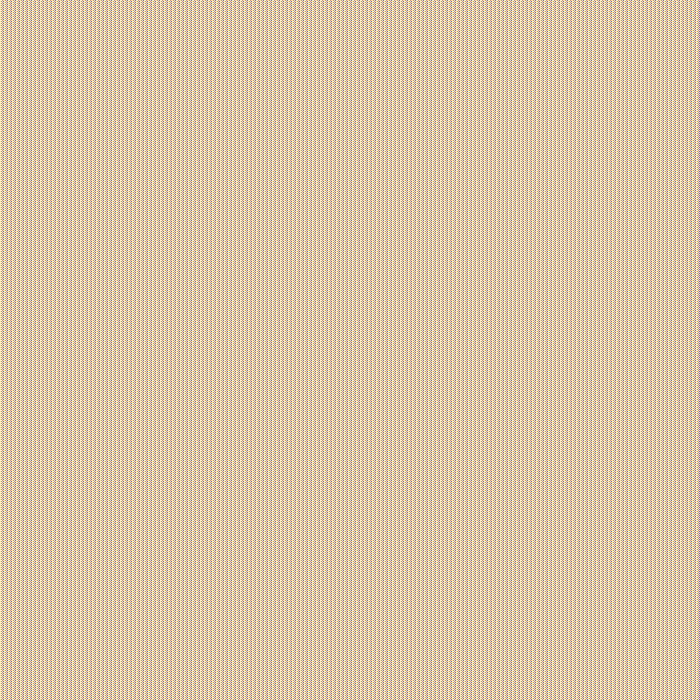

In [ ]:
plt.close(fig)
fig, ((ax,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(7,7))

ax.imshow(np.where(incr==50,np.nan,imtest2))

# ax2.imshow(np.where(emisr==50,np.nan,imtest2))
ax2.imshow(imtest2/(1*(2+np.sin(np.radians(emis)))*(0.4+np.cos(np.radians(inc)))*(0.4+np.cos(np.radians(inc)))))


ax3.imshow(np.where(finalmaske,np.nan,imtest2))

ax4.imshow(np.where(finalmaski,np.nan,imtest2))

<IPython.core.display.Javascript object>


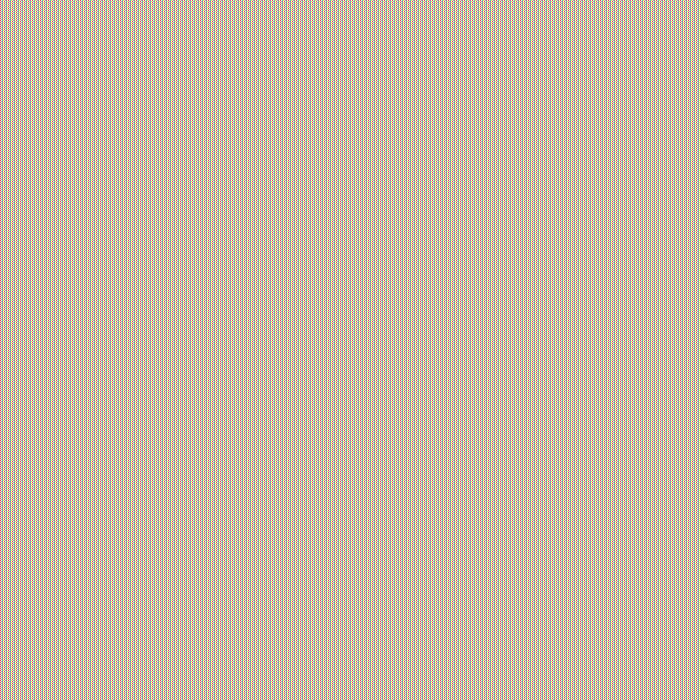

In [ ]:
plt.close(fig)
fig, ((ax,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(7,7))

ax.imshow(np.where(incr==50,np.nan,imtest2))

# ax2.imshow(np.where(emisr==50,np.nan,imtest2))
ax2.imshow(imtest2/np.cos(np.radians(inc)))


ax3.imshow(np.where(np.logical_and(finalmaske,finalmaski),np.nan,imtest2))

ax4.imshow(np.where(np.logical_or(finalmaske,finalmaski),np.nan,imtest2))

In [ ]:
def smoothderiv(x,y):
    xr = np.round(x)
    inttemp = np.arange(np.nanmin(xr),np.nanmax(xr)+1)
    immean = []
    iint = []
    for i in inttemp:
        temp = np.nanmean(y[xr==i])
        if np.isfinite(temp):
            immean.append(temp)
            iint.append(i)

    immean = filters.gaussian(np.asarray(immean),sigma=3)

    xmask = np.logical_and(x>=iint[0],x<=iint[-1])
    x2 = x[xmask]
    imline = interp1d(iint,immean,kind='cubic')(x2)

    sort = np.argsort(x2)

    imsort = imline[sort]
    xsort = x2[sort]

    deriv1 = np.gradient(imsort,xsort)
    deriv2 = np.gradient(deriv1,xsort)

    return np.where(xmask)[0][sort],np.asarray(xsort),deriv1,deriv2

def normderiv(x,y):
    xr = np.round(x)
    inttemp = np.arange(np.nanmin(xr),np.nanmax(xr)+1)
    immean = []
    iint = []
    for i in inttemp:
        temp = np.nanmean(y[xr==i])
        if np.isfinite(temp):
            immean.append(temp)
            iint.append(i)

    immean = filters.gaussian(np.asarray(immean),sigma=3)

    x2 = x[np.logical_and(x>=iint[0],x<=iint[-1])]
    imline = interp1d(iint,immean,kind='cubic')(x2)

    sort = np.argsort(x2)

    imsort = imline[sort]
    xsort = x2[sort]

    nderiv1 = []
    nderiv2 = []

    xsortr = np.round(xsort)

    for i,j in enumerate(immean):
        ynorm = np.copy(imsort)/j

        deriv1 = np.gradient(ynorm,xsort)
        deriv2 = np.gradient(deriv1,xsort)

        nderiv1.append(np.nanmean(deriv1[xsortr==iint[i]]))
        nderiv2.append(np.nanmean(deriv2[xsortr==iint[i]]))

    return np.asarray(iint),np.asarray(nderiv1),np.asarray(nderiv2)

<IPython.core.display.Javascript object>


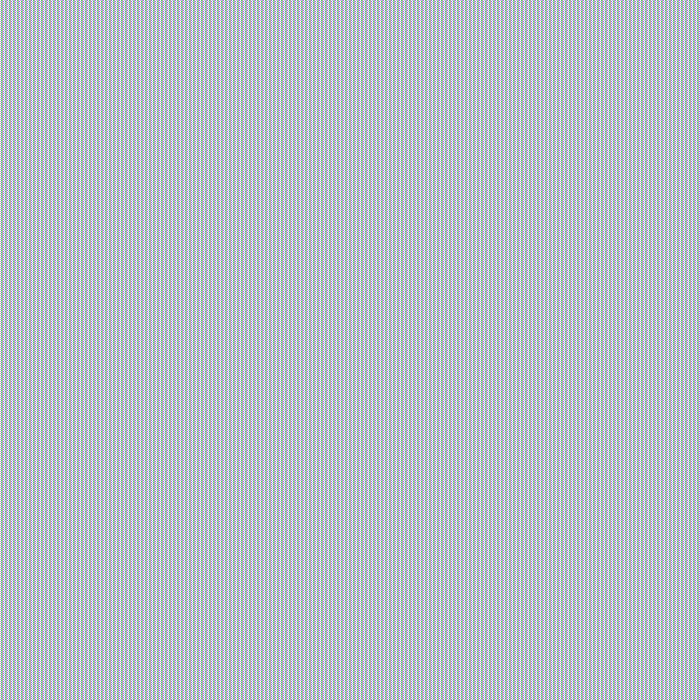

/home/csnell/anaconda3/envs/isis/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/csnell/anaconda3/envs/isis/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/csnell/anaconda3/envs/isis/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/csnell/anaconda3/envs/isis/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/csnell/anaconda3/envs/isis/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/home/csnell/anaconda3/envs/isis/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/csnell/anaconda3/envs/isis/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/home/csnell/anaconda

In [ ]:
plt.close(fig)
fig, ((ax,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(7,7))

degall = 58

for i in range(90):
    ax.plot(emis[np.logical_and(incr==i,eimask)],imtest2[np.logical_and(incr==i,eimask)]/np.nanmean(imtest2[np.logical_and(incr==i,np.logical_and(emisr==degall,eimask))]),'.')
    ax2.plot(inc[np.logical_and(emisr==i,eimask)],imtest2[np.logical_and(emisr==i,eimask)]/np.nanmean(imtest2[np.logical_and(emisr==i,np.logical_and(incr==degall,eimask))]),'.')
    ax.plot(emis[np.logical_and(incr==i,~eimask)],imtest2[np.logical_and(incr==i,~eimask)]/np.nanmean(imtest2[np.logical_and(incr==i,np.logical_and(emisr==degall,~eimask))]),'.')
    ax2.plot(inc[np.logical_and(emisr==i,~eimask)],imtest2[np.logical_and(emisr==i,~eimask)]/np.nanmean(imtest2[np.logical_and(emisr==i,np.logical_and(incr==degall,~eimask))]),'.')

i1 = 20
i2 = 60
# ax.plot(emis[np.logical_and(incr==i1,eimask)],imtest2[np.logical_and(incr==i1,eimask)]/np.nanmean(imtest2[np.logical_and(incr==i1,emisr==58)]),'k.')
# ax.plot(emis[np.logical_and(incr==i2,eimask)],imtest2[np.logical_and(incr==i2,eimask)]/np.nanmean(imtest2[np.logical_and(incr==i2,emisr==58)]),'k.')

# testup = imtest2[np.logical_and(incr==i2,~eimask)]
# testdown = imtest2[np.logical_and(incr==i2,eimask)]
# testup = imtest2[np.logical_and(incr==i2,~eimask)]/np.nanmean(imtest2[np.logical_and(incr==i2,np.logical_and(emisr==degall,~eimask))])
# testdown = imtest2[np.logical_and(incr==i2,eimask)]/np.nanmean(imtest2[np.logical_and(incr==i2,np.logical_and(emisr==degall,eimask))])
# xup = emis[np.logical_and(incr==i2,~eimask)]
# xdown = emis[np.logical_and(incr==i2,eimask)]

testup = imtest2[np.logical_and(emisr==i2,~eimask)]
testdown = imtest2[np.logical_and(emisr==i2,eimask)]
# testup = imtest2[np.logical_and(emisr==i2,~eimask)]/np.nanmean(imtest2[np.logical_and(emisr==i2,np.logical_and(incr==degall,~eimask))])
# testdown = imtest2[np.logical_and(emisr==i2,eimask)]/np.nanmean(imtest2[np.logical_and(emisr==i2,np.logical_and(incr==degall,eimask))])
xup = inc[np.logical_and(emisr==i2,~eimask)]
xdown = inc[np.logical_and(emisr==i2,eimask)]

x2up,xupsort,derivup1,derivup2 = smoothderiv(xup,testup)
x2down,xdownsort,derivdown1,derivdown2 = smoothderiv(xdown,testdown)

ax3.plot(xdown,testdown,'m.',label='north')
ax3.plot(xup,testup,'k.',label='south')

dmult = 100
ax3.plot(xdownsort,derivdown1*dmult,'m')
ax3.plot(xupsort,derivup1*dmult,'k')

ax3.plot(xdownsort,derivdown2*dmult,'m--')
ax3.plot(xupsort,derivup2*dmult,'k--')

ax3.plot(xdownsort[derivdown1<0],derivdown1[derivdown1<0]*dmult,'c.',markersize=1)
ax3.plot(xupsort[derivup1<0],derivup1[derivup1<0]*dmult,'b.',markersize=1)

ax3.plot(xdownsort[derivdown2<0],derivdown2[derivdown2<0]*dmult,'c.',markersize=1)
ax3.plot(xupsort[derivup2<0],derivup2[derivup2<0]*dmult,'b.',markersize=1)

nup,nderivup1,nderivup2 = normderiv(xup,testup)
ndown,nderivdown1,nderivdown2 = normderiv(xdown,testdown)

ax3.plot(ndown,nderivdown1*dmult,'r')
ax3.plot(nup,nderivup1*dmult,'g')

ax3.plot(ndown,nderivdown2*dmult,'r--')
ax3.plot(nup,nderivup2*dmult,'g--')

halves = np.where(eimask,imtest2+.1,imtest2)
# ax4.imshow(halves)
# ax4.imshow(np.where(latr>0,halves+.1,halves)) #test north hemisphere
# ax4.imshow(np.where(np.abs(emisr-i2)<2,halves+.1,halves))
# ax4.imshow(np.where(np.abs(incr-i2)<2,halves+.1,halves))
ax4.imshow(np.where(np.logical_or(np.abs(incr-i2)<2,np.abs(emisr-20)<2),halves+.1,halves))
# ax4.imshow(np.where(np.logical_or(np.abs(emisr-i2)<2,np.abs(incr-54)<2),halves+.1,halves))






ax.set_xlabel('emis')
ax2.set_xlabel('inc')
ax3.legend()
# ax3.set_ylim(-5,5)

In [ ]:

finalime = np.full(np.shape(imtest2),np.nan)
finalimi = np.full(np.shape(imtest2),np.nan)
nfinalime = np.full(np.shape(imtest2),np.nan)
nfinalimi = np.full(np.shape(imtest2),np.nan)

for deg in range(90):

    try:
        incmask = np.logical_and(incr == deg, ~eimask)
        incmask = np.logical_and(incmask,np.isfinite(imtest2))

        xsort,sort,deriv1,deriv2 = smoothderiv(emis[incmask],imtest2[incmask])
        nsort,nderiv1,nderiv2 = normderiv(emis[incmask],imtest2[incmask])

        finalime[np.where(incmask)[0][xsort],np.where(incmask)[1][xsort]] = deriv2

        for i,j in enumerate(nsort):
            nfinalime[np.where(np.logical_and(incmask,emisr==j))[0],np.where(np.logical_and(incmask,emisr==j))[1]] = nderiv2[i]

    except:
        print("no inc {}".format(deg))


    try:
        emismask = np.logical_and(emisr == deg, ~eimask)
        emismask = np.logical_and(emismask,np.isfinite(imtest2))

        xsort,sort,deriv1,deriv2 = smoothderiv(inc[emismask],imtest2[emismask])
        nsort,nderiv1,nderiv2 = normderiv(inc[emismask],imtest2[emismask])

        finalimi[np.where(emismask)[0][xsort],np.where(emismask)[1][xsort]] = deriv2

        for i,j in enumerate(nsort):
            nfinalimi[np.where(np.logical_and(emismask,incr==j))[0],np.where(np.logical_and(emismask,incr==j))[1]] = nderiv2[i]

    except:
        print("no emis {}".format(deg))


    try:
        incmask = np.logical_and(incr == deg, eimask)
        incmask = np.logical_and(incmask,np.isfinite(imtest2))

        xsort,sort,deriv1,deriv2 = smoothderiv(emis[incmask],imtest2[incmask])
        nsort,nderiv1,nderiv2 = normderiv(emis[incmask],imtest2[incmask])

        finalime[np.where(incmask)[0][xsort],np.where(incmask)[1][xsort]] = -deriv2

        for i,j in enumerate(nsort):
            nfinalime[np.where(np.logical_and(incmask,emisr==j))[0],np.where(np.logical_and(incmask,emisr==j))[1]] = -nderiv2[i]

    except:
        print("no inc {}".format(deg))


    try:
        emismask = np.logical_and(emisr == deg, eimask)
        emismask = np.logical_and(emismask,np.isfinite(imtest2))

        xsort,sort,deriv1,deriv2 = smoothderiv(inc[emismask],imtest2[emismask])
        nsort,nderiv1,nderiv2 = normderiv(inc[emismask],imtest2[emismask])

        finalimi[np.where(emismask)[0][xsort],np.where(emismask)[1][xsort]] = -deriv2

        for i,j in enumerate(nsort):
            nfinalimi[np.where(np.logical_and(emismask,incr==j))[0],np.where(np.logical_and(emismask,incr==j))[1]] = -nderiv2[i]

    except:
        print("no emis {}".format(deg))

no inc 0
no emis 0
no inc 0
no emis 0
no inc 1
no emis 1
no inc 1
no emis 1


/home/csnell/anaconda3/envs/isis/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: Mean of empty slice
/home/csnell/anaconda3/envs/isis/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/home/csnell/anaconda3/envs/isis/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/csnell/anaconda3/envs/isis/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice


no emis 73
no emis 74
no emis 74
no emis 75
no emis 75
no emis 76
no emis 76
no emis 77
no emis 77
no emis 78
no emis 78
no emis 79
no emis 79
no emis 80
no emis 80
no emis 81
no emis 81
no emis 82
no emis 82
no emis 83
no emis 83
no inc 84
no emis 84
no emis 84
no inc 85
no emis 85
no inc 85
no emis 85
no inc 86
no emis 86
no inc 86
no emis 86
no inc 87
no emis 87
no inc 87
no emis 87
no inc 88
no emis 88
no inc 88
no emis 88
no inc 89
no emis 89
no inc 89
no emis 89


<IPython.core.display.Javascript object>


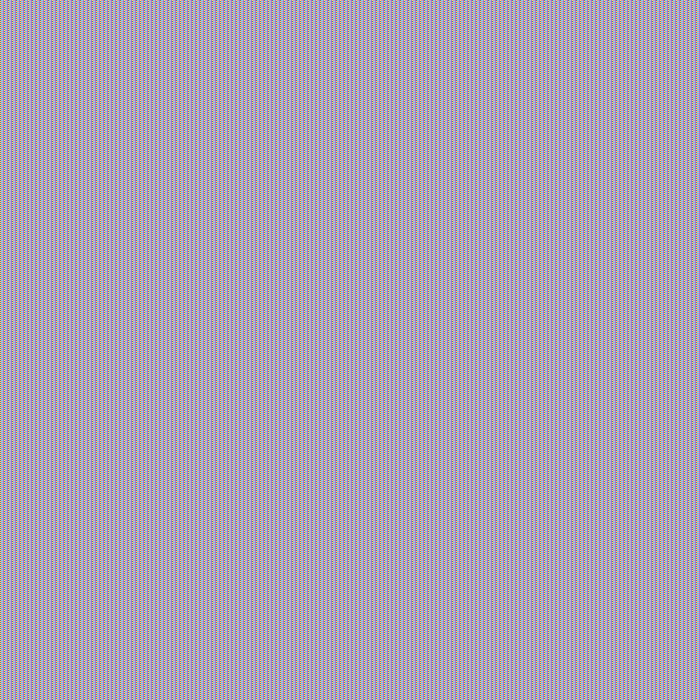

In [ ]:
plt.close(fig)
fig, ((ax,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(7,7))

# ax.imshow(np.where(~eimask,finalime,np.nan),vmin=-.005,vmax=.005)
ax.imshow(finalime,vmin=-.005,vmax=.005)
# ax2.imshow(np.where(~eimask,nfinalime,np.nan),vmin=-.005,vmax=.005)
# ax2.imshow(nfinalime,vmin=-.005,vmax=.005)
ax2.imshow(np.where(np.abs(nfinalime)<.001,nfinalime,np.nan),vmin=-.005,vmax=.005)

ax3.imshow(finalimi,vmin=-.005,vmax=.005)
# ax2.imshow(np.where(~eimask,nfinalime,np.nan),vmin=-.005,vmax=.005)
ax4.imshow(nfinalimi,vmin=-.005,vmax=.005)



In [ ]:
np.nanmax(finalime),np.nanmin(finalime)

(0.015104901742451694, -0.015018511211711272)

In [ ]:

finalimlon = np.full(np.shape(imtest2),np.nan)
finalimlat = np.full(np.shape(imtest2),np.nan)
nfinalimlon = np.full(np.shape(imtest2),np.nan)
nfinalimlat = np.full(np.shape(imtest2),np.nan)

for deg in range(-90,90):

    try:
        latmask = np.logical_and(latr == deg,np.isfinite(imtest2))

        xsort,sort,deriv1,deriv2 = smoothderiv(lon[latmask],imtest2[latmask])
        nsort,nderiv1,nderiv2 = normderiv(lon[latmask],imtest2[latmask])

        finalimlon[np.where(latmask)[0][xsort],np.where(latmask)[1][xsort]] = deriv2

        for i,j in enumerate(nsort):
            nfinalimlon[np.where(np.logical_and(latmask,lonr==j))[0],np.where(np.logical_and(latmask,lonr==j))[1]] = nderiv2[i]

    except:
        print("no lat {}".format(deg))


for deg in range(361):

    try:
        lonmask = np.logical_and(lonr == deg,np.isfinite(imtest2))

        xsort,sort,deriv1,deriv2 = smoothderiv(lat[lonmask],imtest2[lonmask])
        nsort,nderiv1,nderiv2 = normderiv(lat[lonmask],imtest2[lonmask])

        finalimlat[np.where(lonmask)[0][xsort],np.where(lonmask)[1][xsort]] = deriv2

        for i,j in enumerate(nsort):
            nfinalimlat[np.where(np.logical_and(lonmask,latr==j))[0],np.where(np.logical_and(lonmask,latr==j))[1]] = nderiv2[i]

    except:
        print("no lon {}".format(deg))


no lat -90
no lat -89
no lat -88
no lat -87
no lat -86
no lat -85
no lat -84
no lat -83
no lat -82
no lat -81
no lat -80
no lat -79
no lat -78
no lat -77
no lat -76
no lat -75
no lat -74
no lat -73
no lat -72
no lat -71
no lat -70
no lat -69
no lat -68
no lat -67
no lat -66
no lat -65
no lat -64
no lat -63
no lat -62
no lat -61
no lat -60
no lat -59
no lat -58
no lat -57
no lat -56
no lat -55
no lat -54
no lat -53
no lat -52
no lat -51
no lat -50
no lat -49
no lat -48
no lat -47
no lat -46
no lat -45
no lat -44
no lat -43
no lat -42


/home/csnell/anaconda3/envs/isis/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/csnell/anaconda3/envs/isis/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/home/csnell/anaconda3/envs/isis/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: Mean of empty slice
/home/csnell/anaconda3/envs/isis/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice


no lon 86
no lon 87
no lon 88
no lon 89
no lon 90
no lon 92
no lon 93
no lon 94
no lon 95
no lon 96
no lon 97
no lon 98
no lon 99
no lon 100
no lon 101
no lon 102
no lon 103
no lon 104
no lon 105
no lon 106
no lon 107
no lon 108
no lon 109
no lon 110
no lon 111
no lon 112
no lon 113
no lon 114
no lon 115
no lon 116
no lon 117
no lon 118
no lon 119
no lon 120
no lon 121
no lon 123
no lon 124
no lon 125
no lon 126
no lon 127
no lon 128
no lon 129
no lon 130
no lon 131
no lon 132
no lon 133
no lon 134
no lon 135
no lon 136
no lon 137
no lon 138
no lon 139
no lon 140
no lon 141
no lon 142
no lon 143
no lon 144
no lon 145
no lon 146
no lon 147
no lon 148
no lon 149
no lon 150
no lon 151
no lon 152
no lon 153
no lon 154
no lon 155
no lon 156
no lon 157
no lon 158
no lon 159
no lon 160
no lon 161
no lon 162
no lon 163
no lon 164
no lon 165
no lon 166
no lon 167
no lon 168
no lon 169
no lon 170
no lon 171
no lon 172
no lon 173
no lon 174
no lon 175
no lon 176
no lon 177
no lon 178
no lon 179
n

<IPython.core.display.Javascript object>


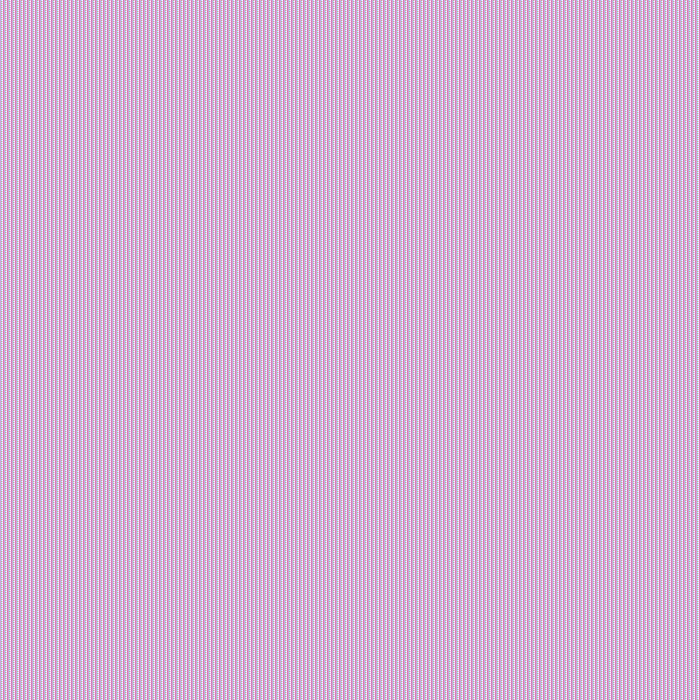

In [ ]:
plt.close(fig)
fig, ((ax,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(7,7))

# ax.imshow(np.where(~eimask,finalime,np.nan),vmin=-.005,vmax=.005)
ax.imshow(finalimlon,vmin=-.005,vmax=.005)
# ax2.imshow(np.where(~eimask,nfinalime,np.nan),vmin=-.005,vmax=.005)
ax2.imshow(nfinalimlon,vmin=-.005,vmax=.005)
# ax2.imshow(np.where(np.abs(nfinalime)<.001,nfinalime,np.nan),vmin=-.005,vmax=.005)

ax3.imshow(finalimlat,vmin=-.005,vmax=.005)
# ax2.imshow(np.where(~eimask,nfinalime,np.nan),vmin=-.005,vmax=.005)
ax4.imshow(nfinalimlat,vmin=-.005,vmax=.005)

In [ ]:

def tosphcoordarray(lons,lats,semimaj,semimin):
    r = (semimaj*semimin)/np.sqrt((semimin*np.cos(np.radians(lats)))**2 + (semimaj*np.sin(np.radians(lats)))**2)
    sphcoords = []
    for i,j in enumerate(lons):
        sphcoords.append([j,lats[i],r[i]])

    return sphcoords


def planefit(abcd):
    a,b,c,d = abcd
    return (a*cartcoords[:,0] + b*cartcoords[:,1] + c*cartcoords[:,2] + d)/np.sqrt(a*a + b*b + c*c)

def planefit2(abd):
    a,b,d = abd
    c = np.sqrt(1 - a*a - b*b)
    return (a*cartcoords[:,0] + b*cartcoords[:,1] + c*cartcoords[:,2] + d)


def find_nearest(array, value):
    return (np.abs(array - value)).argmin()

def cartosph(cart):
    sph = []

    for i in cart:
        r = np.sqrt(i[0]**2 + i[1]**2 + i[2]**2)
        theta = -np.degrees(np.arccos(i[2]/r)) + 90
        phi = np.degrees(np.arctan(i[1]/i[0]))
        if i[0] < 0: phi += 180

        sph.append([phi,theta,r])

    return sph

def cartosphrot(cart, tiltaz):
    sph = []

    for i in cart:
        r = np.sqrt(i[0]**2 + i[1]**2 + i[2]**2)
        theta = -np.degrees(np.arccos(i[2]/r)) + 90
        phi = np.degrees(np.arctan(i[1]/i[0]))
        if i[0] < 0: phi += 180
        phi += tiltaz #rotate phi back

        if phi > 360: phi -= 360
        elif phi < 0: phi += 360

        sph.append([phi,theta,r])

    return sph

def sphtocar(sph):
    cart = []

    for i in sph:
        x = i[2]*np.cos(np.radians(i[0]))*np.sin(np.radians(-(i[1]-90)))
        y = i[2]*np.sin(np.radians(i[0]))*np.sin(np.radians(-(i[1]-90)))
        z = i[2]*np.cos(np.radians(-(i[1]-90)))

        cart.append([x,y,z])

    return cart


def hemispheresim2d2(latlon, tiltamp,tiltaz,meanlat,dark,bright):

    tiltaz = 360 - tiltaz + 180
    radtiltamp = np.radians(tiltamp)

    Ry = [[np.cos(radtiltamp), 0, -np.sin(radtiltamp)],
          [0,                  1, 0                  ],
          [np.sin(radtiltamp), 0, np.cos(radtiltamp) ]]

    azx = np.linspace(0,360,numring)
    azy = np.full(np.shape(azx),meanlat)

    azxro = azx - tiltaz

    sph_azro = [[j,azy[i],1] for i,j in enumerate(azxro)]

    car_azro = sphtocar(sph_azro)

    carnpcoordsazro2 = [np.matmul(Ry, x2) for x2 in car_azro]

    sphaz = cartosphrot(carnpcoordsazro2,tiltaz)

    latbound = np.asarray(sphaz)[:,1]
    lonbound = np.asarray(sphaz)[:,0]

    minlat = np.nanmin(latbound)
    maxlat = np.nanmax(latbound)

    latarr,lonarr = latlon

#     match = np.where(latarr<minlat,0.046,0.06)
    match = np.where(latarr<minlat,dark,bright)

    match = np.where(np.isfinite(latarr),match,np.nan)

    for i,j in enumerate(latarr):
        for n,m in enumerate(j):
            if np.isfinite(m):
                if m < maxlat and m > minlat:
                    if m < latbound[find_nearest(lonbound,lonarr[i,n])]:
                        match[i,n] = dark


    return match

def hemispheresim2d2switch(latlon, tiltamp,tiltaz,meanlat,bright,dark):

    tiltaz = 360 - tiltaz + 180
    radtiltamp = np.radians(tiltamp)

    Ry = [[np.cos(radtiltamp), 0, -np.sin(radtiltamp)],
          [0,                  1, 0                  ],
          [np.sin(radtiltamp), 0, np.cos(radtiltamp) ]]

    azx = np.linspace(0,360,numring)
    azy = np.full(np.shape(azx),meanlat)

    azxro = azx - tiltaz

    sph_azro = [[j,azy[i],1] for i,j in enumerate(azxro)]

    car_azro = sphtocar(sph_azro)

    carnpcoordsazro2 = [np.matmul(Ry, x2) for x2 in car_azro]

    sphaz = cartosphrot(carnpcoordsazro2,tiltaz)

    latbound = np.asarray(sphaz)[:,1]
    lonbound = np.asarray(sphaz)[:,0]

    minlat = np.nanmin(latbound)
    maxlat = np.nanmax(latbound)

    latarr,lonarr = latlon

#     match = np.where(latarr<minlat,0.046,0.06)
    match = np.where(latarr<minlat,dark,bright)

    match = np.where(np.isfinite(latarr),match,np.nan)

    for i,j in enumerate(latarr):
        for n,m in enumerate(j):
            if np.isfinite(m):
                if m < maxlat and m > minlat:
                    if m < latbound[find_nearest(lonbound,lonarr[i,n])]:
                        match[i,n] = dark


    return match

def hemispheresim2d2grad(latlon, tiltamp,tiltaz,meanlat,dark,bright):

    tiltaz = 360 - tiltaz + 180
    while tiltaz >= 360: tiltaz -= 360
    while tiltaz < 0: tiltaz += 360

    radtiltamp = np.radians(tiltamp)

    Ry = [[np.cos(radtiltamp), 0, -np.sin(radtiltamp)],
          [0,                  1, 0                  ],
          [np.sin(radtiltamp), 0, np.cos(radtiltamp) ]]

    azx = np.linspace(0,360,numring)
    azy = np.full(np.shape(azx),meanlat)

    azxro = azx - tiltaz

    sph_azro = [[j,azy[i],1] for i,j in enumerate(azxro)]

    car_azro = sphtocar(sph_azro)

    carnpcoordsazro2 = [np.matmul(Ry, x2) for x2 in car_azro]

    sphaz = cartosphrot(carnpcoordsazro2,tiltaz)

    latbound = np.asarray(sphaz)[:,1]
    lonbound = np.asarray(sphaz)[:,0]

    minlat = np.nanmin(latbound)
    maxlat = np.nanmax(latbound)

    latarr,lonarr = latlon

#     match = np.where(latarr<minlat,0.046,0.06)
    match = np.empty(np.shape(latarr))

    translat = 12.

#     difffrac = (bright - dark)/2./translat
    diff2 = (bright-dark)/2.
    meanval = (bright+dark)/2.
    angfac = np.pi/2./translat

    for i,j in enumerate(latarr):
        for n,m in enumerate(j):
            if np.isfinite(m):
                templat = latbound[find_nearest(lonbound,lonarr[i,n])]
                if m < templat-translat:
                    match[i,n] = dark
                elif m > templat+translat:
                    match[i,n] = bright
                else:
#                     match[i,n] = meanval + (m-templat)*difffrac
                    match[i,n] = meanval + diff2*np.sin((m-templat)*angfac)


    match = np.where(np.logical_or(match<dark,match>bright),np.nan,match)

    return match

def hemispheresim2d2switchgrad(latlon, tiltamp,tiltaz,meanlat,bright,dark):

    tiltaz = 360 - tiltaz + 180
    while tiltaz >= 360: tiltaz -= 360
    while tiltaz < 0: tiltaz += 360

    radtiltamp = np.radians(tiltamp)

    Ry = [[np.cos(radtiltamp), 0, -np.sin(radtiltamp)],
          [0,                  1, 0                  ],
          [np.sin(radtiltamp), 0, np.cos(radtiltamp) ]]

    azx = np.linspace(0,360,numring)
    azy = np.full(np.shape(azx),meanlat)

    azxro = azx - tiltaz

    sph_azro = [[j,azy[i],1] for i,j in enumerate(azxro)]

    car_azro = sphtocar(sph_azro)

    carnpcoordsazro2 = [np.matmul(Ry, x2) for x2 in car_azro]

    sphaz = cartosphrot(carnpcoordsazro2,tiltaz)

    latbound = np.asarray(sphaz)[:,1]
    lonbound = np.asarray(sphaz)[:,0]

    minlat = np.nanmin(latbound)
    maxlat = np.nanmax(latbound)

    latarr,lonarr = latlon

#     match = np.where(latarr<minlat,0.046,0.06)
    match = np.empty(np.shape(latarr))

    translat = 12.

#     difffrac = (bright - dark)/2./translat
    diff2 = (bright-dark)/2.
    meanval = (bright+dark)/2.
    angfac = np.pi/2./translat

    for i,j in enumerate(latarr):
        for n,m in enumerate(j):
            if np.isfinite(m):
                templat = latbound[find_nearest(lonbound,lonarr[i,n])]
                if m < templat-translat:
                    match[i,n] = dark
                elif m > templat+translat:
                    match[i,n] = bright
                else:
#                     match[i,n] = meanval + (m-templat)*difffrac
                    match[i,n] = meanval + diff2*np.sin((m-templat)*angfac)

    match = np.where(np.logical_or(match>dark,match<bright),np.nan,match)

    return match


def boundaryring(latlon, tiltamp,tiltaz,meanlat):

    tiltaz = tiltaz + 180
    while tiltaz >= 360: tiltaz -= 360
    while tiltaz < 0: tiltaz += 360

    radtiltamp = np.radians(tiltamp)

    Ry = [[np.cos(radtiltamp), 0, -np.sin(radtiltamp)],
          [0,                  1, 0                  ],
          [np.sin(radtiltamp), 0, np.cos(radtiltamp) ]]

    azx = np.linspace(0,360,numring)
    azy = np.full(np.shape(azx),meanlat)

    azxro = azx - tiltaz

    sph_azro = [[j,azy[i],1] for i,j in enumerate(azxro)]

    car_azro = sphtocar(sph_azro)

    carnpcoordsazro2 = [np.matmul(Ry, x2) for x2 in car_azro]

    sphaz = cartosphrot(carnpcoordsazro2,tiltaz)

    latbound = np.asarray(sphaz)[:,1]
    lonbound = np.asarray(sphaz)[:,0]

    minlat = np.nanmin(latbound)
    maxlat = np.nanmax(latbound)

    latarr,lonarr = latlon

    match = np.full(np.shape(latarr),False)

    for i,j in enumerate(latbound):
        match = np.where(np.logical_and(np.abs(latarr-latbound[i])<.5,np.abs(lonarr-lonbound[i])<.5),True,match)


    return match


def tiltlonlat(latlon, tiltamp,tiltaz):

    latarr,lonarr = latlon

    flatarr = np.ravel(latarr)
    flonarr = np.ravel(lonarr)

    nanmask = np.isnan(flatarr)
    flatarr[nanmask] = 1
    flonarr[nanmask] = 1

    tiltaz = 360 - tiltaz + 180
    while tiltaz >= 360: tiltaz -= 360
    while tiltaz < 0: tiltaz += 360

    radtiltamp = np.radians(tiltamp)

    Ry = [[np.cos(radtiltamp), 0, -np.sin(radtiltamp)],
          [0,                  1, 0                  ],
          [np.sin(radtiltamp), 0, np.cos(radtiltamp) ]]

    azxro = flonarr - tiltaz

    sph_azro = [[j,flatarr[i],1] for i,j in enumerate(azxro)]

    car_azro = sphtocar(sph_azro)

    carnpcoordsazro2 = [np.matmul(Ry, x2) for x2 in car_azro]

    sphaz = cartosphrot(carnpcoordsazro2,tiltaz)

    outflat = np.asarray(sphaz)[:,1]
    outflon = np.asarray(sphaz)[:,0]

    outflat[nanmask] = np.nan
    outflon[nanmask] = np.nan

    outlat = np.copy(latarr)
    outlon = np.copy(lonarr)
    h = len(latarr)
    for i,j in enumerate(outflat):
        if np.isfinite(j):
            outlat[i//h,i%h] = j
            outlon[i//h,i%h] = outflon[i]

    return outlat,outlon

In [ ]:
directorystr = "MT3more/"
# fname = 'N1466071301_1'
# fname = 'N1477225220_2'
# fname = 'N1857458792_1'
# fname = 'W1539141648_1'
fname = 'N1843448762_1'
# fname = 'N1842357655_1'

filepath = directorystr + fname

a_file = open(filepath + "_incidence.txt", "r")
list_of_lists = [(line.strip()).split() for line in a_file]
a_file.close()
incArray = np.asarray(list_of_lists[4:])
nanIncArray = np.where(np.logical_or(incArray == 'NULL', incArray == 'HRS'), np.nan, incArray)
OGincArray =nanIncArray.astype(np.float)

a_file = open(filepath + "_emission.txt", "r")
list_of_lists = [(line.strip()).split() for line in a_file]
a_file.close()
emisArray = np.asarray(list_of_lists[4:])
nanEmisArray = np.where(np.logical_or(emisArray == 'NULL', emisArray == 'HRS'), np.nan, emisArray)
OGemisArray = nanEmisArray.astype(np.float)

a_file = open(filepath + "_cal_lat.txt", "r")
list_of_lists = [(line.strip()).split() for line in a_file]
a_file.close()
latArray = np.asarray(list_of_lists[4:])
nanLatArray = np.where(np.logical_or(latArray == 'NULL', latArray == 'HRS'), np.nan, latArray)
OGlatArray = nanLatArray.astype(np.float)

a_file = open(filepath + "_cal_lon.txt", "r")
list_of_lists = [(line.strip()).split() for line in a_file]
a_file.close()
lonArray = np.asarray(list_of_lists[4:])
nanLonArray = np.where(np.logical_or(lonArray == 'NULL', lonArray == 'HRS'), np.nan, lonArray)
OGlonArray = nanLonArray.astype(np.float)

a_file = open(filepath + "_PREMAP.txt", "r")
# a_file = open(directorystr + "Limb/" + fname + "_limbavg.txt", "r")
# a_file = open(directorystr + "Limb/" + fname + "_custom4.txt", "r")
list_of_lists = [(line.strip()).split() for line in a_file]
a_file.close()
mapArray = np.asarray(list_of_lists[4:])
# mapArray = np.asarray(list_of_lists) #change this too!!
mapArray = np.where(np.logical_or(mapArray == 'NULL', mapArray == 'HRS'), np.nan, mapArray)
OGim = mapArray.astype(np.float)

nansinimage = np.logical_and(OGincArray<89,~np.isfinite(OGim))

if len(np.where(nansinimage)[0]) > 0:
    OGim[nansinimage] = np.interp(np.flatnonzero(nansinimage), np.flatnonzero(~nansinimage),OGim[~nansinimage])
#     OGim[nansinimage] = np.nanmean(im)
    print("Bad pixels in image: {0}".format(len(np.where(nansinimage)[0])))

label = pvl.load(filepath + "_INFO.pvl")
try:
    pixres = label['Caminfo']['Geometry']['PixelResolution']
    crad = label['Caminfo']['Geometry']['CenterRadius']
    numring = int(np.round(2*np.pi*crad/pixres))
    SSL = label['Caminfo']['Geometry']['SubSolarLongitude']
    SCL = label['Caminfo']['Geometry']['SubSpacecraftLongitude']

except:
    numring = len(OGim)

time = label['Caminfo']['Geometry']['EndTime']
print(time,'done')


im = np.copy(OGim)

im = signal.medfilt2d(im,3)

2016-06-01 04:00:02.848000 done


In [ ]:
# s = 300
# e = 700
s = 0
e = -1

imtest2 = np.where(np.logical_and(OGincArray<85,OGemisArray<85),im,np.nan)[s:e,s:e]
lat = np.copy(OGlatArray)[s:e,s:e]
lon = np.copy(OGlonArray)[s:e,s:e]
latr = np.round(OGlatArray)[s:e,s:e]
lonr = np.round(OGlonArray)[s:e,s:e]

inc = np.copy(OGincArray)[s:e,s:e]
emis = np.copy(OGemisArray)[s:e,s:e]
incr = np.round(OGincArray)[s:e,s:e]
emisr = np.round(OGemisArray)[s:e,s:e]

In [ ]:
finalimlat = np.full(np.shape(imtest2),np.nan)
# nfinalimlat = np.full(np.shape(imtest2),np.nan)


for deg in range(361):

    try:
        lonmask = np.logical_and(lonr == deg,np.isfinite(imtest2))

        xsort,sort,deriv1,deriv2 = smoothderiv(lat[lonmask],imtest2[lonmask])
#         nsort,nderiv1,nderiv2 = normderiv(lat[lonmask],imtest2[lonmask])

        finalimlat[np.where(lonmask)[0][xsort],np.where(lonmask)[1][xsort]] = deriv2

#         for i,j in enumerate(nsort):
#             nfinalimlat[np.where(np.logical_and(lonmask,latr==j))[0],np.where(np.logical_and(lonmask,latr==j))[1]] = nderiv2[i]

    except:
        print("no lon {}".format(deg))

print('done')
donesound()

/home/csnell/anaconda3/envs/isis/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


no lon 237
done


N1843448762_1 [385, 387, 391, 394, 399, 402, 405, 408, 412, 415, 418, 421, 425, 428, 431, 435, 438, 441, 444, 448, 451, 456, 459, 462, 465, 468, 472, 475, 479, 482, 486, 489, 492, 496, 499, 502, 506, 509, 512, 515, 518, 521, 525, 527, 531, 534, 537, 540, 544, 547, 550, 553, 556, 559, 562, 565, 569, 572, 575, 578, 581, 584, 588, 591, 594, 597, 600, 603, 607, 610, 613, 616, 619, 622, 625, 628, 632, 635, 638, 641, 644, 647, 650, 653, 656, 659, 662, 665, 668, 671, 674, 677, 680, 683, 686, 689, 692, 695, 697, 699] [440, 441, 440, 437, 434, 433, 430, 432, 429, 428, 427, 429, 426, 428, 427, 425, 423, 425, 426, 423, 421, 419, 419, 418, 418, 418, 418, 419, 417, 417, 416, 415, 416, 415, 416, 415, 414, 415, 414, 415, 418, 417, 415, 419, 418, 419, 418, 418, 418, 418, 420, 422, 421, 422, 423, 423, 422, 423, 425, 426, 428, 429, 428, 428, 431, 431, 433, 434, 433, 435, 437, 438, 438, 439, 442, 443, 442, 441, 445, 448, 448, 451, 454, 456, 455, 459, 460, 462, 462, 464, 462, 466, 468, 472, 475, 480, 482,

<IPython.core.display.Javascript object>


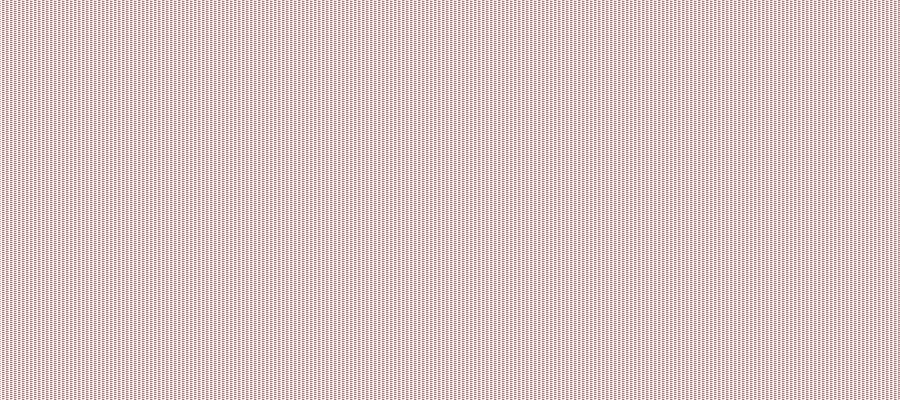

In [ ]:
blat = 10
latlim = 15
denom = 4


boxsize = 11

avgblur = np.ones((boxsize,boxsize))

imin = signal.convolve2d(im, avgblur, boundary='symm', mode='same')

imin = np.where(np.logical_and(OGincArray<75,OGemisArray<75),imin,np.nan)

# kx = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
# ky = np.array([[-1,-1,-1] ,[0,0,0], [1,1,1]])

# xlattest = np.where(np.isfinite(imin),np.nan,np.nan)
# ylattest = np.where(np.isfinite(imin),np.nan,np.nan)
# xgradtest = np.where(np.isfinite(imin),np.nan,np.nan)
# ygradtest = np.where(np.isfinite(imin),np.nan,np.nan)

# for i,j in enumerate(imin):
#     if i>0 and i<len(imin)-2:
#         for n,m in enumerate(j):
#             if np.isfinite(m) and n>0 and n<len(j)-2:
#                 imbox = np.array([[imin[i-1,n-1],imin[i-1,n],imin[i-1,n+1]],
#                                   [imin[i,n-1],imin[i,n],imin[i,n+1]],
#                                   [imin[i+1,n-1],imin[i+1,n],imin[i+1,n+1]]])
#                 if len(np.where(np.isfinite(imbox))[0])<9: continue
#                 else:
#                     ylat = OGlatArray[i,n] - OGlatArray[i-1,n]
#                     xlat = OGlatArray[i,n] - OGlatArray[i,n-1]

#                     tot = np.sqrt(xlat**2 + ylat**2)
#                     xlat = xlat/tot
#                     ylat = ylat/tot

#                     xlattest[i,n] = xlat
#                     ylattest[i,n] = ylat

#                     xgradtest[i,n] = np.sum(kx*imbox)
#                     ygradtest[i,n] = np.sum(ky*imbox)


# slope = np.where(np.isfinite(ylattest/xlattest),(ylattest/xlattest),np.nan)

# xfact = np.where(np.isfinite(slope),1,np.nan)
# xfact = np.where(xlattest<0,-1,xfact)
# xfact = np.where(slope>100,0,xfact)
# yfact = slope
# yfact = np.where(xlattest<0,-slope,yfact)

# normfact = np.abs(xfact) + np.abs(yfact)

# xfact /= normfact
# yfact /= normfact

slopeswitch = np.full(np.shape(OGim),np.nan)
slopeswitch[s:e,s:e] = -1.*np.copy(finalimlat)
# slopeswitch[s:e,s:e] = -1.*np.copy(nfinalimlat)
# slopeswitch[s:e,s:e] = np.copy(finalimlat)
# slopeswitch[s:e,s:e] = np.copy(nfinalimlat)

# slopeswitch = xfact*xgradtest + yfact*ygradtest

# hemisphereSwitch = np.nanmean(np.where(OGlatArray>0,im,np.nan)) < np.nanmean(np.where(OGlatArray<0,im,np.nan))

# # hemisphereSwitch = False

# if hemisphereSwitch:
#     slopeswitch *= -1

cropadgrad2 = np.where(np.logical_and(OGlatArray<blat+latlim,OGlatArray>blat-latlim),slopeswitch,np.nan)

# if hemisphereSwitch:
#     cropadgrad2 = np.where(np.logical_and(OGlatArray<7,OGlatArray>-23),slopeswitch,np.nan)
# #     cropadgrad2 = np.where(np.logical_and(OGlatArray<23,OGlatArray>-7),slopeswitch,np.nan)
# else:
#     cropadgrad2 = np.where(np.logical_and(OGlatArray<7,OGlatArray>-23),slopeswitch,np.nan)
# #     cropadgrad2 = np.where(np.logical_and(OGlatArray<23,OGlatArray>-7),slopeswitch,np.nan)


# denom = 4
# if fname == "N1845483375_1":
#     cropadgrad2 = np.where(np.logical_and(OGlatArray<15,OGlatArray>-5),slopeswitch,np.nan)
#     denom = 7



# if fname.startswith("N18382") or fname.startswith("N1839"):
#     cropadgrad2 = np.where(np.logical_and(OGlatArray<20,OGlatArray>5),slopeswitch,np.nan)
#     denom = 7
#     if fname == 'N1839513938_1':
#         slopeswitch2 *= -100


cropadgrad2thresh = np.zeros(np.shape(cropadgrad2))

croplat = np.where(np.isfinite(cropadgrad2),OGlatArray,np.nan)
croplon = np.where(np.isfinite(cropadgrad2),OGlonArray,np.nan)

latnum = len(np.where(np.isfinite(cropadgrad2))[0])
latslicenum = 2500
latslices = latnum//latslicenum
if latnum%latslicenum > 0.5*latslicenum:
    latslices += 1

ind = croplat.argsort(axis=None)
xloc = ind//len(im)
yloc = ind%len(im[0])
flatlon = croplon.flatten()
if 360-np.nanmax(flatlon) < 10 and np.nanmin(flatlon) < 10:
    flatlon = np.where(flatlon>180,flatlon-360,flatlon)
lonslices = 100

slicearray = np.full(np.shape(im),np.nan)

for i in range(latslices):
    if i == latslices-1:
        latend = latnum
    else:
        latend = latslicenum*(i+1)

    ind2 = flatlon[ind[latslicenum*i:latend]].argsort(axis=None)
    lonnum = len(ind2)
    lonslicenum = lonnum//lonslices

    for j in range(lonslices):
        if j == lonslices-1:
            lonend = lonnum
        else:
            lonend = lonslicenum*(j+1)

        xtemp = xloc[latslicenum*i:latend][ind2[lonslicenum*j:lonend]]
        ytemp = yloc[latslicenum*i:latend][ind2[lonslicenum*j:lonend]]
        slicearray[xtemp,ytemp] = j


imlen = len(im)
imind = np.empty((2,imlen,imlen),dtype=int)

for i in range(imlen):
    for j in range(imlen):
        imind[0:2,i,j] = (i,j)


for i in range(lonslices):
    lonmask = slicearray == i

    num = len(cropadgrad2[lonmask])//denom #larger denominator seems better for later images with weaker boundaries

    ind = np.argpartition(cropadgrad2[lonmask], -num)[-num:] #locates num brightest pixels

    cropadgrad2thresh[imind[0][lonmask][ind],imind[1][lonmask][ind]] = 1

edge = np.where(np.isfinite(cropadgrad2),cropadgrad2thresh,np.nan)
sobelthresh = np.copy(edge)

meanx = []
meany = []

for i in range(lonslices):

    lonmask = slicearray == i

    tempmean = np.nanmean(sobelthresh[lonmask])

    if tempmean > 0:
        lonslice = np.where(lonmask,sobelthresh,np.nan)
        points = np.where(lonslice==1)

#         weights = cropadgrad2[points]
#         weights -= np.min(weights)
#         meanx.append(np.sum(points[0] * weights) / np.sum(weights))
#         meany.append(np.sum(points[1] * weights) / np.sum(weights))

        meanx.append(np.nanmedian(points[0]))
        meany.append(np.nanmedian(points[1]))

    else:
        meanx.append(np.nan)
        meany.append(np.nan)


meanx = np.asarray(meanx,dtype=float)
meany = np.asarray(meany,dtype=float)

nonanx = []
nonany = []

for i,j in enumerate(meanx):
    if np.isfinite(meanx[i]):
        nonanx.append(int(np.round(meanx[i])))
        nonany.append(int(np.round(meany[i])))

print("{0} {1} {2}".format(fname, nonanx, nonany))

# imb2 = np.copy(imin)
# imb2[nonanx,nonany] = np.nanmax(imin)

imb2 = np.copy(slopeswitch)
imb2[nonanx,nonany] = np.nanmax(slopeswitch)

plt.close(fig)
fig, (ax,ax2) = plt.subplots(1,2,figsize=(9,4))

ax.imshow(imb2[s:e,s:e],vmin=-.0001,vmax=.0001)
# ax.imshow(imb2[s:e,s:e],vmin=-.002,vmax=.002)


edgetest = np.copy(edge)
edgetest[nonanx,nonany] = np.nan
ax2.imshow(edgetest[s:e,s:e])

In [ ]:


lons = OGlonArray[nonanx,nonany]
lats = OGlatArray[nonanx,nonany]

Q1 = np.percentile(lats, 25, interpolation = 'midpoint')
Q3 = np.percentile(lats, 75, interpolation = 'midpoint')
IQR = Q3 - Q1

fac = 5.

upperorlower = np.logical_or(lats>=(Q3+fac*IQR), lats<=(Q1-fac*IQR))

oldlen = len(lats)

trim = 2

# lats = lats[~upperorlower][7:]
# lons = lons[~upperorlower][7:]

lats = lats[~upperorlower]
lons = lons[~upperorlower]

# lats = lats[~upperorlower][trim:-trim]
# lons = lons[~upperorlower][trim:-trim]

# mask = np.full(np.shape(lats),True)
# mask[trim:-trim] = False
# lats = lats[mask]
# lons = lons[mask]

print("lat/lon arrays trimmed from {0} to {1}\n".format(oldlen,len(lats)))

semimaj = 2771.0
semimin = 2691.2
sphcoords = tosphcoordarray(lons,lats,semimaj,semimin)

cartcoords = sphtocar(sphcoords)
cartcoords = np.asarray(cartcoords)

print("a,b,c,d")
abcdest = 0,0,1,np.nanmean(lats)*100
# plane = optimize.least_squares(planefit, abcdest)  #,bounds=([0,0,1,0.975*bguess], [h,w,1.05,1.025*bguess])
# plane = optimize.least_squares(planefit, abcdest ,bounds=([-1.,-1.,-1.,-2000], [1,1,1,2000])) #([-1,-1,1,-1000], [1.1,1.1,1.1,1001])
plane = optimize.least_squares(planefit, abcdest) #([-1,-1,1,-1000], [1.1,1.1,1.1,1001])



a,b,c,d = plane.x


norm = np.sqrt(a*a + b*b + c*c)
a,b,c,d = (a,b,c,d)/norm

print(a,b,c,d)


z1 = -d/c
meanlat = np.degrees(np.arctan(z1/(semimaj*np.sqrt(1-(z1/semimin)**2))))
if z1*meanlat<0: meanlat *= -1
nvecsph = cartosph([[a,b,c]])
azimuth2, amp = nvecsph[0][0], 90 - nvecsph[0][1]
if azimuth2 > 360: azimuth2 -= 360
elif azimuth2 < 0: azimuth2 += 360


print("\nimageID   amp   az      mlat   SSL    offset  time")
print("Observed: {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}  {}".format(amp,azimuth2,meanlat,SSL,azimuth2-SSL,time))
# print("Actual:   {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}  {:0.2f}".format(testvals[0],testvals[1],testvals[2],SSL,testvals[1]-SSL))


lat/lon arrays trimmed from 100 to 100

a,b,c,d
0.0014442040138845827 0.07867172869686775 0.996899530232918 -565.9774475246462

imageID   amp   az      mlat   SSL    offset  time
Observed: 4.51  88.95  11.84  112.99  -24.04  2016-06-01 04:00:02.848000


In [ ]:
#olreliable
#light line: (3.7261451801843464, 217.44625612629946, -2.5708185579832152)
#dark line: (4.9579433915473174, 214.7720149732952, -13.938766389534758)

In [ ]:
resvals = amp,azimuth2,meanlat
# testvals = 10,90,12
testvals = amp,azimuth2+180,meanlat-5
ring = boundaryring((OGlatArray,OGlonArray),*resvals)
# ring = boundaryring((OGlatArray,OGlonArray),*testvals)


In [ ]:
resvals

(4.9579433915473174, 214.7720149732952, -13.938766389534758)

<IPython.core.display.Javascript object>


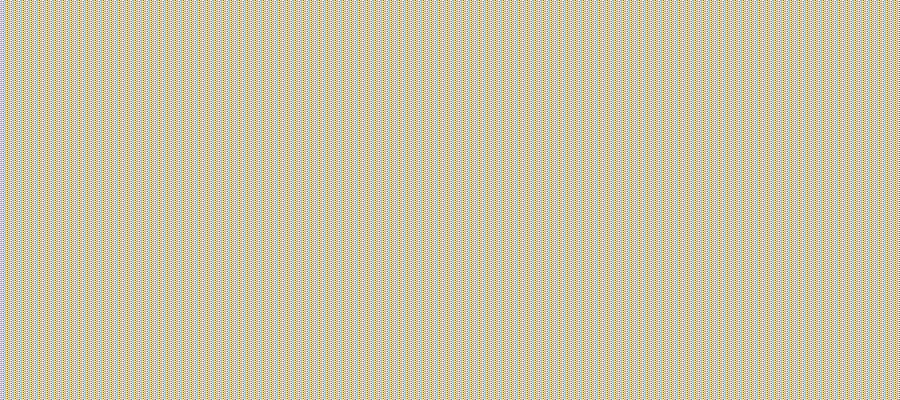

In [ ]:
plt.close(fig)
fig, (ax,ax2) = plt.subplots(1,2,figsize=(9,4))

edgetest = -1*np.copy(edge)

arx = np.asarray(nonanx)
ary = np.asarray(nonany)

noxt = arx[~upperorlower]
noyt = ary[~upperorlower]
# noxt = arx[~upperorlower][trim:-trim]
# noyt = ary[~upperorlower][trim:-trim]
# noxt = arx[mask]
# noyt = ary[mask]
edgetest[noxt,noyt] = np.nan
edgetest[ring] = np.nanmean(edgetest)
# edgetest[np.where(np.round(OGlatArray)==12)] = .5
# edgetest[nonanx,nonany] = np.nan
ax.imshow(edgetest[s:e,s:e])

latlonim = np.where(np.logical_or(latr==0,lonr==30),np.nan,imtest2)
ax2.imshow(np.where(ring[s:e,s:e],np.nanmax(latlonim),latlonim))

In [ ]:
SSL,SCL

(318.8390518375, 27.910863176713)

In [ ]:
ring

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

<IPython.core.display.Javascript object>


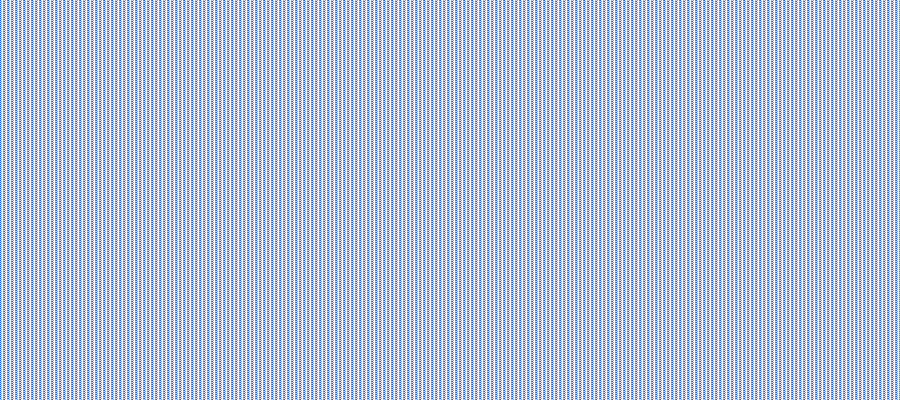

In [ ]:
plt.close(fig)
fig, (ax,ax2) = plt.subplots(1,2,figsize=(9,4))

ax.imshow(imtest2)

# ax2.imshow(imb2[s:e,s:e],vmin=-.0001,vmax=.0001)
ax2.imshow(slopeswitch[s:e,s:e],vmin=-.0001,vmax=.0001)